<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Read-data-saved-by-DataPreprocessing.R" data-toc-modified-id="Read-data-saved-by-DataPreprocessing.R-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read data saved by DataPreprocessing.R</a></span></li></ul></li><li><span><a href="#Model-devolepment" data-toc-modified-id="Model-devolepment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model devolepment</a></span><ul class="toc-item"><li><span><a href="#Split-dataset-to-train-and-test-dataset" data-toc-modified-id="Split-dataset-to-train-and-test-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Split dataset to train and test dataset</a></span></li><li><span><a href="#Some-base-function" data-toc-modified-id="Some-base-function-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Some base function</a></span></li><li><span><a href="#Construction-of-NeuralMultiTaskModel" data-toc-modified-id="Construction-of-NeuralMultiTaskModel-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Construction of NeuralMultiTaskModel</a></span></li><li><span><a href="#Construction-of-NonLinearCoxPHModel-(DeepSurv)" data-toc-modified-id="Construction-of-NonLinearCoxPHModel-(DeepSurv)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Construction of NonLinearCoxPHModel (DeepSurv)</a></span></li><li><span><a href="#Construction-of-RandomSurvivalForestModel" data-toc-modified-id="Construction-of-RandomSurvivalForestModel-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Construction of RandomSurvivalForestModel</a></span></li><li><span><a href="#Construct-CPH-Model" data-toc-modified-id="Construct-CPH-Model-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Construct CPH Model</a></span></li><li><span><a href="#Hyperparameters-tuning" data-toc-modified-id="Hyperparameters-tuning-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Hyperparameters tuning</a></span><ul class="toc-item"><li><span><a href="#Tuning-NMTLR" data-toc-modified-id="Tuning-NMTLR-2.7.1"><span class="toc-item-num">2.7.1&nbsp;&nbsp;</span>Tuning NMTLR</a></span></li><li><span><a href="#Tuning-DeepSurv" data-toc-modified-id="Tuning-DeepSurv-2.7.2"><span class="toc-item-num">2.7.2&nbsp;&nbsp;</span>Tuning DeepSurv</a></span></li><li><span><a href="#Tuning-RSF" data-toc-modified-id="Tuning-RSF-2.7.3"><span class="toc-item-num">2.7.3&nbsp;&nbsp;</span>Tuning RSF</a></span></li></ul></li></ul></li><li><span><a href="#Metrics" data-toc-modified-id="Metrics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Metrics</a></span><ul class="toc-item"><li><span><a href="#Generate-data-for-prediction-error-curve" data-toc-modified-id="Generate-data-for-prediction-error-curve-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generate data for prediction error curve</a></span></li><li><span><a href="#Generate-data-for-calibration-curves-and-roc-curves" data-toc-modified-id="Generate-data-for-calibration-curves-and-roc-curves-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data for calibration curves and roc curves</a></span></li><li><span><a href="#Generate-data-for-Loss-converge-graph" data-toc-modified-id="Generate-data-for-Loss-converge-graph-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generate data for Loss converge graph</a></span></li><li><span><a href="#Feature-importance-plot" data-toc-modified-id="Feature-importance-plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Feature importance plot</a></span></li><li><span><a href="#Save-models" data-toc-modified-id="Save-models-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Save models</a></span></li></ul></li></ul></div>

# The prognostic value of machine learning techniques versus cox regression model for chordoma

In [66]:
import torch
import random
import numpy as np
import os
from pysurvival.utils.display import display_loss_values
from pysurvival.utils import check_data

In [67]:
np.seterr(divide='ignore', invalid='ignore') #Ignore warning: #RuntimeWarning: invalid value encountered in true_divide

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [68]:
def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
SEED = 16 #random.randint(0,100000)
print(SEED)
seed_everything(SEED)

16


## Preprocessing

### Read data saved by DataPreprocessing.R

In [69]:
exclude_cols = []

In [70]:
import pandas as pd
dataset = pd.read_csv('../DataPreprocessing/data/data_surv.csv')
dataset.columns = [name.replace('.',' ') for name in dataset.columns]
time_column = 'Survival months'
event_column = 'Status'
features = np.setdiff1d(dataset.columns, [time_column, event_column] + exclude_cols).tolist()
dataset[features+[time_column, event_column]].head()

,Age,Chemotherapy,Distant metastasis,Primary site,Race,Radiotherapy,Surgery,Tumor extension,Tumor size,Survival months,Status
0,43,0,0,0,0,1,2,1,61.000000,86,1
1,58,0,0,2,0,0,2,1,54.917872,1,1
2,82,0,0,1,2,0,0,2,70.234356,15,1
3,75,0,0,1,2,1,2,1,18.000000,32,1
4,54,0,0,2,0,0,3,1,50.630573,157,0


In [71]:
dataset.shape

(724, 11)

## Model devolepment
### Split dataset to train and test dataset

In [72]:
from sklearn.model_selection import train_test_split
import numpy as np
index_train, index_test = train_test_split(range(dataset.shape[0]), test_size = 0.3,random_state=SEED)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )
# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]
if not os.path.exists('data'):
    os.mkdir('data')
data_train.to_csv('data/train.csv')
data_test.to_csv('data/test.csv')

In [73]:
from pysurvival.utils.metrics import concordance_index
from sklearn.model_selection import RepeatedKFold
import threading

### Some base function

In [74]:
class BaseFun:
    def parse_param(self, param):
        for key in param:
            if isinstance(param[key], str):
                param[key] = '"{}"'.format(param[key])
        return ','.join(['{} = {}'.format(key, param[key]) for key in param])
    def get_random_param(self,space):
        param = {}
        for key in space:
            if  key == 'structure':
                items = []
                for i in range(1,random.choice(space['structure']['num_layers'])+1):
                    items.append(
                        {
                        'activation': random.choice(space['structure']['activations']),
                        'num_units':random.choice(space['structure']['num_units'])
                        }
                    )
                param['structure'] = items
            else:
                param[key] = random.choice(space[key])
        return param
    def tuning_and_construct(self,X, T, E,max_iter=100):
        self.tuning_result = self.tuning_with_space(X, T, E,self.space,max_iter=max_iter)
        self.model = self.fit_model(X, T, E,**self.tuning_result['best_param'])
        return self.model
    def cv(self,x,t,e,param,num):
        score_iter = []
        rkf = RepeatedKFold(n_splits=5, n_repeats=1)
        for train_index, test_index in rkf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            t_train, t_test = t[train_index], t[test_index]
            e_train, e_test = e[train_index], e[test_index]
            model = self.fit_model(x_train, t_train, e_train,**param)
            score = concordance_index(model, x_test, t_test, e_test)
            score_iter.append(score)
        print('Number {} thread'.format(num), end=' ... ')
        mean_score = np.mean(score_iter)
        print('mean_c_index: ', mean_score, end=' ')
        if mean_score > self.best_score:
            self.best_score = mean_score
            self.best_param = param
            print('is the best so far')
        else:
            print('')
        self.scores.append({'iteration':num,'mean_score': mean_score, 'param': param})
    def tuning_with_space(self,x,t,e,space,max_iter=100,num_thread=10):
        [x,t,e] = [item if isinstance(item, np.ndarray) else np.array(item) for item in [x,t,e]]
        self.scores = []
        self.best_score = 0
        self.best_param = {}
        num = 1
        while True:
            tasks = []
            for i in range(num_thread):
                param = self.get_random_param(space)
                tasks.append(threading.Thread(target=self.cv,args=(x,t,e,param,num,)))
                num += 1
            for task in tasks:
                task.start()
            for task in tasks:
                task.join()
            print({'total iteration':num,'best_param': self.best_param, 'best_score': self.best_score})
            if num >= max_iter:
                break
        return {'best_param': self.best_param, 'best_score': self.best_score, 'scores': self.scores}

### Construction of NeuralMultiTaskModel

In [75]:
from pysurvival.models.multi_task import NeuralMultiTaskModel
class NMTLR(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'bins' : [i for i in range(10,100)],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 1000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'l2_smooth':[round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        if 'bins' in kwargs:
            bins = kwargs['bins']
            del kwargs['bins']
        model = NeuralMultiTaskModel(structure=structure,bins=bins)
        eval('model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return model

### Construction of NonLinearCoxPHModel (DeepSurv)

In [76]:
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
class DeepSurv(BaseFun):
    def __init__(self):
        self.space = {
            'structure': {'num_layers':[1,2,3,4,5],
                          'num_units': [i for i in range(8, 100)],
                          'activations': ["Atan", "BentIdentity", "BipolarSigmoid", "CosReLU", 
                                           "Gaussian", "Hardtanh", "InverseSqrt", "LeakyReLU", 
                                          "LeCunTanh", "LogLog", "LogSigmoid", "ReLU", "SELU", "Sigmoid", 
                                          "Sinc", "SinReLU","Softmax", "Softplus", "Softsign", "Swish", "Tanh"]
                         },
            'optimizer':['adadelta','adagrad','adam','adamax','rmsprop','sgd'],
            'lr': [round(1e-5 * i, 5) for i in range(1, 100 + 1)],
            'num_epochs': [i for i in range(50, 5000 + 1)],
            'dropout': [round(0.1 * i, 2) for i in range(1, 4 + 1)],
            'l2_reg': [round(0.0001 * i, 5) for i in range(1, 100 + 1)],
            'batch_normalization' : [False, True]
        }
    def fit_model(self,X, T, E,**kwargs):
        structure = [{'activation': 'ReLU', 'num_units': 128}]
        bins = 100
        if 'structure' in kwargs:
            structure = kwargs['structure']
            del kwargs['structure']
        model = NonLinearCoxPHModel(structure=structure)
        eval('model.fit(X, T, E,{})'.format(self.parse_param(kwargs)))
        return model

### Construction of RandomSurvivalForestModel

In [77]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
class RSF(BaseFun):
    def __init__(self):
        self.space = {
            'num_trees': [i for i in range(20, 1000 + 1)],
            'max_features': ['sqrt', 'log2', 'all', 0.1, 0.2],
            'min_node_size': [i for i in range(5, 80 + 1)],
            'sample_size_pct': [round(0.2 * i, 2) for i in range(1, 4 + 1)],
            'importance_mode': ['impurity', 'impurity_corrected', 'permutation', 'normalized_permutation']
        }
    def fit_model(self,X, T, E,**kwargs):
        if 'num_trees' in kwargs:
            model = RandomSurvivalForestModel(num_trees=kwargs['num_trees'])
            del kwargs['num_trees']
        else:
            model = RandomSurvivalForestModel()
        eval('model.fit(X, T, E,seed=SEED,{})'.format(self.parse_param(kwargs)))
        return model

### Construct CPH Model

In [79]:
from pysurvival.models.semi_parametric import CoxPHModel
def cph(X_train, T_train, E_train):
    model = CoxPHModel()
    model.fit(X_train, T_train, E_train, lr=0.2, l2_reg=0.01)
    return model


In [80]:
cph.model = cph(X_train, T_train, E_train)
c_index_train = concordance_index(cph.model, X_train, T_train, E_train)
c_index_test = concordance_index(cph.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) #C-index: 0.6996

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 1187.253 - ||grad||^2 = 383.70961
 * Iteration #2 - Loss = 1124.901 - ||grad||^2 = 303.92400
 * Iteration #3 - Loss = 1090.490 - ||grad||^2 = 243.79276
 * Iteration #4 - Loss = 1068.788 - ||grad||^2 = 196.48862
 * Iteration #5 - Loss = 1054.456 - ||grad||^2 = 158.71155
 * Iteration #6 - Loss = 1044.777 - ||grad||^2 = 128.30957
 * Iteration #7 - Loss = 1038.168 - ||grad||^2 = 103.73860
 * Iteration #8 - Loss = 1033.636 - ||grad||^2 = 83.83645
 * Iteration #9 - Loss = 1030.530 - ||grad||^2 = 67.70210
 * Iteration #10 - Loss = 1028.408 - ||grad||^2 = 54.62284
 * Iteration #11 - Loss = 1026.966 - ||grad||^2 = 44.02700
 * Iteration #12 - Loss = 1025.992 - ||grad||^2 = 35.45170
 * Iteration #13 - Loss = 1025.339 - ||grad||^2 = 28.51998
 * Iteration #14 - Loss = 1024.904 - ||grad||^2 = 22.92393
 * Iteration #15 - Loss = 1024.615 - ||grad||^2 = 18.41182
 * Iteration #16 - Loss = 1024.425 - ||grad||^2 = 14.77794
 * Iteration #17 - 

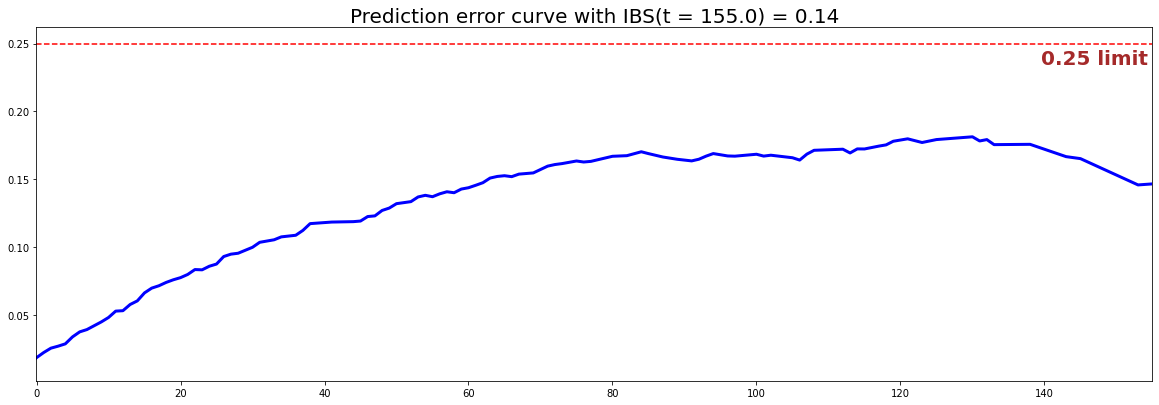

IBS: 0.14


In [81]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(cph.model, X_train, T_train, E_train,t_max=None, figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

### Hyperparameters tuning

In [83]:
max_iter = 1000

#### Tuning NMTLR

In [84]:
nmtlr = NMTLR()
nmtlr.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)

% Completion: 100%|***********************************************|Loss: 605.41
% Completion: 100%|***********************************************|Loss: 351.40
% Completion: 100%|***********************************************|Loss: 581.13
% Completion: 100%|***********************************************|Loss: 515.10
% Completion: 100%|***********************************************|Loss: 789.10
% Completion: 100%|***********************************************|Loss: 518.50
% Completion: 100%|***********************************************|Loss: 942.25
% Completion: 100%|***********************************************|Loss: 592.88
% Completion: 100%|***********************************************|Loss: 350.33
% Completion: 100%|***********************************************|Loss: 609.37
% Completion: 100%|***********************************************|Loss: 578.46
% Completion: 100%|***********************************************|Loss: 703.21
% Completion: 100%|*********************

Number 10 thread ... mean_c_index:  0.7014259929419532 is the best so far


% Completion: 100%|***********************************************|Loss: 380.09
% Completion: 100%|***********************************************|Loss: 334.18
% Completion: 100%|**********************************************|Loss: 1119.97
% Completion:  50%|***********************                        |Loss: 785.32
% Completion: 100%|***********************************************|Loss: 533.79
% Completion: 100%|***********************************************|Loss: 784.29
% Completion:  20%|*********                                     |Loss: 1113.35
% Completion: 100%|***********************************************|Loss: 729.71
% Completion:  69%|********************************               |Loss: 802.54
% Completion: 100%|**********************************************|Loss: 1422.14
% Completion: 100%|***********************************************|Loss: 549.40
% Completion: 100%|***********************************************|Loss: 754.86
% Completion: 100%|*********************

Number 9 thread ... mean_c_index:  0.5666155528041651 


% Completion: 100%|***********************************************|Loss: 336.76
% Completion: 100%|***********************************************|Loss: 572.32


Number 8 thread ... mean_c_index:  0.5670752150881463 


% Completion: 100%|***********************************************|Loss: 769.30


Number 5 thread ... mean_c_index:  0.600603933375221 


% Completion: 100%|**********************************************|Loss: 1474.30
% Completion:  59%|****************************                   |Loss: 821.59
% Completion: 100%|***********************************************|Loss: 528.72


Number 3 thread ... mean_c_index:  0.5654472622628022 


% Completion: 100%|***********************************************|Loss: 752.51
% Completion: 100%|***********************************************|Loss: 676.99
% Completion: 100%|**********************************************|Loss: 1139.48


Number 4 thread ... mean_c_index:  0.6249215614304063 


% Completion: 100%|***********************************************|Loss: 389.93
% Completion: 100%|***********************************************|Loss: 989.21
% Completion: 100%|***********************************************|Loss: 565.05
% Completion: 100%|***********************************************|Loss: 696.49
% Completion: 100%|***********************************************|Loss: 388.36
% Completion: 100%|***********************************************|Loss: 746.94


Number 2 thread ... mean_c_index:  0.5330666531108978 


% Completion: 100%|**********************************************|Loss: 1028.44
% Completion: 100%|***********************************************|Loss: 699.31
% Completion: 100%|***********************************************|Loss: 361.90


Number 6 thread ... mean_c_index:  0.7059742890189835 is the best so far


% Completion: 100%|**********************************************|Loss: 1132.37


Number 1 thread ... mean_c_index:  0.5990855704817571 


% Completion: 100%|***********************************************|Loss: 680.23


Number 7 thread ... mean_c_index:  0.7421341846276374 is the best so far
{'total iteration': 11, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 12}, {'activation': 'Softplus', 'num_units': 13}, {'activation': 'Tanh', 'num_units': 59}, {'activation': 'Swish', 'num_units': 48}], 'optimizer': 'adamax', 'bins': 75, 'lr': 0.00086, 'num_epochs': 883, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0041, 'batch_normalization': False}, 'best_score': 0.7421341846276374}


% Completion:  50%|***********************                        |Loss: 726.04 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 671.88
% Completion:  53%|************************                      |Loss: 1043.59
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 994.86
% Completion: 100%|***********************************************|Loss: 724.57
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 747.57


Number 19 thread ... mean_c_index:  0.5413853983126717 


% Completion: 100%|***********************************************|Loss: 652.88
% Completion: 100%|***********************************************|Loss: 654.16
% Completion: 100%|***********************************************|Loss: 750.55
% Completion: 100%|***********************************************|Loss: 751.78
% Completion: 100%|***********************************************|Loss: 977.91
% Completion: 100%|***********************************************|Loss: 728.65
% Completion: 100%|***********************************************|Loss: 763.57
% Completion: 100%|**********************************************|Loss: 1526.84
% Completion: 100%|***********************************************|Loss: 631.54
% Completion: 100%|***********************************************|Loss: 672.34


Number 16 thread ... mean_c_index:  0.702138959300455 


% Completion: 100%|***********************************************|Loss: 712.07


Number 15 thread ... mean_c_index:  0.7105304631634382 


% Completion: 100%|***********************************************|Loss: 721.89
% Completion: 100%|***********************************************|Loss: 742.59
% Completion: 100%|**********************************************|Loss: 1109.79
% Completion: 100%|***********************************************|Loss: 225.35
% Completion: 100%|***********************************************|Loss: 740.98
% Completion: 100%|***********************************************|Loss: 562.17
% Completion: 100%|***********************************************|Loss: 930.24
% Completion: 100%|***********************************************|Loss: 744.22
% Completion: 100%|**********************************************|Loss: 1055.01
% Completion: 100%|***********************************************|Loss: 632.10
% Completion: 100%|***********************************************|Loss: 935.56


Number 12 thread ... mean_c_index:  0.5879736953526404 


% Completion: 100%|***********************************************|Loss: 730.82
% Completion: 100%|***********************************************|Loss: 660.24


Number 20 thread ... mean_c_index:  0.6417382301129713 


% Completion: 100%|***********************************************|Loss: 673.00
% Completion: 100%|**********************************************|Loss: 1090.22
% Completion: 100%|***********************************************|Loss: 223.06
% Completion: 100%|***********************************************|Loss: 660.75


Number 18 thread ... mean_c_index:  0.5625687663318029 


% Completion: 100%|***********************************************|Loss: 574.82
% Completion: 100%|***********************************************|Loss: 764.23
% Completion: 100%|**********************************************|Loss: 1016.39
% Completion: 100%|**********************************************|Loss: 1132.47


Number 11 thread ... mean_c_index:  0.5949274955757597 


% Completion: 100%|***********************************************|Loss: 216.06
% Completion: 100%|***********************************************|Loss: 761.18
% Completion: 100%|***********************************************|Loss: 592.58
% Completion: 100%|***********************************************|Loss: 806.77


Number 17 thread ... mean_c_index:  0.7208335502527392 


% Completion: 100%|***********************************************|Loss: 585.38
% Completion: 100%|***********************************************|Loss: 217.80
% Completion: 100%|***********************************************|Loss: 548.92


Number 14 thread ... mean_c_index:  0.7125375289236735 


% Completion: 100%|***********************************************|Loss: 192.50


Number 13 thread ... mean_c_index:  0.5556627612867991 
{'total iteration': 21, 'best_param': {'structure': [{'activation': 'ReLU', 'num_units': 12}, {'activation': 'Softplus', 'num_units': 13}, {'activation': 'Tanh', 'num_units': 59}, {'activation': 'Swish', 'num_units': 48}], 'optimizer': 'adamax', 'bins': 75, 'lr': 0.00086, 'num_epochs': 883, 'dropout': 0.1, 'l2_reg': 0.003, 'l2_smooth': 0.0041, 'batch_normalization': False}, 'best_score': 0.7421341846276374}


% Completion: 100%|**********************************************|Loss: 1126.56
% Completion: 100%|**********************************************|Loss: 1126.11
% Completion:  32%|**************                                |Loss: 1162.63
% Completion: 100%|***********************************************|Loss: 708.45
% Completion: 100%|***********************************************|Loss: 999.74
% Completion: 100%|**********************************************|Loss: 1138.72
% Completion: 100%|***********************************************|Loss: 600.47
% Completion: 100%|**********************************************|Loss: 1616.14
% Completion: 100%|**********************************************|Loss: 1079.74
% Completion: 100%|**********************************************|Loss: 1226.53


Number 28 thread ... mean_c_index:  0.5556377677813025 


% Completion: 100%|***********************************************|Loss: 675.02
% Completion: 100%|**********************************************|Loss: 1135.93
% Completion: 100%|***********************************************|Loss: 700.32
% Completion: 100%|***********************************************|Loss: 682.82
% Completion: 100%|***********************************************|Loss: 601.40
% Completion: 100%|**********************************************|Loss: 1275.47


Number 25 thread ... mean_c_index:  0.6039798121678573 


% Completion:  41%|*******************                            |Loss: 663.00
% Completion: 100%|***********************************************|Loss: 710.98
% Completion: 100%|**********************************************|Loss: 1035.41
% Completion: 100%|***********************************************|Loss: 559.20
% Completion: 100%|***********************************************|Loss: 830.63
% Completion: 100%|***********************************************|Loss: 698.99


Number 21 thread ... mean_c_index:  0.7452307784875426 is the best so far


% Completion: 100%|***********************************************|Loss: 704.99
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 597.19
% Completion: 100%|***********************************************|Loss: 738.63
% Completion: 100%|***********************************************|Loss: 830.24
% Completion: 100%|***********************************************|Loss: 586.06


Number 23 thread ... mean_c_index:  0.5725594197412217 


% Completion: 100%|***********************************************|Loss: 689.28
% Completion: 100%|**********************************************|Loss: 1043.37
% Completion: 100%|**********************************************|Loss: 1006.00
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 850.59
% Completion: 100%|***********************************************|Loss: 743.22
% Completion: 100%|***********************************************|Loss: 969.01
% Completion: 100%|***********************************************|Loss: 702.80
% Completion: 100%|***********************************************|Loss: 746.08
% Completion: 100%|***********************************************|Loss: 839.66


Number 24 thread ... mean_c_index:  0.5344500023206784 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 994.07
% Completion: 100%|***********************************************|Loss: 869.12


Number 29 thread ... mean_c_index:  0.724863700261458 


% Completion: 100%|**********************************************|Loss: 1237.23
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 919.88
% Completion: 100%|***********************************************|Loss: 698.42
% Completion: 100%|***********************************************|Loss: 983.34


Number 30 thread ... mean_c_index:  0.6645263112546627 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 26 thread ... mean_c_index:  0.5708413648955538 


% Completion: 100%|**********************************************|Loss: 1084.59


Number 22 thread ... mean_c_index:  0.5517224194525367 


% Completion: 100%|***********************************************|Loss: 695.02
% Completion: 100%|***********************************************|Loss: 689.00


Number 27 thread ... mean_c_index:  0.7466462709476203 is the best so far
{'total iteration': 31, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 91}, {'activation': 'Sinc', 'num_units': 48}, {'activation': 'BipolarSigmoid', 'num_units': 88}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.0004, 'num_epochs': 938, 'dropout': 0.4, 'l2_reg': 0.0003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7466462709476203}


% Completion: 100%|***********************************************|Loss: 698.42
% Completion: 100%|***********************************************|Loss: 655.52
% Completion: 100%|***********************************************|Loss: 568.96
% Completion: 100%|***********************************************|Loss: 656.74
% Completion: 100%|***********************************************|Loss: 658.73
% Completion: 100%|***********************************************|Loss: 573.74
% Completion:  45%|*********************                          |Loss: 757.42
% Completion: 100%|***********************************************|Loss: 680.60
% Completion: 100%|***********************************************|Loss: 662.90
% Completion: 100%|***********************************************|Loss: 576.44
% Completion: 100%|***********************************************|Loss: 111.16
% Completion: 100%|***********************************************|Loss: 689.85
% Completion: 100%|*********************

Number 35 thread ... mean_c_index:  0.5232912750641272 


% Completion: 100%|***********************************************|Loss: 689.16


Number 38 thread ... mean_c_index:  0.5498930628210403 


% Completion: 100%|**********************************************|Loss: 1308.48
% Completion: 100%|***********************************************|Loss: 554.58
% Completion: 100%|***********************************************|Loss: 611.72
% Completion: 100%|***********************************************|Loss: 118.73
% Completion: 100%|***********************************************|Loss: 552.36
% Completion: 100%|***********************************************|Loss: 410.32
% Completion: 100%|***********************************************|Loss: 592.36


Number 31 thread ... mean_c_index:  0.7387700701978993 


% Completion: 100%|***********************************************|Loss: 591.17
% Completion: 100%|***********************************************|Loss: 816.30
% Completion: 100%|***********************************************|Loss: 573.22
% Completion: 100%|***********************************************|Loss: 114.21
% Completion: 100%|***********************************************|Loss: 906.51
% Completion: 100%|***********************************************|Loss: 558.04


Number 37 thread ... mean_c_index:  0.7326560866447882 


% Completion: 100%|***********************************************|Loss: 538.87


Number 34 thread ... mean_c_index:  0.618246490709087 


% Completion: 100%|***********************************************|Loss: 391.62
% Completion: 100%|**********************************************|Loss: 1275.74
% Completion: 100%|***********************************************|Loss: 121.86
% Completion: 100%|***********************************************|Loss: 779.98
% Completion: 100%|***********************************************|Loss: 422.48
% Completion: 100%|***********************************************|Loss:  98.22


Number 40 thread ... mean_c_index:  0.6033822312514159 


% Completion: 100%|***********************************************|Loss: 747.67
% Completion: 100%|**********************************************|Loss: 1145.80
% Completion: 100%|***********************************************|Loss: 414.06


Number 33 thread ... mean_c_index:  0.5645279804321248 


% Completion: 100%|***********************************************|Loss: 810.33


Number 39 thread ... mean_c_index:  0.7284748978367975 


% Completion: 100%|**********************************************|Loss: 1174.96
% Completion: 100%|**********************************************|Loss: 1256.78
% Completion: 100%|**********************************************|Loss: 1336.77
% Completion: 100%|**********************************************|Loss: 1345.45


Number 32 thread ... mean_c_index:  0.5759818744710483 


% Completion: 100%|**********************************************|Loss: 1053.59
% Completion: 100%|**********************************************|Loss: 1169.40


Number 36 thread ... mean_c_index:  0.5565716212476478 
{'total iteration': 41, 'best_param': {'structure': [{'activation': 'LogLog', 'num_units': 91}, {'activation': 'Sinc', 'num_units': 48}, {'activation': 'BipolarSigmoid', 'num_units': 88}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.0004, 'num_epochs': 938, 'dropout': 0.4, 'l2_reg': 0.0003, 'l2_smooth': 0.0016, 'batch_normalization': False}, 'best_score': 0.7466462709476203}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 642.40
% Completion: 100%|***********************************************|Loss: 514.86
% Completion: 100%|***********************************************|Loss: 598.23
% Completion:  10%|****                                           |Loss: 855.62
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 703.58
% Completion: 100%|***********************************************|Loss: 713.88
% Completion: 100%|***********************************************|Loss:  78.89
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 551.82
% Completion: 100%||The gradient exploded... You sh

Number 42 thread ... mean_c_index:  0.7478254125509807 is the best so far


% Completion: 100%|***********************************************|Loss: 561.39
% Completion: 100%|***********************************************|Loss: 481.67
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 630.83


Number 43 thread ... mean_c_index:  0.7143726742315555 


% Completion: 100%|***********************************************|Loss: 112.31
% Completion: 100%|***********************************************|Loss:  88.65
% Completion: 100%|***********************************************|Loss: 484.72
% Completion: 100%|***********************************************|Loss: 525.48
% Completion: 100%|***********************************************|Loss:  85.76
% Completion: 100%|***********************************************|Loss: 682.43
% Completion: 100%|***********************************************|Loss: 304.62
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 49 thread ... mean_c_index:  0.6772514367566735 


% Completion: 100%|***********************************************|Loss: 516.15


Number 46 thread ... mean_c_index:  0.6050726655500929 


% Completion: 100%|***********************************************|Loss: 536.94
% Completion: 100%|***********************************************|Loss: 674.74
% Completion: 100%|***********************************************|Loss:  69.62
% Completion: 100%|***********************************************|Loss:  73.81
% Completion: 100%|***********************************************|Loss: 716.85


Number 50 thread ... mean_c_index:  0.7300195955804631 


% Completion: 100%|***********************************************|Loss: 155.36
% Completion: 100%|***********************************************|Loss: 563.01
% Completion: 100%|***********************************************|Loss:  78.53
% Completion: 100%|***********************************************|Loss: 311.83
% Completion: 100%|***********************************************|Loss:  64.22
% Completion: 100%|***********************************************|Loss: 530.11
% Completion: 100%|***********************************************|Loss:  82.54


Number 45 thread ... mean_c_index:  0.5456579829979753 


% Completion: 100%|***********************************************|Loss: 172.20
% Completion: 100%|***********************************************|Loss: 525.08


Number 47 thread ... mean_c_index:  0.73543587207496 


% Completion: 100%|***********************************************|Loss:  65.10


Number 41 thread ... mean_c_index:  0.5522763253223142 


% Completion: 100%|***********************************************|Loss: 291.70
% Completion: 100%|***********************************************|Loss: 139.59
% Completion: 100%|***********************************************|Loss: 279.79
% Completion: 100%|***********************************************|Loss: 167.88


Number 44 thread ... mean_c_index:  0.5375360976873751 


% Completion: 100%|***********************************************|Loss: 289.78


Number 48 thread ... mean_c_index:  0.5497925317296727 
{'total iteration': 51, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 51 thread ... mean_c_index:  0.6449397922496146 


% Completion: 100%|***********************************************|Loss: 760.17
% Completion: 100%|***********************************************|Loss: 717.84
% Completion: 100%|***********************************************|Loss: 740.09
% Completion: 100%|***********************************************|Loss:  79.85
% Completion: 100%|***********************************************|Loss: 783.24
% Completion: 100%|***********************************************|Loss: 669.29
% Completion: 100%|***********************************************|Loss: 309.98
% Completion: 100%|**********************************************|Loss: 1286.03
% Completion: 100%|***********************************************|Loss: 700.13
% Completion: 100%|***********************************************|Loss: 777.50
% Completion: 100%|***********************************************|Loss: 107.72
% Completion: 100%|***********************************************|Loss: 755.48


Number 59 thread ... mean_c_index:  0.5458312131756008 


% Completion: 100%|***********************************************|Loss: 572.21
% Completion: 100%|***********************************************|Loss: 784.63
% Completion: 100%|***********************************************|Loss: 668.91
% Completion: 100%|***********************************************|Loss: 199.46
% Completion: 100%|***********************************************|Loss: 303.56
% Completion: 100%|**********************************************|Loss: 1283.15
% Completion: 100%|***********************************************|Loss:  97.35
% Completion: 100%|***********************************************|Loss: 688.52
% Completion: 100%|***********************************************|Loss:  93.26
% Completion: 100%|***********************************************|Loss: 756.76


Number 57 thread ... mean_c_index:  0.711977562993219 


% Completion: 100%|***********************************************|Loss: 641.15
% Completion: 100%|***********************************************|Loss:  93.86
% Completion: 100%|***********************************************|Loss: 272.26
% Completion: 100%|**********************************************|Loss: 1183.00
% Completion: 100%|***********************************************|Loss: 606.99
% Completion: 100%|***********************************************|Loss: 106.83


Number 56 thread ... mean_c_index:  0.5459711247851855 


% Completion: 100%|***********************************************|Loss: 644.97
% Completion: 100%|***********************************************|Loss: 171.29
% Completion: 100%|***********************************************|Loss: 303.36
% Completion: 100%|**********************************************|Loss: 1247.89
% Completion: 100%|***********************************************|Loss: 109.26
% Completion: 100%|***********************************************|Loss: 653.22


Number 54 thread ... mean_c_index:  0.7308696640189666 


% Completion: 100%|***********************************************|Loss: 630.18
% Completion: 100%|***********************************************|Loss: 297.50
% Completion: 100%|**********************************************|Loss: 1229.68


Number 53 thread ... mean_c_index:  0.5938222125063994 
Number 55 thread ... mean_c_index:  0.6510654853618887 


% Completion: 100%|***********************************************|Loss: 138.51
% Completion: 100%|***********************************************|Loss: 635.26
% Completion: 100%|***********************************************|Loss:  93.52
% Completion: 100%|***********************************************|Loss: 616.26


Number 60 thread ... mean_c_index:  0.7284303634304804 


% Completion: 100%|***********************************************|Loss: 158.03
% Completion: 100%|***********************************************|Loss:  94.15
% Completion: 100%|***********************************************|Loss: 110.16


Number 52 thread ... mean_c_index:  0.5735089340500741 


% Completion: 100%|***********************************************|Loss:  78.72
% Completion:   1%|                                               |Loss: 976.84 (lr) of your optimizer


Number 58 thread ... mean_c_index:  0.5428527231208515 
{'total iteration': 61, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 552.98
% Completion: 100%|***********************************************|Loss: 534.54
% Completion: 100%|***********************************************|Loss: 730.71


Number 67 thread ... mean_c_index:  0.5742987525477592 


% Completion: 100%|***********************************************|Loss: 150.80
% Completion: 100%|***********************************************|Loss: 541.05
% Completion: 100%|***********************************************|Loss: 981.78
% Completion: 100%|***********************************************|Loss: 540.53
% Completion: 100%|***********************************************|Loss: 461.15
% Completion: 100%|***********************************************|Loss: 705.31
% Completion: 100%|**********************************************|Loss: 1129.16
% Completion: 100%|***********************************************|Loss: 506.69
% Completion: 100%|***********************************************|Loss: 897.24
% Completion: 100%|***********************************************|Loss: 194.78
% Completion: 100%|***********************************************|Loss: 563.15
% Completion: 100%|***********************************************|Loss: 563.97
% Completion: 100%|*********************

Number 68 thread ... mean_c_index:  0.7096913085417323 


% Completion: 100%|***********************************************|Loss: 179.68
% Completion:  77%|************************************           |Loss: 565.08
% Completion: 100%|**********************************************|Loss: 1030.25
% Completion: 100%|***********************************************|Loss: 565.07


Number 62 thread ... mean_c_index:  0.5500821082378925 


% Completion: 100%|***********************************************|Loss: 315.88
% Completion: 100%|***********************************************|Loss: 939.84
% Completion: 100%|**********************************************|Loss: 1332.16
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 421.82
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 69 thread ... mean_c_index:  0.5593808302727267 


% Completion:  78%|************************************           |Loss: 937.30
% Completion: 100%|***********************************************|Loss: 924.85
% Completion: 100%|**********************************************|Loss: 1775.28
% Completion: 100%|***********************************************|Loss: 742.27
% Completion: 100%|***********************************************|Loss: 425.66
% Completion: 100%|***********************************************|Loss: 943.30
% Completion: 100%|***********************************************|Loss: 506.48


Number 70 thread ... mean_c_index:  0.6003427239105832 


% Completion: 100%|**********************************************|Loss: 2558.55
% Completion: 100%|***********************************************|Loss: 429.18


Number 64 thread ... mean_c_index:  0.5444547685980503 


% Completion: 100%|***********************************************|Loss: 990.92
% Completion: 100%|***********************************************|Loss: 321.03
% Completion: 100%|***********************************************|Loss: 531.41


Number 65 thread ... mean_c_index:  0.5440429311648761 


% Completion: 100%|**********************************************|Loss: 1133.75


Number 63 thread ... mean_c_index:  0.5728099990910176 


% Completion: 100%|***********************************************|Loss: 847.81


Number 61 thread ... mean_c_index:  0.5890444523527509 


% Completion: 100%|***********************************************|Loss: 274.75
% Completion: 100%|***********************************************|Loss: 340.17
% Completion: 100%|***********************************************|Loss: 377.67


Number 66 thread ... mean_c_index:  0.5638344646159552 
{'total iteration': 71, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|**********************************************|Loss: 1572.44
% Completion: 100%|**********************************************|Loss: 1475.74
% Completion: 100%|***********************************************|Loss: 841.61
% Completion: 100%|***********************************************|Loss: 581.20
% Completion: 100%|**********************************************|Loss: 1618.20
% Completion: 100%|**********************************************|Loss: 1782.02
% Completion: 100%|**********************************************|Loss: 1710.20
% Completion: 100%|**********************************************|Loss: 1701.95


Number 72 thread ... mean_c_index:  0.5779491515506888 


% Completion: 100%|***********************************************|Loss: 924.31
% Completion: 100%|***********************************************|Loss: 870.80
% Completion: 100%|***********************************************|Loss: 572.05
% Completion: 100%|***********************************************|Loss: 694.19
% Completion: 100%|**********************************************|Loss: 1295.43
% Completion: 100%|***********************************************|Loss: 428.01
% Completion: 100%|***********************************************|Loss: 840.21
% Completion: 100%|***********************************************|Loss: 639.87
% Completion: 100%|***********************************************|Loss: 913.42
% Completion: 100%|***********************************************|Loss: 842.58
% Completion: 100%|**********************************************|Loss: 1076.72
% Completion: 100%|***********************************************|Loss: 626.62
% Completion: 100%|*********************

Number 73 thread ... mean_c_index:  0.6831787899929578 


% Completion: 100%|***********************************************|Loss: 556.11
% Completion: 100%|**********************************************|Loss: 1245.15
% Completion: 100%|***********************************************|Loss: 960.14
% Completion: 100%|***********************************************|Loss: 447.02
% Completion: 100%|***********************************************|Loss: 553.21


Number 77 thread ... mean_c_index:  0.7156768853125578 


% Completion: 100%|***********************************************|Loss: 259.17
% Completion: 100%|**********************************************|Loss: 1234.40


Number 78 thread ... mean_c_index:  0.607512606183025 


% Completion: 100%|***********************************************|Loss: 947.79
% Completion: 100%|***********************************************|Loss: 755.66
% Completion: 100%|***********************************************|Loss: 483.34
% Completion: 100%|***********************************************|Loss: 841.94


Number 75 thread ... mean_c_index:  0.6542569470013425 


% Completion: 100%|***********************************************|Loss: 738.72
% Completion: 100%|***********************************************|Loss:  65.49
% Completion: 100%|***********************************************|Loss: 406.33
% Completion: 100%|***********************************************|Loss: 545.93
% Completion: 100%|***********************************************|Loss: 416.32


Number 71 thread ... mean_c_index:  0.7050119092197525 


% Completion: 100%|***********************************************|Loss: 287.72
% Completion: 100%|***********************************************|Loss: 769.69


Number 74 thread ... mean_c_index:  0.5485537218639072 


% Completion: 100%|***********************************************|Loss:  86.98
% Completion: 100%|***********************************************|Loss: 526.92
% Completion: 100%|***********************************************|Loss: 339.42
% Completion: 100%|***********************************************|Loss:  64.44
% Completion: 100%|***********************************************|Loss: 512.65
% Completion: 100%|***********************************************|Loss: 208.78
% Completion: 100%|***********************************************|Loss:  74.61


Number 76 thread ... mean_c_index:  0.5594736783285177 


% Completion: 100%|***********************************************|Loss: 315.11


Number 80 thread ... mean_c_index:  0.5733038493616707 


% Completion: 100%|***********************************************|Loss: 507.30


Number 79 thread ... mean_c_index:  0.5531833571010678 
{'total iteration': 81, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 933.14
% Completion: 100%|***********************************************|Loss: 512.77
% Completion:  88%|*****************************************      |Loss: 558.42
% Completion: 100%|***********************************************|Loss: 543.23
% Completion: 100%|**********************************************|Loss: 1513.98
% Completion: 100%|***********************************************|Loss: 635.55
% Completion: 100%|***********************************************|Loss: 946.33
% Completion:  49%|**********************                        |Loss: 1277.21
% Completion: 100%|***********************************************|Loss: 906.19
% Completion: 100%|***********************************************|Loss: 565.80
% Completion: 100%|***********************************************|Loss: 897.15


Number 87 thread ... mean_c_index:  0.5921522414233804 


% Completion: 100%|**********************************************|Loss: 1274.14
% Completion: 100%|***********************************************|Loss: 645.14
% Completion: 100%|***********************************************|Loss: 510.83
% Completion: 100%|**********************************************|Loss: 1235.06
% Completion: 100%|***********************************************|Loss: 582.29
% Completion:  82%|*************************************         |Loss: 1354.18
% Completion: 100%|**********************************************|Loss: 1295.47
% Completion: 100%|**********************************************|Loss: 1352.67
% Completion: 100%|***********************************************|Loss: 476.73
% Completion: 100%|***********************************************|Loss: 724.42
% Completion: 100%|***********************************************|Loss: 530.45
% Completion: 100%|***********************************************|Loss: 406.83
% Completion: 100%|*********************

Number 90 thread ... mean_c_index:  0.7202661842314005 


% Completion:  60%|****************************                   |Loss: 617.15
% Completion: 100%|***********************************************|Loss: 171.01
% Completion: 100%|***********************************************|Loss: 574.89


Number 89 thread ... mean_c_index:  0.6773446514400572 


% Completion: 100%|***********************************************|Loss: 696.57
% Completion: 100%|**********************************************|Loss: 1186.80


Number 84 thread ... mean_c_index:  0.540338708827054 


% Completion: 100%|**********************************************|Loss: 1206.57
% Completion: 100%|**********************************************|Loss: 1691.42
% Completion: 100%|***********************************************|Loss: 655.44


Number 81 thread ... mean_c_index:  0.5469191644536229 


% Completion: 100%|***********************************************|Loss: 898.13
% Completion: 100%|**********************************************|Loss: 1128.56
% Completion: 100%|**********************************************|Loss: 1210.07
% Completion: 100%|***********************************************|Loss: 433.63
% Completion: 100%|***********************************************|Loss: 961.21
% Completion: 100%|***********************************************|Loss: 198.38
% Completion: 100%|**********************************************|Loss: 1278.06
% Completion: 100%|**********************************************|Loss: 1480.66
% Completion: 100%|***********************************************|Loss: 897.12
% Completion: 100%|**********************************************|Loss: 1190.16


Number 85 thread ... mean_c_index:  0.5820036335588064 


% Completion: 100%|***********************************************|Loss: 435.53
% Completion: 100%|**********************************************|Loss: 1401.73


Number 88 thread ... mean_c_index:  0.5540038032474925 


% Completion: 100%|***********************************************|Loss: 203.47
% Completion: 100%|***********************************************|Loss: 902.00


Number 86 thread ... mean_c_index:  0.5593893762762902 


% Completion: 100%|***********************************************|Loss: 424.99
% Completion: 100%|***********************************************|Loss: 215.10
% Completion: 100%|***********************************************|Loss: 423.05


Number 83 thread ... mean_c_index:  0.6063173817103866 


% Completion: 100%|***********************************************|Loss: 175.66


Number 82 thread ... mean_c_index:  0.5436525789168557 
{'total iteration': 91, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 811.78
% Completion: 100%|***********************************************|Loss: 783.51
% Completion: 100%|**********************************************|Loss: 1110.66
% Completion: 100%|***********************************************|Loss: 813.07
% Completion: 100%|***********************************************|Loss: 757.56
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 777.91


Number 93 thread ... mean_c_index:  0.7373927247818605 


% Completion: 100%|**********************************************|Loss: 1009.83
% Completion: 100%|**********************************************|Loss: 1030.27
% Completion: 100%|**********************************************|Loss: 1090.23
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1175.27
% Completion:  31%|**************                                 |Loss: 690.73
% Completion: 100%|***********************************************|Loss: 589.35
% Completion: 100%|***********************************************|Loss: 606.28
% Completion: 100%|**********************************************|Loss: 1275.85


Number 91 thread ... mean_c_index:  0.6063931820644077 


% Completion: 100%|***********************************************|Loss: 718.22
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1181.25
% Completion: 100%|***********************************************|Loss: 958.25
% Completion: 100%|***********************************************|Loss: 615.51
% Completion: 100%|***********************************************|Loss: 628.34
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1082.79
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 96 thread ... mean_c_index:  0.6083928944320267 


% Completion: 100%|***********************************************|Loss: 716.56
% Completion: 100%|**********************************************|Loss: 1074.37
% Completion: 100%|***********************************************|Loss: 615.27
% Completion: 100%|***********************************************|Loss: 622.03
% Completion: 100%|***********************************************|Loss: 626.37
% Completion:  93%|*******************************************    |Loss:  25.23
% Completion: 100%|***********************************************|Loss:  19.31
% Completion: 100%|***********************************************|Loss: 989.96
% Completion: 100%|***********************************************|Loss: 605.02
% Completion: 100%|***********************************************|Loss: 734.99
% Completion: 100%|**********************************************|Loss: 1144.91


Number 98 thread ... mean_c_index:  0.5484655627795416 


% Completion: 100%|***********************************************|Loss: 645.36
% Completion: 100%|***********************************************|Loss: 921.61


Number 94 thread ... mean_c_index:  0.6049348324735873 


% Completion: 100%|***********************************************|Loss: 614.80


Number 92 thread ... mean_c_index:  0.7111918201478378 


% Completion: 100%|***********************************************|Loss: 626.80
% Completion: 100%|***********************************************|Loss: 884.13


Number 100 thread ... mean_c_index:  0.7461218602133659 


% Completion: 100%|***********************************************|Loss: 585.08
% Completion: 100%|***********************************************|Loss: 755.54


Number 97 thread ... mean_c_index:  0.7157880568574024 


% Completion: 100%|***********************************************|Loss:  22.81
% Completion: 100%|***********************************************|Loss: 595.02
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 900.30
% Completion: 100%|***********************************************|Loss:  14.26


Number 95 thread ... mean_c_index:  0.5180270015092368 


% Completion: 100%|***********************************************|Loss: 696.10


Number 99 thread ... mean_c_index:  0.5643509773755804 
{'total iteration': 101, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 708.44
% Completion:  93%|********************************************   |Loss: 893.31 (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 865.90
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 712.13
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 855.76


Number 109 thread ... mean_c_index:  0.6239802000944921 


% Completion: 100%|***********************************************|Loss: 733.87
% Completion: 100%|***********************************************|Loss: 652.16
% Completion: 100%|***********************************************|Loss: 241.50
% Completion: 100%|***********************************************|Loss: 837.03
% Completion: 100%|***********************************************|Loss: 559.64
% Completion: 100%|***********************************************|Loss: 712.82
% Completion: 100%|***********************************************|Loss: 915.48
% Completion:  25%|************                                   |Loss: 430.56
% Completion:  32%|***************                                |Loss: 784.27


Number 105 thread ... mean_c_index:  0.5996305711022771 


% Completion: 100%|***********************************************|Loss: 873.11


Number 107 thread ... mean_c_index:  0.6371189077641776 


% Completion: 100%|***********************************************|Loss: 735.69
% Completion: 100%|***********************************************|Loss: 707.56
% Completion: 100%|***********************************************|Loss: 511.47
% Completion: 100%|***********************************************|Loss: 287.26
% Completion: 100%|***********************************************|Loss: 620.71
% Completion: 100%|***********************************************|Loss: 727.31
% Completion: 100%|***********************************************|Loss: 405.95
% Completion: 100%|***********************************************|Loss: 301.31
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 749.14
% Completion:  60%|****************************                   |Loss: 458.33
% Completion: 100%|***********************************************|Loss: 545.58
% Completion: 100

Number 104 thread ... mean_c_index:  0.7254656695970076 


% Completion: 100%|***********************************************|Loss: 583.21
% Completion: 100%|***********************************************|Loss: 287.37


Number 110 thread ... mean_c_index:  0.590352537247429 


% Completion:  87%|*****************************************      |Loss: 719.04 (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 712.35
% Completion: 100%|***********************************************|Loss: 506.75
% Completion: 100%|***********************************************|Loss: 599.77


Number 106 thread ... mean_c_index:  0.6743702335602814 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 103 thread ... mean_c_index:  0.5721400646224282 


% Completion: 100%|***********************************************|Loss: 520.59
% Completion: 100%|***********************************************|Loss: 640.43
% Completion: 100%|***********************************************|Loss: 488.00


Number 102 thread ... mean_c_index:  0.7243594646213761 


% Completion: 100%|***********************************************|Loss: 672.33


Number 108 thread ... mean_c_index:  0.5279644661751333 


% Completion: 100%|***********************************************|Loss: 229.36
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 129.37
% Completion: 100%|***********************************************|Loss: 192.81


Number 101 thread ... mean_c_index:  0.5584291954309639 
{'total iteration': 111, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 573.82
% Completion: 100%|***********************************************|Loss: 766.43
% Completion: 100%|***********************************************|Loss: 539.16
% Completion: 100%|***********************************************|Loss: 513.49
% Completion: 100%|***********************************************|Loss: 692.99
% Completion: 100%|***********************************************|Loss: 555.19
% Completion: 100%|***********************************************|Loss: 614.40
% Completion: 100%|***********************************************|Loss: 714.52
% Completion: 100%|***********************************************|Loss: 853.42
% Completion:  21%|**********                                     |Loss: 914.85
% Completion: 100%|***********************************************|Loss: 492.83
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100

Number 120 thread ... mean_c_index:  0.7019233991633778 


% Completion: 100%|***********************************************|Loss: 476.62
% Completion: 100%|***********************************************|Loss:  37.27
% Completion: 100%|***********************************************|Loss: 704.90
% Completion: 100%|***********************************************|Loss: 801.24
% Completion:  21%|**********                                     |Loss: 482.95
% Completion: 100%|***********************************************|Loss: 609.75
% Completion: 100%|***********************************************|Loss: 828.70
% Completion: 100%|***********************************************|Loss: 741.84
% Completion: 100%|***********************************************|Loss: 507.99
% Completion: 100%|***********************************************|Loss: 460.69
% Completion: 100%|***********************************************|Loss: 726.04
% Completion: 100%|***********************************************|Loss: 737.34


Number 114 thread ... mean_c_index:  0.7341105482766892 


% Completion: 100%|***********************************************|Loss: 603.61
% Completion: 100%|***********************************************|Loss: 292.84
% Completion: 100%|***********************************************|Loss: 471.24
% Completion: 100%|***********************************************|Loss:  48.11
% Completion: 100%|***********************************************|Loss: 782.49
% Completion: 100%|***********************************************|Loss: 860.77
% Completion: 100%|***********************************************|Loss: 696.54
% Completion: 100%|***********************************************|Loss: 463.71
% Completion: 100%|***********************************************|Loss: 583.61
% Completion: 100%|***********************************************|Loss: 491.22


Number 119 thread ... mean_c_index:  0.6842181950453619 


% Completion: 100%|***********************************************|Loss: 687.25
% Completion:  42%|********************                           |Loss: 661.62


Number 112 thread ... mean_c_index:  0.5766377631704915 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 621.26


Number 116 thread ... mean_c_index:  0.7001933218023269 


% Completion: 100%|***********************************************|Loss:  37.26
% Completion: 100%|***********************************************|Loss: 463.19
% Completion: 100%|***********************************************|Loss: 872.14
% Completion: 100%|***********************************************|Loss: 821.41


Number 117 thread ... mean_c_index:  0.7275758831409798 


% Completion: 100%|***********************************************|Loss: 467.99


Number 118 thread ... mean_c_index:  0.7415932482457988 


% Completion: 100%|***********************************************|Loss: 243.86
% Completion: 100%|***********************************************|Loss: 819.69
% Completion: 100%|***********************************************|Loss: 121.17
% Completion: 100%|***********************************************|Loss: 225.06
% Completion: 100%|***********************************************|Loss: 803.62


Number 115 thread ... mean_c_index:  0.5907166456613284 
Number 111 thread ... mean_c_index:  0.5698429250078876 


% Completion: 100%|***********************************************|Loss:  32.93
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 113 thread ... mean_c_index:  0.5913785814470038 
{'total iteration': 121, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 124 thread ... mean_c_index:  0.6213751177805079 


% Completion:   2%|                                               |Loss: 796.10 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 130 thread ... mean_c_index:  0.5616649945764131 


% Completion: 100%|**********************************************|Loss: 1688.00
% Completion: 100%|***********************************************|Loss: 490.87
% Completion: 100%|**********************************************|Loss: 1215.73
% Completion: 100%|***********************************************|Loss: 966.84
% Completion: 100%|**********************************************|Loss: 1851.59
% Completion: 100%|***********************************************|Loss: 507.41
% Completion: 100%|**********************************************|Loss: 1149.03
% Completion: 100%|**********************************************|Loss: 1157.21
% Completion: 100%|***********************************************|Loss: 566.62
% Completion: 100%|***********************************************|Loss: 504.91
% Completion: 100%|***********************************************|Loss: 861.43


Number 125 thread ... mean_c_index:  0.5656533469461814 


% Completion: 100%|**********************************************|Loss: 1141.08
% Completion: 100%|***********************************************|Loss: 452.87
% Completion: 100%|***********************************************|Loss: 489.30
% Completion: 100%|**********************************************|Loss: 1298.98
% Completion: 100%|***********************************************|Loss: 523.61
% Completion: 100%|***********************************************|Loss: 544.16


Number 129 thread ... mean_c_index:  0.5518220695920706 


% Completion: 100%|***********************************************|Loss: 871.27
% Completion: 100%|***********************************************|Loss: 627.54
% Completion: 100%|**********************************************|Loss: 1158.69


Number 122 thread ... mean_c_index:  0.5843708830509475 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 572.64
% Completion: 100%|***********************************************|Loss: 466.42
% Completion: 100%|***********************************************|Loss:  88.65
% Completion: 100%|***********************************************|Loss: 566.07
% Completion: 100%|***********************************************|Loss: 912.08
% Completion: 100%|***********************************************|Loss: 440.98
% Completion: 100%|***********************************************|Loss: 686.77
% Completion: 100%|***********************************************|Loss: 573.99


Number 123 thread ... mean_c_index:  0.7184754391162582 


% Completion: 100%|***********************************************|Loss: 825.53
% Completion: 100%|***********************************************|Loss: 428.70
% Completion: 100%|***********************************************|Loss: 771.85
% Completion: 100%|***********************************************|Loss:  84.13
% Completion: 100%|***********************************************|Loss: 434.15


Number 127 thread ... mean_c_index:  0.6724137836262483 


% Completion: 100%|***********************************************|Loss: 875.43
% Completion: 100%|***********************************************|Loss: 668.68


Number 121 thread ... mean_c_index:  0.6752571997212838 


% Completion: 100%|***********************************************|Loss: 974.21


Number 128 thread ... mean_c_index:  0.5708495314292886 


% Completion: 100%|***********************************************|Loss:  73.52
% Completion: 100%|***********************************************|Loss: 124.06
% Completion: 100%|***********************************************|Loss: 139.33


Number 126 thread ... mean_c_index:  0.5471242785209164 
{'total iteration': 131, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion:   1%|                                               |Loss: 805.06 (lr) of your optimizer
% Completion:   5%|**                                             |Loss: 752.73 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 140 thread ... mean_c_index:  0.6066361482199997 


% Completion: 100%|***********************************************|Loss: 919.82
% Completion: 100%|**********************************************|Loss: 1028.89
% Completion: 100%|***********************************************|Loss: 829.66
% Completion: 100%|***********************************************|Loss: 539.36
% Completion: 100%|***********************************************|Loss: 573.47
% Completion: 100%|**********************************************|Loss: 1414.34
% Completion: 100%|***********************************************|Loss: 960.04
% Completion: 100%|***********************************************|Loss: 762.59
% Completion: 100%|***********************************************|Loss: 944.67
% Completion: 100%|***********************************************|Loss: 960.70
% Completion: 100%|***********************************************|Loss: 493.28
% Completion: 100%|***********************************************|Loss: 545.70
% Completion: 100%|*********************

Number 131 thread ... mean_c_index:  0.588028066874368 


% Completion:  75%|**********************************            |Loss: 1490.28
% Completion: 100%|***********************************************|Loss: 989.58
% Completion: 100%|**********************************************|Loss: 1439.28
% Completion: 100%|***********************************************|Loss: 503.64
% Completion: 100%|***********************************************|Loss: 654.59
% Completion: 100%|***********************************************|Loss: 585.35
% Completion: 100%|***********************************************|Loss: 837.47
% Completion: 100%|***********************************************|Loss: 995.65
% Completion: 100%|***********************************************|Loss: 528.50
% Completion: 100%|***********************************************|Loss: 583.02
% Completion: 100%|**********************************************|Loss: 1777.38
% Completion: 100%|***********************************************|Loss: 988.75


Number 132 thread ... mean_c_index:  0.6218066652661547 


% Completion: 100%|***********************************************|Loss: 857.93
% Completion: 100%|***********************************************|Loss: 510.75


Number 138 thread ... mean_c_index:  0.7067965819030921 


% Completion: 100%|***********************************************|Loss: 872.66
% Completion: 100%|***********************************************|Loss: 539.17


Number 133 thread ... mean_c_index:  0.7452522545668666 


% Completion: 100%|**********************************************|Loss: 1687.96
% Completion: 100%|***********************************************|Loss: 571.02
% Completion: 100%|***********************************************|Loss: 839.24
% Completion: 100%|***********************************************|Loss: 627.57
% Completion: 100%|**********************************************|Loss: 1579.33


Number 134 thread ... mean_c_index:  0.6062345964844377 


% Completion: 100%|***********************************************|Loss: 880.95
% Completion: 100%|***********************************************|Loss: 875.74


Number 137 thread ... mean_c_index:  0.6423270937501375 


% Completion: 100%|***********************************************|Loss: 580.24
% Completion: 100%|***********************************************|Loss: 898.76
% Completion: 100%|***********************************************|Loss: 573.83
% Completion: 100%|***********************************************|Loss: 900.24


Number 139 thread ... mean_c_index:  0.57452067046706 


% Completion: 100%|***********************************************|Loss: 865.53
% Completion: 100%|***********************************************|Loss: 535.22


Number 136 thread ... mean_c_index:  0.6638704481764213 


% Completion: 100%|***********************************************|Loss: 700.94
% Completion: 100%|***********************************************|Loss: 752.52
% Completion: 100%|***********************************************|Loss: 666.07
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 135 thread ... mean_c_index:  0.5676624062865699 
{'total iteration': 141, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 149 thread ... mean_c_index:  0.5700586639777152 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 150 thread ... mean_c_index:  0.609406285630054 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  51%|************************                       |Loss: 501.85
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 148 thread ... mean_c_index:  0.5743520475317722 


% Completion: 100%|***********************************************|Loss: 435.81
% Completion: 100%|***********************************************|Loss: 683.46
% Completion: 100%|***********************************************|Loss: 787.94
% Completion: 100%|***********************************************|Loss: 913.62
% Completion: 100%|***********************************************|Loss: 731.88
% Completion: 100%|**********************************************|Loss: 1828.92
% Completion: 100%|***********************************************|Loss: 459.49
% Completion: 100%|***********************************************|Loss: 701.50
% Completion: 100%|***********************************************|Loss: 589.00
% Completion: 100%|***********************************************|Loss: 798.67
% Completion: 100%|***********************************************|Loss: 693.54


Number 142 thread ... mean_c_index:  0.5984189708769178 


% Completion: 100%|***********************************************|Loss: 441.03
% Completion: 100%|***********************************************|Loss: 915.77
% Completion: 100%|**********************************************|Loss: 1060.02
% Completion: 100%|***********************************************|Loss: 801.72
% Completion: 100%|**********************************************|Loss: 1594.71
% Completion: 100%|***********************************************|Loss: 443.06
% Completion: 100%|***********************************************|Loss: 612.85
% Completion: 100%|**********************************************|Loss: 1069.02
% Completion: 100%|***********************************************|Loss: 806.79
% Completion: 100%|***********************************************|Loss: 461.79


Number 141 thread ... mean_c_index:  0.7279321546128714 


% Completion: 100%|**********************************************|Loss: 1366.51
% Completion: 100%|***********************************************|Loss: 774.16


Number 145 thread ... mean_c_index:  0.7146357643785213 


% Completion: 100%|***********************************************|Loss: 978.53
% Completion: 100%|***********************************************|Loss: 599.61
% Completion: 100%|***********************************************|Loss: 975.02
% Completion: 100%|**********************************************|Loss: 1636.92
% Completion: 100%|***********************************************|Loss: 883.14


Number 146 thread ... mean_c_index:  0.5770417204120468 


% Completion: 100%|***********************************************|Loss: 594.00
% Completion: 100%|**********************************************|Loss: 1450.49


Number 143 thread ... mean_c_index:  0.5724319994179232 


% Completion: 100%|***********************************************|Loss: 956.71
% Completion: 100%|***********************************************|Loss: 598.20


Number 144 thread ... mean_c_index:  0.733920224862836 


% Completion: 100%|***********************************************|Loss: 998.57
% Completion: 100%|***********************************************|Loss: 938.47


Number 147 thread ... mean_c_index:  0.5552324217441251 
{'total iteration': 151, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 832.48
% Completion: 100%|***********************************************|Loss: 816.81
% Completion: 100%|***********************************************|Loss: 783.34
% Completion: 100%|***********************************************|Loss: 931.87
% Completion: 100%|***********************************************|Loss: 718.82
% Completion: 100%|***********************************************|Loss: 799.04
% Completion: 100%|***********************************************|Loss: 752.98
% Completion:  37%|*****************                              |Loss: 846.03
% Completion: 100%|***********************************************|Loss: 668.04
% Completion: 100%|***********************************************|Loss: 843.80
% Completion: 100%|***********************************************|Loss: 885.31


Number 157 thread ... mean_c_index:  0.7384320170289477 


% Completion: 100%|***********************************************|Loss: 834.05
% Completion: 100%|***********************************************|Loss: 899.01
% Completion: 100%|***********************************************|Loss: 864.59
% Completion: 100%|***********************************************|Loss: 878.32
% Completion: 100%|**********************************************|Loss: 1013.65
% Completion: 100%|***********************************************|Loss: 956.29
% Completion: 100%|***********************************************|Loss: 685.64
% Completion: 100%|***********************************************|Loss: 842.42


Number 158 thread ... mean_c_index:  0.6098410550344533 


% Completion: 100%|**********************************************|Loss: 1199.32
% Completion: 100%|***********************************************|Loss: 849.33
% Completion: 100%|***********************************************|Loss: 535.36
% Completion: 100%|***********************************************|Loss: 995.35


Number 151 thread ... mean_c_index:  0.7133729119955878 


% Completion: 100%|***********************************************|Loss: 670.07
% Completion: 100%|***********************************************|Loss: 861.97
% Completion: 100%|***********************************************|Loss: 779.66
% Completion: 100%|***********************************************|Loss: 962.42
% Completion: 100%|***********************************************|Loss: 646.57
% Completion: 100%|**********************************************|Loss: 1265.68
% Completion: 100%|***********************************************|Loss: 879.77
% Completion: 100%|***********************************************|Loss: 587.33
% Completion: 100%|***********************************************|Loss:  16.61
% Completion: 100%|***********************************************|Loss: 634.02


Number 155 thread ... mean_c_index:  0.7340423195837245 


% Completion: 100%|***********************************************|Loss: 850.57
% Completion: 100%|***********************************************|Loss: 942.00
% Completion: 100%|***********************************************|Loss: 886.30


Number 159 thread ... mean_c_index:  0.6774956599714963 


% Completion: 100%|**********************************************|Loss: 1225.82
% Completion: 100%|***********************************************|Loss: 881.93
% Completion: 100%|***********************************************|Loss: 554.84
% Completion: 100%|***********************************************|Loss: 904.95
% Completion: 100%|**********************************************|Loss: 1204.90
% Completion: 100%|***********************************************|Loss: 866.42


Number 153 thread ... mean_c_index:  0.5813126569451768 


% Completion: 100%|***********************************************|Loss: 958.29


Number 156 thread ... mean_c_index:  0.5780550244478915 


% Completion: 100%|**********************************************|Loss: 1105.15


Number 152 thread ... mean_c_index:  0.5785347317694789 


% Completion: 100%|***********************************************|Loss: 549.35
% Completion: 100%|***********************************************|Loss:  11.45
% Completion: 100%|***********************************************|Loss: 512.84


Number 154 thread ... mean_c_index:  0.5677717191040651 


% Completion: 100%|***********************************************|Loss:  18.17
% Completion: 100%|***********************************************|Loss:  11.79
% Completion: 100%|***********************************************|Loss:  18.37


Number 160 thread ... mean_c_index:  0.5338415121287241 
{'total iteration': 161, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 832.25
% Completion: 100%|**********************************************|Loss: 1141.92
% Completion: 100%|***********************************************|Loss: 926.78
% Completion: 100%|***********************************************|Loss:  77.31
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 931.50
% Completion: 100%|***********************************************|Loss: 735.49
% Completion: 100%|**********************************************|Loss: 1116.19
% Completion: 100%|***********************************************|Loss: 780.15
% Completion: 100%|***********************************************|Loss: 922.50
% Completion: 100%|***********************************************|Loss: 3

Number 169 thread ... mean_c_index:  0.5724770993452558 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 856.30
% Completion: 100%|***********************************************|Loss:  53.64
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 766.52
% Completion: 100%|***********************************************|Loss: 221.41
% Completion: 100%|**********************************************|Loss: 1291.01
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 808.76
% Completion: 100%|***********************************************|Loss:  77.46
% Completion: 100%|***********************************************|Loss:  23.36


Number 166 thread ... mean_c_index:  0.5631770408162622 


% Completion: 100%|**********************************************|Loss: 1429.78
% Completion: 100%|***********************************************|Loss: 739.80


Number 170 thread ... mean_c_index:  0.5813019701262191 


% Completion: 100%|***********************************************|Loss: 315.89
% Completion: 100%|***********************************************|Loss: 393.31
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 759.82
% Completion: 100%|***********************************************|Loss: 761.04
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 161 thread ... mean_c_index:  0.6034309644541664 


% Completion: 100%|***********************************************|Loss: 189.29
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 419.72
% Completion: 100%|***********************************************|Loss: 773.26


Number 165 thread ... mean_c_index:  0.6034019874116278 


% Completion: 100%|***********************************************|Loss: 697.06
% Completion: 100%|***********************************************|Loss:  29.33
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 771.65


Number 162 thread ... mean_c_index:  0.6427168359334069 


% Completion: 100%|***********************************************|Loss: 450.16
% Completion: 100%|***********************************************|Loss: 411.16


Number 164 thread ... mean_c_index:  0.5616779717785658 


% Completion: 100%|***********************************************|Loss: 434.41


Number 163 thread ... mean_c_index:  0.5371531431819481 


% Completion: 100%|***********************************************|Loss: 203.69
% Completion: 100%|***********************************************|Loss:  37.31
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 167 thread ... mean_c_index:  0.5467503358991636 


% Completion: 100%|***********************************************|Loss:  40.00
% Completion: 100%|***********************************************|Loss:  36.64


Number 168 thread ... mean_c_index:  0.5648076711242549 
{'total iteration': 171, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 982.05
% Completion: 100%|***********************************************|Loss: 944.66
% Completion: 100%|**********************************************|Loss: 1026.72
% Completion: 100%|***********************************************|Loss: 361.48
% Completion: 100%|***********************************************|Loss: 974.76
% Completion: 100%|**********************************************|Loss: 1035.86


Number 179 thread ... mean_c_index:  0.5761180329535329 


% Completion: 100%|***********************************************|Loss: 390.91
% Completion: 100%|***********************************************|Loss: 796.75
% Completion: 100%|***********************************************|Loss: 996.42
% Completion: 100%|***********************************************|Loss: 496.97
% Completion: 100%|***********************************************|Loss: 405.34
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 691.77
% Completion: 100%|***********************************************|Loss: 605.31
% Completion: 100%|***********************************************|Loss: 426.03
% Completion: 100%|***********************************************|Loss: 825.69
% Completion: 100%|**********************************************|Loss: 1035.47
% Completion: 100%|***********************************************|Loss: 409.68


Number 178 thread ... mean_c_index:  0.5750564402759393 


% Completion: 100%|***********************************************|Loss: 510.54
% Completion: 100%|***********************************************|Loss: 809.48
% Completion: 100%|***********************************************|Loss: 340.44
% Completion: 100%|**********************************************|Loss: 1028.95
% Completion: 100%|***********************************************|Loss: 711.98
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 661.38
% Completion: 100%|***********************************************|Loss: 496.20
% Completion: 100%|***********************************************|Loss: 812.84
% Completion: 100%|***********************************************|Loss: 983.63
% Completion:  45%|*********************                          |Loss: 851.50
% Completion: 100%|***********************************************|Loss: 723.72
% Completion: 100

Number 175 thread ... mean_c_index:  0.7344769117397874 


% Completion: 100%|***********************************************|Loss: 513.49
% Completion: 100%|**********************************************|Loss: 1045.41


Number 177 thread ... mean_c_index:  0.6199540939952014 


% Completion: 100%|***********************************************|Loss: 667.52
% Completion: 100%|***********************************************|Loss: 315.51
% Completion: 100%|***********************************************|Loss: 692.72
% Completion: 100%|***********************************************|Loss: 511.54


Number 171 thread ... mean_c_index:  0.7308664098186612 


% Completion: 100%|***********************************************|Loss: 645.40
% Completion: 100%|***********************************************|Loss: 693.69


Number 176 thread ... mean_c_index:  0.7124179699762514 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 173 thread ... mean_c_index:  0.5434173772889682 


% Completion: 100%|***********************************************|Loss: 640.62


Number 180 thread ... mean_c_index:  0.7217127603956901 


% Completion: 100%|***********************************************|Loss: 405.16
% Completion: 100%|***********************************************|Loss: 333.33
% Completion: 100%|***********************************************|Loss: 337.70
% Completion: 100%|***********************************************|Loss: 443.00
% Completion: 100%|***********************************************|Loss: 370.29


Number 172 thread ... mean_c_index:  0.5386068492785301 


% Completion: 100%|***********************************************|Loss: 395.91
% Completion: 100%|***********************************************|Loss: 375.69


Number 174 thread ... mean_c_index:  0.5389217197377189 
{'total iteration': 181, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 869.05
% Completion: 100%|***********************************************|Loss: 569.30
% Completion: 100%|***********************************************|Loss: 796.90
% Completion: 100%|***********************************************|Loss: 583.67
% Completion: 100%|***********************************************|Loss: 543.97
% Completion: 100%|***********************************************|Loss: 578.29
% Completion: 100%|***********************************************|Loss: 866.49
% Completion: 100%|***********************************************|Loss: 560.83
% Completion: 100%|***********************************************|Loss: 855.97
% Completion: 100%|***********************************************|Loss: 632.72
% Completion: 100%|***********************************************|Loss: 493.19
% Completion: 100%|***********************************************|Loss: 550.91
% Completion: 100%|*********************

Number 189 thread ... mean_c_index:  0.6155707680640342 


% Completion: 100%|***********************************************|Loss: 584.49


Number 185 thread ... mean_c_index:  0.719783447522712 


% Completion: 100%|***********************************************|Loss: 630.89
% Completion: 100%|***********************************************|Loss: 188.15
% Completion: 100%|***********************************************|Loss: 527.57
% Completion: 100%|***********************************************|Loss: 677.34
% Completion: 100%|***********************************************|Loss: 535.59
% Completion: 100%|***********************************************|Loss: 467.58
% Completion: 100%|***********************************************|Loss: 502.93
% Completion:  59%|***************************                    |Loss: 699.44
% Completion: 100%|***********************************************|Loss: 600.07


Number 183 thread ... mean_c_index:  0.561741016308361 


% Completion: 100%|***********************************************|Loss: 528.01


Number 190 thread ... mean_c_index:  0.7389714745923711 


% Completion: 100%|***********************************************|Loss: 788.22
% Completion: 100%|***********************************************|Loss: 485.51
% Completion: 100%|***********************************************|Loss: 204.52
% Completion: 100%|***********************************************|Loss: 714.78
% Completion: 100%|***********************************************|Loss: 137.69
% Completion: 100%|***********************************************|Loss: 465.66
% Completion: 100%|***********************************************|Loss: 808.84
% Completion: 100%|***********************************************|Loss: 458.03


Number 186 thread ... mean_c_index:  0.7359980596486126 


% Completion: 100%|***********************************************|Loss: 173.88
% Completion: 100%|***********************************************|Loss: 614.33
% Completion: 100%|**********************************************|Loss: 1076.48
% Completion: 100%|***********************************************|Loss: 179.09
% Completion: 100%|***********************************************|Loss: 665.84
% Completion: 100%|***********************************************|Loss: 680.71
% Completion: 100%|***********************************************|Loss: 127.29
% Completion: 100%|***********************************************|Loss: 173.83


Number 184 thread ... mean_c_index:  0.5275297861199315 


% Completion: 100%|**********************************************|Loss: 1183.33
% Completion: 100%|***********************************************|Loss: 653.64


Number 187 thread ... mean_c_index:  0.5515060613378127 


% Completion: 100%|***********************************************|Loss: 762.33
% Completion: 100%|***********************************************|Loss: 161.07
% Completion: 100%|***********************************************|Loss: 867.50
% Completion: 100%|***********************************************|Loss: 592.49


Number 188 thread ... mean_c_index:  0.5734535693947725 


% Completion: 100%|***********************************************|Loss: 814.94


Number 181 thread ... mean_c_index:  0.5815672719737408 


% Completion: 100%|***********************************************|Loss: 175.22
% Completion: 100%|***********************************************|Loss: 142.43
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 182 thread ... mean_c_index:  0.5572919909005078 
{'total iteration': 191, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 199 thread ... mean_c_index:  0.5806374017920088 


% Completion: 100%|***********************************************|Loss: 860.71
% Completion: 100%|***********************************************|Loss: 857.01
% Completion: 100%|***********************************************|Loss: 817.27
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 716.92
% Completion: 100%|***********************************************|Loss: 812.44
% Completion: 100%|***********************************************|Loss: 536.37
% Completion: 100%|***********************************************|Loss: 911.92


Number 195 thread ... mean_c_index:  0.7131004182069016 


% Completion: 100%|***********************************************|Loss: 499.47
% Completion: 100%|***********************************************|Loss: 676.42
% Completion: 100%|***********************************************|Loss: 519.14
% Completion: 100%|***********************************************|Loss: 737.22
% Completion: 100%|***********************************************|Loss: 476.54
% Completion: 100%|***********************************************|Loss: 518.23
% Completion: 100%|***********************************************|Loss: 316.98
% Completion: 100%|***********************************************|Loss: 922.74
% Completion: 100%|***********************************************|Loss: 706.41
% Completion: 100%|***********************************************|Loss:  65.03
% Completion: 100%|***********************************************|Loss: 712.55
% Completion: 100%|***********************************************|Loss: 137.85
% Completion: 100%|*********************

Number 200 thread ... mean_c_index:  0.7359655468831354 


% Completion: 100%|***********************************************|Loss: 503.96
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 495.40


Number 193 thread ... mean_c_index:  0.7282438051913591 


% Completion: 100%|***********************************************|Loss: 477.61
% Completion: 100%|***********************************************|Loss: 898.84
% Completion: 100%|***********************************************|Loss: 346.81
% Completion: 100%|***********************************************|Loss: 501.38


Number 191 thread ... mean_c_index:  0.5352881058893509 
Number 197 thread ... mean_c_index:  0.7293039467401037 


% Completion: 100%|***********************************************|Loss: 645.93
% Completion: 100%|***********************************************|Loss: 100.44
% Completion: 100%|***********************************************|Loss: 146.18
% Completion: 100%|***********************************************|Loss: 917.82
% Completion: 100%|***********************************************|Loss: 709.08
% Completion: 100%|***********************************************|Loss:  87.22
% Completion: 100%|***********************************************|Loss: 181.43
% Completion: 100%|***********************************************|Loss: 952.93
% Completion: 100%|***********************************************|Loss: 711.94
% Completion: 100%|***********************************************|Loss:  76.78
% Completion: 100%|***********************************************|Loss: 903.50


Number 198 thread ... mean_c_index:  0.5271284505829723 


% Completion: 100%|***********************************************|Loss: 149.80
% Completion: 100%|***********************************************|Loss: 711.28


Number 192 thread ... mean_c_index:  0.7309210105401924 


% Completion: 100%|***********************************************|Loss:  83.50


Number 196 thread ... mean_c_index:  0.5585730582299753 


% Completion: 100%|***********************************************|Loss: 189.53


Number 194 thread ... mean_c_index:  0.5348627982722555 
{'total iteration': 201, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion:   4%|*                                              |Loss: 716.01 (lr) of your optimizer
% Completion:  20%|*********                                      |Loss: 811.41 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 201 thread ... mean_c_index:  0.6138665094223285 



% Completion: 100%|***********************************************|Loss: 746.16
% Completion: 100%|***********************************************|Loss: 538.90
% Completion: 100%|***********************************************|Loss: 874.98
% Completion: 100%|***********************************************|Loss: 565.16
% Completion: 100%|***********************************************|Loss: 694.74
% Completion: 100%|***********************************************|Loss: 558.73
% Completion: 100%|***********************************************|Loss: 806.24
% Completion: 100%|***********************************************|Loss: 547.02


Number 208 thread ... mean_c_index:  0.7088107374882698 


% Completion: 100%|***********************************************|Loss: 755.27
% Completion:  13%|******                                         |Loss: 855.48
% Completion: 100%|***********************************************|Loss: 475.66
% Completion: 100%|***********************************************|Loss: 851.71
% Completion: 100%|***********************************************|Loss: 550.84
% Completion: 100%|***********************************************|Loss: 751.09
% Completion: 100%|***********************************************|Loss: 769.27
% Completion: 100%|***********************************************|Loss: 336.68
% Completion: 100%|***********************************************|Loss: 752.97


Number 203 thread ... mean_c_index:  0.7415932727772305 


% Completion: 100%|***********************************************|Loss: 742.57


Number 202 thread ... mean_c_index:  0.6018776383181773 


% Completion: 100%|***********************************************|Loss: 645.40
% Completion: 100%|***********************************************|Loss: 480.71
% Completion: 100%|***********************************************|Loss: 797.70
% Completion: 100%|***********************************************|Loss: 588.11
% Completion: 100%|***********************************************|Loss: 690.44
% Completion: 100%|***********************************************|Loss: 302.66
% Completion: 100%|***********************************************|Loss: 829.57
% Completion: 100%|***********************************************|Loss: 477.34
% Completion: 100%|***********************************************|Loss: 667.51
% Completion: 100%|***********************************************|Loss: 589.50
% Completion: 100%|***********************************************|Loss: 845.72
% Completion: 100%|***********************************************|Loss: 468.61
% Completion: 100%|*********************

Number 204 thread ... mean_c_index:  0.7358031583722109 


Number 207 thread ... mean_c_index:  0.6891111900866284 


% Completion: 100%|***********************************************|Loss: 596.99


Number 205 thread ... mean_c_index:  0.6703037042870074 


% Completion: 100%|***********************************************|Loss: 340.99
% Completion: 100%|***********************************************|Loss: 660.91
% Completion: 100%|***********************************************|Loss: 723.55
% Completion: 100%|***********************************************|Loss: 306.57
% Completion: 100%|***********************************************|Loss: 657.66


Number 206 thread ... mean_c_index:  0.5272682262864186 
Number 210 thread ... mean_c_index:  0.7427502752664594 


% Completion: 100%|***********************************************|Loss: 892.57
% Completion: 100%|***********************************************|Loss: 678.01


Number 209 thread ... mean_c_index:  0.5420407861015539 
{'total iteration': 211, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 764.82
% Completion:  73%|**********************************             |Loss: 796.43
% Completion: 100%|***********************************************|Loss: 701.06
% Completion: 100%|***********************************************|Loss: 779.52
% Completion: 100%|***********************************************|Loss: 738.34
% Completion: 100%|***********************************************|Loss: 556.38
% Completion: 100%|***********************************************|Loss: 544.96
% Completion: 100%|**********************************************|Loss: 2372.29
% Completion: 100%|***********************************************|Loss: 772.15
% Completion: 100%|***********************************************|Loss: 825.58
% Completion: 100%|***********************************************|Loss: 770.83


Number 217 thread ... mean_c_index:  0.7258169647577452 


% Completion: 100%|***********************************************|Loss: 492.15
% Completion: 100%|***********************************************|Loss: 552.19
% Completion: 100%|***********************************************|Loss: 343.91
% Completion: 100%|***********************************************|Loss: 553.74
% Completion: 100%|***********************************************|Loss: 830.47
% Completion: 100%|***********************************************|Loss: 513.33
% Completion: 100%|***********************************************|Loss: 815.11
% Completion: 100%|**********************************************|Loss: 1938.16
% Completion: 100%|**********************************************|Loss: 1305.82
% Completion: 100%|***********************************************|Loss: 995.87
% Completion: 100%|***********************************************|Loss: 610.99


Number 214 thread ... mean_c_index:  0.54000894091149 


% Completion: 100%|***********************************************|Loss: 602.65
% Completion: 100%|***********************************************|Loss: 795.53
% Completion: 100%|***********************************************|Loss: 495.73
% Completion: 100%|**********************************************|Loss: 2050.35
% Completion: 100%|***********************************************|Loss: 366.55
% Completion: 100%|***********************************************|Loss: 788.96


Number 211 thread ... mean_c_index:  0.7112944934693353 


% Completion: 100%|***********************************************|Loss: 519.27
% Completion: 100%|***********************************************|Loss: 816.91
% Completion: 100%|**********************************************|Loss: 1836.77
% Completion: 100%|***********************************************|Loss: 560.47


Number 212 thread ... mean_c_index:  0.7148604347252917 


% Completion: 100%|***********************************************|Loss: 492.13
% Completion: 100%|**********************************************|Loss: 2061.52
% Completion: 100%|***********************************************|Loss: 953.34
% Completion: 100%|***********************************************|Loss: 345.35
% Completion: 100%|**********************************************|Loss: 1646.62


Number 215 thread ... mean_c_index:  0.5693574169761836 


% Completion: 100%|***********************************************|Loss: 862.23
% Completion: 100%|***********************************************|Loss: 485.48
% Completion: 100%|***********************************************|Loss: 367.87
% Completion: 100%|**********************************************|Loss: 1594.09
% Completion: 100%|***********************************************|Loss: 930.19
% Completion: 100%|***********************************************|Loss: 469.62


Number 218 thread ... mean_c_index:  0.5711099683782536 


% Completion: 100%|***********************************************|Loss: 847.88
% Completion: 100%|***********************************************|Loss: 363.11


Number 216 thread ... mean_c_index:  0.5430703603110077 


% Completion: 100%|**********************************************|Loss: 1443.56
% Completion: 100%|**********************************************|Loss: 1296.00
% Completion: 100%|***********************************************|Loss: 809.63


Number 219 thread ... mean_c_index:  0.5671030526763359 


% Completion: 100%|**********************************************|Loss: 1570.38


Number 213 thread ... mean_c_index:  0.5906134923370395 


% Completion: 100%|***********************************************|Loss: 970.44


Number 220 thread ... mean_c_index:  0.5428492994237266 
{'total iteration': 221, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 964.65
% Completion: 100%|***********************************************|Loss: 835.14
% Completion: 100%|***********************************************|Loss: 598.81
% Completion: 100%|***********************************************|Loss: 807.20
% Completion: 100%|***********************************************|Loss: 809.09
% Completion: 100%|***********************************************|Loss: 598.87
% Completion:  96%|*********************************************  |Loss: 876.29
% Completion: 100%|***********************************************|Loss: 875.68
% Completion: 100%|***********************************************|Loss: 523.39
% Completion: 100%|***********************************************|Loss: 641.78
% Completion: 100%|***********************************************|Loss: 763.22
% Completion: 100%|***********************************************|Loss: 671.39
% Completion: 100%|*********************

Number 228 thread ... mean_c_index:  0.566297039599561 


% Completion:  27%|************                                   |Loss: 877.14
% Completion: 100%|***********************************************|Loss: 598.25
% Completion: 100%|***********************************************|Loss: 840.87


Number 225 thread ... mean_c_index:  0.7285403349755379 
Number 222 thread ... mean_c_index:  0.6069359651403095 


% Completion: 100%|***********************************************|Loss: 765.74


Number 221 thread ... mean_c_index:  0.7327092281550744 


% Completion: 100%|***********************************************|Loss: 594.48
% Completion: 100%|***********************************************|Loss: 504.71
% Completion: 100%|***********************************************|Loss: 863.87
% Completion: 100%|***********************************************|Loss: 759.13
% Completion: 100%|***********************************************|Loss: 665.88
% Completion:  80%|*************************************          |Loss: 533.53
% Completion: 100%|***********************************************|Loss: 532.79
% Completion: 100%|***********************************************|Loss: 738.33
% Completion: 100%|***********************************************|Loss: 992.98
% Completion: 100%|***********************************************|Loss: 600.60


Number 227 thread ... mean_c_index:  0.7025664251049 


% Completion: 100%|***********************************************|Loss: 511.48


Number 226 thread ... mean_c_index:  0.6918906291989076 


% Completion: 100%|***********************************************|Loss: 720.64


Number 223 thread ... mean_c_index:  0.7426466560215675 


% Completion: 100%|***********************************************|Loss: 947.44


Number 224 thread ... mean_c_index:  0.5779648361594794 


% Completion: 100%|***********************************************|Loss: 260.70
% Completion: 100%|***********************************************|Loss: 268.90
% Completion: 100%|***********************************************|Loss: 279.23
% Completion: 100%|***********************************************|Loss: 250.62
% Completion: 100%|***********************************************|Loss: 295.42
% Completion: 100%|***********************************************|Loss: 224.88
% Completion: 100%|***********************************************|Loss: 280.72


Number 229 thread ... mean_c_index:  0.5303409530091073 


% Completion: 100%|***********************************************|Loss: 290.33
% Completion: 100%|***********************************************|Loss: 265.01


Number 230 thread ... mean_c_index:  0.5472547185278505 
{'total iteration': 231, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%|***********************************************|Loss: 941.19
% Completion:  15%|*******                                       |Loss: 1203.06
% Completion: 100%|***********************************************|Loss: 855.95
% Completion: 100%|***********************************************|Loss: 711.03
% Completion: 100%|***********************************************|Loss: 913.37
% Completion: 100%|***********************************************|Loss: 753.52
% Completion: 100%|***********************************************|Loss: 892.24
% Completion: 100%|***********************************************|Loss: 783.21
% Completion: 100%|***********************************************|Loss: 729.55
% Completion: 100%|***********************************************|Loss: 621.23
% Completion: 100%|***********************************************|Loss: 864.17


Number 234 thread ... mean_c_index:  0.549914280470262 


% Completion: 100%|***********************************************|Loss: 757.18


Number 236 thread ... mean_c_index:  0.717093087709639 


% Completion: 100%|***********************************************|Loss: 533.93
% Completion: 100%|***********************************************|Loss: 600.76
% Completion: 100%|***********************************************|Loss: 745.39
% Completion: 100%|***********************************************|Loss: 623.03
% Completion: 100%|***********************************************|Loss: 780.03
% Completion: 100%|***********************************************|Loss: 660.61
% Completion: 100%|***********************************************|Loss: 510.14
% Completion: 100%|***********************************************|Loss: 582.47
% Completion: 100%|***********************************************|Loss: 714.89
% Completion: 100%|***********************************************|Loss: 152.60
% Completion: 100%|***********************************************|Loss: 737.71
% Completion: 100%|***********************************************|Loss: 469.32
% Completion: 100%|*********************

Number 238 thread ... mean_c_index:  0.5626015168085677 


% Completion: 100%|***********************************************|Loss: 569.75
% Completion: 100%|***********************************************|Loss: 702.50


Number 232 thread ... mean_c_index:  0.6073678734237654 


% Completion: 100%|***********************************************|Loss: 499.95
% Completion: 100%|***********************************************|Loss: 225.66
% Completion: 100%|***********************************************|Loss: 746.83
% Completion: 100%|***********************************************|Loss: 597.52
% Completion: 100%|***********************************************|Loss: 501.78
% Completion: 100%|***********************************************|Loss: 484.87


Number 239 thread ... mean_c_index:  0.7296620484095939 


% Completion: 100%|***********************************************|Loss: 798.47
% Completion: 100%|***********************************************|Loss: 559.40


Number 235 thread ... mean_c_index:  0.5622648235021822 


% Completion: 100%|***********************************************|Loss: 774.03
% Completion: 100%|***********************************************|Loss: 202.93
% Completion: 100%|***********************************************|Loss: 421.44
% Completion: 100%|***********************************************|Loss: 820.93
% Completion: 100%|***********************************************|Loss: 774.89
% Completion: 100%|***********************************************|Loss: 168.58
% Completion: 100%|***********************************************|Loss: 518.32
% Completion: 100%|***********************************************|Loss: 807.93
% Completion: 100%|***********************************************|Loss: 786.13


Number 240 thread ... mean_c_index:  0.7423897978949244 


% Completion: 100%|***********************************************|Loss: 148.94


Number 233 thread ... mean_c_index:  0.5587379164216447 


% Completion: 100%|***********************************************|Loss: 486.70


Number 231 thread ... mean_c_index:  0.7130675642032936 


% Completion: 100%|***********************************************|Loss: 863.44


Number 237 thread ... mean_c_index:  0.5374033403011326 
{'total iteration': 241, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 732.52
% Completion: 100%|***********************************************|Loss: 964.77
% Completion: 100%|***********************************************|Loss: 653.22
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 965.66
% Completion: 100%|***********************************************|Loss: 697.90
% Completion: 100%|***********************************************|Loss: 870.16
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 733.76
% Completion: 100%|*********

Number 241 thread ... mean_c_index:  0.7149742222484627 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 246 thread ... mean_c_index:  0.5451163508498624 


% Completion: 100%|***********************************************|Loss: 925.80
% Completion: 100%|**********************************************|Loss: 1791.61
% Completion: 100%|***********************************************|Loss: 640.15
% Completion: 100%|***********************************************|Loss: 946.64
% Completion: 100%|**********************************************|Loss: 1030.61
% Completion: 100%|**********************************************|Loss: 1073.57


Number 249 thread ... mean_c_index:  0.6941176235821404 


% Completion: 100%|***********************************************|Loss: 442.77
% Completion: 100%|***********************************************|Loss: 902.11
% Completion: 100%|**********************************************|Loss: 1202.09
% Completion: 100%|***********************************************|Loss: 886.20
% Completion: 100%|***********************************************|Loss: 659.68
% Completion: 100%|***********************************************|Loss: 366.07
% Completion: 100%|***********************************************|Loss: 431.82
% Completion: 100%|***********************************************|Loss: 840.29


Number 247 thread ... mean_c_index:  0.5791306780434803 


% Completion: 100%|***********************************************|Loss:  49.34
% Completion: 100%|**********************************************|Loss: 1137.08
% Completion: 100%|***********************************************|Loss: 456.85
% Completion: 100%|***********************************************|Loss: 659.95
% Completion: 100%|***********************************************|Loss: 853.78
% Completion: 100%|**********************************************|Loss: 1309.62
% Completion: 100%|***********************************************|Loss: 421.04


Number 250 thread ... mean_c_index:  0.5812802836205189 


% Completion: 100%|***********************************************|Loss: 687.20
% Completion: 100%|**********************************************|Loss: 1042.63


Number 248 thread ... mean_c_index:  0.5883963827415543 


% Completion: 100%|***********************************************|Loss: 378.99
% Completion: 100%|***********************************************|Loss: 893.53
% Completion: 100%|***********************************************|Loss: 638.89
% Completion: 100%|***********************************************|Loss:  55.28


Number 244 thread ... mean_c_index:  0.7299914961096453 


% Completion: 100%|***********************************************|Loss: 912.66
% Completion: 100%|***********************************************|Loss: 432.54
% Completion: 100%|***********************************************|Loss: 940.67


Number 242 thread ... mean_c_index:  0.5960634569127935 


% Completion: 100%|***********************************************|Loss:  46.34
% Completion: 100%|***********************************************|Loss: 415.30
% Completion: 100%|***********************************************|Loss:  46.85
% Completion: 100%|***********************************************|Loss: 396.62


Number 243 thread ... mean_c_index:  0.5550264592997236 


% Completion: 100%|***********************************************|Loss:  43.15
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 245 thread ... mean_c_index:  0.5298795139298219 
{'total iteration': 251, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 79}, {'activation': 'Swish', 'num_units': 24}, {'activation': 'InverseSqrt', 'num_units': 85}, {'activation': 'Hardtanh', 'num_units': 35}, {'activation': 'Swish', 'num_units': 67}], 'optimizer': 'rmsprop', 'bins': 41, 'lr': 0.00027, 'num_epochs': 195, 'dropout': 0.4, 'l2_reg': 0.008, 'l2_smooth': 0.0037, 'batch_normalization': False}, 'best_score': 0.7478254125509807}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 253 thread ... mean_c_index:  0.5556310770083224 


% Completion: 100%|**********************************************|Loss: 1288.44
% Completion: 100%|***********************************************|Loss: 625.38
% Completion: 100%|**********************************************|Loss: 1235.83
% Completion: 100%|***********************************************|Loss: 820.03
% Completion: 100%|**********************************************|Loss: 1409.83
% Completion: 100%|***********************************************|Loss: 677.54
% Completion: 100%|***********************************************|Loss: 366.34
% Completion: 100%|***********************************************|Loss: 590.94
% Completion: 100%|**********************************************|Loss: 1382.47
% Completion: 100%|***********************************************|Loss: 642.69
% Completion: 100%|***********************************************|Loss: 844.33
% Completion: 100%|***********************************************|Loss:  56.13
% Completion: 100%|*********************

Number 260 thread ... mean_c_index:  0.5652847006986889 


% Completion: 100%|***********************************************|Loss: 852.03
% Completion: 100%|***********************************************|Loss: 624.36
% Completion: 100%|***********************************************|Loss: 725.38
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 350.85
% Completion: 100%|***********************************************|Loss: 653.88
% Completion: 100%|***********************************************|Loss: 799.47
% Completion: 100%|***********************************************|Loss: 895.73
% Completion: 100%|***********************************************|Loss: 632.02
% Completion: 100%|***********************************************|Loss: 638.80
% Completion: 100%|***********************************************|Loss: 662.15


Number 254 thread ... mean_c_index:  0.7512387587205929 is the best so far


% Completion: 100%|***********************************************|Loss: 789.36
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 366.75
% Completion: 100%|***********************************************|Loss: 779.02
% Completion: 100%|***********************************************|Loss: 714.97
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 346.70
% Completion: 100%|***********************************************|Loss: 604.19
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 256 thread ... mean_c_index:  0.546799851554326 


% Completion: 100%|***********************************************|Loss: 818.53


Number 257 thread ... mean_c_index:  0.6153579222539927 


% Completion: 100%|***********************************************|Loss: 794.43
% Completion: 100%|***********************************************|Loss: 653.51


Number 259 thread ... mean_c_index:  0.7230854677956098 


% Completion: 100%|***********************************************|Loss: 785.39
% Completion: 100%|***********************************************|Loss: 329.45


Number 258 thread ... mean_c_index:  0.6689453594686993 


% Completion: 100%|***********************************************|Loss: 661.32
% Completion: 100%|***********************************************|Loss: 773.55
% Completion: 100%|***********************************************|Loss: 635.22


Number 252 thread ... mean_c_index:  0.7172435876192231 


% Completion: 100%|***********************************************|Loss: 823.18


Number 251 thread ... mean_c_index:  0.7172366441282888 


% Completion: 100%|***********************************************|Loss: 789.24
% Completion: 100%|***********************************************|Loss: 839.97
% Completion: 100%|***********************************************|Loss: 795.70


Number 255 thread ... mean_c_index:  0.5666458226435179 
{'total iteration': 261, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 887.15
% Completion: 100%|***********************************************|Loss: 927.66
% Completion: 100%|***********************************************|Loss: 840.77
% Completion: 100%|***********************************************|Loss: 645.26
% Completion: 100%|***********************************************|Loss: 409.29
% Completion: 100%|**********************************************|Loss: 1530.45
% Completion: 100%|***********************************************|Loss: 908.05


Number 269 thread ... mean_c_index:  0.5921392519624858 


% Completion: 100%|***********************************************|Loss: 562.88
% Completion: 100%|***********************************************|Loss: 659.62
% Completion: 100%|***********************************************|Loss: 391.26
% Completion: 100%|***********************************************|Loss: 517.55
% Completion: 100%|***********************************************|Loss: 637.14
% Completion: 100%|***********************************************|Loss: 404.03
% Completion: 100%|***********************************************|Loss: 776.01
% Completion: 100%|***********************************************|Loss: 564.69
% Completion: 100%|***********************************************|Loss: 604.11
% Completion: 100%|***********************************************|Loss: 411.33
% Completion: 100%|***********************************************|Loss: 651.26


Number 261 thread ... mean_c_index:  0.7399396295112278 


% Completion: 100%|***********************************************|Loss: 363.05
% Completion: 100%|***********************************************|Loss: 992.78
% Completion: 100%|***********************************************|Loss: 539.40
% Completion: 100%|***********************************************|Loss: 395.85
% Completion: 100%|***********************************************|Loss: 613.18


Number 267 thread ... mean_c_index:  0.5613431236907661 


% Completion: 100%|***********************************************|Loss: 225.63
% Completion: 100%|***********************************************|Loss: 304.30
% Completion: 100%|***********************************************|Loss: 580.06
% Completion: 100%|***********************************************|Loss: 763.71
% Completion: 100%|***********************************************|Loss: 554.22
% Completion: 100%|***********************************************|Loss: 579.68


Number 262 thread ... mean_c_index:  0.7336410322256756 


% Completion: 100%|***********************************************|Loss: 311.23
% Completion: 100%|***********************************************|Loss: 562.13
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 264 thread ... mean_c_index:  0.6803911058353717 


% Completion: 100%|**********************************************|Loss: 1053.72
% Completion: 100%|***********************************************|Loss: 783.30
% Completion: 100%|***********************************************|Loss: 263.12
% Completion: 100%|***********************************************|Loss: 305.70
% Completion: 100%|***********************************************|Loss: 378.49
% Completion: 100%|***********************************************|Loss: 751.14
% Completion: 100%|**********************************************|Loss: 1174.78
% Completion: 100%|***********************************************|Loss: 236.02
% Completion: 100%|***********************************************|Loss: 750.20


Number 270 thread ... mean_c_index:  0.6270049099751549 


% Completion: 100%|***********************************************|Loss: 310.58
% Completion: 100%|***********************************************|Loss: 269.83
% Completion: 100%|**********************************************|Loss: 1048.80
% Completion: 100%|***********************************************|Loss: 236.47
% Completion: 100%|***********************************************|Loss: 345.50


Number 265 thread ... mean_c_index:  0.540284375854418 


% Completion: 100%|**********************************************|Loss: 1059.78


Number 268 thread ... mean_c_index:  0.5552993592855543 


% Completion: 100%|***********************************************|Loss: 300.36
% Completion: 100%|***********************************************|Loss: 285.09


Number 266 thread ... mean_c_index:  0.5758899421561694 


% Completion: 100%|***********************************************|Loss: 263.95


Number 263 thread ... mean_c_index:  0.588122805906352 
{'total iteration': 271, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 522.54
% Completion: 100%|***********************************************|Loss: 526.80
% Completion: 100%|***********************************************|Loss: 380.40
% Completion: 100%|***********************************************|Loss: 544.85
% Completion: 100%|***********************************************|Loss: 621.61
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 527.83
% Completion: 100%|***********************************************|Loss: 649.24
% Completion: 100%|***********************************************|Loss: 513.92


Number 278 thread ... mean_c_index:  0.5604053454810575 


% Completion: 100%|***********************************************|Loss: 424.64
% Completion: 100%|***********************************************|Loss: 631.46
% Completion:  86%|****************************************       |Loss: 347.11
% Completion: 100%|***********************************************|Loss: 139.06
% Completion: 100%|***********************************************|Loss: 185.99
% Completion: 100%|***********************************************|Loss: 316.79
% Completion: 100%|***********************************************|Loss: 604.40
% Completion: 100%|***********************************************|Loss: 652.67
% Completion: 100%|***********************************************|Loss: 478.89
% Completion: 100%|***********************************************|Loss: 161.04
% Completion: 100%|***********************************************|Loss:  17.02
% Completion: 100%|***********************************************|Loss: 653.23
% Completion: 100%|*********************

Number 271 thread ... mean_c_index:  0.7420548516969087 


% Completion: 100%|***********************************************|Loss: 443.35


Number 277 thread ... mean_c_index:  0.5600923957238868 


% Completion: 100%|***********************************************|Loss: 355.27
% Completion:  61%|****************************                   |Loss:  18.68


Number 272 thread ... mean_c_index:  0.5479148585428713 


% Completion: 100%|***********************************************|Loss: 908.48


Number 280 thread ... mean_c_index:  0.5458189153641225 


% Completion: 100%|***********************************************|Loss: 118.81
% Completion: 100%|***********************************************|Loss: 317.09
% Completion: 100%|***********************************************|Loss:  18.98
% Completion: 100%|**********************************************|Loss: 1052.13
% Completion: 100%|***********************************************|Loss: 313.32
% Completion: 100%|***********************************************|Loss: 110.45
% Completion: 100%|***********************************************|Loss: 289.52
% Completion: 100%|***********************************************|Loss: 316.06


Number 273 thread ... mean_c_index:  0.5677620975333257 


% Completion: 100%|***********************************************|Loss: 138.83


Number 274 thread ... mean_c_index:  0.5447293466986374 


% Completion: 100%|***********************************************|Loss: 290.54
% Completion: 100%|**********************************************|Loss: 1180.40


Number 276 thread ... mean_c_index:  0.5458111516254915 


% Completion: 100%|***********************************************|Loss:  14.15
% Completion: 100%|**********************************************|Loss: 1103.11
% Completion: 100%|***********************************************|Loss:  19.51
% Completion: 100%|**********************************************|Loss: 1224.42


Number 275 thread ... mean_c_index:  0.5393431202754083 


% Completion: 100%|***********************************************|Loss:  13.65


Number 279 thread ... mean_c_index:  0.5288883108744393 
{'total iteration': 281, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|**********************************************|Loss: 1261.87
% Completion:  20%|*********                                     |Loss: 1069.07
% Completion: 100%|**********************************************|Loss: 1526.30
% Completion: 100%|***********************************************|Loss: 923.22
% Completion: 100%|***********************************************|Loss: 878.24
% Completion: 100%|**********************************************|Loss: 1276.57
% Completion: 100%|***********************************************|Loss: 706.67
% Completion: 100%|**********************************************|Loss: 1328.53
% Completion: 100%|***********************************************|Loss: 748.03
% Completion: 100%|**********************************************|Loss: 1594.11
% Completion: 100%|***********************************************|Loss: 366.05


Number 288 thread ... mean_c_index:  0.5774728384127576 


% Completion: 100%|***********************************************|Loss: 885.87
% Completion: 100%|***********************************************|Loss: 782.05
% Completion: 100%|***********************************************|Loss: 712.92
% Completion: 100%|***********************************************|Loss: 738.57
% Completion: 100%|***********************************************|Loss: 962.92


Number 282 thread ... mean_c_index:  0.5308240200660521 


% Completion: 100%|***********************************************|Loss: 859.83
% Completion: 100%|***********************************************|Loss: 231.64
% Completion: 100%|***********************************************|Loss: 707.30
% Completion: 100%|***********************************************|Loss: 885.53
% Completion: 100%|***********************************************|Loss: 356.26
% Completion: 100%|***********************************************|Loss: 153.65
% Completion: 100%|***********************************************|Loss: 887.53


Number 281 thread ... mean_c_index:  0.5438466401907294 


% Completion: 100%|***********************************************|Loss: 741.57
% Completion: 100%|***********************************************|Loss: 984.98
% Completion: 100%|***********************************************|Loss: 262.73
% Completion: 100%|***********************************************|Loss: 402.44
% Completion: 100%|***********************************************|Loss: 585.79
% Completion: 100%|***********************************************|Loss: 676.87


Number 290 thread ... mean_c_index:  0.686224616665241 


% Completion: 100%|***********************************************|Loss: 169.28
% Completion: 100%|***********************************************|Loss: 371.77
% Completion: 100%|***********************************************|Loss: 957.10
% Completion: 100%|***********************************************|Loss: 274.00
% Completion: 100%|***********************************************|Loss: 140.36
% Completion: 100%|***********************************************|Loss: 399.66


Number 286 thread ... mean_c_index:  0.5265191769039567 


% Completion: 100%|**********************************************|Loss: 1015.78
% Completion: 100%|***********************************************|Loss: 608.62
% Completion: 100%|***********************************************|Loss: 273.29
% Completion: 100%|***********************************************|Loss: 186.80
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 961.06


Number 284 thread ... mean_c_index:  0.6749286902223688 


% Completion: 100%|***********************************************|Loss: 239.68


Number 283 thread ... mean_c_index:  0.5385530158014616 


% Completion: 100%|***********************************************|Loss: 624.99
% Completion: 100%|***********************************************|Loss: 160.58
% Completion: 100%|***********************************************|Loss: 193.67
% Completion: 100%|***********************************************|Loss: 570.67
% Completion: 100%|***********************************************|Loss: 135.40


Number 289 thread ... mean_c_index:  0.5843514743676719 


% Completion: 100%|***********************************************|Loss: 195.18
% Completion: 100%|***********************************************|Loss: 591.36


Number 287 thread ... mean_c_index:  0.7260416171762982 


% Completion: 100%|***********************************************|Loss: 199.91


Number 285 thread ... mean_c_index:  0.5708497517685218 
{'total iteration': 291, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1070.98
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1042.93


Number 300 thread ... mean_c_index:  0.5558366189721576 


% Completion: 100%|***********************************************|Loss: 644.99
% Completion: 100%|**********************************************|Loss: 1436.78
% Completion: 100%|***********************************************|Loss: 684.46
% Completion: 100%|***********************************************|Loss: 663.01
% Completion: 100%|**********************************************|Loss: 1178.91
% Completion: 100%|**********************************************|Loss: 1035.29
% Completion: 100%|***********************************************|Loss: 407.99
% Completion: 100%|***********************************************|Loss: 670.38
% Completion:  32%|***************                                |Loss: 426.07
% Completion: 100%|**********************************************|Loss: 1221.46
% Completion: 100%|***********************************************|Loss: 653.44


Number 298 thread ... mean_c_index:  0.7041662487720389 


% Completion: 100%|**********************************************|Loss: 1411.62
% Completion: 100%|**********************************************|Loss: 1022.01
% Completion: 100%|***********************************************|Loss: 541.57
% Completion: 100%|***********************************************|Loss: 391.16
% Completion:  42%|*******************                           |Loss: 1324.01


Number 293 thread ... mean_c_index:  0.5630708518666118 


% Completion: 100%|***********************************************|Loss: 866.59
% Completion: 100%|**********************************************|Loss: 1007.80
% Completion: 100%|***********************************************|Loss: 829.58
% Completion: 100%|***********************************************|Loss: 390.10
% Completion: 100%|***********************************************|Loss: 244.61
% Completion: 100%|**********************************************|Loss: 1143.91
% Completion: 100%|***********************************************|Loss: 574.03
% Completion: 100%|***********************************************|Loss: 788.22
% Completion: 100%|***********************************************|Loss: 385.22
% Completion: 100%|**********************************************|Loss: 1115.15


Number 296 thread ... mean_c_index:  0.6145986119515783 


% Completion: 100%|***********************************************|Loss: 388.58


Number 294 thread ... mean_c_index:  0.7144691841862405 


% Completion: 100%|***********************************************|Loss: 818.37
% Completion: 100%|***********************************************|Loss: 554.96
% Completion: 100%|***********************************************|Loss: 830.55
% Completion: 100%|***********************************************|Loss: 884.03


Number 297 thread ... mean_c_index:  0.6417358741787 


% Completion: 100%|***********************************************|Loss: 168.86
% Completion: 100%|***********************************************|Loss: 527.10
% Completion: 100%|***********************************************|Loss: 280.10
% Completion: 100%|***********************************************|Loss: 848.87
% Completion: 100%|***********************************************|Loss: 518.75


Number 292 thread ... mean_c_index:  0.7232568364594082 


% Completion: 100%|***********************************************|Loss: 829.36
% Completion: 100%|***********************************************|Loss: 264.80
% Completion: 100%|***********************************************|Loss: 845.48


Number 291 thread ... mean_c_index:  0.5751503493967393 


% Completion: 100%|***********************************************|Loss: 135.55
% Completion: 100%|***********************************************|Loss: 326.40
% Completion: 100%|***********************************************|Loss: 177.59
% Completion: 100%|***********************************************|Loss: 319.06


Number 295 thread ... mean_c_index:  0.5522283867967626 


% Completion: 100%|***********************************************|Loss: 163.02
% Completion: 100%|***********************************************|Loss: 156.55


Number 299 thread ... mean_c_index:  0.5447487557948995 
{'total iteration': 301, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 891.28
% Completion: 100%|***********************************************|Loss: 665.77
% Completion: 100%|**********************************************|Loss: 1239.84
% Completion: 100%|**********************************************|Loss: 1226.12
% Completion: 100%|***********************************************|Loss: 871.71
% Completion: 100%|***********************************************|Loss: 674.31
% Completion: 100%|***********************************************|Loss: 918.86
% Completion: 100%|***********************************************|Loss: 690.05
% Completion: 100%|***********************************************|Loss: 930.16
% Completion: 100%|**********************************************|Loss: 1118.59
% Completion: 100%|**********************************************|Loss: 1072.32
% Completion: 100%|***********************************************|Loss: 938.81
% Completion: 100%|*********************

Number 301 thread ... mean_c_index:  0.6624524067409048 


% Completion: 100%|***********************************************|Loss: 666.50


Number 307 thread ... mean_c_index:  0.5679263060870321 


% Completion: 100%|***********************************************|Loss: 929.93
% Completion: 100%|**********************************************|Loss: 1224.04
% Completion: 100%|***********************************************|Loss: 739.15
% Completion: 100%|***********************************************|Loss: 830.73
% Completion: 100%|**********************************************|Loss: 1352.79
% Completion: 100%|**********************************************|Loss: 1024.03
% Completion: 100%|***********************************************|Loss: 844.06
% Completion: 100%|***********************************************|Loss: 651.35
% Completion: 100%|***********************************************|Loss: 838.74
% Completion: 100%|**********************************************|Loss: 1039.94


Number 308 thread ... mean_c_index:  0.5704513992171686 


% Completion: 100%|**********************************************|Loss: 1199.24


Number 306 thread ... mean_c_index:  0.5949121807107305 


% Completion: 100%|***********************************************|Loss: 719.60
% Completion: 100%|***********************************************|Loss: 999.38
% Completion: 100%|***********************************************|Loss: 652.19
% Completion: 100%|***********************************************|Loss: 792.76
% Completion: 100%|***********************************************|Loss: 704.45
% Completion: 100%|***********************************************|Loss: 780.49
% Completion: 100%|***********************************************|Loss: 837.21
% Completion: 100%|**********************************************|Loss: 1189.90
% Completion: 100%|***********************************************|Loss: 635.69
% Completion: 100%|***********************************************|Loss: 845.63
% Completion: 100%|**********************************************|Loss: 1173.98


Number 305 thread ... mean_c_index:  0.5763525774471192 


% Completion: 100%|***********************************************|Loss: 744.86
% Completion: 100%|***********************************************|Loss: 614.89


Number 310 thread ... mean_c_index:  0.729964613644456 


% Completion: 100%|***********************************************|Loss: 858.93


Number 302 thread ... mean_c_index:  0.642218482174728 


% Completion: 100%|***********************************************|Loss: 724.78
% Completion: 100%|***********************************************|Loss: 806.89
% Completion: 100%|***********************************************|Loss: 699.57


Number 304 thread ... mean_c_index:  0.5325557525967393 


% Completion: 100%|***********************************************|Loss: 803.53
% Completion: 100%|***********************************************|Loss: 740.58
% Completion: 100%|***********************************************|Loss: 828.63


Number 303 thread ... mean_c_index:  0.566244535368995 


% Completion: 100%|***********************************************|Loss: 752.54


Number 309 thread ... mean_c_index:  0.7419571604478612 
{'total iteration': 311, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   5%|**                                             |Loss: 808.26 (lr) of your optimizer
% Completion:  29%|*************                                  |Loss: 719.33 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 315 thread ... mean_c_index:  0.6148059876885471 


% Completion:  58%|***************************                    |Loss: 650.64


Number 316 thread ... mean_c_index:  0.6205883795004159 


% Completion: 100%|***********************************************|Loss: 644.79
% Completion: 100%|***********************************************|Loss: 557.24
% Completion: 100%|***********************************************|Loss: 841.12
% Completion: 100%|***********************************************|Loss: 567.52
% Completion: 100%|***********************************************|Loss: 588.19
% Completion: 100%|***********************************************|Loss: 555.30
% Completion: 100%|***********************************************|Loss: 824.60
% Completion: 100%|***********************************************|Loss: 592.40


Number 318 thread ... mean_c_index:  0.5848346873048409 


% Completion: 100%|***********************************************|Loss: 594.32
% Completion: 100%|***********************************************|Loss: 650.20
% Completion: 100%|***********************************************|Loss: 812.37
% Completion: 100%|***********************************************|Loss: 555.44
% Completion: 100%|***********************************************|Loss: 828.68
% Completion: 100%|***********************************************|Loss: 810.87
% Completion: 100%|***********************************************|Loss: 572.95


Number 312 thread ... mean_c_index:  0.5818003539146732 


% Completion: 100%|***********************************************|Loss: 653.76
% Completion: 100%|***********************************************|Loss: 574.84


Number 320 thread ... mean_c_index:  0.5485765594901535 


% Completion: 100%|***********************************************|Loss: 978.94
% Completion: 100%|***********************************************|Loss: 633.00
% Completion: 100%|***********************************************|Loss: 870.50
% Completion: 100%|***********************************************|Loss: 621.44
% Completion: 100%|***********************************************|Loss: 621.90
% Completion: 100%|***********************************************|Loss: 640.41
% Completion: 100%|***********************************************|Loss: 297.92
% Completion: 100%|***********************************************|Loss: 905.30


Number 319 thread ... mean_c_index:  0.7334888751551683 


% Completion: 100%|***********************************************|Loss: 649.05
% Completion: 100%|***********************************************|Loss: 815.94
% Completion: 100%|***********************************************|Loss: 997.49
% Completion: 100%|***********************************************|Loss: 646.52
% Completion: 100%|**********************************************|Loss: 1034.88
% Completion: 100%|***********************************************|Loss: 889.82
% Completion: 100%|***********************************************|Loss: 346.33
% Completion: 100%|***********************************************|Loss: 983.95
% Completion: 100%|***********************************************|Loss: 664.41


Number 311 thread ... mean_c_index:  0.5471506310188199 


% Completion: 100%|***********************************************|Loss: 798.11
% Completion: 100%|***********************************************|Loss: 636.67


Number 317 thread ... mean_c_index:  0.5884157262132519 


% Completion: 100%|***********************************************|Loss: 304.93
% Completion: 100%|***********************************************|Loss: 857.81


Number 313 thread ... mean_c_index:  0.5546774498022378 


% Completion: 100%|***********************************************|Loss: 304.60
% Completion: 100%|***********************************************|Loss: 312.46


Number 314 thread ... mean_c_index:  0.5638850961838797 
{'total iteration': 321, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion:   8%|***                                           |Loss: 1255.74
% Completion: 100%|***********************************************|Loss: 745.95
% Completion: 100%|***********************************************|Loss: 816.17
% Completion: 100%|***********************************************|Loss: 563.05
% Completion: 100%|***********************************************|Loss: 742.09
% Completion: 100%|***********************************************|Loss: 734.67
% Completion: 100%|***********************************************|Loss: 758.66
% Completion: 100%|***********************************************|Loss: 744.67


Number 327 thread ... mean_c_index:  0.7406928097554271 


% Completion: 100%|**********************************************|Loss: 1980.20
% Completion: 100%|***********************************************|Loss: 526.18
% Completion: 100%|***********************************************|Loss: 775.92
% Completion: 100%|***********************************************|Loss: 736.14
% Completion:  99%|********************************************** |Loss: 590.52
% Completion: 100%|***********************************************|Loss: 817.87
% Completion: 100%|***********************************************|Loss: 599.72
% Completion: 100%|***********************************************|Loss: 572.75
% Completion:  90%|******************************************     |Loss: 757.80
% Completion: 100%|***********************************************|Loss: 747.53
% Completion: 100%|**********************************************|Loss: 1851.52
% Completion: 100%|***********************************************|Loss: 863.73
% Completion: 100%|*********************

Number 329 thread ... mean_c_index:  0.6027849502452263 


% Completion: 100%|***********************************************|Loss: 787.38
% Completion: 100%|***********************************************|Loss: 582.61
% Completion: 100%|***********************************************|Loss: 769.52
% Completion: 100%|**********************************************|Loss: 1737.63
% Completion: 100%|***********************************************|Loss: 754.63


Number 322 thread ... mean_c_index:  0.5499265703336574 


% Completion: 100%|**********************************************|Loss: 1007.99


Number 323 thread ... mean_c_index:  0.6089695803748146 


% Completion: 100%|***********************************************|Loss: 980.25
% Completion: 100%|**********************************************|Loss: 1704.91
% Completion: 100%|***********************************************|Loss: 487.53
% Completion: 100%|***********************************************|Loss: 824.54
% Completion: 100%|***********************************************|Loss: 600.63
% Completion: 100%|***********************************************|Loss: 793.22
% Completion: 100%|**********************************************|Loss: 1703.43


Number 326 thread ... mean_c_index:  0.5592246514375471 


% Completion: 100%|***********************************************|Loss: 990.55
% Completion: 100%|***********************************************|Loss: 927.53
% Completion: 100%|***********************************************|Loss: 622.03
% Completion: 100%|***********************************************|Loss: 837.95
% Completion: 100%|***********************************************|Loss: 529.41
% Completion: 100%|***********************************************|Loss: 614.54
% Completion: 100%|***********************************************|Loss: 833.81


Number 324 thread ... mean_c_index:  0.7357022423024904 
Number 321 thread ... mean_c_index:  0.6998476772248908 


% Completion: 100%|***********************************************|Loss: 751.80
% Completion: 100%|**********************************************|Loss: 1092.14


Number 328 thread ... mean_c_index:  0.6742478588849192 


% Completion: 100%|***********************************************|Loss: 533.67
% Completion: 100%|**********************************************|Loss: 1035.10


Number 325 thread ... mean_c_index:  0.540562587809578 


% Completion: 100%|***********************************************|Loss: 516.02


Number 330 thread ... mean_c_index:  0.5532150336312062 
{'total iteration': 331, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 477.47
% Completion: 100%|***********************************************|Loss: 729.83
% Completion: 100%|***********************************************|Loss: 563.54
% Completion:  65%|******************************                 |Loss: 803.90
% Completion: 100%|***********************************************|Loss: 691.26
% Completion: 100%|***********************************************|Loss: 817.73
% Completion: 100%|***********************************************|Loss: 619.30
% Completion: 100%|***********************************************|Loss: 610.74
% Completion: 100%|***********************************************|Loss: 435.72
% Completion: 100%|***********************************************|Loss: 869.23
% Completion: 100%|***********************************************|Loss: 719.15
% Completion: 100%|***********************************************|Loss: 808.48
% Completion: 100%|*********************

Number 333 thread ... mean_c_index:  0.5262346296272661 


% Completion: 100%|**********************************************|Loss: 1146.35
% Completion: 100%|***********************************************|Loss: 412.79
% Completion: 100%|***********************************************|Loss: 677.27


Number 339 thread ... mean_c_index:  0.6167446445321032 


% Completion: 100%|***********************************************|Loss: 638.02
% Completion: 100%|***********************************************|Loss: 881.31
% Completion: 100%|***********************************************|Loss: 436.45
% Completion: 100%|***********************************************|Loss: 718.98
% Completion: 100%|***********************************************|Loss: 859.05
% Completion: 100%|***********************************************|Loss: 434.04


Number 337 thread ... mean_c_index:  0.5669672445254952 


% Completion: 100%|**********************************************|Loss: 1073.33
% Completion: 100%|***********************************************|Loss: 234.78
% Completion: 100%|***********************************************|Loss: 904.39
% Completion: 100%|***********************************************|Loss: 738.91
% Completion: 100%|***********************************************|Loss: 656.46
% Completion: 100%|***********************************************|Loss: 233.97
% Completion: 100%|***********************************************|Loss: 866.99
% Completion: 100%|**********************************************|Loss: 1277.89
% Completion: 100%|***********************************************|Loss: 967.43
% Completion: 100%|***********************************************|Loss: 734.19
% Completion: 100%|***********************************************|Loss: 843.47
% Completion:  84%|***************************************        |Loss: 727.15
% Completion: 100%|*********************

Number 331 thread ... mean_c_index:  0.723277777039732 


% Completion: 100%|**********************************************|Loss: 1313.51
% Completion: 100%|***********************************************|Loss: 741.57


Number 334 thread ... mean_c_index:  0.7250258418470797 


% Completion: 100%|***********************************************|Loss: 184.44
% Completion: 100%|***********************************************|Loss: 851.01


Number 335 thread ... mean_c_index:  0.5961616648388294 


% Completion: 100%|**********************************************|Loss: 1028.43


Number 332 thread ... mean_c_index:  0.6002930493757356 


% Completion: 100%|***********************************************|Loss: 195.76
% Completion: 100%|***********************************************|Loss: 638.75
% Completion: 100%|***********************************************|Loss: 190.98
% Completion: 100%|***********************************************|Loss: 688.68


Number 338 thread ... mean_c_index:  0.540633875230805 


% Completion: 100%|***********************************************|Loss: 219.38
% Completion: 100%|***********************************************|Loss: 132.23
% Completion: 100%|***********************************************|Loss: 169.00
% Completion: 100%|***********************************************|Loss: 153.27


Number 336 thread ... mean_c_index:  0.5439034356295539 


% Completion: 100%|***********************************************|Loss: 183.98


Number 340 thread ... mean_c_index:  0.5658464466497414 
{'total iteration': 341, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 268.47
% Completion: 100%|***********************************************|Loss: 595.30
% Completion: 100%|***********************************************|Loss: 655.53
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 184.24
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 619.43
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1081.15
% Com

Number 342 thread ... mean_c_index:  0.5850929473656634 


% Completion: 100%|***********************************************|Loss: 197.28
% Completion: 100%|***********************************************|Loss: 616.51
% Completion: 100%|***********************************************|Loss: 212.19


Number 341 thread ... mean_c_index:  0.5466119810234534 


% Completion: 100%|***********************************************|Loss: 646.46
% Completion: 100%|***********************************************|Loss: 599.47


Number 346 thread ... mean_c_index:  0.6014824803797312 


% Completion: 100%|***********************************************|Loss: 138.69
% Completion: 100%|**********************************************|Loss: 1054.94
% Completion: 100%|***********************************************|Loss:  48.00
% Completion: 100%|***********************************************|Loss: 630.62
% Completion: 100%|***********************************************|Loss: 781.56
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 651.82
% Completion: 100%|**********************************************|Loss: 1114.88


Number 350 thread ... mean_c_index:  0.7421481072469012 


% Completion: 100%|***********************************************|Loss: 742.95
% Completion: 100%|***********************************************|Loss: 543.98
% Completion: 100%|**********************************************|Loss: 1527.13
% Completion: 100%|***********************************************|Loss: 166.24
% Completion: 100%|***********************************************|Loss: 912.91
% Completion: 100%|**********************************************|Loss: 1011.79


Number 347 thread ... mean_c_index:  0.6436030270562528 


% Completion: 100%|***********************************************|Loss:  55.17
% Completion: 100%|***********************************************|Loss: 154.67


Number 343 thread ... mean_c_index:  0.565228848328975 


% Completion: 100%|***********************************************|Loss: 762.23
% Completion: 100%|***********************************************|Loss: 727.71
% Completion: 100%|***********************************************|Loss:  58.41
% Completion: 100%|***********************************************|Loss: 576.87
% Completion: 100%|***********************************************|Loss: 754.43
% Completion: 100%|***********************************************|Loss: 790.22


Number 348 thread ... mean_c_index:  0.5875855944543595 


% Completion: 100%|***********************************************|Loss: 677.09
% Completion: 100%|***********************************************|Loss:  46.55
% Completion: 100%|***********************************************|Loss: 530.20
% Completion: 100%|***********************************************|Loss:  52.88


Number 349 thread ... mean_c_index:  0.5598838085261832 


% Completion: 100%|***********************************************|Loss: 639.82
% Completion: 100%|***********************************************|Loss: 620.56
% Completion: 100%|***********************************************|Loss: 661.39


Number 345 thread ... mean_c_index:  0.5607785805998681 


% Completion: 100%|***********************************************|Loss: 555.15


Number 344 thread ... mean_c_index:  0.6101601192851996 
{'total iteration': 351, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 656.40
% Completion: 100%|***********************************************|Loss: 625.04
% Completion: 100%|***********************************************|Loss: 798.15
% Completion: 100%|***********************************************|Loss: 659.30
% Completion: 100%|***********************************************|Loss: 670.96
% Completion: 100%|***********************************************|Loss: 942.73
% Completion: 100%|***********************************************|Loss: 726.42
% Completion: 100%|***********************************************|Loss: 647.25


Number 351 thread ... mean_c_index:  0.5739079220167121 


% Completion: 100%|***********************************************|Loss: 791.45
% Completion: 100%|***********************************************|Loss: 478.77
% Completion: 100%|***********************************************|Loss: 562.28
% Completion: 100%|***********************************************|Loss: 784.59
% Completion: 100%|***********************************************|Loss: 967.37
% Completion: 100%|***********************************************|Loss: 678.51
% Completion: 100%|***********************************************|Loss: 865.14
% Completion: 100%|***********************************************|Loss: 235.15
% Completion:  85%|****************************************       |Loss: 935.89
% Completion: 100%|***********************************************|Loss: 926.13
% Completion: 100%|***********************************************|Loss: 360.53
% Completion: 100%|***********************************************|Loss: 785.39


Number 360 thread ... mean_c_index:  0.7144575770417065 


% Completion: 100%|***********************************************|Loss: 600.45
% Completion: 100%|***********************************************|Loss: 781.00
% Completion: 100%|**********************************************|Loss: 1011.08
% Completion: 100%|***********************************************|Loss: 878.30
% Completion: 100%|***********************************************|Loss: 148.96
% Completion: 100%|***********************************************|Loss: 477.41
% Completion: 100%|***********************************************|Loss: 715.31
% Completion: 100%|***********************************************|Loss: 818.78


Number 359 thread ... mean_c_index:  0.5545481130396628 


% Completion: 100%|***********************************************|Loss: 603.77
% Completion: 100%|***********************************************|Loss: 260.33
% Completion: 100%|***********************************************|Loss: 491.43
% Completion: 100%|***********************************************|Loss: 780.06


Number 356 thread ... mean_c_index:  0.532051281775497 


% Completion: 100%|***********************************************|Loss: 409.96
% Completion: 100%|***********************************************|Loss: 619.10
% Completion: 100%|***********************************************|Loss: 498.21


Number 354 thread ... mean_c_index:  0.5583995869409109 


% Completion: 100%|***********************************************|Loss: 621.67


Number 353 thread ... mean_c_index:  0.715854192115842 


% Completion: 100%|***********************************************|Loss: 275.49
% Completion: 100%|***********************************************|Loss: 145.13
% Completion: 100%|***********************************************|Loss: 872.29
% Completion: 100%|***********************************************|Loss: 401.59
% Completion: 100%|***********************************************|Loss: 261.38
% Completion:  70%|*********************************              |Loss: 888.83
% Completion: 100%|***********************************************|Loss: 153.42
% Completion: 100%|***********************************************|Loss: 865.14
% Completion: 100%|***********************************************|Loss: 259.87


Number 352 thread ... mean_c_index:  0.5470232838287948 


% Completion: 100%|***********************************************|Loss: 308.47


Number 355 thread ... mean_c_index:  0.5561555784220191 


% Completion: 100%|***********************************************|Loss: 169.95
% Completion: 100%|***********************************************|Loss: 927.20
% Completion: 100%|***********************************************|Loss: 155.13


Number 358 thread ... mean_c_index:  0.5398898564768871 


% Completion: 100%|***********************************************|Loss: 944.30


Number 357 thread ... mean_c_index:  0.551384491794329 
{'total iteration': 361, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 560.71
% Completion: 100%|***********************************************|Loss: 558.21
% Completion: 100%|***********************************************|Loss: 519.78
% Completion: 100%|***********************************************|Loss: 850.17
% Completion:  84%|***************************************        |Loss: 761.94
% Completion: 100%|***********************************************|Loss: 567.26
% Completion: 100%|***********************************************|Loss: 803.16
% Completion: 100%|***********************************************|Loss: 761.02
% Completion:  63%|*****************************                  |Loss: 832.97


Number 367 thread ... mean_c_index:  0.6956863655744819 


% Completion: 100%|**********************************************|Loss: 1211.76
% Completion: 100%|***********************************************|Loss: 810.41
% Completion: 100%|***********************************************|Loss: 594.66
% Completion: 100%|***********************************************|Loss: 805.53
% Completion: 100%|***********************************************|Loss: 140.92
% Completion: 100%|***********************************************|Loss: 383.93
% Completion: 100%|***********************************************|Loss: 751.22
% Completion: 100%|***********************************************|Loss: 847.74
% Completion: 100%|***********************************************|Loss: 613.09
% Completion: 100%|***********************************************|Loss: 923.85
% Completion: 100%|***********************************************|Loss: 832.45
% Completion: 100%|***********************************************|Loss: 158.04
% Completion: 100%|*********************

Number 362 thread ... mean_c_index:  0.6450714950884537 


% Completion: 100%|***********************************************|Loss: 864.95
% Completion: 100%|***********************************************|Loss: 145.33
% Completion: 100%|***********************************************|Loss: 325.87
% Completion: 100%|**********************************************|Loss: 1424.06
% Completion: 100%|***********************************************|Loss: 753.49
% Completion: 100%|***********************************************|Loss: 599.51


Number 363 thread ... mean_c_index:  0.6923106077377966 


% Completion: 100%|***********************************************|Loss: 829.66


Number 370 thread ... mean_c_index:  0.7158635238749211 


% Completion: 100%|***********************************************|Loss: 722.43


Number 361 thread ... mean_c_index:  0.7382534762633408 


% Completion: 100%|***********************************************|Loss: 871.65
% Completion: 100%|***********************************************|Loss: 103.82
% Completion: 100%|***********************************************|Loss: 319.42
% Completion: 100%|***********************************************|Loss:  87.55
% Completion: 100%|***********************************************|Loss: 836.61
% Completion:  24%|***********                                    |Loss: 573.94


Number 366 thread ... mean_c_index:  0.5766174264876591 


% Completion: 100%|***********************************************|Loss: 322.39
% Completion: 100%|***********************************************|Loss: 154.44
% Completion: 100%|***********************************************|Loss: 110.52
% Completion: 100%|***********************************************|Loss: 767.36
% Completion: 100%|***********************************************|Loss: 364.17
% Completion: 100%|***********************************************|Loss: 135.11


Number 369 thread ... mean_c_index:  0.5565263832409026 
Number 364 thread ... mean_c_index:  0.5381279710040624 


% Completion: 100%|***********************************************|Loss: 132.00
% Completion: 100%|***********************************************|Loss: 851.59
% Completion: 100%|***********************************************|Loss: 107.30


Number 368 thread ... mean_c_index:  0.5763489397544052 


% Completion: 100%|***********************************************|Loss: 787.88


Number 365 thread ... mean_c_index:  0.5877037225428163 
{'total iteration': 371, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 918.87
% Completion: 100%|**********************************************|Loss: 1239.74
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 824.95
% Completion: 100%|**********************************************|Loss: 1091.41
% Completion: 100%|***********************************************|Loss: 793.16
% Completion: 100%|**********************************************|Loss: 1661.92
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 832.59
% Completion: 100%|*********

Number 371 thread ... mean_c_index:  0.5773617563419472 


% Completion: 100%|**********************************************|Loss: 1906.71
% Completion: 100%|***********************************************|Loss: 787.24
% Completion: 100%|***********************************************|Loss: 807.93
% Completion: 100%|**********************************************|Loss: 1027.97
% Completion:  40%|*******************                            |Loss: 874.57
% Completion: 100%|**********************************************|Loss: 1513.93
% Completion: 100%|**********************************************|Loss: 1084.77


Number 375 thread ... 

mean_c_index:  0.5692383448276328 


% Completion: 100%|***********************************************|Loss: 796.00
% Completion: 100%|***********************************************|Loss: 574.36
% Completion: 100%|***********************************************|Loss: 850.12
% Completion: 100%|**********************************************|Loss: 1344.75


Number 372 thread ... mean_c_index:  0.5409991741422006 


% Completion: 100%|***********************************************|Loss: 902.59
% Completion: 100%|***********************************************|Loss: 740.76
% Completion: 100%|***********************************************|Loss: 803.91
% Completion: 100%|***********************************************|Loss: 764.26
% Completion: 100%|***********************************************|Loss: 891.18
% Completion: 100%|***********************************************|Loss: 816.12
% Completion: 100%|***********************************************|Loss: 789.62


Number 380 thread ... mean_c_index:  0.7123293843710361 


% Completion: 100%|***********************************************|Loss: 577.15
% Completion:   0%|                                                           |


Number 379 thread ... mean_c_index:  0.5805428958745145 


% Completion: 100%|***********************************************|Loss: 916.14
% Completion: 100%|***********************************************|Loss: 742.88
% Completion: 100%|***********************************************|Loss: 809.59
% Completion: 100%|***********************************************|Loss: 859.69


Number 374 thread ... mean_c_index:  0.6936517906900405 


% Completion: 100%|***********************************************|Loss: 558.05
% Completion: 100%|***********************************************|Loss: 798.26
% Completion: 100%|***********************************************|Loss: 782.22
% Completion: 100%|***********************************************|Loss: 740.81


Number 373 thread ... mean_c_index:  0.5957149278316172 


% Completion: 100%|***********************************************|Loss: 557.31
% Completion: 100%|***********************************************|Loss: 451.59
% Completion: 100%|***********************************************|Loss: 792.29
% Completion: 100%|***********************************************|Loss: 560.59


Number 378 thread ... mean_c_index:  0.7377749550482341 


% Completion: 100%|***********************************************|Loss: 763.04


Number 376 thread ... mean_c_index:  0.6900315135672892 


% Completion: 100%|***********************************************|Loss: 459.58
% Completion: 100%|***********************************************|Loss: 483.06
% Completion: 100%|***********************************************|Loss: 468.06
% Completion: 100%|***********************************************|Loss: 447.73


Number 377 thread ... mean_c_index:  0.5298449466524474 
{'total iteration': 381, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 811.79
% Completion:  16%|*******                                        |Loss: 796.81
% Completion:  70%|*********************************              |Loss: 734.06
% Completion: 100%|***********************************************|Loss: 693.41
% Completion:  50%|***********************                        |Loss: 821.94
% Completion: 100%|***********************************************|Loss: 788.61
% Completion: 100%|***********************************************|Loss: 700.37
% Completion: 100%|***********************************************|Loss: 936.43


Number 381 thread ... mean_c_index:  0.5910156485189996 


% Completion: 100%|***********************************************|Loss: 690.34
% Completion: 100%|***********************************************|Loss: 571.27
% Completion: 100%|***********************************************|Loss: 528.88
% Completion: 100%|***********************************************|Loss: 695.45
% Completion: 100%|***********************************************|Loss: 735.02
% Completion: 100%|***********************************************|Loss: 672.46
% Completion: 100%|***********************************************|Loss: 673.05
% Completion:  27%|*************                                  |Loss: 786.81
% Completion: 100%|***********************************************|Loss: 862.92
% Completion: 100%|***********************************************|Loss: 778.95
% Completion: 100%|***********************************************|Loss: 711.66
% Completion: 100%|***********************************************|Loss: 676.87
% Completion:  92%|*********************

Number 382 thread ... mean_c_index:  0.7358080508891309 


% Completion: 100%|***********************************************|Loss: 724.28
% Completion: 100%|***********************************************|Loss: 522.65


Number 386 thread ... mean_c_index:  0.6213478565659064 


% Completion: 100%|***********************************************|Loss: 865.03
% Completion: 100%|***********************************************|Loss: 600.53
% Completion: 100%|***********************************************|Loss: 682.58


Number 385 thread ... mean_c_index:  0.7039130709346354 


% Completion: 100%|***********************************************|Loss: 842.96
% Completion: 100%|***********************************************|Loss: 722.01
% Completion: 100%|***********************************************|Loss: 723.98
% Completion: 100%|***********************************************|Loss: 464.82
% Completion: 100%|***********************************************|Loss: 594.93
% Completion: 100%|***********************************************|Loss: 716.58
% Completion: 100%|***********************************************|Loss: 953.24
% Completion: 100%|***********************************************|Loss: 819.49
% Completion: 100%|***********************************************|Loss: 618.67
% Completion: 100%|***********************************************|Loss: 839.68


Number 384 thread ... mean_c_index:  0.7193185282016425 


% Completion: 100%|***********************************************|Loss: 704.93


Number 383 thread ... mean_c_index:  0.7376207930537785 


% Completion: 100%|***********************************************|Loss: 786.90
% Completion: 100%|***********************************************|Loss: 958.49
% Completion: 100%|***********************************************|Loss: 758.86
% Completion: 100%|***********************************************|Loss: 759.13


Number 387 thread ... mean_c_index:  0.5800499948662239 


% Completion: 100%|***********************************************|Loss: 473.37
% Completion: 100%|***********************************************|Loss: 839.15


Number 388 thread ... mean_c_index:  0.6319456861252536 


% Completion: 100%|***********************************************|Loss: 848.58


Number 390 thread ... mean_c_index:  0.5762374600259721 


% Completion: 100%|***********************************************|Loss: 519.26
% Completion: 100%|***********************************************|Loss: 488.77
% Completion: 100%|***********************************************|Loss: 453.90
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 389 thread ... mean_c_index:  0.5261130323816023 
{'total iteration': 391, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  29%|*************                                  |Loss: 780.99 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 398 thread ... mean_c_index:  0.6045475297952498 


% Completion: 100%|***********************************************|Loss: 785.70
% Completion:  14%|******                                         |Loss: 931.75
% Completion: 100%|***********************************************|Loss: 840.41
% Completion: 100%|***********************************************|Loss: 650.11
% Completion: 100%|***********************************************|Loss: 868.84
% Completion: 100%|***********************************************|Loss: 752.55


Number 394 thread ... mean_c_index:  0.58573311363225 


% Completion: 100%|***********************************************|Loss: 604.39
% Completion: 100%|***********************************************|Loss: 424.89
% Completion: 100%|***********************************************|Loss: 605.04
% Completion: 100%|***********************************************|Loss: 577.90
% Completion: 100%|***********************************************|Loss: 687.74
% Completion: 100%|***********************************************|Loss: 618.57
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 905.83
% Completion: 100%|***********************************************|Loss: 841.33
% Completion: 100%|***********************************************|Loss: 628.07
% Completion: 100%|***********************************************|Loss: 821.13
% Completion:  57%|**************************                     |Loss: 448.76
% Completion: 100

Number 399 thread ... mean_c_index:  0.608396543611671 


% Completion: 100%|***********************************************|Loss: 369.17
% Completion: 100%|***********************************************|Loss: 638.18
% Completion: 100%|***********************************************|Loss: 597.95
% Completion: 100%|***********************************************|Loss: 977.95
% Completion: 100%|***********************************************|Loss: 781.27
% Completion: 100%|***********************************************|Loss: 762.11
% Completion: 100%|***********************************************|Loss: 451.24
% Completion:  29%|*************                                  |Loss: 694.77


Number 391 thread ... mean_c_index:  0.7310010645977081 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 768.61


Number 400 thread ... mean_c_index:  0.6020597514464271 


% Completion: 100%|***********************************************|Loss: 632.96
% Completion: 100%|**********************************************|Loss: 1052.16
% Completion: 100%|***********************************************|Loss: 789.68
% Completion: 100%|***********************************************|Loss: 893.46
% Completion: 100%|***********************************************|Loss: 599.01
% Completion: 100%|***********************************************|Loss: 793.95
% Completion: 100%|***********************************************|Loss: 729.71
% Completion: 100%|***********************************************|Loss: 824.44
% Completion: 100%|**********************************************|Loss: 1179.87


Number 392 thread ... mean_c_index:  0.5715078962645425 


% Completion: 100%|***********************************************|Loss: 654.78


Number 393 thread ... mean_c_index:  0.5436637863119129 


% Completion: 100%|***********************************************|Loss: 799.33


Number 396 thread ... mean_c_index:  0.7430395000701089 


% Completion: 100%|***********************************************|Loss: 854.29
% Completion: 100%|***********************************************|Loss: 770.60
% Completion: 100%|***********************************************|Loss: 798.16


Number 395 thread ... mean_c_index:  0.5797885898041862 


% Completion: 100%|***********************************************|Loss: 778.54
% Completion: 100%|***********************************************|Loss: 746.28


Number 397 thread ... mean_c_index:  0.7166224535117909 
{'total iteration': 401, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 891.08
% Completion: 100%|***********************************************|Loss: 853.07
% Completion: 100%|***********************************************|Loss: 646.86
% Completion: 100%|**********************************************|Loss: 1338.12
% Completion: 100%|***********************************************|Loss: 852.24
% Completion: 100%|***********************************************|Loss: 875.62
% Completion: 100%|***********************************************|Loss: 858.80
% Completion: 100%|***********************************************|Loss: 802.94
% Completion: 100%|***********************************************|Loss: 781.92
% Completion: 100%|***********************************************|Loss: 644.00
% Completion:  23%|***********                                    |Loss: 954.12
% Completion: 100%|**********************************************|Loss: 1305.10
% Completion: 100%|*********************

Number 406 thread ... mean_c_index:  0.7201374936925478 


% Completion: 100%|***********************************************|Loss: 802.95
% Completion: 100%|**********************************************|Loss: 1249.11
% Completion: 100%|**********************************************|Loss: 1724.82
% Completion: 100%|***********************************************|Loss: 840.89


Number 405 thread ... mean_c_index:  0.667679064268303 


% Completion: 100%|***********************************************|Loss: 844.02
% Completion:  44%|********************                          |Loss: 1201.21
% Completion: 100%|**********************************************|Loss: 1147.94
% Completion: 100%|***********************************************|Loss: 479.29
% Completion: 100%|***********************************************|Loss: 807.63
% Completion: 100%|***********************************************|Loss: 736.32


Number 408 thread ... mean_c_index:  0.5469646378327233 


% Completion: 100%|***********************************************|Loss: 911.87
% Completion: 100%|**********************************************|Loss: 1360.45


Number 407 thread ... mean_c_index:  0.5754341013378319 


% Completion: 100%|**********************************************|Loss: 1110.15
% Completion: 100%|***********************************************|Loss: 861.93
% Completion: 100%|***********************************************|Loss: 872.38


Number 409 thread ... mean_c_index:  0.6899473768397973 


% Completion: 100%|***********************************************|Loss: 509.46
% Completion: 100%|***********************************************|Loss: 672.50
% Completion:  53%|************************                      |Loss: 1191.92
% Completion: 100%|***********************************************|Loss: 839.86


Number 404 thread ... mean_c_index:  0.6696790815482077 


% Completion: 100%|**********************************************|Loss: 1164.71
% Completion: 100%|***********************************************|Loss: 478.69
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 401 thread ... mean_c_index:  0.5646479462850595 


% Completion: 100%|**********************************************|Loss: 1353.30
% Completion: 100%|***********************************************|Loss: 990.89
% Completion: 100%|***********************************************|Loss: 667.13


Number 410 thread ... mean_c_index:  0.5619579229276472 


% Completion: 100%|***********************************************|Loss:  91.51
% Completion: 100%|***********************************************|Loss: 128.45


Number 402 thread ... mean_c_index:  0.556864906543904 


% Completion: 100%|***********************************************|Loss: 678.63
% Completion: 100%|***********************************************|Loss: 700.55
% Completion: 100%|***********************************************|Loss: 717.05


Number 403 thread ... mean_c_index:  0.5400041763100195 
{'total iteration': 411, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|**********************************************|Loss: 1354.54
% Completion: 100%|**********************************************|Loss: 1246.85
% Completion: 100%|**********************************************|Loss: 1374.57
% Completion: 100%|**********************************************|Loss: 1207.41
% Completion: 100%|***********************************************|Loss: 656.83
% Completion: 100%|**********************************************|Loss: 1084.19


Number 413 thread ... mean_c_index:  0.5763878566419672 


% Completion: 100%|***********************************************|Loss: 676.89
% Completion:  99%|********************************************** |Loss: 660.65
% Completion: 100%|***********************************************|Loss: 675.01
% Completion: 100%|**********************************************|Loss: 1486.61
% Completion: 100%|***********************************************|Loss: 649.04
% Completion: 100%|***********************************************|Loss: 743.52
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 665.43
% Completion: 100%|***********************************************|Loss: 644.08
% Completion: 100%|***********************************************|Loss: 622.85
% Completion: 100%|***********************************************|Loss: 650.22


Number 412 thread ... mean_c_index:  0.7406032124724016 


% Completion: 100%|***********************************************|Loss: 494.54
% Completion: 100%|***********************************************|Loss: 803.04
% Completion: 100%|**********************************************|Loss: 1300.16
% Completion: 100%|***********************************************|Loss: 578.22
% Completion: 100%|***********************************************|Loss: 763.78
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 813.24
% Completion: 100%|**********************************************|Loss: 1138.76
% Completion: 100%|***********************************************|Loss: 794.62
% Completion: 100%|***********************************************|Loss: 589.97
% Completion: 100%|***********************************************|Loss: 6

Number 417 thread ... mean_c_index:  0.7371343138226047 


% Completion: 100%|***********************************************|Loss: 617.15
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 538.50
% Completion:   3%|*                                              |Loss: 910.74


Number 418 thread ... mean_c_index:  0.5497855451509336 


% Completion: 100%|***********************************************|Loss: 774.62


Number 415 thread ... mean_c_index:  0.6385376265536581 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 623.01


Number 411 thread ... mean_c_index:  0.6170181136344699 
Number 420 thread

 ... mean_c_index:  0.5688540334389721 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 419 thread ... mean_c_index:  0.6538055141826742 


% Completion: 100%|***********************************************|Loss: 588.63
% Completion: 100%|***********************************************|Loss: 570.55
% Completion: 100%|***********************************************|Loss: 559.53


Number 414 thread ... mean_c_index:  0.7464694114016047 


% Completion: 100%|***********************************************|Loss: 621.75


Number 416 thread ... mean_c_index:  0.5510091611740419 
{'total iteration': 421, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 300.28
% Completion: 100%|**********************************************|Loss: 1013.60
% Completion: 100%|***********************************************|Loss: 733.30
% Completion: 100%|***********************************************|Loss: 266.91
% Completion: 100%|***********************************************|Loss: 685.84
% Completion: 100%|**********************************************|Loss: 1079.67
% Completion: 100%|***********************************************|Loss: 237.94
% Completion: 100%|***********************************************|Loss: 119.02
% Completion: 100%|***********************************************|Loss: 293.53
% Completion: 100%|**********************************************|Loss: 1522.16
% Completion: 100%|***********************************************|Loss: 699.91
% Completion: 100%|***********************************************|Loss: 794.04
% Completion: 100%|*********************

Number 422 thread ... mean_c_index:  0.5557082289738505 


% Completion: 100%|***********************************************|Loss: 696.54
% Completion: 100%|**********************************************|Loss: 1096.54
% Completion: 100%|***********************************************|Loss: 265.20
% Completion: 100%|***********************************************|Loss: 109.39
% Completion: 100%|**********************************************|Loss: 1082.61
% Completion: 100%|**********************************************|Loss: 1258.13


Number 427 thread ... mean_c_index:  0.5764881965675455 


% Completion: 100%|***********************************************|Loss: 757.52
% Completion: 100%|***********************************************|Loss: 771.10
% Completion: 100%|***********************************************|Loss: 678.44
% Completion: 100%|**********************************************|Loss: 1302.12
% Completion: 100%|***********************************************|Loss: 222.75
% Completion: 100%|***********************************************|Loss: 792.62


Number 430 thread ... mean_c_index:  0.7069293958013297 


% Completion: 100%|***********************************************|Loss: 130.93
% Completion: 100%|**********************************************|Loss: 1190.16
% Completion: 100%|***********************************************|Loss: 244.04
% Completion: 100%|***********************************************|Loss: 706.96
% Completion:  37%|*****************                             |Loss: 1240.43
% Completion: 100%|***********************************************|Loss: 253.80
% Completion: 100%|***********************************************|Loss: 696.68


Number 428 thread ... mean_c_index:  0.7203211343611589 


% Completion: 100%|***********************************************|Loss: 119.96
% Completion: 100%|**********************************************|Loss: 1198.67
% Completion: 100%|***********************************************|Loss: 814.20
% Completion: 100%|***********************************************|Loss: 258.11
% Completion: 100%|***********************************************|Loss: 233.51


Number 429 thread ... mean_c_index:  0.5475408340450995 


% Completion: 100%|**********************************************|Loss: 1326.12


Number 423 thread ... mean_c_index:  0.5441973723894993 


% Completion: 100%|***********************************************|Loss: 143.44


Number 424 thread ... mean_c_index:  0.5135642845318522 


% Completion: 100%|**********************************************|Loss: 1295.83
% Completion: 100%|***********************************************|Loss: 770.09


Number 426 thread ... mean_c_index:  0.6880456924547855 


% Completion: 100%|***********************************************|Loss: 235.54
% Completion: 100%|***********************************************|Loss: 246.33


Number 425 thread ... mean_c_index:  0.5307427296152676 


% Completion: 100%|**********************************************|Loss: 1295.90
% Completion: 100%|**********************************************|Loss: 1442.29
% Completion: 100%|**********************************************|Loss: 1392.96


Number 421 thread ... mean_c_index:  0.6200168386759388 
{'total iteration': 431, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 920.18
% Completion: 100%|***********************************************|Loss: 934.89
% Completion: 100%|***********************************************|Loss: 828.06
% Completion: 100%|***********************************************|Loss: 928.41
% Completion: 100%|***********************************************|Loss: 883.62
% Completion: 100%|***********************************************|Loss: 837.96


Number 431 thread ... mean_c_index:  0.653045391777277 


% Completion: 100%|***********************************************|Loss: 852.82
% Completion: 100%|***********************************************|Loss: 830.91
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 440 thread ... mean_c_index:  0.5491249631947588 


% Completion: 100%|***********************************************|Loss: 535.99
% Completion: 100%|***********************************************|Loss: 700.77
% Completion: 100%|***********************************************|Loss: 784.91
% Completion:   6%|**                                             |Loss: 974.21
% Completion: 100%|***********************************************|Loss: 865.48
% Completion: 100%|***********************************************|Loss: 602.09
% Completion: 100%|***********************************************|Loss: 758.79
% Completion: 100%|***********************************************|Loss: 203.20
% Completion: 100%|***********************************************|Loss: 898.09


Number 438 thread ... mean_c_index:  0.6029986042241706 


% Completion: 100%|***********************************************|Loss: 702.79
% Completion: 100%|***********************************************|Loss: 581.23
% Completion: 100%|**********************************************|Loss: 1028.95
% Completion: 100%|***********************************************|Loss: 291.17
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 698.48
% Completion: 100%|***********************************************|Loss: 559.10
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 938.35
% Completion: 100%|**********************************************|Loss: 1070.96
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|********************************

Number 433 thread ... mean_c_index:  0.7412232229797006 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 665.30


Number 434 thread ... mean_c_index:  0.5447877763198152 


% Completion:  84%|**************************************        |Loss: 1297.55
% Completion: 100%|**********************************************|Loss: 1290.33
% Completion: 100%|***********************************************|Loss: 932.88


Number 436 thread ... mean_c_index:  0.5658433349950495 


% Completion: 100%|***********************************************|Loss: 666.01


Number 437 thread ... mean_c_index:  0.6257554504300946 


% Completion: 100%|***********************************************|Loss: 195.93
% Completion: 100%|***********************************************|Loss: 230.28
% Completion: 100%|***********************************************|Loss: 714.15
% Completion: 100%|***********************************************|Loss: 143.50


Number 435 thread ... mean_c_index:  0.5376644254813439 


% Completion: 100%|***********************************************|Loss: 843.19


Number 439 thread ... mean_c_index:  0.5320070154446899 


% Completion: 100%|***********************************************|Loss: 231.20
% Completion: 100%|***********************************************|Loss: 198.24


Number 432 thread ... mean_c_index:  0.5544062643194205 
{'total iteration': 441, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 26}, {'activation': 'BentIdentity', 'num_units': 75}], 'optimizer': 'rmsprop', 'bins': 43, 'lr': 0.00046, 'num_epochs': 310, 'dropout': 0.3, 'l2_reg': 0.0052, 'l2_smooth': 0.0025, 'batch_normalization': False}, 'best_score': 0.7512387587205929}


% Completion: 100%|***********************************************|Loss: 873.78
% Completion:  95%|********************************************   |Loss: 559.40
% Completion: 100%|***********************************************|Loss: 555.71
% Completion: 100%|***********************************************|Loss: 719.62
% Completion: 100%|**********************************************|Loss: 1672.22
% Completion: 100%|***********************************************|Loss: 812.82
% Completion: 100%|***********************************************|Loss: 865.20
% Completion: 100%|***********************************************|Loss: 563.85
% Completion: 100%|***********************************************|Loss: 540.60
% Completion: 100%|**********************************************|Loss: 1076.16
% Completion: 100%|***********************************************|Loss: 882.00


Number 445 thread ... mean_c_index:  0.5649901098995969 


% Completion: 100%|***********************************************|Loss: 755.47
% Completion: 100%|***********************************************|Loss: 770.24
% Completion: 100%|**********************************************|Loss: 1638.12
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 574.14
% Completion: 100%|***********************************************|Loss: 646.71
% Completion: 100%|***********************************************|Loss: 593.87
% Completion: 100%|***********************************************|Loss: 749.90
% Completion: 100%|***********************************************|Loss: 877.20
% Completion: 100%|***********************************************|Loss: 517.70
% Completion: 100%|**********************************************|Loss: 1009.54
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your opti

Number 449 thread ... mean_c_index:  0.6771298511013722 


% Completion: 100%|***********************************************|Loss: 676.04
% Completion: 100%|***********************************************|Loss: 782.58
% Completion: 100%|***********************************************|Loss: 564.69
% Completion: 100%|***********************************************|Loss: 638.93
% Completion: 100%|***********************************************|Loss: 780.21


Number 448 thread ... mean_c_index:  0.5562395437977352 


% Completion: 100%|***********************************************|Loss: 887.87
% Completion: 100%|**********************************************|Loss: 1013.72


Number 446 thread ... mean_c_index:  0.585496077865255 


% Completion: 100%|***********************************************|Loss: 737.45
% Completion: 100%|***********************************************|Loss: 571.61
% Completion: 100%|**********************************************|Loss: 1007.50
% Completion: 100%|***********************************************|Loss: 584.09
% Completion: 100%|***********************************************|Loss: 656.29


Number 444 thread ... mean_c_index:  0.7238897910371357 


% Completion: 100%|***********************************************|Loss: 263.75
% Completion: 100%|***********************************************|Loss: 704.17
% Completion: 100%|**********************************************|Loss: 1023.24


Number 441 thread ... mean_c_index:  0.7236488522556039 


% Completion: 100%|***********************************************|Loss: 686.71


Number 442 thread ... mean_c_index:  0.73727517574312 


% Completion: 100%|***********************************************|Loss: 658.72
% Completion: 100%|***********************************************|Loss: 265.29
% Completion: 100%|***********************************************|Loss: 676.32


Number 443 thread ... mean_c_index:  0.7530368839744679 is the best so far


% Completion: 100%|***********************************************|Loss: 270.54
% Completion: 100%|***********************************************|Loss: 267.59


Number 447 thread ... mean_c_index:  0.582581987626108 
{'total iteration': 451, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 21}, {'activation': 'ReLU', 'num_units': 26}, {'activation': 'Sigmoid', 'num_units': 22}], 'optimizer': 'rmsprop', 'bins': 58, 'lr': 0.00093, 'num_epochs': 751, 'dropout': 0.2, 'l2_reg': 0.0007, 'l2_smooth': 0.0023, 'batch_normalization': False}, 'best_score': 0.7530368839744679}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 675.91
% Completion:  37%|*****************                              |Loss: 983.93
% Completion: 100%|***********************************************|Loss: 554.40
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 318.12
% Completion: 100%|***********************************************|Loss: 639.44
% Completion: 100%|***********************************************|Loss: 665.56
% Completion: 100%|***********************************************|Loss: 692.15
% Completion: 100%|***********************************************|Loss: 603.65
% Completion: 100%|********************************

Number 451 thread ... mean_c_index:  0.7314544631813015 


% Completion: 100%|***********************************************|Loss: 624.55
% Completion:  69%|********************************               |Loss: 389.29
% Completion: 100%|***********************************************|Loss:  86.50


Number 452 thread ... mean_c_index:  0.5478023182081052 


% Completion: 100%|***********************************************|Loss: 615.56


Number 455 thread ... mean_c_index:  0.7000903852151324 


% Completion: 100%|***********************************************|Loss: 858.39
% Completion: 100%|***********************************************|Loss: 340.80
% Completion: 100%|***********************************************|Loss: 195.63
% Completion: 100%|***********************************************|Loss: 534.86
% Completion: 100%|***********************************************|Loss: 647.26
% Completion:  37%|*****************                              |Loss: 172.13


Number 456 thread ... mean_c_index:  0.5917632133987747 


% Completion: 100%|***********************************************|Loss:  30.01


Number 458 thread ... mean_c_index:  0.5410226597391578 


% Completion: 100%|***********************************************|Loss: 886.49
% Completion: 100%|***********************************************|Loss: 638.35
% Completion: 100%|***********************************************|Loss: 507.39


Number 459 thread ... mean_c_index:  0.6447290526320371 


% Completion: 100%|***********************************************|Loss: 187.88
% Completion: 100%|***********************************************|Loss: 512.80


Number 453 thread ... mean_c_index:  0.7320574511930659 


% Completion: 100%|***********************************************|Loss: 888.27
% Completion: 100%|***********************************************|Loss:  59.51
% Completion: 100%|***********************************************|Loss: 899.46


Number 460 thread ... mean_c_index:  0.67528727817388 


% Completion: 100%|***********************************************|Loss: 199.23
% Completion: 100%|***********************************************|Loss:  64.47
% Completion: 100%|***********************************************|Loss: 185.69


Number 454 thread ... mean_c_index:  0.5527050906159418 


% Completion: 100%|***********************************************|Loss:  48.12
% Completion: 100%|***********************************************|Loss:  38.08
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 457 thread ... mean_c_index:  0.5557879307806736 
{'total iteration': 461, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 21}, {'activation': 'ReLU', 'num_units': 26}, {'activation': 'Sigmoid', 'num_units': 22}], 'optimizer': 'rmsprop', 'bins': 58, 'lr': 0.00093, 'num_epochs': 751, 'dropout': 0.2, 'l2_reg': 0.0007, 'l2_smooth': 0.0023, 'batch_normalization': False}, 'best_score': 0.7530368839744679}


% Completion:   1%|                                              |Loss: 1246.21 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 467 thread ... mean_c_index:  0.58745776583257 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 780.02
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1060.68
% Completion: 100%|***********************************************|Loss: 788.05
% Completion: 100%|***********************************************|Loss: 365.64
% Completion: 100%|***********************************************|Loss: 666.37
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 747.79
% Completion:  14%|******                                         |Loss: 571.96
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*********

Number 469 thread ... mean_c_index:  0.6269842475699688 


% Completion:  61%|****************************                   |Loss: 553.23
% Completion: 100%|***********************************************|Loss: 704.90
% Completion: 100%|***********************************************|Loss: 977.34
% Completion: 100%|***********************************************|Loss: 418.46
% Completion: 100%|***********************************************|Loss: 531.79
% Completion: 100%|***********************************************|Loss: 719.73
% Completion: 100%|***********************************************|Loss: 783.90
% Completion: 100%|***********************************************|Loss: 878.43
% Completion: 100%|***********************************************|Loss: 805.75
% Completion: 100%|***********************************************|Loss: 392.54
% Completion: 100%|***********************************************|Loss: 780.79


Number 468 thread ... mean_c_index:  0.7136423002309523 


% Completion: 100%|**********************************************|Loss: 1014.36


Number 464 thread ... mean_c_index:  0.5994991388314521 


% Completion: 100%|***********************************************|Loss: 690.82
% Completion: 100%|***********************************************|Loss: 760.82
% Completion: 100%|***********************************************|Loss: 837.60
% Completion: 100%|***********************************************|Loss: 598.48
% Completion: 100%|***********************************************|Loss: 444.45
% Completion: 100%|***********************************************|Loss: 833.14


Number 465 thread ... mean_c_index:  0.6909058116904856 


% Completion: 100%|***********************************************|Loss: 551.70
% Completion: 100%|***********************************************|Loss: 391.75


Number 462 thread ... mean_c_index:  0.5535355221952616 


% Completion: 100%|***********************************************|Loss: 748.31
% Completion: 100%|***********************************************|Loss: 621.22
% Completion: 100%|***********************************************|Loss: 596.19


Number 466 thread ... mean_c_index:  0.5902750266475654 


% Completion: 100%|***********************************************|Loss: 807.86
% Completion: 100%|***********************************************|Loss: 577.37
% Completion: 100%|***********************************************|Loss: 710.05
% Completion: 100%|***********************************************|Loss: 622.58


Number 461 thread ... mean_c_index:  0.7433210530204283 


% Completion: 100%|***********************************************|Loss: 787.82
% Completion: 100%|***********************************************|Loss: 722.53


Number 470 thread ... mean_c_index:  0.5600640565784197 


% Completion: 100%|***********************************************|Loss: 739.17
% Completion: 100%|***********************************************|Loss: 766.98


Number 463 thread ... mean_c_index:  0.584264985004203 
{'total iteration': 471, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 21}, {'activation': 'ReLU', 'num_units': 26}, {'activation': 'Sigmoid', 'num_units': 22}], 'optimizer': 'rmsprop', 'bins': 58, 'lr': 0.00093, 'num_epochs': 751, 'dropout': 0.2, 'l2_reg': 0.0007, 'l2_smooth': 0.0023, 'batch_normalization': False}, 'best_score': 0.7530368839744679}


% Completion: 100%|**********************************************|Loss: 1040.33
% Completion: 100%|***********************************************|Loss: 446.35
% Completion: 100%|**********************************************|Loss: 1179.38
% Completion: 100%|***********************************************|Loss: 769.43
% Completion: 100%|***********************************************|Loss: 740.41
% Completion: 100%|***********************************************|Loss: 404.60
% Completion: 100%|***********************************************|Loss: 770.44
% Completion: 100%|***********************************************|Loss: 618.43
% Completion: 100%|**********************************************|Loss: 2888.20
% Completion: 100%|***********************************************|Loss: 443.12
% Completion: 100%|***********************************************|Loss: 497.52
% Completion: 100%|***********************************************|Loss: 678.41
% Completion: 100%|*********************

Number 473 thread ... mean_c_index:  0.5871543262179975 


% Completion: 100%|***********************************************|Loss: 415.58
% Completion: 100%|**********************************************|Loss: 1037.41
% Completion: 100%|***********************************************|Loss: 451.67
% Completion: 100%|***********************************************|Loss: 741.66


Number 474 thread ... mean_c_index:  0.7215853609103482 


% Completion: 100%|***********************************************|Loss: 647.17
% Completion: 100%|**********************************************|Loss: 1266.24
% Completion: 100%|***********************************************|Loss: 687.91
% Completion:  66%|*******************************                |Loss: 651.70
% Completion: 100%|**********************************************|Loss: 1883.47


Number 478 thread ... mean_c_index:  0.5484453370732908 


% Completion: 100%|***********************************************|Loss: 996.80
% Completion: 100%|***********************************************|Loss: 648.97
% Completion: 100%|***********************************************|Loss: 823.04
% Completion: 100%|***********************************************|Loss: 748.76


Number 479 thread ... mean_c_index:  0.5948918653874342 


% Completion: 100%|***********************************************|Loss: 713.96
% Completion: 100%|***********************************************|Loss: 587.57
% Completion: 100%|***********************************************|Loss: 769.76
% Completion: 100%|***********************************************|Loss: 606.10
% Completion: 100%|***********************************************|Loss: 967.25
% Completion: 100%|***********************************************|Loss: 861.92
% Completion: 100%|***********************************************|Loss: 709.93
% Completion: 100%|***********************************************|Loss: 629.05


Number 477 thread ... mean_c_index:  0.7437715225169865 


% Completion: 100%|**********************************************|Loss: 1061.65
% Completion: 100%|***********************************************|Loss: 690.03


Number 471 thread ... mean_c_index:  0.7199018342232087 


% Completion: 100%|***********************************************|Loss: 798.08
% Completion: 100%|***********************************************|Loss: 618.36
% Completion: 100%|**********************************************|Loss: 1187.03


Number 476 thread ... mean_c_index:  0.6544545658823278 


% Completion: 100%|***********************************************|Loss: 846.51
% Completion: 100%|***********************************************|Loss: 822.86


Number 480 thread ... mean_c_index:  0.5804362433777903 


% Completion: 100%|***********************************************|Loss: 616.02
% Completion: 100%|***********************************************|Loss: 770.86
% Completion: 100%|***********************************************|Loss: 613.34
% Completion: 100%|***********************************************|Loss: 587.03


Number 472 thread ... mean_c_index:  0.6722016702011441 


% Completion: 100%|***********************************************|Loss: 767.20
% Completion: 100%|***********************************************|Loss: 797.35


Number 475 thread ... mean_c_index:  0.6122732081539752 
{'total iteration': 481, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 21}, {'activation': 'ReLU', 'num_units': 26}, {'activation': 'Sigmoid', 'num_units': 22}], 'optimizer': 'rmsprop', 'bins': 58, 'lr': 0.00093, 'num_epochs': 751, 'dropout': 0.2, 'l2_reg': 0.0007, 'l2_smooth': 0.0023, 'batch_normalization': False}, 'best_score': 0.7530368839744679}


% Completion: 100%|***********************************************|Loss: 975.61
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 713.57
% Completion: 100%|**********************************************|Loss: 1012.21
% Completion: 100%|**********************************************|Loss: 1280.01
% Completion:  90%|*****************************************     |Loss: 1226.48
% Completion: 100%|**********************************************|Loss: 1502.24


Number 484 thread ... mean_c_index:  0.7035929010914438 


% Completion: 100%|***********************************************|Loss: 745.75
% Completion: 100%|***********************************************|Loss: 546.71
% Completion: 100%|***********************************************|Loss: 678.33
% Completion: 100%|***********************************************|Loss: 621.33
% Completion: 100%|***********************************************|Loss: 686.88
% Completion: 100%|***********************************************|Loss: 955.87
% Completion: 100%|***********************************************|Loss: 695.12
% Completion: 100%|***********************************************|Loss: 744.97


Number 486 thread ... mean_c_index:  0.5465703988941817 


% Completion: 100%|***********************************************|Loss: 513.58
% Completion: 100%|***********************************************|Loss: 602.01
% Completion: 100%|***********************************************|Loss: 141.00
% Completion: 100%|***********************************************|Loss: 642.99
% Completion: 100%|**********************************************|Loss: 1275.50
% Completion: 100%|***********************************************|Loss: 547.12
% Completion: 100%|**********************************************|Loss: 1099.23
% Completion: 100%|***********************************************|Loss: 604.01
% Completion: 100%|***********************************************|Loss: 969.29


Number 487 thread ... mean_c_index:  0.7416227376023385 


% Completion: 100%|***********************************************|Loss: 655.54
% Completion: 100%|***********************************************|Loss: 501.75
% Completion: 100%|***********************************************|Loss: 987.67
% Completion: 100%|***********************************************|Loss: 166.24
% Completion: 100%|**********************************************|Loss: 1136.53
% Completion: 100%|***********************************************|Loss: 512.06


Number 482 thread ... mean_c_index:  0.7343833905051312 


% Completion: 100%|***********************************************|Loss: 656.13
% Completion: 100%|**********************************************|Loss: 1246.07
% Completion: 100%|**********************************************|Loss: 1009.37
% Completion: 100%|**********************************************|Loss: 1231.40
% Completion: 100%|***********************************************|Loss: 658.01
% Completion: 100%|***********************************************|Loss: 138.90
% Completion: 100%|***********************************************|Loss: 948.84


Number 481 thread ... mean_c_index:  0.5948076301663616 


% Completion: 100%|***********************************************|Loss: 914.35
% Completion: 100%|**********************************************|Loss: 1441.50
% Completion: 100%|***********************************************|Loss: 664.96


Number 485 thread ... mean_c_index:  0.7142069244453648 


% Completion: 100%|***********************************************|Loss: 174.89
% Completion: 100%|**********************************************|Loss: 1007.57
% Completion: 100%|**********************************************|Loss: 1125.88
% Completion: 100%|***********************************************|Loss: 139.42


Number 483 thread ... mean_c_index:  0.5363177250689134 


% Completion: 100%|***********************************************|Loss: 918.68
% Completion: 100%|**********************************************|Loss: 1029.34
% Completion: 100%|**********************************************|Loss: 1236.23


Number 490 thread ... mean_c_index:  0.5539800535830113 


% Completion: 100%|***********************************************|Loss: 994.21


Number 489 thread ... mean_c_index:  0.6060067627622617 


% Completion: 100%|**********************************************|Loss: 1016.13
% Completion: 100%|**********************************************|Loss: 1003.93


Number 488 thread ... mean_c_index:  0.5326734077380515 
{'total iteration': 491, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 21}, {'activation': 'ReLU', 'num_units': 26}, {'activation': 'Sigmoid', 'num_units': 22}], 'optimizer': 'rmsprop', 'bins': 58, 'lr': 0.00093, 'num_epochs': 751, 'dropout': 0.2, 'l2_reg': 0.0007, 'l2_smooth': 0.0023, 'batch_normalization': False}, 'best_score': 0.7530368839744679}


% Completion: 100%|**********************************************|Loss: 1326.85
% Completion: 100%|**********************************************|Loss: 1677.06
% Completion: 100%|**********************************************|Loss: 1824.14
% Completion: 100%|**********************************************|Loss: 1853.51
% Completion: 100%|**********************************************|Loss: 1678.22


Number 496 thread ... mean_c_index:  0.5735095093258156 


% Completion: 100%|***********************************************|Loss: 619.25
% Completion: 100%|***********************************************|Loss: 791.57
% Completion: 100%|***********************************************|Loss: 723.15
% Completion: 100%|**********************************************|Loss: 1147.60
% Completion: 100%|***********************************************|Loss: 882.51
% Completion: 100%|***********************************************|Loss: 605.28
% Completion: 100%|***********************************************|Loss: 726.23
% Completion: 100%|***********************************************|Loss: 814.67
% Completion: 100%|***********************************************|Loss: 722.60
% Completion: 100%|***********************************************|Loss: 740.08
% Completion:  92%|******************************************    |Loss: 1077.06
% Completion: 100%|***********************************************|Loss: 381.01
% Completion: 100%|*********************

Number 499 thread ... mean_c_index:  0.6260485076135213 


% Completion: 100%|***********************************************|Loss: 691.06
% Completion: 100%|***********************************************|Loss: 721.40
% Completion: 100%|**********************************************|Loss: 1403.79
% Completion: 100%|***********************************************|Loss: 835.71


Number 500 thread ... mean_c_index:  0.7241407892329416 


% Completion: 100%|***********************************************|Loss: 362.33
% Completion: 100%|***********************************************|Loss: 713.87
% Completion: 100%|**********************************************|Loss: 1089.71
% Completion: 100%|***********************************************|Loss: 743.26


Number 493 thread ... mean_c_index:  0.5709075196085723 


% Completion: 100%|**********************************************|Loss: 1016.24
% Completion: 100%|***********************************************|Loss: 753.80
% Completion: 100%|**********************************************|Loss: 1091.14


Number 492 thread ... mean_c_index:  0.5291986776222414 


% Completion: 100%|***********************************************|Loss: 732.28
% Completion: 100%|***********************************************|Loss: 734.93
% Completion: 100%|***********************************************|Loss: 897.39


Number 494 thread ... mean_c_index:  0.5661900099103352 


% Completion: 100%|***********************************************|Loss: 381.19
% Completion: 100%|***********************************************|Loss: 742.01


Number 498 thread ... mean_c_index:  0.7394726606937938 


% Completion: 100%|***********************************************|Loss: 706.92
% Completion: 100%|***********************************************|Loss: 717.32
% Completion: 100%|***********************************************|Loss: 397.01
% Completion: 100%|***********************************************|Loss: 682.52


Number 497 thread ... mean_c_index:  0.7179860416562043 


% Completion: 100%|***********************************************|Loss: 701.22
% Completion: 100%|***********************************************|Loss: 381.23


Number 491 thread ... mean_c_index:  0.5497989654167406 


% Completion: 100%|***********************************************|Loss: 732.28


Number 495 thread ... mean_c_index:  0.7501500193884041 
{'total iteration': 501, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 21}, {'activation': 'ReLU', 'num_units': 26}, {'activation': 'Sigmoid', 'num_units': 22}], 'optimizer': 'rmsprop', 'bins': 58, 'lr': 0.00093, 'num_epochs': 751, 'dropout': 0.2, 'l2_reg': 0.0007, 'l2_smooth': 0.0023, 'batch_normalization': False}, 'best_score': 0.7530368839744679}


% Completion: 100%|***********************************************|Loss: 487.04
% Completion: 100%|***********************************************|Loss: 327.54
% Completion: 100%|***********************************************|Loss: 573.15
% Completion: 100%|***********************************************|Loss: 488.61
% Completion: 100%|***********************************************|Loss: 648.14
% Completion: 100%|***********************************************|Loss: 722.20
% Completion: 100%|***********************************************|Loss: 353.90
% Completion: 100%|***********************************************|Loss: 578.94
% Completion: 100%|***********************************************|Loss: 485.25
% Completion: 100%|**********************************************|Loss: 1290.45
% Completion: 100%|***********************************************|Loss: 242.01
% Completion: 100%|***********************************************|Loss: 631.22
% Completion: 100%|*********************

Number 504 thread ... mean_c_index:  0.575787224633709 


% Completion: 100%|***********************************************|Loss: 711.18
% Completion: 100%|***********************************************|Loss: 388.31
% Completion: 100%|***********************************************|Loss: 536.14
% Completion: 100%|***********************************************|Loss: 580.82
% Completion: 100%|**********************************************|Loss: 1102.27
% Completion: 100%|***********************************************|Loss: 347.94


Number 507 thread ... mean_c_index:  0.5215926057672721 


% Completion: 100%|***********************************************|Loss: 232.97
% Completion:  69%|********************************               |Loss: 755.60


Number 508 thread ... mean_c_index:  0.733439900256086 


% Completion:  18%|********                                       |Loss: 544.87
% Completion: 100%|***********************************************|Loss: 620.28
% Completion: 100%|***********************************************|Loss: 774.70
% Completion: 100%|***********************************************|Loss: 745.14
% Completion: 100%|***********************************************|Loss: 724.49
% Completion: 100%|**********************************************|Loss: 1242.47
% Completion: 100%|***********************************************|Loss: 621.20


Number 509 thread ... mean_c_index:  0.7440874175952875 


% Completion: 100%|***********************************************|Loss: 693.20
% Completion: 100%|***********************************************|Loss: 311.38
% Completion: 100%|**********************************************|Loss: 1061.33
% Completion: 100%|***********************************************|Loss: 765.66
% Completion: 100%|***********************************************|Loss: 732.52


Number 505 thread ... mean_c_index:  0.5918234508418757 


% Completion: 100%|***********************************************|Loss: 719.00
% Completion: 100%|***********************************************|Loss: 688.15
% Completion: 100%|***********************************************|Loss: 275.23
% Completion: 100%|**********************************************|Loss: 1128.10


Number 503 thread ... mean_c_index:  0.584813828633583 


% Completion: 100%|***********************************************|Loss: 748.20
% Completion: 100%|***********************************************|Loss: 943.55
% Completion: 100%|***********************************************|Loss: 735.86
% Completion: 100%|***********************************************|Loss: 303.04


Number 502 thread ... mean_c_index:  0.550279273444952 


% Completion: 100%|***********************************************|Loss: 748.05


Number 506 thread ... mean_c_index:  0.5717403148925163 


% Completion: 100%|***********************************************|Loss: 750.37


Number 510 thread ... mean_c_index:  0.7338898327329633 


% Completion: 100%|***********************************************|Loss: 747.67


Number 501 thread ... mean_c_index:  0.7450520294762855 
{'total iteration': 511, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 21}, {'activation': 'ReLU', 'num_units': 26}, {'activation': 'Sigmoid', 'num_units': 22}], 'optimizer': 'rmsprop', 'bins': 58, 'lr': 0.00093, 'num_epochs': 751, 'dropout': 0.2, 'l2_reg': 0.0007, 'l2_smooth': 0.0023, 'batch_normalization': False}, 'best_score': 0.7530368839744679}


% Completion: 100%|***********************************************|Loss: 549.99
% Completion: 100%|***********************************************|Loss: 531.22
% Completion:  27%|************                                   |Loss: 676.17
% Completion: 100%|***********************************************|Loss: 681.78
% Completion: 100%|***********************************************|Loss: 571.52
% Completion: 100%|***********************************************|Loss: 515.62
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 546.88
% Completion: 100%|***********************************************|Loss: 531.37
% Completion: 100%|***********************************************|Loss: 515.39


Number 517 thread ... mean_c_index:  0.5430140929989428 


% Completion: 100%|***********************************************|Loss: 596.35
% Completion: 100%|***********************************************|Loss: 578.01
% Completion: 100%|***********************************************|Loss: 526.59
% Completion: 100%|***********************************************|Loss: 281.41
% Completion: 100%|***********************************************|Loss: 450.09
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 648.29
% Completion: 100%|***********************************************|Loss: 537.11


Number 515 thread ... mean_c_index:  0.676756296428102 


% Completion: 100%|***********************************************|Loss: 460.18
% Completion: 100%|***********************************************|Loss: 591.92
% Completion: 100%|***********************************************|Loss: 759.26
% Completion: 100%|***********************************************|Loss: 571.44
% Completion: 100%|***********************************************|Loss: 544.70
% Completion: 100%|***********************************************|Loss: 588.10


Number 518 thread ... mean_c_index:  0.5653390337292752 


% Completion: 100%|***********************************************|Loss: 285.45
% Completion: 100%|***********************************************|Loss: 551.53
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 581.55
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 536.59
% Completion: 100%|**********************************************|Loss: 1215.62
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 519 thread ... mean_c_index:  0.6641181261996738 


% Completion: 100%|***********************************************|Loss: 754.78
% Completion: 100%|***********************************************|Loss: 533.44
% Completion:  37%|*****************                              |Loss: 589.20
% Completion: 100%|***********************************************|Loss: 300.14
% Completion: 100%|***********************************************|Loss: 503.94
% Completion: 100%|***********************************************|Loss: 443.57
% Completion: 100%|***********************************************|Loss: 597.11


Number 513 thread ... mean_c_index:  0.7354597252471535 


% Completion: 100%|***********************************************|Loss: 861.26
% Completion: 100%|***********************************************|Loss: 284.57


Number 520 thread ... mean_c_index:  0.5343623761289616 


% Completion: 100%|***********************************************|Loss: 494.50
% Completion: 100%|***********************************************|Loss: 532.89


Number 512 thread ... mean_c_index:  0.5563827982430318 


% Completion: 100%|**********************************************|Loss: 1226.97
% Completion: 100%|***********************************************|Loss: 781.41
% Completion: 100%|***********************************************|Loss: 503.38


Number 516 thread ... mean_c_index:  0.7299717855745572 


% Completion: 100%|***********************************************|Loss: 732.01


Number 514 thread ... mean_c_index:  0.5701303736600394 


% Completion: 100%|**********************************************|Loss: 1454.95
% Completion: 100%|**********************************************|Loss: 1429.89
% Completion: 100%|**********************************************|Loss: 1759.87


Number 511 thread ... mean_c_index:  0.5498795618963241 
{'total iteration': 521, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 21}, {'activation': 'ReLU', 'num_units': 26}, {'activation': 'Sigmoid', 'num_units': 22}], 'optimizer': 'rmsprop', 'bins': 58, 'lr': 0.00093, 'num_epochs': 751, 'dropout': 0.2, 'l2_reg': 0.0007, 'l2_smooth': 0.0023, 'batch_normalization': False}, 'best_score': 0.7530368839744679}


% Completion: 100%|***********************************************|Loss: 685.40
% Completion: 100%|***********************************************|Loss: 741.00
% Completion: 100%|***********************************************|Loss: 748.45
% Completion: 100%|***********************************************|Loss: 690.26
% Completion: 100%|***********************************************|Loss: 389.39
% Completion: 100%|***********************************************|Loss: 506.98
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 716.54


Number 530 thread ... mean_c_index:  0.7358150012139061 


% Completion: 100%|***********************************************|Loss: 949.60
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 385.30
% Completion: 100%|***********************************************|Loss: 509.24
% Completion: 100%|***********************************************|Loss: 769.85
% Completion: 100%|***********************************************|Loss: 405.58
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1034.66
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 521 thread ... mean_c_index:  0.6156345585825069 


% Completion: 100%|***********************************************|Loss: 832.30
% Completion: 100%|***********************************************|Loss: 814.38
% Completion: 100%|***********************************************|Loss: 350.97
% Completion: 100%|***********************************************|Loss: 508.93
% Completion: 100%|***********************************************|Loss: 399.15
% Completion: 100%|**********************************************|Loss: 1164.22
% Completion: 100%|***********************************************|Loss: 519.97
% Completion: 100%|***********************************************|Loss: 795.79
% Completion: 100%|***********************************************|Loss: 426.34
% Completion: 100%|***********************************************|Loss: 374.20


Number 527 thread ... mean_c_index:  0.7303863719818394 


% Completion: 100%|***********************************************|Loss: 540.91


Number 523 thread ... mean_c_index:  0.5475641661461571 


% Completion: 100%|**********************************************|Loss: 1141.46
% Completion: 100%|***********************************************|Loss: 204.70
% Completion: 100%|***********************************************|Loss: 810.82
% Completion: 100%|***********************************************|Loss: 774.40
% Completion: 100%|***********************************************|Loss: 429.01
% Completion: 100%|***********************************************|Loss: 812.74
% Completion: 100%|***********************************************|Loss: 954.23


Number 529 thread ... mean_c_index:  0.5423170536126629 


% Completion: 100%|***********************************************|Loss: 403.56
% Completion: 100%|***********************************************|Loss: 811.77
% Completion: 100%|***********************************************|Loss: 807.41
% Completion: 100%|***********************************************|Loss: 835.03
% Completion: 100%|***********************************************|Loss: 432.98


Number 522 thread ... mean_c_index:  0.7219147174148661 


% Completion: 100%|***********************************************|Loss: 788.95


Number 528 thread ... mean_c_index:  0.5556637838606673 


% Completion: 100%|***********************************************|Loss: 157.97
% Completion: 100%|***********************************************|Loss: 811.16
% Completion: 100%|***********************************************|Loss: 855.75
% Completion: 100%|***********************************************|Loss: 815.42


Number 525 thread ... mean_c_index:  0.7378360177282716 


% Completion: 100%|***********************************************|Loss: 776.44


Number 526 thread ... mean_c_index:  0.5539282980940619 


% Completion: 100%|***********************************************|Loss: 108.08
% Completion: 100%|***********************************************|Loss:  93.33
% Completion: 100%|***********************************************|Loss:  95.95


Number 524 thread ... mean_c_index:  0.5341493191043007 
{'total iteration': 531, 'best_param': {'structure': [{'activation': 'CosReLU', 'num_units': 21}, {'activation': 'ReLU', 'num_units': 26}, {'activation': 'Sigmoid', 'num_units': 22}], 'optimizer': 'rmsprop', 'bins': 58, 'lr': 0.00093, 'num_epochs': 751, 'dropout': 0.2, 'l2_reg': 0.0007, 'l2_smooth': 0.0023, 'batch_normalization': False}, 'best_score': 0.7530368839744679}


% Completion: 100%|***********************************************|Loss: 366.99
% Completion: 100%|**********************************************|Loss: 2556.60
% Completion: 100%|***********************************************|Loss: 431.34
% Completion: 100%|***********************************************|Loss: 409.44
% Completion: 100%|**********************************************|Loss: 2144.09
% Completion: 100%|***********************************************|Loss: 682.51
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 421.65
% Completion: 100%|***********************************************|Loss: 647.33
% Completion: 100%|**********************************************|Loss: 1989.86
% Completion: 100%|***********************************************|Loss: 430.53


Number 534 thread ... mean_c_index:  0.5577523847478824 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 2833.32
% Completion: 100%|***********************************************|Loss: 633.53
% Completion: 100%|***********************************************|Loss: 700.59
% Completion: 100%|**********************************************|Loss: 2514.96


Number 539 thread ... mean_c_index:  0.5989783264336113 


% Completion: 100%|***********************************************|Loss: 613.29
% Completion: 100%|***********************************************|Loss: 657.16
% Completion: 100%|***********************************************|Loss: 420.98
% Completion: 100%|***********************************************|Loss: 719.58
% Completion: 100%|***********************************************|Loss: 956.15
% Completion: 100%|***********************************************|Loss: 660.51
% Completion: 100%|***********************************************|Loss: 834.17
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 690.17
% Completion: 100%|***********************************************|Loss: 644.49
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 6

Number 535 thread ... mean_c_index:  0.720133790963003 


% Completion: 100%|***********************************************|Loss: 621.21
% Completion: 100%|***********************************************|Loss: 394.63
% Completion: 100%|***********************************************|Loss: 577.85
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 538 thread ... mean_c_index:  0.5828145101061403 


% Completion: 100%|***********************************************|Loss: 654.67


Number 531 thread ... mean_c_index:  0.7537225911949064 is the best so far


% Completion: 100%|***********************************************|Loss: 705.75
% Completion: 100%|**********************************************|Loss: 1009.30
% Completion: 100%|***********************************************|Loss: 894.43
% Completion: 100%|***********************************************|Loss: 693.20
% Completion: 100%|***********************************************|Loss: 391.47
% Completion: 100%|***********************************************|Loss: 710.77
% Completion: 100%|***********************************************|Loss: 707.00


Number 536 thread ... mean_c_index:  0.661136523903436 


% Completion: 100%|**********************************************|Loss: 1021.15
% Completion: 100%|**********************************************|Loss: 1001.90
% Completion: 100%|***********************************************|Loss: 670.49
% Completion: 100%|***********************************************|Loss: 440.09
% Completion: 100%|***********************************************|Loss: 687.05


Number 533 thread ... mean_c_index:  0.5759200060749523 


% Completion: 100%|***********************************************|Loss: 957.84
% Completion: 100%|***********************************************|Loss: 439.42


Number 537 thread ... mean_c_index:  0.5257998610353314 


% Completion: 100%|***********************************************|Loss: 829.78
% Completion: 100%|***********************************************|Loss: 905.72


Number 540 thread ... mean_c_index:  0.5457777567967932 


% Completion: 100%|***********************************************|Loss: 903.24


Number 532 thread ... mean_c_index:  0.5805222782152641 
{'total iteration': 541, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%|**********************************************|Loss: 2181.65
% Completion: 100%|**********************************************|Loss: 1612.93
% Completion:  20%|*********                                     |Loss: 1476.09
% Completion:  92%|*******************************************    |Loss: 528.00
% Completion:  98%|********************************************** |Loss: 515.91 (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 524.92
% Completion: 100%|**********************************************|Loss: 1386.34
% Completion: 100%|**********************************************|Loss: 1274.23
% Completion: 100%|**********************************************|Loss: 1274.23
% Completion:   4%|**                                             |Loss: 750.58
% Completion: 100%|***********************************************|Loss: 874.08
% Completion: 100%|***********************************************|Loss: 860.75
% Completion: 100

Number 542 thread ... mean_c_index:  0.5531998899580678 


% Completion: 100%|***********************************************|Loss: 763.55
% Completion: 100%|***********************************************|Loss: 855.20
% Completion: 100%|***********************************************|Loss: 882.05
% Completion: 100%|***********************************************|Loss: 546.16
% Completion: 100%|***********************************************|Loss: 642.19
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 629.73
% Completion: 100%|**********************************************|Loss: 1153.26
% Completion: 100%|***********************************************|Loss: 864.15
% Completion: 100%|***********************************************|Loss: 882.88
% Completion: 100%|***********************************************|Loss: 902.92
% Completion: 100%|***********************************************|Loss: 546.80
% Completion: 100

Number 549 thread ... mean_c_index:  0.6718776070188197 


% Completion: 100%|***********************************************|Loss: 871.09


Number 548 thread ... mean_c_index:  0.5809379703991955 


% Completion: 100%|***********************************************|Loss: 629.62
% Completion: 100%|***********************************************|Loss: 757.51
% Completion:  70%|*********************************              |Loss: 843.13
% Completion: 100%|***********************************************|Loss: 552.81


Number 545 thread ... mean_c_index:  0.7108957919658778 


% Completion: 100%|***********************************************|Loss: 838.45
% Completion: 100%|***********************************************|Loss: 588.42
% Completion: 100%|**********************************************|Loss: 1536.26
% Completion: 100%|***********************************************|Loss: 624.36
% Completion: 100%|***********************************************|Loss: 842.69
% Completion: 100%|***********************************************|Loss: 755.08
% Completion: 100%|**********************************************|Loss: 1192.71


Number 541 thread ... mean_c_index:  0.5536717714456072 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 652.95


Number 543 thread ... mean_c_index:  0.7384883889082636 


% Completion: 100%|***********************************************|Loss: 835.50


Number 550 thread ... mean_c_index:  0.597807135238553 


% Completion: 100%|***********************************************|Loss: 628.31
% Completion: 100%|***********************************************|Loss: 729.06
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 544 thread ... mean_c_index:  0.5729189609173228 


% Completion: 100%|***********************************************|Loss: 852.51


Number 546 thread ... mean_c_index:  0.6865931300355059 


% Completion: 100%|***********************************************|Loss: 672.87
% Completion: 100%|***********************************************|Loss: 639.86
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 547 thread ... mean_c_index:  0.5510447734405582 
{'total iteration': 551, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
Exception in thread Thread-561:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1875006396.py", line 34, in cv
  File "/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1453607102.py", line 31, in fit_model
  File "<string>", line 1, in <module>
  File "/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/multi_task.py", line 369, in fit
    model, loss_values = opt.optimize(self.loss_function, model, optimizer, 
  File "/

Number 551 thread ... mean_c_index:  0.5989038095392377 


% Completion: 100%|***********************************************|Loss: 952.53
% Completion: 100%|**********************************************|Loss: 1281.51
% Completion:  71%|*********************************              |Loss: 497.59
% Completion: 100%|***********************************************|Loss: 445.60
% Completion: 100%|***********************************************|Loss: 533.46
% Completion: 100%|***********************************************|Loss: 492.67
% Completion: 100%|***********************************************|Loss: 750.67
% Completion: 100%|**********************************************|Loss: 1094.13
% Completion: 100%|***********************************************|Loss: 654.20


Number 560 thread ... mean_c_index:  0.7490465438857419 


% Completion: 100%|***********************************************|Loss: 985.76
% Completion: 100%|**********************************************|Loss: 1076.66
% Completion: 100%|***********************************************|Loss: 480.87
% Completion: 100%|***********************************************|Loss: 547.28
% Completion: 100%|***********************************************|Loss: 834.33


Number 556 thread ... mean_c_index:  0.6170041894463624 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 520.74
% Completion: 100%|***********************************************|Loss: 443.32


Number 555 thread ... mean_c_index:  0.5341335962918026 


% Completion: 100%|**********************************************|Loss: 1008.74
% Completion: 100%|***********************************************|Loss: 551.67


Number 553 thread ... mean_c_index:  0.7493821820914521 


% Completion: 100%|**********************************************|Loss: 1061.39
% Completion: 100%|***********************************************|Loss: 674.54
% Completion: 100%|***********************************************|Loss: 544.31
% Completion: 100%|***********************************************|Loss: 969.06
% Completion: 100%|**********************************************|Loss: 1185.41


Number 558 thread ... mean_c_index:  0.57880102384872 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 559 thread ... mean_c_index:  0.6646463652900725 


% Completion: 100%|**********************************************|Loss: 1009.52


Number 554 thread ... mean_c_index:  0.5501974898960441 


% Completion: 100%|***********************************************|Loss: 479.49
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 552 thread ... mean_c_index:  0.5472636715492886 
{'total iteration': 561, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 566 thread ... mean_c_index:  0.6176955696442723 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  23%|**********                                     |Loss: 598.84 (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 496.50
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 727.55
% Completion:  53%|*************************                      |Loss: 685.19


Number 561 thread ... mean_c_index:  0.5512231975207573 


% Completion: 100%|***********************************************|Loss: 514.89
% Completion: 100%|**********************************************|Loss: 1003.14
% Completion: 100%|***********************************************|Loss: 247.22
% Completion: 100%|***********************************************|Loss: 548.63
% Completion: 100%|***********************************************|Loss: 831.41
% Completion: 100%|***********************************************|Loss: 495.72
% Completion: 100%|***********************************************|Loss: 632.34
% Completion: 100%|***********************************************|Loss: 649.59
% Completion: 100%|***********************************************|Loss: 446.34
% Completion: 100%|***********************************************|Loss: 491.96
% Completion: 100%|***********************************************|Loss: 978.09
% Completion: 100%|***********************************************|Loss: 517.67
% Completion: 100%|*********************

Number 562 thread ... mean_c_index:  0.7060667223272159 


% Completion:  64%|******************************                 |Loss: 987.80
% Completion: 100%|***********************************************|Loss: 764.84
% Completion:  82%|**************************************         |Loss: 983.68
% Completion: 100%|***********************************************|Loss: 702.39
% Completion: 100%|***********************************************|Loss: 977.09
% Completion: 100%|***********************************************|Loss: 635.09
% Completion: 100%|***********************************************|Loss: 448.42
% Completion: 100%|***********************************************|Loss: 800.93


Number 567 thread ... mean_c_index:  0.7417113123156434 


% Completion: 100%|***********************************************|Loss: 531.46


Number 568 thread ... mean_c_index:  0.6889965533952849 


% Completion: 100%|***********************************************|Loss: 932.93
% Completion: 100%|***********************************************|Loss: 312.28
% Completion: 100%|***********************************************|Loss: 734.03
% Completion: 100%|***********************************************|Loss: 662.65
% Completion: 100%|**********************************************|Loss: 1028.89


Number 565 thread ... mean_c_index:  0.5535074776926303 


% Completion: 100%|***********************************************|Loss: 459.76
% Completion: 100%|***********************************************|Loss: 286.93
% Completion: 100%|***********************************************|Loss: 701.06
% Completion: 100%|***********************************************|Loss: 694.50
% Completion: 100%|***********************************************|Loss: 341.66


Number 564 thread ... mean_c_index:  0.5482961992138986 


% Completion: 100%|***********************************************|Loss: 717.34


Number 563 thread ... mean_c_index:  0.7427222084052449 


% Completion: 100%|***********************************************|Loss: 441.53
% Completion: 100%|***********************************************|Loss: 680.06


Number 569 thread ... mean_c_index:  0.7282849248230381 


% Completion: 100%|***********************************************|Loss: 471.17


Number 570 thread ... mean_c_index:  0.5578064300745252 
{'total iteration': 571, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  81%|**************************************         |Loss: 782.13 (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 761.26
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 574 thread ... mean_c_index:  0.5463802434409383 


% Completion: 100%|***********************************************|Loss: 692.49
% Completion: 100%|***********************************************|Loss: 881.07
% Completion: 100%|***********************************************|Loss: 752.46
% Completion: 100%|***********************************************|Loss: 860.61
% Completion: 100%|***********************************************|Loss: 724.96
% Completion: 100%|***********************************************|Loss: 437.23
% Completion: 100%|***********************************************|Loss: 847.55
% Completion: 100%|***********************************************|Loss: 841.80


Number 580 thread ... mean_c_index:  0.6469871796670656 


% Completion: 100%|***********************************************|Loss: 569.90
% Completion: 100%|***********************************************|Loss: 592.58
% Completion: 100%|***********************************************|Loss: 919.65
% Completion: 100%|***********************************************|Loss: 852.28
% Completion: 100%|***********************************************|Loss: 619.49
% Completion: 100%|***********************************************|Loss: 859.51
% Completion: 100%|***********************************************|Loss: 855.32
% Completion: 100%|***********************************************|Loss: 378.69
% Completion: 100%|**********************************************|Loss: 1044.52
% Completion: 100%|***********************************************|Loss: 583.44
% Completion: 100%|***********************************************|Loss: 866.11


Number 575 thread ... mean_c_index:  0.7165193561363519 


% Completion: 100%|***********************************************|Loss: 556.04
% Completion: 100%|**********************************************|Loss: 1107.19
% Completion: 100%|***********************************************|Loss: 410.86
% Completion: 100%|***********************************************|Loss: 645.45
% Completion: 100%|***********************************************|Loss: 853.40
% Completion: 100%|***********************************************|Loss: 491.00
% Completion: 100%|***********************************************|Loss: 850.15


Number 579 thread ... mean_c_index:  0.5665494592914124 


% Completion: 100%|***********************************************|Loss: 549.82
% Completion: 100%|***********************************************|Loss: 419.65
% Completion: 100%|***********************************************|Loss: 512.81
% Completion: 100%|***********************************************|Loss: 608.78
% Completion: 100%|***********************************************|Loss: 551.11
% Completion: 100%|***********************************************|Loss: 855.48
% Completion: 100%|***********************************************|Loss: 502.29
% Completion: 100%|***********************************************|Loss: 434.02


Number 571 thread ... mean_c_index:  0.5472403588984355 


% Completion: 100%|***********************************************|Loss: 652.91
% Completion: 100%|***********************************************|Loss: 569.88


Number 573 thread ... mean_c_index:  0.6093092466537924 


% Completion: 100%|***********************************************|Loss: 578.56


Number 576 thread ... mean_c_index:  0.7221511228368829 


% Completion: 100%|***********************************************|Loss: 845.32
% Completion: 100%|***********************************************|Loss: 631.82


Number 577 thread ... mean_c_index:  0.6566178181560036 


% Completion: 100%|***********************************************|Loss: 825.35


Number 572 thread ... mean_c_index:  0.5631232785368571 


% Completion: 100%|***********************************************|Loss: 490.82
% Completion: 100%|***********************************************|Loss: 619.89
% Completion: 100%|***********************************************|Loss: 572.19
% Completion: 100%|***********************************************|Loss: 530.04


Number 578 thread ... mean_c_index:  0.5582758267769732 
{'total iteration': 581, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%|***********************************************|Loss: 611.00
% Completion: 100%|***********************************************|Loss: 613.68
% Completion: 100%|***********************************************|Loss: 530.49
% Completion: 100%|***********************************************|Loss: 642.47
% Completion: 100%|***********************************************|Loss: 598.31
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 645.01


Number 586 thread ... mean_c_index:  0.6514787637393569 


% Completion: 100%|***********************************************|Loss: 543.52
% Completion: 100%|***********************************************|Loss: 701.33
% Completion: 100%|***********************************************|Loss: 646.41
% Completion: 100%|***********************************************|Loss: 765.10
% Completion: 100%|***********************************************|Loss: 524.87
% Completion: 100%|***********************************************|Loss: 245.97
% Completion: 100%|***********************************************|Loss:  62.23
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 631.04
% Completion: 100%|***********************************************|Loss: 522.63
% Completion: 100%|***********************************************|Loss: 707.91
% Completion: 100%|***********************************************|Loss: 572.13


Number 590 thread ... mean_c_index:  0.7022384109148041 


% Completion: 100%|***********************************************|Loss: 645.61
% Completion: 100%|***********************************************|Loss: 791.07
% Completion: 100%|***********************************************|Loss: 208.31
% Completion: 100%|***********************************************|Loss:  70.45
% Completion: 100%|***********************************************|Loss: 657.66
% Completion: 100%|***********************************************|Loss: 659.84
% Completion: 100%|***********************************************|Loss: 289.14
% Completion:  61%|****************************                   |Loss: 767.91
% Completion: 100%|***********************************************|Loss: 817.88
% Completion: 100%|***********************************************|Loss: 794.96
% Completion: 100%|***********************************************|Loss: 727.51
% Completion: 100%|***********************************************|Loss: 294.64
% Completion: 100%|*********************

Number 588 thread ... mean_c_index:  0.7295275417305612 


% Completion: 100%|***********************************************|Loss: 659.71
% Completion: 100%|***********************************************|Loss: 189.88
% Completion: 100%|***********************************************|Loss: 619.95


Number 589 thread ... mean_c_index:  0.7410595857032222 


% Completion: 100%|***********************************************|Loss:  74.78
% Completion: 100%|***********************************************|Loss: 792.70


Number 587 thread ... mean_c_index:  0.7331706316321288 


% Completion: 100%|***********************************************|Loss: 236.31


Number 585 thread ... mean_c_index:  0.564003927820154 


% Completion: 100%|***********************************************|Loss: 634.43
% Completion: 100%|***********************************************|Loss: 263.92


Number 581 thread ... mean_c_index:  0.5363502643491602 


% Completion: 100%|***********************************************|Loss: 791.29
% Completion: 100%|***********************************************|Loss:  54.51


Number 583 thread ... mean_c_index:  0.5354693869691068 


% Completion: 100%|***********************************************|Loss: 606.60


Number 582 thread ... mean_c_index:  0.7177671237407559 


% Completion: 100%|***********************************************|Loss: 832.21
% Completion: 100%|***********************************************|Loss: 768.39
% Completion: 100%|***********************************************|Loss: 835.05


Number 584 thread ... mean_c_index:  0.5496004911913712 
{'total iteration': 591, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%|***********************************************|Loss: 916.15
% Completion: 100%|***********************************************|Loss: 593.24
% Completion: 100%|***********************************************|Loss: 495.59
% Completion: 100%|***********************************************|Loss: 863.45
% Completion: 100%|***********************************************|Loss: 555.58
% Completion: 100%|***********************************************|Loss: 852.46
% Completion: 100%|***********************************************|Loss: 201.03
% Completion:  36%|****************                               |Loss: 849.08
% Completion: 100%|***********************************************|Loss: 822.51
% Completion: 100%|***********************************************|Loss: 515.49
% Completion: 100%|***********************************************|Loss: 543.16
% Completion: 100%|***********************************************|Loss: 941.45


Number 591 thread ... mean_c_index:  0.6687720929726154 


% Completion: 100%|***********************************************|Loss: 470.04
% Completion: 100%|***********************************************|Loss: 563.19
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 603.81


Number 600 thread ... mean_c_index:  0.5902674517704906 


% Completion: 100%|***********************************************|Loss: 506.81
% Completion: 100%|**********************************************|Loss: 1004.29
% Completion: 100%|***********************************************|Loss:  89.44
% Completion: 100%|***********************************************|Loss: 442.49


Number 599 thread ... mean_c_index:  0.5674433803151324 


% Completion: 100%|***********************************************|Loss: 245.85
% Completion: 100%|***********************************************|Loss: 545.80
% Completion: 100%|***********************************************|Loss: 825.78
% Completion: 100%|***********************************************|Loss: 220.60
% Completion: 100%|***********************************************|Loss: 634.92
% Completion: 100%|***********************************************|Loss: 610.37
% Completion: 100%|***********************************************|Loss:  23.07
% Completion: 100%|**********************************************|Loss: 1323.55
% Completion: 100%|***********************************************|Loss: 256.22


Number 594 thread ... mean_c_index:  0.5902777231903821 


% Completion: 100%|***********************************************|Loss:  82.57
% Completion: 100%|***********************************************|Loss: 794.30
% Completion: 100%|***********************************************|Loss: 599.30
% Completion: 100%|***********************************************|Loss: 923.19
% Completion: 100%|***********************************************|Loss: 565.46


Number 593 thread ... mean_c_index:  0.5586096899304216 


% Completion: 100%|***********************************************|Loss: 103.76
% Completion: 100%|***********************************************|Loss: 639.49
% Completion: 100%|***********************************************|Loss: 881.46
% Completion: 100%|***********************************************|Loss: 208.34
% Completion: 100%|**********************************************|Loss: 1718.04
% Completion: 100%|***********************************************|Loss: 110.28
% Completion:  87%|****************************************      |Loss: 1051.31
% Completion: 100%|**********************************************|Loss: 1049.53


Number 595 thread ... mean_c_index:  0.5405975866020672 


% Completion: 100%|***********************************************|Loss: 601.98
% Completion: 100%|***********************************************|Loss: 103.84


Number 597 thread ... mean_c_index:  0.5473304082186667 


% Completion: 100%|***********************************************|Loss:  28.49
% Completion: 100%|***********************************************|Loss: 948.67


Number 592 thread ... mean_c_index:  0.5485956928937112 


% Completion: 100%|***********************************************|Loss: 629.73
% Completion: 100%|***********************************************|Loss:  21.49
% Completion: 100%|***********************************************|Loss: 656.92


Number 598 thread ... mean_c_index:  0.5617100415070446 


% Completion: 100%|***********************************************|Loss:  24.93


Number 596 thread ... mean_c_index:  0.5466173335677896 
{'total iteration': 601, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%|***********************************************|Loss: 427.87
% Completion: 100%|***********************************************|Loss: 703.11
% Completion: 100%|***********************************************|Loss: 459.36
% Completion: 100%|**********************************************|Loss: 1001.99
% Completion: 100%|***********************************************|Loss: 691.35
% Completion: 100%|***********************************************|Loss: 555.25
% Completion: 100%|***********************************************|Loss: 464.11
% Completion: 100%|***********************************************|Loss: 715.49
% Completion: 100%|***********************************************|Loss: 436.28
% Completion: 100%|***********************************************|Loss: 849.89
% Completion: 100%|**********************************************|Loss: 1126.51
% Completion: 100%|***********************************************|Loss: 713.39
% Completion: 100%|*********************

Number 603 thread ... mean_c_index:  0.5832557833547226 


% Completion: 100%|***********************************************|Loss: 569.98
% Completion: 100%|***********************************************|Loss: 872.65
% Completion: 100%|***********************************************|Loss: 677.76
% Completion: 100%|***********************************************|Loss: 999.66


Number 606 thread ... mean_c_index:  0.5728684008190904 


% Completion:  88%|****************************************      |Loss: 1490.70
% Completion: 100%|**********************************************|Loss: 1477.41
% Completion: 100%|***********************************************|Loss: 547.54
% Completion: 100%|***********************************************|Loss: 796.64
% Completion:  58%|***************************                    |Loss: 220.60
% Completion: 100%|**********************************************|Loss: 1101.25
% Completion: 100%|***********************************************|Loss: 967.64
% Completion: 100%|***********************************************|Loss: 557.05
% Completion:  87%|*****************************************      |Loss: 922.00


Number 602 thread ... mean_c_index:  0.5724557152024823 


% Completion: 100%|***********************************************|Loss: 925.10
% Completion: 100%|***********************************************|Loss: 563.76


Number 609 thread ... mean_c_index:  0.6948467141291435 


% Completion:  13%|******                                        |Loss: 1158.21
% Completion: 100%|***********************************************|Loss: 733.32
% Completion: 100%|**********************************************|Loss: 1011.03
% Completion: 100%|***********************************************|Loss:  97.41
% Completion: 100%|***********************************************|Loss: 620.09
% Completion:  86%|***************************************       |Loss: 1071.73
% Completion: 100%|**********************************************|Loss: 1025.25
% Completion: 100%|***********************************************|Loss: 682.88
% Completion: 100%|***********************************************|Loss: 883.38
% Completion: 100%|***********************************************|Loss: 821.30


Number 610 thread ... mean_c_index:  0.5524879867011652 


% Completion: 100%|**********************************************|Loss: 1019.05
% Completion: 100%|***********************************************|Loss: 619.49
% Completion: 100%|***********************************************|Loss: 669.63
% Completion: 100%|***********************************************|Loss: 903.47


Number 605 thread ... mean_c_index:  0.5779741888290453 


% Completion: 100%|**********************************************|Loss: 1015.72


Number 608 thread ... mean_c_index:  0.6772484570167395 


% Completion: 100%|***********************************************|Loss: 707.93


Number 601 thread ... mean_c_index:  0.7396336126007771 


% Completion: 100%|***********************************************|Loss: 106.50
% Completion: 100%|***********************************************|Loss: 629.41
% Completion: 100%|***********************************************|Loss: 605.64


Number 604 thread ... mean_c_index:  0.6514943493341081 


% Completion: 100%|***********************************************|Loss: 114.76
% Completion: 100%|***********************************************|Loss: 102.77
% Completion: 100%|***********************************************|Loss:  86.59


Number 607 thread ... mean_c_index:  0.5320797874749817 
{'total iteration': 611, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%|***********************************************|Loss: 731.21
% Completion: 100%|***********************************************|Loss: 703.65
% Completion: 100%|***********************************************|Loss: 724.50
% Completion: 100%|***********************************************|Loss: 737.58
% Completion: 100%|***********************************************|Loss: 738.25
% Completion: 100%|***********************************************|Loss: 716.25
% Completion: 100%|***********************************************|Loss: 669.10
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 692.63
% Completion:  31%|**************                                 |Loss: 722.70


Number 619 thread ... mean_c_index:  0.7157108212189858 


% Completion: 100%|***********************************************|Loss: 746.74
% Completion: 100%|***********************************************|Loss: 721.93


Number 614 thread ... mean_c_index:  0.5556416593243141 


% Completion: 100%|**********************************************|Loss: 1779.21
% Completion: 100%|***********************************************|Loss: 509.06
% Completion: 100%|**********************************************|Loss: 1076.31
% Completion: 100%|***********************************************|Loss: 714.50
% Completion: 100%|**********************************************|Loss: 1764.71
% Completion: 100%|***********************************************|Loss: 585.95
% Completion: 100%|***********************************************|Loss: 556.74
% Completion: 100%|***********************************************|Loss: 714.77
% Completion: 100%|***********************************************|Loss: 271.40
% Completion: 100%|***********************************************|Loss: 118.77
% Completion: 100%|**********************************************|Loss: 1365.40
% Completion: 100%|***********************************************|Loss: 966.00
% Completion: 100%|*********************

Number 618 thread ... mean_c_index:  0.5701136872198771 



% Completion: 100%|**********************************************|Loss: 1370.64


Number 620 thread ... mean_c_index:  0.6332285915446939 


% Completion: 100%|**********************************************|Loss: 1408.00
% Completion: 100%|***********************************************|Loss: 490.78


Number 617 thread ... mean_c_index:  0.5718754472022013 


% Completion: 100%|***********************************************|Loss: 264.86
% Completion: 100%|***********************************************|Loss:  97.10
% Completion: 100%|***********************************************|Loss: 573.76
% Completion: 100%|**********************************************|Loss: 1019.16
% Completion: 100%|**********************************************|Loss: 1076.13
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 613 thread ... mean_c_index:  0.5865462649481804 


% Completion: 100%|***********************************************|Loss: 557.58
% Completion: 100%|**********************************************|Loss: 1274.76


Number 612 thread ... mean_c_index:  0.532282543024007 


% Completion: 100%|**********************************************|Loss: 1149.07
% Completion: 100%|***********************************************|Loss:  98.53
% Completion: 100%|***********************************************|Loss: 562.65


Number 611 thread ... mean_c_index:  0.7282953925449916 


% Completion: 100%|**********************************************|Loss: 1043.96
% Completion: 100%|***********************************************|Loss: 101.55
% Completion: 100%|***********************************************|Loss: 992.42


Number 615 thread ... mean_c_index:  0.6106678524863005 


% Completion: 100%|***********************************************|Loss: 124.08


Number 616 thread ... mean_c_index:  0.5482084669230212 
{'total iteration': 621, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%|***********************************************|Loss: 676.69
% Completion: 100%|***********************************************|Loss: 862.47
% Completion: 100%|***********************************************|Loss: 656.09
% Completion: 100%|***********************************************|Loss: 687.25
% Completion: 100%|***********************************************|Loss: 707.78
% Completion: 100%|***********************************************|Loss: 847.70
% Completion: 100%|***********************************************|Loss: 698.22
% Completion: 100%|***********************************************|Loss: 599.57
% Completion: 100%|***********************************************|Loss: 760.83
% Completion:  43%|********************                           |Loss: 696.23
% Completion: 100%|***********************************************|Loss: 267.87
% Completion: 100%|***********************************************|Loss: 812.04
% Completion: 100%|*********************

Number 629 thread ... mean_c_index:  0.7345680345549663 


% Completion: 100%|***********************************************|Loss: 715.85
% Completion: 100%|***********************************************|Loss: 802.20
% Completion: 100%|***********************************************|Loss: 805.54
% Completion: 100%|***********************************************|Loss: 695.73
% Completion: 100%|***********************************************|Loss: 695.53
% Completion: 100%|***********************************************|Loss: 616.79
% Completion: 100%|***********************************************|Loss: 878.10


Number 627 thread ... mean_c_index:  0.7007742233105385 


% Completion: 100%|***********************************************|Loss: 742.22
% Completion: 100%|***********************************************|Loss: 259.15
% Completion: 100%|***********************************************|Loss: 733.75


Number 624 thread ... mean_c_index:  0.5697850196100172 


% Completion: 100%|***********************************************|Loss: 600.40
% Completion: 100%|***********************************************|Loss: 737.87
% Completion: 100%|***********************************************|Loss: 571.53


Number 622 thread ... mean_c_index:  0.6518014440586142 


% Completion: 100%|***********************************************|Loss: 737.73
% Completion: 100%|***********************************************|Loss: 716.21
% Completion: 100%|***********************************************|Loss: 300.15
% Completion: 100%|***********************************************|Loss: 201.70
% Completion: 100%|***********************************************|Loss: 691.70
% Completion: 100%|***********************************************|Loss: 624.84
% Completion: 100%|***********************************************|Loss: 715.16
% Completion: 100%|***********************************************|Loss: 310.16
% Completion: 100%|***********************************************|Loss: 588.79
% Completion: 100%|***********************************************|Loss: 864.13
% Completion: 100%|***********************************************|Loss: 588.86
% Completion: 100%|***********************************************|Loss: 275.41
% Completion: 100%|*********************

Number 626 thread ... mean_c_index:  0.5731867124246561 


% Completion: 100%|***********************************************|Loss: 676.69


Number 621 thread ... mean_c_index:  0.5964465134062754 


% Completion: 100%|***********************************************|Loss: 661.74


Number 625 thread ... mean_c_index:  0.5733787045040681 


% Completion: 100%|***********************************************|Loss: 681.55
% Completion: 100%|***********************************************|Loss: 582.90


Number 628 thread ... mean_c_index:  0.6135964975012655 


% Completion: 100%|***********************************************|Loss: 172.23
% Completion: 100%|***********************************************|Loss: 589.80
% Completion: 100%|***********************************************|Loss: 601.02


Number 630 thread ... mean_c_index:  0.7448129508208439 


% Completion: 100%|***********************************************|Loss: 188.82
% Completion: 100%|***********************************************|Loss: 186.51
% Completion: 100%|***********************************************|Loss: 205.44


Number 623 thread ... mean_c_index:  0.528424429657664 
{'total iteration': 631, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 639 thread ... mean_c_index:  0.5778367544771525 


% Completion: 100%|***********************************************|Loss: 961.08
% Completion: 100%|***********************************************|Loss: 514.88
% Completion: 100%|***********************************************|Loss: 972.64
% Completion: 100%|***********************************************|Loss: 587.40
% Completion: 100%|***********************************************|Loss: 203.49
% Completion:  88%|*****************************************      |Loss: 511.27
% Completion: 100%|***********************************************|Loss: 647.89
% Completion: 100%|***********************************************|Loss: 508.47
% Completion: 100%|***********************************************|Loss: 505.01
% Completion: 100%|***********************************************|Loss: 577.21
% Completion: 100%|***********************************************|Loss: 985.24
% Completion: 100%|***********************************************|Loss: 613.32
% Completion: 100%|*********************

Number 633 thread ... mean_c_index:  0.5480135062932112 


% Completion: 100%|**********************************************|Loss: 2379.36
% Completion: 100%|***********************************************|Loss: 528.99
% Completion: 100%|***********************************************|Loss: 741.50
% Completion: 100%|***********************************************|Loss: 676.20
% Completion: 100%|***********************************************|Loss: 515.69
% Completion: 100%|***********************************************|Loss: 579.14
% Completion: 100%|***********************************************|Loss: 156.37
% Completion: 100%|***********************************************|Loss: 510.56
% Completion: 100%|***********************************************|Loss: 645.75
% Completion: 100%|***********************************************|Loss: 518.88


Number 640 thread ... mean_c_index:  0.7310160133957148 


% Completion: 100%|***********************************************|Loss: 659.62
% Completion: 100%|***********************************************|Loss: 547.11
% Completion: 100%|***********************************************|Loss: 184.54
% Completion: 100%|***********************************************|Loss: 509.54
% Completion: 100%|**********************************************|Loss: 1266.93
% Completion: 100%|***********************************************|Loss: 584.79
% Completion: 100%|***********************************************|Loss: 780.31
% Completion: 100%|***********************************************|Loss: 576.56


Number 634 thread ... mean_c_index:  0.7526959502599333 


% Completion: 100%|***********************************************|Loss: 148.77


Number 632 thread ... mean_c_index:  0.551501039942053 


% Completion: 100%|***********************************************|Loss: 698.47
% Completion: 100%|***********************************************|Loss: 506.43
% Completion: 100%|***********************************************|Loss: 579.21
% Completion: 100%|***********************************************|Loss: 670.66


Number 638 thread ... mean_c_index:  0.7285226722151977 


% Completion: 100%|***********************************************|Loss: 537.87


Number 636 thread ... mean_c_index:  0.7111984639249019 


% Completion: 100%|**********************************************|Loss: 1078.61
% Completion: 100%|***********************************************|Loss: 734.43
% Completion: 100%|***********************************************|Loss: 606.93


Number 637 thread ... mean_c_index:  0.5591053768501745 


% Completion: 100%|**********************************************|Loss: 1150.37
% Completion: 100%|***********************************************|Loss: 700.22
% Completion: 100%|**********************************************|Loss: 1014.24


Number 635 thread ... mean_c_index:  0.5768286374866912 


% Completion: 100%|***********************************************|Loss: 730.34


Number 631 thread ... mean_c_index:  0.5572880981972539 
{'total iteration': 641, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%|***********************************************|Loss: 966.01
% Completion: 100%|***********************************************|Loss: 695.21
% Completion: 100%|***********************************************|Loss: 325.76
% Completion: 100%|**********************************************|Loss: 1030.37
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 684.52
% Completion: 100%|***********************************************|Loss: 455.50
% Completion: 100%|***********************************************|Loss: 995.99


Number 648 thread ... mean_c_index:  0.576189127635345 


% Completion: 100%|***********************************************|Loss: 764.38
% Completion: 100%|***********************************************|Loss: 966.86
% Completion: 100%|***********************************************|Loss: 663.44
% Completion: 100%|***********************************************|Loss: 278.93
% Completion: 100%|***********************************************|Loss: 169.45
% Completion: 100%|***********************************************|Loss: 649.39
% Completion: 100%|***********************************************|Loss: 498.02
% Completion: 100%|***********************************************|Loss: 302.71
% Completion: 100%|***********************************************|Loss: 650.97


Number 650 thread ... mean_c_index:  0.5392636495377345 


% Completion: 100%|***********************************************|Loss: 627.49
% Completion: 100%|***********************************************|Loss: 984.78
% Completion: 100%|***********************************************|Loss: 495.06
% Completion: 100%|***********************************************|Loss: 334.68
% Completion: 100%|***********************************************|Loss: 169.06
% Completion: 100%|***********************************************|Loss: 334.16


Number 649 thread ... mean_c_index:  0.5578763128959372 


% Completion: 100%|***********************************************|Loss: 476.28
% Completion: 100%|***********************************************|Loss: 621.72
% Completion: 100%|**********************************************|Loss: 1748.26
% Completion: 100%|**********************************************|Loss: 1006.13
% Completion: 100%|***********************************************|Loss: 657.43
% Completion: 100%|***********************************************|Loss: 819.25
% Completion: 100%|***********************************************|Loss: 491.38


Number 643 thread ... mean_c_index:  0.7211166103142977 


% Completion: 100%|***********************************************|Loss: 145.43
% Completion: 100%|***********************************************|Loss: 630.24
% Completion: 100%|**********************************************|Loss: 1151.22
% Completion: 100%|***********************************************|Loss: 726.28


Number 646 thread ... mean_c_index:  0.6098016628996324 


% Completion: 100%|**********************************************|Loss: 1221.42


Number 642 thread ... mean_c_index:  0.6043693845770743 


% Completion: 100%|***********************************************|Loss: 155.28
% Completion: 100%|***********************************************|Loss: 769.03
% Completion: 100%|**********************************************|Loss: 1309.27
% Completion: 100%|***********************************************|Loss: 163.65


Number 644 thread ... mean_c_index:  0.5391854916781329 


% Completion: 100%|***********************************************|Loss: 876.24
% Completion: 100%|***********************************************|Loss: 709.14
% Completion: 100%|**********************************************|Loss: 1289.15
% Completion: 100%|***********************************************|Loss: 815.10
% Completion: 100%|**********************************************|Loss: 1100.63
% Completion: 100%|**********************************************|Loss: 1386.38
% Completion: 100%|***********************************************|Loss: 712.23


Number 647 thread ... mean_c_index:  0.5696623700908836 


% Completion: 100%|***********************************************|Loss: 860.99
% Completion: 100%|**********************************************|Loss: 1691.44


Number 645 thread ... mean_c_index:  0.550657473935871 


% Completion: 100%|***********************************************|Loss: 881.50


Number 641 thread ... mean_c_index:  0.546740708941752 
{'total iteration': 651, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 660 thread ... mean_c_index:  0.6211063252970999 


% Completion: 100%|***********************************************|Loss: 806.79
% Completion: 100%|**********************************************|Loss: 1593.15
% Completion: 100%|***********************************************|Loss: 728.38
% Completion: 100%|***********************************************|Loss: 492.80
% Completion:  95%|********************************************   |Loss: 525.95
% Completion: 100%|***********************************************|Loss: 524.33
% Completion: 100%|***********************************************|Loss: 841.43
% Completion:  12%|*****                                          |Loss: 889.66
% Completion:  13%|******                                         |Loss: 698.15
% Completion: 100%|***********************************************|Loss: 713.12
% Completion: 100%|***********************************************|Loss: 802.05
% Completion: 100%|**********************************************|Loss: 1968.56
% Completion: 100%|*********************

Number 655 thread ... mean_c_index:  0.6314005549573909 


% Completion: 100%|***********************************************|Loss: 701.18
% Completion:  13%|******                                        |Loss: 1153.91


Number 652 thread ... mean_c_index:  0.5643258570084514 


% Completion: 100%|***********************************************|Loss: 867.87
% Completion: 100%|***********************************************|Loss: 480.77
% Completion: 100%|***********************************************|Loss: 502.62
% Completion: 100%|***********************************************|Loss: 901.67
% Completion: 100%|***********************************************|Loss: 723.61


Number 651 thread ... mean_c_index:  0.7341599661435281 


% Completion: 100%|***********************************************|Loss: 802.64
% Completion: 100%|***********************************************|Loss: 510.46
% Completion: 100%|***********************************************|Loss: 490.98
% Completion: 100%|***********************************************|Loss: 766.09
% Completion: 100%|**********************************************|Loss: 1003.12


Number 656 thread ... mean_c_index:  0.5986555752795732 


% Completion: 100%|***********************************************|Loss: 819.84
% Completion: 100%|***********************************************|Loss: 506.43
% Completion: 100%|***********************************************|Loss: 502.52


Number 658 thread ... mean_c_index:  0.5588339100369314 


% Completion: 100%|***********************************************|Loss: 504.54


Number 659 thread ... mean_c_index:  0.6061547240056019 


% Completion: 100%|***********************************************|Loss: 848.52


Number 654 thread ... mean_c_index:  0.538104395271884 


% Completion: 100%|***********************************************|Loss: 803.95
% Completion: 100%|***********************************************|Loss: 463.47
% Completion: 100%|***********************************************|Loss: 809.99
% Completion: 100%|***********************************************|Loss: 534.44
% Completion: 100%|***********************************************|Loss: 834.09


Number 657 thread ... mean_c_index:  0.5770241012095509 


% Completion: 100%|***********************************************|Loss: 469.85


Number 653 thread ... mean_c_index:  0.5974440097212926 
{'total iteration': 661, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 669 thread ... mean_c_index:  0.5429224507153163 


% Completion: 100%|***********************************************|Loss: 750.83
% Completion: 100%|**********************************************|Loss: 1029.03
% Completion: 100%|***********************************************|Loss: 788.01
% Completion: 100%|***********************************************|Loss: 613.25
% Completion: 100%|***********************************************|Loss: 283.87
% Completion: 100%|**********************************************|Loss: 1682.92
% Completion: 100%|***********************************************|Loss: 736.14
% Completion: 100%|**********************************************|Loss: 1086.41
% Completion: 100%|***********************************************|Loss: 796.10
% Completion: 100%|***********************************************|Loss: 693.41
% Completion:  87%|*****************************************      |Loss: 951.26
% Completion: 100%|***********************************************|Loss: 756.49


Number 665 thread ... mean_c_index:  0.7330276354019578 


% Completion: 100%|***********************************************|Loss: 945.50
% Completion: 100%|**********************************************|Loss: 1073.26
% Completion: 100%|***********************************************|Loss: 176.99
% Completion: 100%|***********************************************|Loss: 685.06
% Completion: 100%|***********************************************|Loss: 951.98
% Completion: 100%|***********************************************|Loss: 281.35
% Completion: 100%|***********************************************|Loss: 120.04
% Completion: 100%|***********************************************|Loss: 995.91
% Completion: 100%|***********************************************|Loss: 637.32
% Completion: 100%|***********************************************|Loss: 917.33
% Completion: 100%|***********************************************|Loss: 999.54


Number 666 thread ... mean_c_index:  0.5762692542712433 


% Completion: 100%|***********************************************|Loss: 265.65
% Completion: 100%|***********************************************|Loss: 645.53


Number 661 thread ... mean_c_index:  0.737483866952006 


% Completion: 100%|***********************************************|Loss: 915.34
% Completion: 100%|**********************************************|Loss: 1070.24
% Completion: 100%|***********************************************|Loss: 195.97
% Completion: 100%|***********************************************|Loss: 970.66
% Completion: 100%|***********************************************|Loss: 261.94


Number 670 thread ... mean_c_index:  0.5539427704142241 
Number 663 thread ... mean_c_index:  0.5913166504778598 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 126.36
% Completion: 100%|**********************************************|Loss: 1011.39
% Completion:   7%|***                                            |Loss: 673.48
% Completion: 100%|***********************************************|Loss: 199.24
% Completion: 100%|**********************************************|Loss: 1006.15
% Completion: 100%|***********************************************|Loss: 111.01
% Completion: 100%|***********************************************|Loss: 883.19
% Completion: 100%|***********************************************|Loss: 198.53


Number 662 thread ... mean_c_index:  0.5675515997582323 


% Completion: 100%|***********************************************|Loss: 894.31
% Completion: 100%|***********************************************|Loss: 127.94
% Completion: 100%|***********************************************|Loss: 884.70
% Completion: 100%|***********************************************|Loss: 927.32


Number 664 thread ... mean_c_index:  0.5482319786540465 


% Completion: 100%|***********************************************|Loss: 104.92


Number 667 thread ... mean_c_index:  0.5632993088130045 


% Completion: 100%|***********************************************|Loss: 750.49


Number 668 thread ... mean_c_index:  0.5879724241297645 
{'total iteration': 671, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 676 thread ... mean_c_index:  0.6069931579323887 


% Completion: 100%|***********************************************|Loss: 863.07
% Completion: 100%|***********************************************|Loss: 839.63
% Completion: 100%|***********************************************|Loss: 699.56
% Completion: 100%|***********************************************|Loss: 708.76
% Completion: 100%|***********************************************|Loss: 810.29
% Completion: 100%|***********************************************|Loss: 868.14
% Completion: 100%|***********************************************|Loss: 986.68
% Completion: 100%|***********************************************|Loss: 862.27


Number 674 thread ... mean_c_index:  0.6402195825409687 


% Completion: 100%|***********************************************|Loss: 673.86
% Completion: 100%|***********************************************|Loss: 675.07
% Completion: 100%|***********************************************|Loss: 716.58
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 757.92
% Completion: 100%|**********************************************|Loss: 1043.62
% Completion: 100%|***********************************************|Loss: 694.72
% Completion: 100%|***********************************************|Loss: 633.83
% Completion: 100%|***********************************************|Loss: 706.55
% Completion: 100%|***********************************************|Loss: 659.33
% Completion: 100%|***********************************************|Loss: 982.63
% Completion: 100%|***********************************************|Loss: 729.40
% Completion: 100

Number 673 thread ... mean_c_index:  0.5763554142559522 


% Completion: 100%|***********************************************|Loss: 629.72


Number 680 thread ... mean_c_index:  0.7206420133469933 


% Completion: 100%|***********************************************|Loss: 768.83
% Completion: 100%|**********************************************|Loss: 1049.35
% Completion: 100%|***********************************************|Loss: 712.17
% Completion: 100%|***********************************************|Loss:  12.40
% Completion: 100%|**********************************************|Loss: 1008.33


Number 679 thread ... mean_c_index:  0.5603186672902168 


% Completion: 100%|***********************************************|Loss: 530.10
% Completion: 100%|***********************************************|Loss: 717.18
% Completion: 100%|***********************************************|Loss: 678.22
% Completion: 100%|***********************************************|Loss: 763.66
% Completion: 100%|***********************************************|Loss: 572.57
% Completion: 100%|***********************************************|Loss: 710.66
% Completion: 100%|***********************************************|Loss: 747.50


Number 677 thread ... mean_c_index:  0.7345847122578112 


% Completion: 100%|***********************************************|Loss: 644.33


Number 672 thread ... mean_c_index:  0.5301107950985017 


% Completion: 100%|***********************************************|Loss: 723.30
% Completion: 100%|***********************************************|Loss: 738.13


Number 678 thread ... mean_c_index:  0.7310399768998195 


% Completion: 100%|***********************************************|Loss:  11.28
% Completion: 100%|***********************************************|Loss: 775.22
% Completion: 100%|***********************************************|Loss: 742.92


Number 671 thread ... mean_c_index:  0.6274627108544267 


% Completion: 100%|***********************************************|Loss:  28.09
% Completion: 100%|***********************************************|Loss:  11.01
% Completion: 100%|***********************************************|Loss:  17.34
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 675 thread ... mean_c_index:  0.5332704236802639 
{'total iteration': 681, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 682 thread ... mean_c_index:  0.5230898218936226 


% Completion: 100%|***********************************************|Loss: 945.16
% Completion: 100%|***********************************************|Loss: 477.17
% Completion: 100%|***********************************************|Loss: 868.79
% Completion: 100%|**********************************************|Loss: 1160.57
% Completion: 100%|**********************************************|Loss: 1234.35
% Completion: 100%|***********************************************|Loss: 523.16
% Completion: 100%|***********************************************|Loss: 487.54
% Completion: 100%|***********************************************|Loss: 798.40
% Completion: 100%|***********************************************|Loss: 933.88
% Completion: 100%|***********************************************|Loss: 837.21
% Completion: 100%|***********************************************|Loss: 947.58
% Completion: 100%|***********************************************|Loss: 493.25
% Completion: 100%|*********************

Number 681 thread ... mean_c_index:  0.5949831508597924 


% Completion: 100%|**********************************************|Loss: 1038.15
% Completion: 100%|***********************************************|Loss: 516.04


Number 684 thread ... mean_c_index:  0.7355410376554536 


% Completion: 100%|***********************************************|Loss: 852.29
% Completion: 100%|**********************************************|Loss: 1250.97
% Completion: 100%|***********************************************|Loss: 924.16
% Completion: 100%|***********************************************|Loss: 532.95
% Completion: 100%|***********************************************|Loss: 840.96
% Completion: 100%|***********************************************|Loss: 852.08
% Completion: 100%|**********************************************|Loss: 1287.68
% Completion: 100%|**********************************************|Loss: 1261.37
% Completion: 100%|***********************************************|Loss: 532.20
% Completion: 100%|***********************************************|Loss: 813.90
% Completion: 100%|**********************************************|Loss: 1142.59
% Completion: 100%|***********************************************|Loss: 899.74


Number 687 thread ... mean_c_index:  0.6974789117554707 


% Completion: 100%|***********************************************|Loss: 830.36
% Completion: 100%|**********************************************|Loss: 1071.50
% Completion: 100%|**********************************************|Loss: 1240.67


Number 683 thread ... mean_c_index:  0.5765790437953179 


% Completion: 100%|***********************************************|Loss: 462.01


Number 685 thread ... mean_c_index:  0.5861600514038546 


% Completion: 100%|***********************************************|Loss: 842.39


Number 689 thread ... mean_c_index:  0.704013427174407 


% Completion: 100%|***********************************************|Loss: 961.29
% Completion: 100%|**********************************************|Loss: 1268.50


Number 690 thread ... mean_c_index:  0.5737408079394891 


% Completion: 100%|***********************************************|Loss: 793.83
% Completion: 100%|***********************************************|Loss: 948.44


Number 686 thread ... mean_c_index:  0.5764529014222601 


% Completion: 100%|***********************************************|Loss: 806.46
% Completion: 100%|***********************************************|Loss: 796.28


Number 688 thread ... mean_c_index:  0.6051636675015674 
{'total iteration': 691, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 76}, {'activation': 'LogSigmoid', 'num_units': 51}, {'activation': 'LogSigmoid', 'num_units': 98}], 'optimizer': 'adam', 'bins': 58, 'lr': 0.00085, 'num_epochs': 422, 'dropout': 0.2, 'l2_reg': 0.0045, 'l2_smooth': 0.0027, 'batch_normalization': False}, 'best_score': 0.7537225911949064}


% Completion: 100%|***********************************************|Loss: 823.44
% Completion:  85%|****************************************       |Loss: 804.07
% Completion: 100%|***********************************************|Loss: 796.94
% Completion: 100%|***********************************************|Loss: 983.36
% Completion: 100%|***********************************************|Loss: 970.83
% Completion: 100%|***********************************************|Loss: 850.44
% Completion:  60%|****************************                   |Loss: 929.95
% Completion: 100%|***********************************************|Loss: 925.13
% Completion: 100%|***********************************************|Loss: 824.33
% Completion: 100%|***********************************************|Loss: 825.05
% Completion: 100%|***********************************************|Loss: 953.51
% Completion: 100%|***********************************************|Loss: 844.44


Number 691 thread ... mean_c_index:  0.573297825781624 


% Completion:  53%|************************                      |Loss: 1064.58
% Completion: 100%|***********************************************|Loss: 586.45
% Completion: 100%|***********************************************|Loss: 822.53
% Completion: 100%|**********************************************|Loss: 1062.82


Number 698 thread ... mean_c_index:  0.6099152775199445 


% Completion: 100%|***********************************************|Loss: 495.44
% Completion: 100%|***********************************************|Loss: 803.87


Number 695 thread ... mean_c_index:  0.5809235310672067 


% Completion: 100%|***********************************************|Loss: 813.44
% Completion: 100%|**********************************************|Loss: 1019.73
% Completion: 100%|***********************************************|Loss: 629.06
% Completion: 100%|***********************************************|Loss: 591.15
% Completion: 100%|***********************************************|Loss: 491.79
% Completion: 100%|***********************************************|Loss: 721.94
% Completion: 100%|**********************************************|Loss: 1060.59
% Completion: 100%|***********************************************|Loss: 586.36
% Completion: 100%|***********************************************|Loss: 483.63
% Completion: 100%|***********************************************|Loss: 648.91
% Completion: 100%|***********************************************|Loss: 965.03
% Completion: 100%|***********************************************|Loss: 558.00
% Completion: 100%|*********************

Number 692 thread ... mean_c_index:  0.5873750992824647 


% Completion: 100%|***********************************************|Loss: 639.11


Number 700 thread ... mean_c_index:  0.7379231799602805 


% Completion: 100%|***********************************************|Loss: 779.21
% Completion: 100%|***********************************************|Loss: 445.03


Number 694 thread ... mean_c_index:  0.5787009213863339 


% Completion: 100%|***********************************************|Loss: 565.68
% Completion: 100%|***********************************************|Loss: 759.76


Number 696 thread ... mean_c_index:  0.6233415224988516 


% Completion: 100%|***********************************************|Loss: 652.68
% Completion: 100%|***********************************************|Loss: 313.20
% Completion: 100%|***********************************************|Loss: 590.66
% Completion: 100%|***********************************************|Loss: 638.85
% Completion: 100%|***********************************************|Loss: 605.51


Number 693 thread ... mean_c_index:  0.7132997654331646 


% Completion: 100%|***********************************************|Loss: 285.41
% Completion: 100%|***********************************************|Loss: 640.14
% Completion: 100%|***********************************************|Loss: 296.65
% Completion: 100%|***********************************************|Loss: 683.47


Number 699 thread ... mean_c_index:  0.7580873212701524 is the best so far


% Completion: 100%|***********************************************|Loss: 305.49


Number 697 thread ... mean_c_index:  0.5973040357068827 
{'total iteration': 701, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|**********************************************|Loss: 1114.21
% Completion: 100%|***********************************************|Loss: 644.49
% Completion: 100%|**********************************************|Loss: 1158.96
% Completion: 100%|***********************************************|Loss: 798.97
% Completion: 100%|***********************************************|Loss: 651.01
% Completion: 100%|***********************************************|Loss: 785.34
% Completion: 100%|***********************************************|Loss: 657.52
% Completion: 100%|**********************************************|Loss: 1494.79
% Completion: 100%|***********************************************|Loss: 768.85
% Completion: 100%|**********************************************|Loss: 1096.51
% Completion: 100%|***********************************************|Loss: 627.07
% Completion: 100%|***********************************************|Loss: 656.87
% Completion: 100%|*********************

Number 707 thread ... mean_c_index:  0.571015198682504 


% Completion: 100%|***********************************************|Loss: 799.01
% Completion: 100%|***********************************************|Loss: 735.26
% Completion: 100%|***********************************************|Loss: 558.55
% Completion: 100%|**********************************************|Loss: 1096.14
% Completion: 100%|***********************************************|Loss: 724.91
% Completion: 100%|***********************************************|Loss: 676.91


Number 702 thread ... mean_c_index:  0.5968036423713654 


% Completion: 100%|***********************************************|Loss: 893.67
% Completion: 100%|***********************************************|Loss: 795.01
% Completion: 100%|***********************************************|Loss: 676.75
% Completion: 100%|***********************************************|Loss: 778.77
% Completion: 100%|***********************************************|Loss: 722.92
% Completion: 100%|***********************************************|Loss: 754.41
% Completion: 100%|***********************************************|Loss: 792.40
% Completion: 100%|***********************************************|Loss: 660.28
% Completion: 100%|***********************************************|Loss: 799.88
% Completion: 100%|***********************************************|Loss: 566.62
% Completion: 100%|**********************************************|Loss: 1155.03
% Completion: 100%|***********************************************|Loss: 790.68
% Completion: 100%|*********************

Number 706 thread ... mean_c_index:  0.7320177667427166 


% Completion: 100%|***********************************************|Loss: 678.21
% Completion: 100%|***********************************************|Loss: 713.30


Number 709 thread ... mean_c_index:  0.7241244329564626 


% Completion: 100%|***********************************************|Loss: 843.61


Number 701 thread ... mean_c_index:  0.6759083524257423 


% Completion: 100%|***********************************************|Loss: 825.79
% Completion: 100%|***********************************************|Loss: 714.05


Number 710 thread ... mean_c_index:  0.6744500315323426 


% Completion: 100%|***********************************************|Loss: 660.33
% Completion: 100%|***********************************************|Loss: 566.28
% Completion: 100%|**********************************************|Loss: 1053.69
% Completion: 100%|**********************************************|Loss: 1022.80
% Completion: 100%|***********************************************|Loss: 682.61


Number 705 thread ... mean_c_index:  0.597864535856642 


% Completion: 100%|***********************************************|Loss: 596.99
% Completion: 100%|***********************************************|Loss: 985.13
% Completion: 100%|***********************************************|Loss: 845.88
% Completion: 100%|***********************************************|Loss: 610.51


Number 703 thread ... mean_c_index:  0.7418838185458496 


% Completion: 100%|**********************************************|Loss: 1066.03


Number 708 thread ... mean_c_index:  0.6718087489562804 


% Completion: 100%|***********************************************|Loss: 857.47


Number 704 thread ... mean_c_index:  0.5553053849715311 
{'total iteration': 711, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 907.42
% Completion: 100%|***********************************************|Loss: 864.04
% Completion: 100%|***********************************************|Loss: 655.99
% Completion: 100%|***********************************************|Loss: 972.87
% Completion: 100%|***********************************************|Loss: 971.32
% Completion: 100%|***********************************************|Loss: 897.62


Number 720 thread ... mean_c_index:  0.5703276830456092 


% Completion: 100%|***********************************************|Loss: 753.36
% Completion: 100%|***********************************************|Loss: 670.32
% Completion: 100%|***********************************************|Loss: 646.06
% Completion: 100%|**********************************************|Loss: 1079.33
% Completion: 100%|***********************************************|Loss: 460.50
% Completion: 100%|***********************************************|Loss: 401.24
% Completion: 100%|***********************************************|Loss: 629.00
% Completion: 100%|***********************************************|Loss: 638.68
% Completion: 100%|***********************************************|Loss: 810.31
% Completion: 100%|***********************************************|Loss: 800.82
% Completion: 100%|***********************************************|Loss: 693.51
% Completion:   5%|**                                             |Loss: 923.19
% Completion: 100%|*********************

Number 716 thread ... mean_c_index:  0.5969992359118885 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 753.30
% Completion: 100%|***********************************************|Loss: 667.39
% Completion: 100%|***********************************************|Loss: 561.09
% Completion: 100%|**********************************************|Loss: 1001.40
% Completion: 100%|***********************************************|Loss: 459.13
% Completion: 100%|***********************************************|Loss: 364.26
% Completion: 100%|***********************************************|Loss: 865.46
% Completion: 100%|***********************************************|Loss: 792.00
% Completion: 100%|***********************************************|Loss: 700.63
% Completion: 100%|***********************************************|Loss: 963.88
% Completion: 100%|***********************************************|Loss: 428.34
% Completion: 100

Number 711 thread ... mean_c_index:  0.7340750492296353 


% Completion: 100%|***********************************************|Loss: 607.78
% Completion: 100%|***********************************************|Loss: 685.25


Number 712 thread ... mean_c_index:  0.5184797534551517 


% Completion: 100%|**********************************************|Loss: 1309.26
% Completion: 100%|***********************************************|Loss: 435.19


Number 719 thread ... mean_c_index:  0.6271055459069398 
Number 713 thread ... mean_c_index:  0.7384314702550746 


% Completion: 100%|***********************************************|Loss: 797.28
% Completion: 100%|***********************************************|Loss: 240.51
% Completion: 100%|***********************************************|Loss: 365.64


Number 718 thread ... mean_c_index:  0.5303611182799712 


% Completion: 100%|***********************************************|Loss: 611.35
% Completion: 100%|***********************************************|Loss: 812.02
% Completion: 100%|***********************************************|Loss: 640.71


Number 715 thread ... mean_c_index:  0.6658405117501188 


% Completion: 100%|***********************************************|Loss: 797.54
% Completion: 100%|***********************************************|Loss: 241.30


Number 717 thread ... mean_c_index:  0.605118829697223 


% Completion: 100%|***********************************************|Loss: 246.84
% Completion: 100%|***********************************************|Loss: 274.80


Number 714 thread ... mean_c_index:  0.5403915430472307 
{'total iteration': 721, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 494.19
% Completion: 100%|***********************************************|Loss: 842.73
% Completion: 100%|***********************************************|Loss: 849.99
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 747.89
% Completion: 100%|**********************************************|Loss: 1121.40
% Completion: 100%|***********************************************|Loss: 683.47
% Completion: 100%|***********************************************|Loss: 805.66
% Completion: 100%|***********************************************|Loss: 694.23
% Completion:  21%|**********                                     |Loss: 759.51 (lr) of your optimizer
% Completion: 100%|********************************

Number 723 thread ... mean_c_index:  0.605527130094053 


% Completion: 100%|***********************************************|Loss: 871.81
% Completion:  85%|****************************************       |Loss: 956.40
% Completion: 100%|***********************************************|Loss: 935.82
% Completion: 100%|***********************************************|Loss: 706.02
% Completion: 100%|***********************************************|Loss: 888.93
% Completion: 100%|***********************************************|Loss: 807.43
% Completion: 100%|**********************************************|Loss: 1173.93
% Completion: 100%|***********************************************|Loss: 767.09
% Completion: 100%|**********************************************|Loss: 1135.05
% Completion: 100%|***********************************************|Loss: 625.19
% Completion: 100%|***********************************************|Loss: 752.60
% Completion: 100%|***********************************************|Loss: 857.12
% Completion: 100%|*********************

Number 730 thread ... mean_c_index:  0.5347182506283864 


% Completion: 100%|**********************************************|Loss: 1005.92


Number 728 thread ... mean_c_index:  0.5882606971141747 


% Completion: 100%|**********************************************|Loss: 1011.53
% Completion: 100%|***********************************************|Loss: 757.46


Number 726 thread ... mean_c_index:  0.6024109024181157 


% Completion: 100%|***********************************************|Loss: 642.86
% Completion: 100%|***********************************************|Loss: 813.44
% Completion: 100%|***********************************************|Loss: 778.58
% Completion: 100%|***********************************************|Loss: 734.75
% Completion: 100%|**********************************************|Loss: 1097.05


Number 724 thread ... mean_c_index:  0.6103181264175966 


% Completion: 100%|***********************************************|Loss: 688.11


Number 729 thread ... mean_c_index:  0.7327854637024572 


% Completion: 100%|***********************************************|Loss: 808.30
% Completion: 100%|**********************************************|Loss: 1231.90


Number 725 thread ... mean_c_index:  0.7124220499092113 


% Completion: 100%|**********************************************|Loss: 1002.66
% Completion: 100%|***********************************************|Loss: 729.42


Number 727 thread ... mean_c_index:  0.7481219093145156 


% Completion: 100%|***********************************************|Loss: 870.02


Number 721 thread ... mean_c_index:  0.5823592904672974 


% Completion: 100%|**********************************************|Loss: 1299.04
% Completion: 100%|**********************************************|Loss: 1088.61


Number 722 thread ... mean_c_index:  0.5531071162206483 
{'total iteration': 731, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 799.51
% Completion: 100%|***********************************************|Loss: 542.11
% Completion: 100%|***********************************************|Loss: 711.73
% Completion: 100%|**********************************************|Loss: 1609.71
% Completion: 100%|**********************************************|Loss: 1186.81
% Completion: 100%|***********************************************|Loss: 708.32
% Completion: 100%|***********************************************|Loss: 526.78
% Completion: 100%|***********************************************|Loss: 596.64
% Completion: 100%|***********************************************|Loss: 777.78
% Completion: 100%|***********************************************|Loss: 517.00
% Completion:  95%|*******************************************   |Loss: 1621.01
% Completion: 100%|**********************************************|Loss: 1614.63
% Completion: 100%|*********************

Number 739 thread ... mean_c_index:  0.5709154165542447 


% Completion:  17%|********                                      |Loss: 1176.72
% Completion: 100%|***********************************************|Loss: 535.18
% Completion: 100%|***********************************************|Loss: 583.09
% Completion: 100%|***********************************************|Loss: 853.14
% Completion: 100%|**********************************************|Loss: 1787.10
% Completion: 100%|***********************************************|Loss: 555.25


Number 735 thread ... mean_c_index:  0.7263629772016352 


% Completion: 100%|**********************************************|Loss: 1111.97
% Completion: 100%|**********************************************|Loss: 1164.87
% Completion: 100%|***********************************************|Loss: 700.42
% Completion: 100%|**********************************************|Loss: 1656.85
% Completion: 100%|***********************************************|Loss: 632.22
% Completion: 100%|**********************************************|Loss: 1125.17
% Completion: 100%|***********************************************|Loss: 493.87
% Completion:  90%|*****************************************     |Loss: 1769.49
% Completion: 100%|**********************************************|Loss: 1755.63


Number 731 thread ... mean_c_index:  0.557640161727342 


% Completion: 100%|***********************************************|Loss: 768.17
% Completion: 100%|***********************************************|Loss: 618.12
% Completion: 100%|***********************************************|Loss: 846.67
% Completion: 100%|**********************************************|Loss: 1169.59


Number 737 thread ... mean_c_index:  0.5886350776444805 


% Completion: 100%|***********************************************|Loss: 720.30


Number 738 thread ... mean_c_index:  0.5603331809907328 


% Completion: 100%|***********************************************|Loss: 787.62
% Completion: 100%|***********************************************|Loss: 660.88


Number 740 thread ... mean_c_index:  0.7020789783183086 


% Completion: 100%|***********************************************|Loss: 604.25
% Completion: 100%|***********************************************|Loss: 927.38
% Completion: 100%|***********************************************|Loss: 865.37
% Completion: 100%|***********************************************|Loss: 472.01
% Completion: 100%|***********************************************|Loss: 686.37
% Completion: 100%|***********************************************|Loss: 938.76
% Completion: 100%|***********************************************|Loss: 889.51


Number 734 thread ... mean_c_index:  0.5611022300378246 


% Completion: 100%|***********************************************|Loss: 507.24


Number 736 thread ... mean_c_index:  0.5845988494804955 


% Completion: 100%|***********************************************|Loss: 957.16
% Completion: 100%|***********************************************|Loss: 617.80
% Completion: 100%|***********************************************|Loss: 897.65


Number 732 thread ... mean_c_index:  0.5477532986647614 


% Completion: 100%|***********************************************|Loss: 591.11
% Completion: 100%|***********************************************|Loss: 496.00


Number 733 thread ... mean_c_index:  0.5549798446745073 
{'total iteration': 741, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 902.45
% Completion: 100%|***********************************************|Loss: 316.32
% Completion: 100%|***********************************************|Loss: 872.20
% Completion:  29%|*************                                  |Loss: 451.52
% Completion: 100%|***********************************************|Loss: 850.58
% Completion: 100%|***********************************************|Loss: 880.21
% Completion: 100%|***********************************************|Loss: 322.76
% Completion: 100%|***********************************************|Loss: 821.15
% Completion: 100%|***********************************************|Loss: 882.96
% Completion:   3%|*                                             |Loss: 1311.84
% Completion: 100%|***********************************************|Loss: 851.04


Number 750 thread ... mean_c_index:  0.7128497230666906 


% Completion: 100%|***********************************************|Loss: 622.76
% Completion: 100%|***********************************************|Loss: 573.40
% Completion: 100%|***********************************************|Loss: 638.77
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 928.19
% Completion: 100%|***********************************************|Loss: 232.73
% Completion:  38%|******************                             |Loss: 689.73
% Completion: 100%|***********************************************|Loss: 612.72
% Completion: 100%|***********************************************|Loss: 892.37
% Completion: 100%|***********************************************|Loss: 862.95
% Completion: 100%|***********************************************|Loss: 253.19
% Completion: 100%|***********************************************|Loss: 637.10
% Completion: 100

Number 748 thread ... mean_c_index:  0.57284101468818 


% Completion: 100%|***********************************************|Loss: 583.80
% Completion: 100%|***********************************************|Loss: 527.59
% Completion: 100%|***********************************************|Loss: 665.48
% Completion: 100%|***********************************************|Loss: 881.98
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 877.83
% Completion: 100%|***********************************************|Loss: 652.34


Number 747 thread ... mean_c_index:  0.5570325715112917 


% Completion: 100%|**********************************************|Loss: 1114.97
% Completion: 100%|***********************************************|Loss: 884.94


Number 744 thread ... mean_c_index:  0.6449703380296958 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  70%|*********************************              |Loss: 334.24
% Completion: 100%|***********************************************|Loss: 593.20
% Completion: 100%|***********************************************|Loss: 807.46
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 724.76
% Completion: 100%|***********************************************|Loss: 262.09
% Completion: 100%|***********************************************|Loss: 544.81
% Completion: 100%|***********************************************|Loss: 483.36
% Completion: 100%|***********************************************|Loss: 873.74


Number 741 thread ... mean_c_index:  0.6936247415453496 


% Completion: 100%|***********************************************|Loss: 627.31


Number 745 thread ... mean_c_index:  0.5501759742038586 


% Completion:  91%|*******************************************    |Loss: 572.50 (lr) of your optimizer


Number 743 thread ... mean_c_index:  0.5503215904834606 


% Completion: 100%|***********************************************|Loss: 587.70


Number 742 thread ... mean_c_index:  0.6070338594475617 


% Completion: 100%|***********************************************|Loss: 516.71


Number 749 thread ... mean_c_index:  0.5412078344918685 


% Completion: 100%|***********************************************|Loss: 241.26
% Completion: 100%|***********************************************|Loss: 273.39
% Completion: 100%|***********************************************|Loss: 274.68


Number 746 thread ... mean_c_index:  0.5643811022434253 
{'total iteration': 751, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   2%|                                               |Loss: 847.85 (lr) of your optimizer
% Completion:  12%|*****                                         |Loss: 1044.16 (lr) of your optimizer


Number 758 thread ... mean_c_index:  0.6054660143651391 


% Completion:  78%|************************************           |Loss: 971.07
% Completion: 100%|***********************************************|Loss: 931.61
% Completion: 100%|**********************************************|Loss: 1365.54
% Completion: 100%|***********************************************|Loss: 765.39
% Completion: 100%|**********************************************|Loss: 1008.56
% Completion: 100%|***********************************************|Loss: 793.99
% Completion: 100%|**********************************************|Loss: 1035.51
% Completion: 100%|***********************************************|Loss: 991.72
% Completion:  20%|*********                                     |Loss: 1094.21
% Completion: 100%|***********************************************|Loss: 816.28
% Completion: 100%|***********************************************|Loss: 963.53
% Completion: 100%|***********************************************|Loss: 830.84


Number 755 thread ... mean_c_index:  0.7268935513770639 


% Completion: 100%|**********************************************|Loss: 1083.05
% Completion: 100%|***********************************************|Loss: 979.45


Number 752 thread ... mean_c_index:  0.6134264259508708 


% Completion: 100%|***********************************************|Loss: 673.57
% Completion: 100%|**********************************************|Loss: 1113.74
% Completion: 100%|**********************************************|Loss: 1194.04
% Completion:  57%|**************************                     |Loss: 639.37


Number 751 thread ... mean_c_index:  0.6165098316827545 


% Completion: 100%|***********************************************|Loss: 731.37
% Completion: 100%|***********************************************|Loss: 684.31
% Completion: 100%|***********************************************|Loss: 380.92
% Completion: 100%|***********************************************|Loss: 871.15
% Completion: 100%|***********************************************|Loss: 608.91
% Completion: 100%|***********************************************|Loss: 704.00
% Completion: 100%|***********************************************|Loss: 699.60
% Completion: 100%|***********************************************|Loss: 842.13
% Completion: 100%|***********************************************|Loss: 840.13


Number 759 thread ... mean_c_index:  0.7129881016186431 


% Completion: 100%|***********************************************|Loss: 728.90
% Completion: 100%|***********************************************|Loss: 652.17
% Completion: 100%|***********************************************|Loss: 344.52
% Completion: 100%|***********************************************|Loss: 682.48


Number 757 thread ... mean_c_index:  0.7173239119857322 


% Completion: 100%|***********************************************|Loss: 639.90
% Completion: 100%|***********************************************|Loss: 724.06
% Completion: 100%|***********************************************|Loss: 797.84
% Completion: 100%|***********************************************|Loss: 467.17
% Completion: 100%|***********************************************|Loss: 653.08
% Completion: 100%|***********************************************|Loss: 713.08
% Completion: 100%|***********************************************|Loss: 755.17
% Completion: 100%|***********************************************|Loss: 402.31
% Completion: 100%|***********************************************|Loss: 640.60
% Completion: 100%|***********************************************|Loss: 830.76


Number 754 thread ... mean_c_index:  0.5737796518826118 


% Completion: 100%|***********************************************|Loss: 743.77
% Completion: 100%|***********************************************|Loss: 651.02


Number 756 thread ... mean_c_index:  0.740024395825385 


% Completion: 100%|***********************************************|Loss: 451.25


Number 753 thread ... mean_c_index:  0.588552120107353 


% Completion: 100%|***********************************************|Loss: 751.35


Number 760 thread ... mean_c_index:  0.5696716492028813 
{'total iteration': 761, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 925.27
% Completion: 100%|**********************************************|Loss: 1010.34
% Completion: 100%|***********************************************|Loss: 468.13
% Completion: 100%|***********************************************|Loss: 889.35
% Completion: 100%|***********************************************|Loss: 869.25
% Completion: 100%|***********************************************|Loss: 488.29
% Completion: 100%|***********************************************|Loss: 432.31
% Completion: 100%|**********************************************|Loss: 1006.97


Number 766 thread ... mean_c_index:  0.5656916001453444 


% Completion: 100%|***********************************************|Loss: 649.70
% Completion: 100%|***********************************************|Loss: 685.99
% Completion: 100%|***********************************************|Loss: 547.59
% Completion: 100%|**********************************************|Loss: 1466.34
% Completion: 100%|***********************************************|Loss: 581.74
% Completion: 100%|***********************************************|Loss: 504.92
% Completion: 100%|***********************************************|Loss: 458.31
% Completion: 100%|***********************************************|Loss: 574.54
% Completion: 100%|***********************************************|Loss: 557.01


Number 768 thread ... mean_c_index:  0.5635621960577762 


% Completion: 100%|***********************************************|Loss: 755.56
% Completion: 100%|***********************************************|Loss: 602.74
% Completion: 100%|***********************************************|Loss: 538.95
% Completion: 100%|**********************************************|Loss: 1228.20
% Completion: 100%|***********************************************|Loss: 301.92
% Completion: 100%|***********************************************|Loss: 390.01
% Completion: 100%|***********************************************|Loss: 535.10
% Completion: 100%|***********************************************|Loss: 746.83
% Completion:  50%|***********************                        |Loss: 712.96
% Completion: 100%|***********************************************|Loss: 445.30
% Completion: 100%|**********************************************|Loss: 1279.02
% Completion: 100%|***********************************************|Loss: 407.49
% Completion: 100%|*********************

Number 769 thread ... mean_c_index:  0.5663068883398052 


% Completion: 100%|***********************************************|Loss: 588.80
% Completion: 100%|***********************************************|Loss: 588.80
% Completion: 100%|**********************************************|Loss: 1444.92
% Completion: 100%|***********************************************|Loss: 579.48


Number 763 thread ... mean_c_index:  0.5691833910976771 


% Completion: 100%|***********************************************|Loss: 344.18
% Completion: 100%|***********************************************|Loss: 535.85


Number 762 thread ... mean_c_index:  0.7460892658751577 


% Completion: 100%|***********************************************|Loss: 854.71


Number 764 thread ... mean_c_index:  0.5449268287318014 


% Completion: 100%|**********************************************|Loss: 1173.91


Number 761 thread ... mean_c_index:  0.6314334210699784 


% Completion: 100%|***********************************************|Loss: 604.37
% Completion: 100%|***********************************************|Loss: 351.95
% Completion: 100%|***********************************************|Loss: 392.89
% Completion: 100%|***********************************************|Loss: 646.45
% Completion:  67%|*******************************                |Loss: 658.38
% Completion: 100%|***********************************************|Loss: 590.38


Number 765 thread ... mean_c_index:  0.5666373696679883 


% Completion: 100%|***********************************************|Loss: 386.69
% Completion: 100%|***********************************************|Loss: 344.01


Number 770 thread ... mean_c_index:  0.5252519162229348 


% Completion: 100%|***********************************************|Loss: 289.60
% Completion: 100%|***********************************************|Loss: 401.30


Number 767 thread ... mean_c_index:  0.5418080337395222 
{'total iteration': 771, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 777 thread ... mean_c_index:  0.5737375631348542 


% Completion: 100%|***********************************************|Loss: 462.39
% Completion: 100%|***********************************************|Loss: 714.25
% Completion: 100%|***********************************************|Loss: 461.14
% Completion: 100%|***********************************************|Loss: 784.74
% Completion:  59%|***************************                    |Loss: 867.17
% Completion: 100%|***********************************************|Loss: 723.96
% Completion: 100%|**********************************************|Loss: 1256.32
% Completion: 100%|***********************************************|Loss: 454.98
% Completion: 100%|***********************************************|Loss: 798.31
% Completion: 100%|***********************************************|Loss: 689.78
% Completion: 100%|***********************************************|Loss: 814.29
% Completion: 100%|***********************************************|Loss: 410.11


Number 773 thread ... mean_c_index:  0.7512879687601453 


% Completion: 100%|***********************************************|Loss: 862.30
% Completion: 100%|***********************************************|Loss: 497.60
% Completion: 100%|***********************************************|Loss: 705.92
% Completion: 100%|***********************************************|Loss: 975.83
% Completion: 100%|***********************************************|Loss: 780.71
% Completion:  37%|*****************                              |Loss: 793.53


Number 780 thread ... mean_c_index:  0.5315142405232838 


% Completion: 100%|***********************************************|Loss: 785.02
% Completion: 100%|***********************************************|Loss: 777.19
% Completion: 100%|***********************************************|Loss: 849.58
% Completion: 100%|***********************************************|Loss:  17.06
% Completion: 100%|**********************************************|Loss: 1089.43
% Completion: 100%|***********************************************|Loss: 806.96


Number 771 thread ... mean_c_index:  0.5825697910099739 


% Completion: 100%|***********************************************|Loss: 491.10
% Completion: 100%|***********************************************|Loss: 782.36
% Completion: 100%|***********************************************|Loss: 836.09
% Completion: 100%|**********************************************|Loss: 1130.45
% Completion: 100%|***********************************************|Loss: 839.24
% Completion: 100%|**********************************************|Loss: 1082.21


Number 772 thread ... mean_c_index:  0.6204402736991254 


% Completion: 100%|***********************************************|Loss: 796.48
% Completion: 100%|***********************************************|Loss: 484.60
% Completion: 100%|***********************************************|Loss: 841.42
% Completion: 100%|***********************************************|Loss:   8.25
% Completion: 100%|***********************************************|Loss: 797.85


Number 779 thread ... mean_c_index:  0.6286109732865157 


% Completion: 100%|***********************************************|Loss: 862.30


Number 776 thread ... mean_c_index:  0.5877278874936137 


% Completion: 100%|***********************************************|Loss: 470.54
% Completion: 100%|***********************************************|Loss: 801.59
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 444.77


Number 774 thread ... mean_c_index:  0.5329478327452555 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 791.16
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 775 thread ... mean_c_index:  0.5635448255141375 


% Completion: 100%|***********************************************|Loss: 761.00
% Completion: 100%|***********************************************|Loss: 846.84
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   0%|                                                           | (lr) of your optimizer


Number 778 thread ... mean_c_index:  0.5740329284651202 
{'total iteration': 781, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer

% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:   1%|                                               |Loss: 999.77 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  16%|*******                                       |Loss: 1278.91 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 782 thread ... mean_c_index:  0.6285724295633914 


% Completion:   5%|**                                            |Loss: 1201.40 (lr) of your optimizer


Number 783 thread ... mean_c_index:  0.574058680170807 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1186.28
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 789 thread ... mean_c_index:  0.5853977634568521 


% Completion: 100%|**********************************************|Loss: 1761.80
% Completion: 100%|**********************************************|Loss: 1468.59
% Completion: 100%|**********************************************|Loss: 1366.16
% Completion: 100%|**********************************************|Loss: 1192.09


Number 785 thread ... mean_c_index:  0.5564766959237116 


% Completion: 100%|***********************************************|Loss: 533.77
% Completion: 100%|***********************************************|Loss: 197.10
% Completion: 100%|***********************************************|Loss: 998.22
% Completion: 100%|***********************************************|Loss: 928.08
% Completion: 100%|***********************************************|Loss: 716.99
% Completion: 100%|**********************************************|Loss: 1253.26
% Completion: 100%|***********************************************|Loss: 436.88
% Completion: 100%|***********************************************|Loss: 193.47
% Completion: 100%|***********************************************|Loss: 965.12
% Completion: 100%|***********************************************|Loss: 427.41
% Completion: 100%|***********************************************|Loss: 932.59
% Completion: 100%|***********************************************|Loss: 177.15
% Completion: 100%|*********************

Number 786 thread ... mean_c_index:  0.6806383582266818 


% Completion: 100%|***********************************************|Loss: 777.98
% Completion: 100%|***********************************************|Loss: 172.87


Number 788 thread ... mean_c_index:  0.5943420554699934 


% Completion: 100%|**********************************************|Loss: 1223.24
% Completion: 100%|***********************************************|Loss: 969.79


Number 784 thread ... mean_c_index:  0.5485508859221894 


% Completion: 100%|***********************************************|Loss: 829.91
% Completion: 100%|***********************************************|Loss: 766.66
% Completion: 100%|**********************************************|Loss: 1517.92
% Completion: 100%|***********************************************|Loss: 922.71


Number 790 thread ... mean_c_index:  0.7121448534415962 


% Completion: 100%|***********************************************|Loss: 702.78


Number 787 thread ... mean_c_index:  0.720957057799094 


% Completion: 100%|**********************************************|Loss: 1551.34


Number 781 thread ... mean_c_index:  0.5727028499869016 
{'total iteration': 791, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
Exception in thread Thread-800:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1875006396.py", line 34, in cv
  File "/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1453607102.py", line 31, in fit_model
  File "<string>", line 1, in <module>
  File "/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/multi_task.py", line 369, in fit
    model, loss_values = opt.optimize(self.loss_function, model, optimizer, 
  File "/

Number 799 thread ... mean_c_index:  0.5490744874995139 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1460.22
% Completion: 100%|***********************************************|Loss: 478.43
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 895.29
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  17%|********                                       |Loss: 390.74
% Completion: 100%|***********************************************|Loss: 464.93
% Completion: 100%|**********************************************|Loss: 1153.23
% Completion: 100%|**********************************************|Loss: 1286.89
% Completion: 100%|***********************************************|Loss: 502.75
% Completion: 100%|********************************

Number 793 thread ... mean_c_index:  0.7272750097017584 
Number 794 thread ... mean_c_index:  0.6049379629415956 


% Completion: 100%|***********************************************|Loss: 596.44
% Completion: 100%|***********************************************|Loss: 298.99
% Completion: 100%|**********************************************|Loss: 1051.82
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 798 thread ... mean_c_index:  0.6698958348896265 


% Completion: 100%|**********************************************|Loss: 1043.42


Number 792 thread ... mean_c_index:  0.6046232652631893 


% Completion: 100%|***********************************************|Loss: 106.19
% Completion: 100%|***********************************************|Loss: 718.69
% Completion: 100%|***********************************************|Loss: 275.24
% Completion: 100%|***********************************************|Loss:  44.11
% Completion: 100%|***********************************************|Loss: 716.63
% Completion: 100%|***********************************************|Loss: 102.70
% Completion: 100%|***********************************************|Loss: 298.32
% Completion: 100%|***********************************************|Loss: 721.77
% Completion: 100%|***********************************************|Loss: 730.96


Number 797 thread ... mean_c_index:  0.7137844469363103 


% Completion: 100%|***********************************************|Loss: 339.40
% Completion: 100%|***********************************************|Loss:  34.38
% Completion: 100%|***********************************************|Loss: 111.10
% Completion: 100%|***********************************************|Loss: 338.19


Number 800 thread ... mean_c_index:  0.5446121930822307 


% Completion: 100%|***********************************************|Loss: 113.32
% Completion: 100%|***********************************************|Loss:  78.07
% Completion: 100%|***********************************************|Loss:  86.27


Number 795 thread ... mean_c_index:  0.5449945782435062 


% Completion: 100%|***********************************************|Loss:  57.63
% Completion: 100%|***********************************************|Loss:  39.14


Number 791 thread ... mean_c_index:  0.5331153138633857 
{'total iteration': 801, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 820.61
% Completion: 100%|***********************************************|Loss: 811.22
% Completion: 100%|***********************************************|Loss: 921.15
% Completion: 100%|***********************************************|Loss: 856.40
% Completion: 100%|***********************************************|Loss: 770.19
% Completion: 100%|***********************************************|Loss: 300.72
% Completion: 100%|***********************************************|Loss: 712.20


Number 808 thread ... mean_c_index:  0.531801242218088 


% Completion: 100%|**********************************************|Loss: 1346.34
% Completion: 100%|***********************************************|Loss: 735.44
% Completion: 100%|**********************************************|Loss: 1234.59
% Completion: 100%|***********************************************|Loss: 777.13
% Completion: 100%|***********************************************|Loss: 312.72
% Completion: 100%|**********************************************|Loss: 1133.31
% Completion: 100%|***********************************************|Loss: 782.65
% Completion: 100%|***********************************************|Loss: 767.60
% Completion: 100%|**********************************************|Loss: 1330.80
% Completion: 100%|***********************************************|Loss: 686.06
% Completion: 100%|***********************************************|Loss: 281.05
% Completion: 100%|***********************************************|Loss: 431.24
% Completion: 100%|*********************

Number 801 thread ... mean_c_index:  0.5662974558938961 


% Completion: 100%|***********************************************|Loss: 296.94


Number 810 thread ... mean_c_index:  0.5854419031841804 


% Completion: 100%|**********************************************|Loss: 1020.82
% Completion: 100%|***********************************************|Loss: 759.05
% Completion:  88%|*****************************************      |Loss: 292.60
% Completion: 100%|***********************************************|Loss: 764.03
% Completion: 100%|***********************************************|Loss: 281.05
% Completion: 100%|***********************************************|Loss: 370.54
% Completion: 100%|**********************************************|Loss: 1086.81


Number 807 thread ... mean_c_index:  0.6101495883197334 


% Completion:  16%|*******                                        |Loss: 713.58


Number 805 thread ... mean_c_index:  0.5928237340835274 


% Completion: 100%|***********************************************|Loss: 778.01
% Completion: 100%|***********************************************|Loss:  93.10


Number 803 thread ... mean_c_index:  0.6577018888415596 


% Completion: 100%|***********************************************|Loss: 760.12
% Completion: 100%|***********************************************|Loss: 428.19
% Completion: 100%|***********************************************|Loss: 754.84
% Completion: 100%|***********************************************|Loss:  61.33
% Completion: 100%|***********************************************|Loss: 405.60
% Completion: 100%|***********************************************|Loss: 315.37
% Completion: 100%|***********************************************|Loss: 775.27


Number 802 thread ... mean_c_index:  0.5454135763015335 


% Completion: 100%|***********************************************|Loss:  87.73
% Completion: 100%|***********************************************|Loss: 368.04


Number 809 thread ... mean_c_index:  0.580159155567219 


% Completion: 100%|***********************************************|Loss:  76.98


Number 806 thread ... mean_c_index:  0.5481871626244131 


% Completion: 100%|***********************************************|Loss: 331.46
% Completion: 100%|***********************************************|Loss: 320.76
% Completion: 100%|***********************************************|Loss: 310.43
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 804 thread ... mean_c_index:  0.5848813863442271 
{'total iteration': 811, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 780.09
% Completion: 100%|***********************************************|Loss: 975.06
% Completion: 100%|***********************************************|Loss: 772.31
% Completion: 100%|***********************************************|Loss: 310.82
% Completion: 100%|***********************************************|Loss: 734.03
% Completion: 100%|***********************************************|Loss: 673.74
% Completion: 100%|***********************************************|Loss: 676.35
% Completion: 100%|***********************************************|Loss: 499.48
% Completion:   6%|***                                            |Loss: 631.10
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 7

Number 819 thread ... mean_c_index:  0.5513752069349053 


% Completion: 100%|**********************************************|Loss: 1160.99
% Completion: 100%|***********************************************|Loss: 355.17
% Completion: 100%|***********************************************|Loss: 470.09
% Completion: 100%|***********************************************|Loss: 661.07
% Completion: 100%|**********************************************|Loss: 1937.90


Number 815 thread ... mean_c_index:  0.5876864782598092 


% Completion: 100%|***********************************************|Loss: 480.33
% Completion: 100%|***********************************************|Loss: 554.31
% Completion: 100%|***********************************************|Loss: 790.74
% Completion: 100%|***********************************************|Loss: 335.14
% Completion: 100%|***********************************************|Loss: 737.68
% Completion: 100%|***********************************************|Loss: 830.24
% Completion: 100%|***********************************************|Loss: 671.59
% Completion: 100%|***********************************************|Loss: 505.28
% Completion: 100%|***********************************************|Loss: 356.57
% Completion: 100%|***********************************************|Loss: 467.43
% Completion:  66%|*******************************                |Loss: 636.33


Number 814 thread ... mean_c_index:  0.5522085928223115 


% Completion: 100%|***********************************************|Loss: 746.73
% Completion: 100%|***********************************************|Loss: 621.88
% Completion: 100%|***********************************************|Loss: 717.14
% Completion: 100%|***********************************************|Loss: 368.53


Number 811 thread ... mean_c_index:  0.7210267762528968 


% Completion: 100%|***********************************************|Loss: 457.68
% Completion: 100%|***********************************************|Loss: 684.40


Number 818 thread ... mean_c_index:  0.731901641789725 


% Completion: 100%|***********************************************|Loss: 777.98
% Completion: 100%|***********************************************|Loss: 477.91
% Completion: 100%|***********************************************|Loss: 726.20
% Completion: 100%|***********************************************|Loss: 504.63


Number 813 thread ... mean_c_index:  0.7263391041868614 


% Completion: 100%|***********************************************|Loss: 810.24
% Completion: 100%|***********************************************|Loss: 793.01


Number 812 thread ... mean_c_index:  0.7018670357398876 


% Completion: 100%|***********************************************|Loss: 752.43


Number 820 thread ... mean_c_index:  0.5754440077224033 


% Completion: 100%|***********************************************|Loss: 478.08
% Completion: 100%|***********************************************|Loss: 472.99


Number 817 thread ... mean_c_index:  0.7425284625932264 


% Completion: 100%|***********************************************|Loss: 860.50
% Completion: 100%|***********************************************|Loss: 879.40
% Completion: 100%|***********************************************|Loss: 898.21


Number 816 thread ... mean_c_index:  0.7038131640910976 
{'total iteration': 821, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 302.59
% Completion: 100%|***********************************************|Loss: 844.10
% Completion: 100%|***********************************************|Loss: 305.73
% Completion: 100%|***********************************************|Loss: 793.19
% Completion: 100%|***********************************************|Loss: 308.19 (lr) of your optimizer

% Completion: 100%|***********************************************|Loss: 817.26
% Completion: 100%|***********************************************|Loss: 338.52
% Completion: 100%|***********************************************|Loss: 640.62
% Completion: 100%|***********************************************|Loss: 855.66
% Completion: 100%|***********************************************|Loss: 463.50
% Completion: 100%|***********************************************|Loss: 273.82


Number 826 thread ... mean_c_index:  0.5508725284455697 


% Completion: 100%|***********************************************|Loss: 824.98


Number 830 thread ... mean_c_index:  0.6015298493202315 


% Completion: 100%|***********************************************|Loss: 946.82
% Completion: 100%|***********************************************|Loss: 485.51
% Completion: 100%|***********************************************|Loss: 834.15
% Completion: 100%|**********************************************|Loss: 1015.74
% Completion: 100%|***********************************************|Loss: 659.59
% Completion: 100%|***********************************************|Loss: 456.00
% Completion: 100%|***********************************************|Loss: 648.96
% Completion: 100%|***********************************************|Loss: 769.36
% Completion: 100%|***********************************************|Loss: 634.90
% Completion: 100%|***********************************************|Loss: 467.71
% Completion: 100%|***********************************************|Loss: 445.28
% Completion: 100%|***********************************************|Loss: 857.47
% Completion: 100%|*********************

Number 827 thread ... mean_c_index:  0.5338591356199027 


% Completion: 100%|***********************************************|Loss: 470.28


Number 825 thread ... mean_c_index:  0.5711557956518103 


% Completion: 100%|***********************************************|Loss: 769.20
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 496.46
% Completion: 100%|***********************************************|Loss: 849.12
% Completion: 100%|***********************************************|Loss: 744.87
% Completion: 100%|***********************************************|Loss: 758.86


Number 822 thread ... mean_c_index:  0.5909053429957852 


% Completion: 100%|***********************************************|Loss: 619.86
% Completion: 100%|***********************************************|Loss: 448.26


Number 828 thread ... mean_c_index:  0.7108225295796924 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 836.49


Number 821 thread ... mean_c_index:  0.7066461650949706 


% Completion: 100%|***********************************************|Loss: 748.51


Number 829 thread ... mean_c_index:  0.6159484514606826 


% Completion: 100%|***********************************************|Loss: 632.19
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 659.17


Number 824 thread ... mean_c_index:  0.5660786525024121 
Number 823 thread ... mean_c_index:  0.728198191455725 
{'total iteration': 831, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 512.90
% Completion: 100%|***********************************************|Loss: 484.58
% Completion: 100%|***********************************************|Loss: 213.06
% Completion: 100%|***********************************************|Loss: 499.28
% Completion: 100%|***********************************************|Loss: 529.27
% Completion: 100%|***********************************************|Loss: 508.36
% Completion:  94%|********************************************   |Loss: 507.44
% Completion: 100%|***********************************************|Loss: 518.76
% Completion: 100%|***********************************************|Loss: 704.84
% Completion: 100%|***********************************************|Loss: 199.73
% Completion: 100%|***********************************************|Loss: 748.02
% Completion: 100%|***********************************************|Loss: 481.91


Number 836 thread ... mean_c_index:  0.7231539772236629 


% Completion: 100%|***********************************************|Loss: 502.82
% Completion: 100%|***********************************************|Loss: 447.19
% Completion: 100%|***********************************************|Loss: 638.48
% Completion: 100%|***********************************************|Loss: 208.16
% Completion: 100%|***********************************************|Loss: 801.88
% Completion: 100%|***********************************************|Loss: 585.77
% Completion: 100%|***********************************************|Loss: 512.53
% Completion: 100%|***********************************************|Loss: 774.66
% Completion: 100%|***********************************************|Loss: 190.73
% Completion: 100%|***********************************************|Loss: 498.36
% Completion: 100%|***********************************************|Loss: 495.00
% Completion: 100%|***********************************************|Loss: 193.38


Number 835 thread ... mean_c_index:  0.5371418854755892 


% Completion: 100%|***********************************************|Loss: 494.45
% Completion: 100%|***********************************************|Loss: 831.18
% Completion: 100%|***********************************************|Loss: 794.44
% Completion: 100%|***********************************************|Loss: 616.46
% Completion: 100%|***********************************************|Loss: 746.12
% Completion: 100%|***********************************************|Loss: 548.18
% Completion: 100%|***********************************************|Loss: 142.06
% Completion: 100%|***********************************************|Loss: 486.66


Number 831 thread ... mean_c_index:  0.7096170407134232 


% Completion: 100%|***********************************************|Loss: 778.93
% Completion: 100%|***********************************************|Loss: 535.09


Number 837 thread ... mean_c_index:  0.5909822234449581 


% Completion: 100%|***********************************************|Loss: 614.36
% Completion: 100%|***********************************************|Loss: 758.99
% Completion: 100%|***********************************************|Loss: 613.77
% Completion: 100%|***********************************************|Loss: 779.69


Number 840 thread ... mean_c_index:  0.7385072594040756 


% Completion: 100%|***********************************************|Loss: 678.34


Number 833 thread ... mean_c_index:  0.6044435839185386 


% Completion: 100%|***********************************************|Loss: 517.49
% Completion: 100%|***********************************************|Loss: 825.48


Number 832 thread ... mean_c_index:  0.5832270951119165 


% Completion: 100%|***********************************************|Loss: 612.29
% Completion: 100%|***********************************************|Loss: 144.38
% Completion: 100%|***********************************************|Loss: 626.35


Number 834 thread ... mean_c_index:  0.735379960089093 


% Completion: 100%|***********************************************|Loss: 524.33
% Completion: 100%|***********************************************|Loss: 136.62
% Completion: 100%|***********************************************|Loss: 512.21
% Completion: 100%|***********************************************|Loss: 541.30


Number 839 thread ... mean_c_index:  0.5417591777464492 


% Completion: 100%|***********************************************|Loss: 147.18
% Completion: 100%|***********************************************|Loss: 124.57


Number 838 thread ... mean_c_index:  0.5517391704076193 
{'total iteration': 841, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 654.41
% Completion: 100%|***********************************************|Loss: 764.38
% Completion: 100%|***********************************************|Loss: 611.69
% Completion: 100%|***********************************************|Loss: 707.58
% Completion: 100%|***********************************************|Loss: 770.93
% Completion: 100%|***********************************************|Loss: 695.77
% Completion: 100%|***********************************************|Loss: 802.56
% Completion: 100%|***********************************************|Loss: 959.46
% Completion: 100%|***********************************************|Loss: 774.04
% Completion: 100%|***********************************************|Loss: 649.96
% Completion: 100%|***********************************************|Loss: 690.04
% Completion: 100%|***********************************************|Loss: 601.98


Number 850 thread ... mean_c_index:  0.6408361438368478 


% Completion: 100%|***********************************************|Loss: 937.40
% Completion: 100%|***********************************************|Loss: 866.88
% Completion: 100%|***********************************************|Loss: 688.55
% Completion: 100%|***********************************************|Loss: 802.75
% Completion: 100%|***********************************************|Loss: 926.33
% Completion: 100%|***********************************************|Loss: 279.49
% Completion: 100%|***********************************************|Loss: 724.04
% Completion: 100%|***********************************************|Loss: 745.59


Number 841 thread ... mean_c_index:  0.5938941172670187 


% Completion: 100%|***********************************************|Loss: 458.34
% Completion: 100%|***********************************************|Loss: 815.55
% Completion: 100%|***********************************************|Loss: 719.12
% Completion: 100%|***********************************************|Loss: 947.56
% Completion: 100%|***********************************************|Loss: 890.37
% Completion: 100%|***********************************************|Loss: 978.59
% Completion: 100%|***********************************************|Loss: 908.22
% Completion: 100%|***********************************************|Loss: 695.37


Number 842 thread ... mean_c_index:  0.5396782931937778 


% Completion: 100%|***********************************************|Loss: 797.66
% Completion: 100%|**********************************************|Loss: 1151.47
% Completion: 100%|***********************************************|Loss: 260.97
% Completion: 100%|***********************************************|Loss: 449.06
% Completion: 100%|***********************************************|Loss: 986.13
% Completion:  82%|**************************************         |Loss: 889.14


Number 845 thread ... mean_c_index:  0.589333570939093 


% Completion: 100%|***********************************************|Loss: 868.87
% Completion: 100%|***********************************************|Loss: 992.33


Number 847 thread ... mean_c_index:  0.551848812334648 


% Completion: 100%|***********************************************|Loss: 769.56
% Completion: 100%|***********************************************|Loss: 914.85
% Completion: 100%|***********************************************|Loss: 904.23
% Completion: 100%|***********************************************|Loss: 441.07
% Completion: 100%|***********************************************|Loss: 224.88
% Completion: 100%|***********************************************|Loss: 823.65


Number 848 thread ... mean_c_index:  0.5439741177006241 


% Completion: 100%|***********************************************|Loss: 894.64


Number 844 thread ... mean_c_index:  0.6781015562319472 


% Completion: 100%|***********************************************|Loss: 448.63
% Completion: 100%|**********************************************|Loss: 1003.05
% Completion: 100%|***********************************************|Loss: 263.38
% Completion: 100%|***********************************************|Loss: 462.42


Number 843 thread ... mean_c_index:  0.7316390858234953 


% Completion: 100%|***********************************************|Loss: 288.71


Number 846 thread ... mean_c_index:  0.5411475372345713 


% Completion: 100%|***********************************************|Loss: 846.24
% Completion: 100%|***********************************************|Loss: 861.89


Number 849 thread ... mean_c_index:  0.5806925512654221 
{'total iteration': 851, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 837.99
% Completion: 100%|***********************************************|Loss: 848.70
% Completion: 100%|***********************************************|Loss: 790.01
% Completion: 100%|***********************************************|Loss: 670.89
% Completion: 100%|***********************************************|Loss: 819.29
% Completion: 100%|***********************************************|Loss: 690.29
% Completion: 100%|***********************************************|Loss: 871.28


Number 852 thread ... mean_c_index:  0.5929755782952023 


% Completion: 100%|***********************************************|Loss: 613.75
% Completion: 100%|***********************************************|Loss: 681.50
% Completion: 100%|***********************************************|Loss: 588.55
% Completion: 100%|***********************************************|Loss: 660.33
% Completion: 100%|***********************************************|Loss: 121.73
% Completion: 100%|***********************************************|Loss: 663.85
% Completion: 100%|***********************************************|Loss: 615.76
% Completion: 100%|***********************************************|Loss: 588.39
% Completion: 100%|***********************************************|Loss: 748.76
% Completion: 100%|***********************************************|Loss: 627.63


Number 859 thread ... mean_c_index:  0.5713441634719375 


% Completion: 100%|***********************************************|Loss: 665.59
% Completion: 100%|***********************************************|Loss: 553.57
% Completion: 100%|***********************************************|Loss: 168.75
% Completion: 100%|***********************************************|Loss: 687.54


Number 855 thread ... mean_c_index:  0.5826204130003182 


% Completion: 100%|***********************************************|Loss: 151.28
% Completion: 100%|***********************************************|Loss: 560.69
% Completion: 100%|***********************************************|Loss: 608.13
% Completion: 100%|***********************************************|Loss:  52.25
% Completion: 100%|***********************************************|Loss: 790.26
% Completion: 100%|***********************************************|Loss: 126.48
% Completion: 100%|***********************************************|Loss: 521.68
% Completion: 100%|***********************************************|Loss: 556.09
% Completion: 100%|***********************************************|Loss: 121.94
% Completion: 100%|***********************************************|Loss: 836.79
% Completion: 100%|***********************************************|Loss: 634.08
% Completion: 100%|***********************************************|Loss: 550.34


Number 858 thread ... mean_c_index:  0.6200232771220004 


% Completion: 100%|***********************************************|Loss: 107.58
% Completion: 100%|***********************************************|Loss: 610.73
% Completion: 100%|***********************************************|Loss: 775.78
% Completion: 100%|***********************************************|Loss:  29.51
% Completion: 100%|***********************************************|Loss: 131.57


Number 857 thread ... mean_c_index:  0.5601775544217376 


% Completion: 100%|***********************************************|Loss: 112.02
% Completion: 100%|***********************************************|Loss: 576.92


Number 851 thread ... mean_c_index:  0.7394913694180281 


% Completion: 100%|***********************************************|Loss: 836.40


Number 853 thread ... mean_c_index:  0.752332442432724 


% Completion: 100%|***********************************************|Loss:  34.17
% Completion: 100%|***********************************************|Loss: 143.70
% Completion: 100%|***********************************************|Loss: 597.49
% Completion: 100%|***********************************************|Loss: 137.06


Number 856 thread ... mean_c_index:  0.5502865167944265 


% Completion: 100%|***********************************************|Loss:  33.95
% Completion: 100%|***********************************************|Loss: 586.42
% Completion: 100%|***********************************************|Loss:  33.50


Number 860 thread ... mean_c_index:  0.549130562050905 


% Completion: 100%|***********************************************|Loss: 610.45
% Completion: 100%|***********************************************|Loss: 607.70


Number 854 thread ... mean_c_index:  0.5598747763136834 
{'total iteration': 861, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 690.70
% Completion: 100%|***********************************************|Loss: 864.04
% Completion: 100%|***********************************************|Loss: 717.06
% Completion: 100%|**********************************************|Loss: 1002.98
% Completion: 100%|***********************************************|Loss: 784.16
% Completion: 100%|***********************************************|Loss: 712.66
% Completion: 100%|***********************************************|Loss: 529.19
% Completion:  57%|***************************                    |Loss: 722.26 (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 716.56
% Completion: 100%|***********************************************|Loss: 688.62
% Completion:  46%|**********************                         |Loss: 706.15 (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 7

Number 866 thread ... mean_c_index:  0.7162140226255328 
Number 868 thread ... mean_c_index:  0.5801993822717055 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 484.89
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 867 thread ... mean_c_index:  0.6644334753169752 


% Completion: 100%|***********************************************|Loss: 710.28
% Completion: 100%|***********************************************|Loss: 501.61
% Completion: 100%|***********************************************|Loss: 681.59
% Completion: 100%|***********************************************|Loss: 746.38
% Completion: 100%|***********************************************|Loss: 423.94
% Completion: 100%|***********************************************|Loss: 537.70
% Completion: 100%|***********************************************|Loss: 124.75
% Completion: 100%|***********************************************|Loss: 494.59


Number 865 thread ... mean_c_index:  0.7037552095600638 


% Completion: 100%|***********************************************|Loss: 537.05
% Completion: 100%|***********************************************|Loss: 892.29
% Completion: 100%|***********************************************|Loss: 677.71
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 773.24
% Completion: 100%|***********************************************|Loss: 378.84
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 821.82
% Completion: 100%|***********************************************|Loss: 644.87
% Completion:  56%|**************************                     |Loss: 936.56
% Completion: 100%|***********************************************|Loss: 477.96
% Completion: 100%|***********************************************|Loss: 4

Number 870 thread ... mean_c_index:  0.5622587581991787 


% Completion: 100%|***********************************************|Loss: 388.10
% Completion: 100%|***********************************************|Loss: 644.28


Number 861 thread ... mean_c_index:  0.7167720375513135 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 863 thread ... mean_c_index:  0.5606844711685746 


% Completion: 100%|***********************************************|Loss: 486.85
% Completion: 100%|***********************************************|Loss: 719.15


Number 862 thread ... mean_c_index:  0.7148037875512581 


% Completion: 100%|***********************************************|Loss: 411.37


Number 869 thread ... mean_c_index:  0.6553034080951996 


% Completion: 100%|***********************************************|Loss: 471.33
% Completion: 100%|***********************************************|Loss: 499.04


Number 864 thread ... mean_c_index:  0.5358518946326576 
{'total iteration': 871, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 721.13
% Completion: 100%|***********************************************|Loss: 756.51
% Completion: 100%|***********************************************|Loss: 907.81
% Completion: 100%|***********************************************|Loss: 749.67
% Completion: 100%|***********************************************|Loss: 391.98
% Completion: 100%|***********************************************|Loss: 768.46
% Completion: 100%|***********************************************|Loss: 731.15


Number 875 thread ... mean_c_index:  0.5330727822375918 


% Completion: 100%|***********************************************|Loss: 934.41
% Completion: 100%|***********************************************|Loss: 686.96
% Completion: 100%|***********************************************|Loss: 349.49
% Completion: 100%|***********************************************|Loss: 987.88
% Completion: 100%|***********************************************|Loss: 455.48
% Completion: 100%|***********************************************|Loss: 848.53
% Completion: 100%|***********************************************|Loss: 176.33
% Completion: 100%|***********************************************|Loss: 406.92
% Completion: 100%|***********************************************|Loss: 851.63
% Completion: 100%|***********************************************|Loss: 662.17
% Completion: 100%|***********************************************|Loss: 973.86
% Completion: 100%|***********************************************|Loss: 863.21


Number 871 thread ... mean_c_index:  0.6937983449158451 


% Completion: 100%|***********************************************|Loss: 374.96
% Completion: 100%|***********************************************|Loss: 900.93
% Completion: 100%|***********************************************|Loss: 497.86
% Completion: 100%|***********************************************|Loss: 678.18
% Completion: 100%|***********************************************|Loss: 326.93


Number 872 thread ... mean_c_index:  0.5707489164790989 


% Completion: 100%|***********************************************|Loss: 171.32
% Completion: 100%|**********************************************|Loss: 1014.43
% Completion: 100%|**********************************************|Loss: 1032.05
% Completion: 100%|***********************************************|Loss: 724.98
% Completion: 100%|***********************************************|Loss: 456.52
% Completion: 100%|***********************************************|Loss: 165.56
% Completion: 100%|***********************************************|Loss: 912.01
% Completion: 100%|***********************************************|Loss: 719.70


Number 876 thread ... mean_c_index:  0.7041820288916031 


% Completion: 100%|**********************************************|Loss: 1005.39
% Completion: 100%|**********************************************|Loss: 1515.95
% Completion: 100%|***********************************************|Loss: 501.12
% Completion: 100%|***********************************************|Loss: 160.20
% Completion: 100%|***********************************************|Loss: 937.71


Number 879 thread ... mean_c_index:  0.6268062616594376 


% Completion: 100%|***********************************************|Loss: 475.03


Number 877 thread ... mean_c_index:  0.7344945089247605 



% Completion: 100%|***********************************************|Loss: 922.55
% Completion: 100%|***********************************************|Loss: 176.61


Number 878 thread ... mean_c_index:  0.5509919478088493 


% Completion: 100%|***********************************************|Loss: 853.62
% Completion: 100%|**********************************************|Loss: 1077.55
% Completion: 100%|**********************************************|Loss: 1538.38
% Completion: 100%|***********************************************|Loss: 929.18


Number 874 thread ... mean_c_index:  0.739267308585664 


% Completion: 100%|**********************************************|Loss: 1145.17
% Completion: 100%|**********************************************|Loss: 1604.87
% Completion: 100%|**********************************************|Loss: 1502.36


Number 873 thread ... mean_c_index:  0.575361843499252 


% Completion: 100%|**********************************************|Loss: 1873.23
% Completion: 100%|**********************************************|Loss: 2171.00


Number 880 thread ... mean_c_index:  0.5810576635487372 
{'total iteration': 881, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 652.25
% Completion: 100%|***********************************************|Loss: 750.48
% Completion: 100%|***********************************************|Loss: 773.86
% Completion: 100%|***********************************************|Loss: 651.87
% Completion: 100%|***********************************************|Loss: 670.25
% Completion: 100%|***********************************************|Loss: 499.73
% Completion: 100%|***********************************************|Loss: 796.15
% Completion: 100%|***********************************************|Loss: 609.35
% Completion: 100%|***********************************************|Loss: 821.95
% Completion: 100%|***********************************************|Loss: 640.03
% Completion: 100%|***********************************************|Loss: 386.11
% Completion: 100%|**********************************************|Loss: 1226.94
% Completion: 100%|*********************

Number 887 thread ... mean_c_index:  0.5947556658819316 


% Completion: 100%|***********************************************|Loss: 844.31
% Completion: 100%|***********************************************|Loss: 515.84
% Completion: 100%|***********************************************|Loss: 556.29
% Completion: 100%|***********************************************|Loss: 397.70
% Completion: 100%|***********************************************|Loss: 805.00
% Completion: 100%|***********************************************|Loss: 700.13
% Completion: 100%|***********************************************|Loss: 802.98
% Completion: 100%|***********************************************|Loss: 811.66


Number 882 thread ... mean_c_index:  0.6230279877896828 


% Completion: 100%|***********************************************|Loss: 348.01
% Completion: 100%|**********************************************|Loss: 1411.54
% Completion: 100%|***********************************************|Loss: 861.07
% Completion: 100%|***********************************************|Loss: 507.07


Number 883 thread ... mean_c_index:  0.562082008286415 


% Completion: 100%|***********************************************|Loss: 437.32
% Completion: 100%|***********************************************|Loss: 635.25
% Completion: 100%|***********************************************|Loss: 499.84
% Completion: 100%|***********************************************|Loss: 419.04
% Completion: 100%|***********************************************|Loss: 407.38
% Completion: 100%|***********************************************|Loss: 487.24
% Completion: 100%|**********************************************|Loss: 1319.18
% Completion: 100%|***********************************************|Loss: 638.05
% Completion: 100%|***********************************************|Loss: 491.76


Number 881 thread ... mean_c_index:  0.647029477265515 


% Completion: 100%|***********************************************|Loss: 376.12
% Completion: 100%|**********************************************|Loss: 1115.83
% Completion: 100%|***********************************************|Loss: 635.67


Number 890 thread ... mean_c_index:  0.7185026320534619 


% Completion: 100%|***********************************************|Loss: 377.21
% Completion: 100%|***********************************************|Loss: 501.10
% Completion: 100%|***********************************************|Loss: 505.73
% Completion: 100%|***********************************************|Loss: 375.48


Number 886 thread ... mean_c_index:  0.7297819671561735 


% Completion: 100%|**********************************************|Loss: 1560.59


Number 884 thread ... mean_c_index:  0.5709572915480157 


% Completion: 100%|***********************************************|Loss: 419.96
% Completion: 100%|***********************************************|Loss: 511.33
% Completion: 100%|***********************************************|Loss: 448.80
% Completion: 100%|***********************************************|Loss: 392.19


Number 885 thread ... mean_c_index:  0.6945263574841629 


% Completion: 100%|***********************************************|Loss: 507.10


Number 888 thread ... mean_c_index:  0.5417094801881667 


% Completion: 100%|***********************************************|Loss: 460.78
% Completion: 100%|***********************************************|Loss: 459.21


Number 889 thread ... mean_c_index:  0.7402919516335678 
{'total iteration': 891, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 648.37
% Completion: 100%|***********************************************|Loss: 345.70
% Completion: 100%|**********************************************|Loss: 1316.09
% Completion: 100%|***********************************************|Loss: 453.35
% Completion: 100%|**********************************************|Loss: 1329.17
% Completion: 100%|***********************************************|Loss: 622.65
% Completion:  38%|******************                             |Loss: 701.02
% Completion: 100%|***********************************************|Loss: 297.09
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 381.99
% Completion: 100%||The gradient exploded... You should reduce the learnin

Number 897 thread ... mean_c_index:  0.5860671332155534 


% Completion:  10%|****                                          |Loss: 1216.31
% Completion: 100%|***********************************************|Loss: 429.18
% Completion: 100%|***********************************************|Loss: 639.56
% Completion: 100%|***********************************************|Loss: 802.09
% Completion: 100%|**********************************************|Loss: 1708.41
% Completion: 100%|***********************************************|Loss: 656.40
% Completion: 100%|***********************************************|Loss: 402.73
% Completion: 100%|**********************************************|Loss: 1474.51
% Completion: 100%|***********************************************|Loss: 465.56
% Completion: 100%|**********************************************|Loss: 1194.96
% Completion: 100%|***********************************************|Loss: 652.17


Number 895 thread ... mean_c_index:  0.7256694752716487 


% Completion: 100%|***********************************************|Loss: 605.69
% Completion: 100%|***********************************************|Loss: 346.23
% Completion: 100%|**********************************************|Loss: 1291.57
% Completion: 100%|**********************************************|Loss: 1571.79
% Completion: 100%|***********************************************|Loss: 450.53
% Completion: 100%|***********************************************|Loss: 849.65
% Completion: 100%|***********************************************|Loss: 376.47


Number 900 thread ... mean_c_index:  0.567477457190394 


% Completion: 100%|**********************************************|Loss: 1298.78
% Completion: 100%|**********************************************|Loss: 1203.79


Number 896 thread ... mean_c_index:  0.5597374516668417 


% Completion: 100%|**********************************************|Loss: 1254.73
% Completion: 100%|***********************************************|Loss: 463.32


Number 898 thread ... mean_c_index:  0.7280658011019404 


% Completion: 100%|**********************************************|Loss: 1299.46


Number 893 thread ... mean_c_index:  0.5709688318294621 


% Completion: 100%|***********************************************|Loss: 955.34
% Completion: 100%|***********************************************|Loss: 808.28
% Completion: 100%|***********************************************|Loss: 611.54
% Completion: 100%|***********************************************|Loss: 978.47


Number 891 thread ... mean_c_index:  0.6019189743579495 


% Completion: 100%|***********************************************|Loss: 843.17
% Completion: 100%|***********************************************|Loss: 724.64
% Completion: 100%|***********************************************|Loss: 615.97
% Completion: 100%|***********************************************|Loss: 765.79


Number 899 thread ... mean_c_index:  0.7287136947932638 


% Completion: 100%|***********************************************|Loss: 620.33
% Completion: 100%|***********************************************|Loss: 569.31


Number 892 thread ... mean_c_index:  0.7345552490450199 


% Completion: 100%|***********************************************|Loss: 760.73
% Completion: 100%|***********************************************|Loss: 709.87
% Completion: 100%|***********************************************|Loss: 899.35
% Completion: 100%|***********************************************|Loss: 832.02
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 894 thread ... mean_c_index:  0.6220749835407579 
{'total iteration': 901, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 907 thread ... mean_c_index:  0.537162045910567 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 878.33
% Completion: 100%|***********************************************|Loss: 569.87
% Completion: 100%|***********************************************|Loss: 706.80
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 686.97
% Completion:  96%|*********************************************  |Loss: 594.88 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|*******************************************

Number 910 thread ... mean_c_index:  0.6605734403379951 


% Completion: 100%|***********************************************|Loss: 632.59
% Completion: 100%|***********************************************|Loss: 371.64
% Completion: 100%|***********************************************|Loss: 974.84
% Completion: 100%|***********************************************|Loss: 737.71
% Completion: 100%|***********************************************|Loss: 442.06
% Completion:  44%|********************                           |Loss: 696.50 (lr) of your optimizer


Number 901 thread ... mean_c_index:  0.5773756538731569 


% Completion: 100%|***********************************************|Loss: 862.93
% Completion: 100%|***********************************************|Loss: 626.81
% Completion: 100%|***********************************************|Loss: 687.44
% Completion: 100%|***********************************************|Loss: 591.50
% Completion: 100%|***********************************************|Loss: 893.03


Number 906 thread ... mean_c_index:  0.7099490211145788 


% Completion: 100%|***********************************************|Loss: 679.27
% Completion: 100%|***********************************************|Loss: 937.48


Number 909 thread ... mean_c_index:  0.6317520671982426 


% Completion: 100%|***********************************************|Loss: 651.30


Number 908 thread ... mean_c_index:  0.6969676918897829 


% Completion: 100%|***********************************************|Loss: 589.87
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 902 thread ... mean_c_index:  0.6805206182867707 


% Completion: 100%|**********************************************|Loss: 1074.22
% Completion: 100%|***********************************************|Loss: 383.03
% Completion: 100%|***********************************************|Loss: 479.42
% Completion: 100%|***********************************************|Loss: 967.78


Number 904 thread ... mean_c_index:  0.6350327466654353 


% Completion: 100%|***********************************************|Loss: 331.64
% Completion: 100%|***********************************************|Loss: 475.11
% Completion: 100%|***********************************************|Loss: 386.30
% Completion: 100%|***********************************************|Loss: 474.47
% Completion: 100%|***********************************************|Loss: 341.63


Number 905 thread ... mean_c_index:  0.5610592349142525 


% Completion: 100%|***********************************************|Loss: 458.03


Number 903 thread ... mean_c_index:  0.602322062075012 
{'total iteration': 911, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 972.89
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 905.67
% Completion: 100%|**********************************************|Loss: 1036.83
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 945.90
% Completion: 100%|***********************************************|Loss: 869.43
% Completion: 100%|**********************************************|Loss: 1408.54
% Com

Number 911 thread ... mean_c_index:  0.681119512455046 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion:  90%|******************************************     |Loss: 603.35
% Completion: 100%|***********************************************|Loss: 589.22
% Completion: 100%|***********************************************|Loss: 609.97
% Completion: 100%|***********************************************|Loss: 910.49
% Completion: 100%|***********************************************|Loss: 819.26
% Completion: 100%|***********************************************|Loss: 542.72


Number 918 thread ... mean_c_index:  0.665012387383731 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1403.61
% Completion: 100%|**********************************************|Loss: 1380.59
% Completion: 100%|**********************************************|Loss: 1172.25


Number 916 thread ... mean_c_index:  0.5674557043076186 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1639.08
% Completion: 100%|***********************************************|Loss: 629.04
% Completion: 100%|***********************************************|Loss: 635.18
% Completion: 100%|***********************************************|Loss: 913.06
% Completion: 100%|***********************************************|Loss: 804.60
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 912 thread ... mean_c_index:  0.5683117525008556 


% Completion: 100%|**********************************************|Loss: 1514.71
% Completion: 100%|**********************************************|Loss: 1158.08
% Completion: 100%|***********************************************|Loss: 606.57
% Completion: 100%|**********************************************|Loss: 1345.24


Number 913 thread ... mean_c_index:  0.5494832392436234 


% Completion: 100%|***********************************************|Loss: 577.57
% Completion: 100%|***********************************************|Loss: 911.65
% Completion: 100%|***********************************************|Loss: 879.04
% Completion: 100%|***********************************************|Loss: 621.11
% Completion: 100%|***********************************************|Loss: 565.58
% Completion: 100%|***********************************************|Loss: 947.60
% Completion: 100%|***********************************************|Loss: 828.79
% Completion: 100%|***********************************************|Loss: 605.65


Number 919 thread ... mean_c_index:  0.7366001795304298 


% Completion: 100%|***********************************************|Loss: 562.67


Number 917 thread ... mean_c_index:  0.5826414559124571 


% Completion: 100%|***********************************************|Loss: 893.67


Number 915 thread ... mean_c_index:  0.6690613487483509 


% Completion: 100%|***********************************************|Loss: 812.76
% Completion: 100%|***********************************************|Loss: 956.08


Number 920 thread ... mean_c_index:  0.6911855135271712 


% Completion: 100%|***********************************************|Loss: 995.88
% Completion: 100%|**********************************************|Loss: 1036.55
% Completion: 100%|***********************************************|Loss: 909.41


Number 914 thread ... mean_c_index:  0.5315586537397897 
{'total iteration': 921, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 759.89
% Completion: 100%|***********************************************|Loss: 764.80
% Completion: 100%|***********************************************|Loss: 705.81
% Completion: 100%|***********************************************|Loss: 748.08
% Completion: 100%|***********************************************|Loss: 754.04
% Completion: 100%|***********************************************|Loss: 611.13
% Completion: 100%|***********************************************|Loss: 713.25
% Completion: 100%|***********************************************|Loss: 766.41
% Completion:  72%|**********************************             |Loss: 662.51


Number 926 thread ... mean_c_index:  0.6198902383558478 


% Completion: 100%|***********************************************|Loss: 851.42
% Completion: 100%|***********************************************|Loss: 707.11
% Completion: 100%|***********************************************|Loss: 624.85
% Completion: 100%|***********************************************|Loss: 568.88
% Completion: 100%|***********************************************|Loss: 529.46
% Completion: 100%|***********************************************|Loss: 697.66
% Completion: 100%|***********************************************|Loss: 632.78
% Completion: 100%|***********************************************|Loss: 740.35
% Completion: 100%|***********************************************|Loss: 697.13


Number 924 thread ... mean_c_index:  0.6001949383955862 


% Completion: 100%|***********************************************|Loss:  80.77
% Completion: 100%|***********************************************|Loss: 553.17
% Completion: 100%|***********************************************|Loss: 765.16
% Completion: 100%|***********************************************|Loss: 186.31
% Completion: 100%|***********************************************|Loss: 562.29
% Completion: 100%|***********************************************|Loss: 747.72
% Completion: 100%|***********************************************|Loss: 591.93
% Completion: 100%|***********************************************|Loss: 524.62
% Completion: 100%|***********************************************|Loss: 865.35
% Completion: 100%|***********************************************|Loss: 589.70
% Completion: 100%|***********************************************|Loss: 556.09


Number 928 thread ... mean_c_index:  0.7087990949562155 


% Completion: 100%|***********************************************|Loss: 717.83
% Completion: 100%|***********************************************|Loss: 584.68
% Completion: 100%|***********************************************|Loss:  63.13
% Completion: 100%|**********************************************|Loss: 1043.85
% Completion: 100%|***********************************************|Loss: 575.36


Number 922 thread ... mean_c_index:  0.5637763209781651 


% Completion: 100%|***********************************************|Loss: 535.08
% Completion: 100%|***********************************************|Loss: 138.42
% Completion: 100%|***********************************************|Loss: 802.50


Number 930 thread ... mean_c_index:  0.5583150662475986 


% Completion: 100%|***********************************************|Loss: 542.40
% Completion: 100%|***********************************************|Loss: 625.38
% Completion: 100%|***********************************************|Loss: 496.40
% Completion: 100%|***********************************************|Loss:  92.72
% Completion: 100%|***********************************************|Loss: 576.07


Number 929 thread ... mean_c_index:  0.5522509258394092 


% Completion: 100%|***********************************************|Loss: 658.82
% Completion: 100%|***********************************************|Loss: 138.92
% Completion: 100%|***********************************************|Loss: 526.01


Number 921 thread ... mean_c_index:  0.5960533666582477 


% Completion: 100%|***********************************************|Loss:  57.81
% Completion: 100%|***********************************************|Loss: 663.94


Number 927 thread ... mean_c_index:  0.7344093034797953 


% Completion: 100%|***********************************************|Loss: 143.15
% Completion: 100%|***********************************************|Loss:  74.93


Number 923 thread ... mean_c_index:  0.5424624239745315 


% Completion: 100%|***********************************************|Loss: 157.15
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 925 thread ... mean_c_index:  0.5831519751607288 
{'total iteration': 931, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 939 thread ... mean_c_index:  0.5574607206688162 


% Completion:  35%|****************                              |Loss: 1113.66
% Completion: 100%|***********************************************|Loss: 925.88
% Completion: 100%|**********************************************|Loss: 1201.32
% Completion: 100%|***********************************************|Loss: 996.01
% Completion: 100%|**********************************************|Loss: 1592.40
% Completion: 100%|***********************************************|Loss: 671.65
% Completion: 100%|**********************************************|Loss: 1175.03


Number 937 thread ... mean_c_index:  0.5992945096515733 


% Completion: 100%|***********************************************|Loss: 648.02
% Completion: 100%|**********************************************|Loss: 1375.58
% Completion: 100%|***********************************************|Loss: 815.53
% Completion: 100%|**********************************************|Loss: 1210.54
% Completion: 100%|***********************************************|Loss: 612.10
% Completion: 100%|**********************************************|Loss: 1012.45
% Completion: 100%|***********************************************|Loss: 646.91
% Completion: 100%|**********************************************|Loss: 1224.50
% Completion: 100%|***********************************************|Loss: 851.08
% Completion: 100%|***********************************************|Loss: 810.93
% Completion: 100%|***********************************************|Loss: 649.33
% Completion: 100%|**********************************************|Loss: 1260.89


Number 936 thread ... mean_c_index:  0.5762349137819995 


% Completion: 100%|***********************************************|Loss: 863.33
% Completion: 100%|***********************************************|Loss: 681.27
% Completion: 100%|***********************************************|Loss: 648.59
% Completion: 100%|***********************************************|Loss: 972.94
% Completion: 100%|***********************************************|Loss: 752.44
% Completion: 100%|***********************************************|Loss: 689.83
% Completion: 100%|***********************************************|Loss: 636.71


Number 934 thread ... mean_c_index:  0.7278562594423217 


% Completion: 100%|***********************************************|Loss: 151.99
% Completion: 100%|***********************************************|Loss: 844.39
% Completion: 100%|***********************************************|Loss: 684.32


Number 931 thread ... mean_c_index:  0.7325412696964244 


% Completion: 100%|***********************************************|Loss: 812.00
% Completion: 100%|**********************************************|Loss: 1000.30
% Completion: 100%|***********************************************|Loss: 899.03
% Completion: 100%|***********************************************|Loss: 874.19


Number 935 thread ... mean_c_index:  0.5999735597638753 


% Completion: 100%|***********************************************|Loss: 930.52
% Completion: 100%|***********************************************|Loss: 993.35
% Completion: 100%|***********************************************|Loss: 974.70
% Completion: 100%|**********************************************|Loss: 1156.51
% Completion: 100%|**********************************************|Loss: 1256.95


Number 933 thread ... mean_c_index:  0.5727197760821596 


% Completion: 100%|***********************************************|Loss: 137.28
% Completion: 100%|***********************************************|Loss: 972.64


Number 940 thread ... mean_c_index:  0.5736053811495123 


% Completion: 100%|***********************************************|Loss: 901.87
% Completion: 100%|***********************************************|Loss: 962.60


Number 932 thread ... mean_c_index:  0.5646893831125743 


% Completion: 100%|***********************************************|Loss: 183.80
% Completion: 100%|***********************************************|Loss: 185.96
% Completion: 100%|***********************************************|Loss: 183.31


Number 938 thread ... mean_c_index:  0.5360975256367974 
{'total iteration': 941, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 945 thread ... mean_c_index:  0.5513958916262676 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 777.98
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 942 thread ... mean_c_index:  0.5815900857684742 


% Completion: 100%|***********************************************|Loss: 708.29
% Completion: 100%|***********************************************|Loss: 781.83
% Completion: 100%|***********************************************|Loss: 729.01
% Completion: 100%|***********************************************|Loss: 761.60
% Completion: 100%|***********************************************|Loss: 782.69
% Completion: 100%|***********************************************|Loss: 871.87


Number 943 thread ... mean_c_index:  0.6002274789276547 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 790.50
% Completion: 100%|***********************************************|Loss: 232.76
% Completion: 100%|***********************************************|Loss: 322.43
% Completion: 100%|***********************************************|Loss: 817.20
% Completion: 100%|***********************************************|Loss: 751.90
% Completion: 100%|**********************************************|Loss: 1163.38
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 808.09


Number 946 thread ... mean_c_index:  0.7434747641642694 


% Completion: 100%|***********************************************|Loss: 244.02
% Completion: 100%|***********************************************|Loss: 355.76
% Completion: 100%|***********************************************|Loss: 378.21
% Completion: 100%|***********************************************|Loss: 789.13
% Completion:  86%|****************************************       |Loss: 847.54
% Completion: 100%|***********************************************|Loss: 840.81
% Completion: 100%|***********************************************|Loss: 194.89
% Completion: 100%|***********************************************|Loss: 344.58
% Completion: 100%|***********************************************|Loss: 329.63
% Completion: 100%|***********************************************|Loss: 970.71
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 947 thread ... mean_c_index:  0.5473061637333158 


% Completion: 100%|***********************************************|Loss: 236.95
% Completion: 100%|***********************************************|Loss: 935.69
% Completion: 100%|***********************************************|Loss: 323.85
% Completion: 100%|***********************************************|Loss: 806.47
% Completion: 100%|***********************************************|Loss: 246.19


Number 948 thread ... mean_c_index:  0.6045487830302712 


% Completion: 100%|***********************************************|Loss: 219.66
% Completion: 100%|***********************************************|Loss: 860.54
% Completion: 100%|***********************************************|Loss: 335.54


Number 949 thread ... mean_c_index:  0.5324554667079298 


% Completion: 100%|***********************************************|Loss: 723.69


Number 950 thread ... mean_c_index:  0.5870464236394248 


% Completion: 100%|**********************************************|Loss: 1494.83


Number 944 thread ... mean_c_index:  0.5699759137950526 


% Completion: 100%|***********************************************|Loss: 229.42
% Completion: 100%|***********************************************|Loss: 148.88
% Completion: 100%|***********************************************|Loss: 220.62


Number 941 thread ... mean_c_index:  0.5133317723536329 
{'total iteration': 951, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 748.98
% Completion: 100%|***********************************************|Loss: 762.17
% Completion: 100%|**********************************************|Loss: 1184.47
% Completion: 100%|***********************************************|Loss: 815.67
% Completion: 100%|***********************************************|Loss: 682.83
% Completion: 100%|***********************************************|Loss: 791.89
% Completion: 100%|***********************************************|Loss: 640.50
% Completion: 100%|***********************************************|Loss: 767.12
% Completion: 100%|***********************************************|Loss: 753.66


Number 955 thread ... mean_c_index:  0.6991135369111917 


% Completion: 100%|***********************************************|Loss: 771.60
% Completion: 100%|***********************************************|Loss: 860.05
% Completion: 100%|**********************************************|Loss: 1371.77
% Completion: 100%|***********************************************|Loss: 653.45
% Completion:  23%|**********                                     |Loss: 950.55
% Completion: 100%|***********************************************|Loss: 504.28
% Completion: 100%|***********************************************|Loss: 628.86
% Completion: 100%|***********************************************|Loss: 756.13
% Completion: 100%|**********************************************|Loss: 1253.04
% Completion: 100%|***********************************************|Loss: 486.95
% Completion: 100%|***********************************************|Loss: 687.91
% Completion: 100%|***********************************************|Loss: 764.26
% Completion:   8%|****                 

Number 958 thread ... mean_c_index:  0.7169211920069901 


% Completion: 100%|**********************************************|Loss: 1025.42


Number 959 thread ... mean_c_index:  0.5485474713127597 


% Completion: 100%|***********************************************|Loss: 692.25


Number 954 thread ... mean_c_index:  0.7372274764863878 



% Completion: 100%|***********************************************|Loss: 639.92
% Completion:  11%|*****                                          |Loss: 867.88
% Completion: 100%|***********************************************|Loss: 518.30
% Completion: 100%|***********************************************|Loss: 628.26


Number 956 thread ... mean_c_index:  0.5777644949714704 


% Completion: 100%|***********************************************|Loss: 740.50
% Completion: 100%|***********************************************|Loss: 726.01
% Completion: 100%|***********************************************|Loss: 484.77
% Completion:  96%|*********************************************  |Loss: 511.75
% Completion: 100%|***********************************************|Loss: 520.63
% Completion: 100%|***********************************************|Loss: 770.02


Number 957 thread ... mean_c_index:  0.7324753145774056 


% Completion: 100%|***********************************************|Loss: 776.53
% Completion: 100%|***********************************************|Loss: 520.88
% Completion: 100%|***********************************************|Loss: 509.82
% Completion: 100%|***********************************************|Loss: 506.61
% Completion: 100%|***********************************************|Loss: 812.60


Number 951 thread ... mean_c_index:  0.7106389202556863 
Number 953 thread ... mean_c_index:  0.594003402438684 


% Completion: 100%|***********************************************|Loss: 697.84
% Completion: 100%|***********************************************|Loss: 521.10


Number 960 thread ... mean_c_index:  0.7308675001410412 


% Completion: 100%|***********************************************|Loss: 726.03
% Completion: 100%|***********************************************|Loss: 703.85


Number 952 thread ... mean_c_index:  0.7410691825277266 
{'total iteration': 961, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 779.55
% Completion: 100%|***********************************************|Loss: 671.79
% Completion: 100%|***********************************************|Loss: 736.36
% Completion: 100%|***********************************************|Loss: 869.95
% Completion: 100%|***********************************************|Loss: 641.61
% Completion: 100%|***********************************************|Loss: 758.37
% Completion: 100%|***********************************************|Loss: 681.36


Number 966 thread ... mean_c_index:  0.5517105487257902 


% Completion: 100%|***********************************************|Loss: 740.75
% Completion: 100%|***********************************************|Loss: 916.54
% Completion: 100%|***********************************************|Loss: 686.46
% Completion: 100%|***********************************************|Loss: 810.44
% Completion: 100%|***********************************************|Loss: 742.55
% Completion: 100%|***********************************************|Loss: 275.35
% Completion: 100%|**********************************************|Loss: 1038.81
% Completion: 100%|***********************************************|Loss: 698.91
% Completion: 100%|***********************************************|Loss: 790.45
% Completion: 100%|***********************************************|Loss: 860.34
% Completion: 100%|***********************************************|Loss: 687.14
% Completion: 100%|***********************************************|Loss: 937.90
% Completion: 100%|*********************

Number 969 thread ... mean_c_index:  0.6893275331251238 


% Completion: 100%|***********************************************|Loss: 244.45
% Completion: 100%|***********************************************|Loss: 947.66


Number 961 thread ... mean_c_index:  0.6441303159707703 


% Completion: 100%|***********************************************|Loss: 776.10
% Completion: 100%|***********************************************|Loss: 296.21
% Completion: 100%|***********************************************|Loss:  33.47
% Completion: 100%|***********************************************|Loss: 706.70
% Completion: 100%|***********************************************|Loss: 734.00
% Completion: 100%|***********************************************|Loss: 780.43
% Completion: 100%|***********************************************|Loss: 681.09
% Completion:  38%|*****************                              |Loss: 811.50
% Completion: 100%|***********************************************|Loss: 820.88
% Completion: 100%|***********************************************|Loss: 232.96
% Completion: 100%|***********************************************|Loss: 793.51
% Completion: 100%|***********************************************|Loss: 689.18


Number 967 thread ... mean_c_index:  0.7137404367319313 


% Completion: 100%|***********************************************|Loss: 796.82
% Completion: 100%|***********************************************|Loss: 260.67
% Completion: 100%|***********************************************|Loss: 123.12
% Completion: 100%|***********************************************|Loss: 739.46


Number 964 thread ... mean_c_index:  0.7459214096088665 


% Completion: 100%|***********************************************|Loss: 957.70
% Completion: 100%|***********************************************|Loss: 758.11
% Completion: 100%|***********************************************|Loss: 273.87


Number 968 thread ... mean_c_index:  0.5814866124704847 


% Completion: 100%|***********************************************|Loss: 237.58
% Completion: 100%|***********************************************|Loss: 793.92
% Completion: 100%|***********************************************|Loss: 726.28


Number 965 thread ... mean_c_index:  0.7404294856119479 


% Completion: 100%|***********************************************|Loss:  37.28
% Completion:  85%|****************************************       |Loss: 963.78
% Completion: 100%|***********************************************|Loss: 922.84


Number 962 thread ... mean_c_index:  0.6991613414642657 


% Completion: 100%|***********************************************|Loss:  34.84
% Completion: 100%|***********************************************|Loss: 255.18


Number 963 thread ... mean_c_index:  0.5397448141520638 


% Completion: 100%|***********************************************|Loss:  30.77


Number 970 thread ... mean_c_index:  0.5695971062704961 
{'total iteration': 971, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 990.09
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|**********************************************|Loss: 1510.74


Number 978 thread ... mean_c_index:  0.5839060894022088 


% Completion: 100%|***********************************************|Loss: 896.06
% Completion: 100%|***********************************************|Loss: 914.13
% Completion: 100%|***********************************************|Loss: 814.42
% Completion: 100%|***********************************************|Loss: 834.47
% Completion: 100%|***********************************************|Loss: 870.78
% Completion: 100%|***********************************************|Loss: 663.75
% Completion: 100%|***********************************************|Loss: 859.50
% Completion: 100%|***********************************************|Loss: 805.04
% Completion: 100%|***********************************************|Loss: 789.78
% Completion: 100%|***********************************************|Loss: 850.00
% Completion: 100%|***********************************************|Loss: 708.77
% Completion: 100%|***********************************************|Loss: 856.19
% Completion: 100%|*********************

Number 973 thread ... mean_c_index:  0.6629179519832705 


% Completion: 100%|***********************************************|Loss: 770.77
% Completion: 100%|**********************************************|Loss: 1002.25
% Completion: 100%|***********************************************|Loss: 765.75


Number 980 thread ... mean_c_index:  0.5553461420126564 


% Completion: 100%|***********************************************|Loss: 672.48
% Completion: 100%|***********************************************|Loss: 102.64
% Completion: 100%|***********************************************|Loss: 788.44
% Completion: 100%|***********************************************|Loss: 632.47
% Completion: 100%|***********************************************|Loss: 772.15


Number 975 thread ... mean_c_index:  0.721593985747506 


% Completion: 100%|***********************************************|Loss:  32.84
% Completion: 100%|***********************************************|Loss: 672.29
% Completion: 100%|***********************************************|Loss: 798.26


Number 977 thread ... mean_c_index:  0.7234167826242709 


% Completion: 100%|***********************************************|Loss:  52.63
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss:  62.78
% Completion: 100%|***********************************************|Loss: 580.97
% Completion: 100%|***********************************************|Loss: 783.43
% Completion:  52%|************************                       |Loss: 174.64 (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 821.41
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss:  65.20
% Com

Number 972 thread ... mean_c_index:  0.5675785607198806 


% Completion: 100%|***********************************************|Loss: 811.69


Number 979 thread ... mean_c_index:  0.748508495813482 


% Completion: 100%|***********************************************|Loss:  34.47
% Completion: 100%|***********************************************|Loss: 606.44
% Completion: 100%|***********************************************|Loss:  75.95
% Completion: 100%|***********************************************|Loss:  34.89


Number 976 thread ... mean_c_index:  0.5411370944467265 


% Completion: 100%|***********************************************|Loss:  59.72


Number 971 thread ... mean_c_index:  0.5338417727646725 


% Completion: 100%|***********************************************|Loss: 620.59
% Completion: 100%|***********************************************|Loss: 593.23
% Completion: 100%|***********************************************|Loss: 642.08


Number 974 thread ... mean_c_index:  0.5699338726123842 
{'total iteration': 981, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 717.20
% Completion: 100%|***********************************************|Loss: 762.72
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 737.90
% Completion: 100%|***********************************************|Loss: 747.09
% Completion: 100%|***********************************************|Loss: 741.38
% Completion: 100%|***********************************************|Loss: 333.22
% Completion:  28%|*************                                  |Loss: 517.86
% Completion: 100%|***********************************************|Loss: 750.26
% Completion: 100%|***********************************************|Loss: 762.74
% Completion: 100%|***********************************************|Loss: 312.46
% Completion: 100%|***********************************************|Loss: 733.78


Number 982 thread ... mean_c_index:  0.6094820649185826 


% Completion: 100%|***********************************************|Loss: 809.34
% Completion: 100%|***********************************************|Loss: 845.30
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 333.67
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 776.77


Number 990 thread ... mean_c_index:  0.6612334607947664 


% Completion: 100%|***********************************************|Loss: 738.50
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 989 thread ... mean_c_index:  0.571257518992973 


% Completion: 100%|***********************************************|Loss: 916.10
% Completion: 100%|***********************************************|Loss: 168.56
% Completion: 100%|***********************************************|Loss: 540.23
% Completion: 100%|***********************************************|Loss: 330.22
% Completion: 100%|***********************************************|Loss: 713.77
% Completion: 100%|***********************************************|Loss: 831.96
% Completion: 100%|***********************************************|Loss: 700.16
% Completion: 100%|***********************************************|Loss: 305.55
% Completion: 100%|***********************************************|Loss: 759.03
% Completion: 100%|***********************************************|Loss: 331.58


Number 986 thread ... mean_c_index:  0.5628019763054457 


% Completion: 100%|***********************************************|Loss: 806.95
% Completion: 100%|***********************************************|Loss: 707.53
% Completion: 100%|***********************************************|Loss: 551.58
% Completion: 100%|***********************************************|Loss: 181.42
% Completion: 100%|***********************************************|Loss: 797.68


Number 988 thread ... mean_c_index:  0.7332726681071927 


% Completion: 100%|***********************************************|Loss: 693.47
% Completion: 100%|***********************************************|Loss: 776.44
% Completion: 100%|***********************************************|Loss: 766.91
% Completion: 100%|***********************************************|Loss: 536.74
% Completion: 100%|***********************************************|Loss: 807.59


Number 981 thread ... mean_c_index:  0.5679999239320445 


% Completion: 100%|***********************************************|Loss: 148.92
% Completion: 100%|***********************************************|Loss: 722.64
% Completion: 100%|***********************************************|Loss: 731.41
% Completion: 100%|***********************************************|Loss: 552.98
% Completion: 100%|***********************************************|Loss: 165.27
% Completion: 100%|***********************************************|Loss: 566.01


Number 983 thread ... mean_c_index:  0.7528888506782252 


% Completion: 100%|***********************************************|Loss: 687.57


Number 985 thread ... mean_c_index:  0.5833329132582833 


% Completion: 100%|***********************************************|Loss: 741.66
% Completion: 100%|***********************************************|Loss: 188.31


Number 987 thread ... mean_c_index:  0.5499207855742165 


% Completion: 100%|***********************************************|Loss: 706.90


Number 984 thread ... mean_c_index:  0.5301731199083678 
{'total iteration': 991, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|***********************************************|Loss: 666.42
% Completion: 100%|***********************************************|Loss: 796.07
% Completion: 100%|***********************************************|Loss: 830.49
% Completion: 100%|***********************************************|Loss: 780.11
% Completion: 100%|***********************************************|Loss: 773.70
% Completion: 100%|***********************************************|Loss: 675.96
% Completion: 100%|***********************************************|Loss: 788.70
% Completion: 100%|***********************************************|Loss: 689.87
% Completion: 100%|***********************************************|Loss: 597.60
% Completion: 100%|***********************************************|Loss: 610.39


Number 996 thread ... mean_c_index:  0.53155607194791 


% Completion: 100%|***********************************************|Loss: 693.06
% Completion: 100%|***********************************************|Loss: 793.18
% Completion:  55%|**************************                     |Loss: 801.97
% Completion: 100%|***********************************************|Loss: 795.39
% Completion: 100%|**********************************************|Loss: 1313.24


Number 992 thread ... mean_c_index:  0.7215411808492682 


% Completion: 100%|***********************************************|Loss: 703.44
% Completion: 100%|***********************************************|Loss: 585.10
% Completion: 100%|***********************************************|Loss: 714.35
% Completion: 100%|***********************************************|Loss: 585.26
% Completion: 100%|***********************************************|Loss: 489.96
% Completion: 100%|***********************************************|Loss: 602.67
% Completion: 100%|***********************************************|Loss: 684.06
% Completion: 100%|**********************************************|Loss: 1065.30
% Completion: 100%|***********************************************|Loss: 806.39
% Completion: 100%|***********************************************|Loss: 784.74
% Completion: 100%|***********************************************|Loss: 615.68
% Completion: 100%|***********************************************|Loss: 709.39
% Completion: 100%||The gradient explode

Number 991 thread ... mean_c_index:  0.7221208123853343 


% Completion: 100%|***********************************************|Loss: 635.54


Number 1000 thread ... mean_c_index:  0.722571990593269 


% Completion: 100%|***********************************************|Loss: 546.30
% Completion: 100%|***********************************************|Loss: 463.90
% Completion: 100%|***********************************************|Loss: 740.18


Number 997 thread ... mean_c_index:  0.6134283566530954 


% Completion: 100%|**********************************************|Loss: 1143.54
% Completion: 100%|***********************************************|Loss: 832.65
% Completion: 100%|***********************************************|Loss: 454.23


Number 993 thread ... mean_c_index:  0.7437402925296176 


% Completion: 100%|**********************************************|Loss: 1659.39


Number 999 thread ... mean_c_index:  0.5732303089641654 


% Completion: 100%|***********************************************|Loss: 606.59
% Completion: 100%|***********************************************|Loss: 853.53
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 573.92
% Completion: 100%|***********************************************|Loss: 842.31
% Completion: 100%|***********************************************|Loss: 525.52


Number 995 thread ... mean_c_index:  0.5497726318439012 


% Completion: 100%|***********************************************|Loss: 801.73


Number 998 thread ... mean_c_index:  0.6334516468375835 


% Completion: 100%|***********************************************|Loss:  33.95
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss:  41.51


Number 994 thread ... mean_c_index:  0.5519304634221551 
{'total iteration': 1001, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 95}, {'activation': 'LogSigmoid', 'num_units': 19}, {'activation': 'CosReLU', 'num_units': 34}, {'activation': 'Hardtanh', 'num_units': 50}, {'activation': 'SinReLU', 'num_units': 21}], 'optimizer': 'adamax', 'bins': 36, 'lr': 0.00069, 'num_epochs': 904, 'dropout': 0.2, 'l2_reg': 0.0043, 'l2_smooth': 0.0098, 'batch_normalization': False}, 'best_score': 0.7580873212701524}


% Completion: 100%|*****************************************************************************************************************************************************|Loss: 812.82


NeuralMultiTaskModel( Layer(1): activation = Atan, units = 95 ; 
                      Layer(2): activation = LogSigmoid, units = 19 ; 
                      Layer(3): activation = CosReLU, units = 34 ; 
                      Layer(4): activation = Hardtanh, units = 50 ; 
                      Layer(5): activation = SinReLU, units = 21 )

In [85]:
c_index_train = concordance_index(nmtlr.model, X_train, T_train, E_train)
c_index_test = concordance_index(nmtlr.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) 


C-index of train: 0.7681; C-index of test: 0.7452


In [86]:
nmtlr.tuning_result['best_param']

{'structure': [{'activation': 'Atan', 'num_units': 95},
  {'activation': 'LogSigmoid', 'num_units': 19},
  {'activation': 'CosReLU', 'num_units': 34},
  {'activation': 'Hardtanh', 'num_units': 50},
  {'activation': 'SinReLU', 'num_units': 21}],
 'optimizer': 'adamax',
 'bins': 36,
 'lr': 0.00069,
 'num_epochs': 904,
 'dropout': 0.2,
 'l2_reg': 0.0043,
 'l2_smooth': 0.0098,
 'batch_normalization': False}

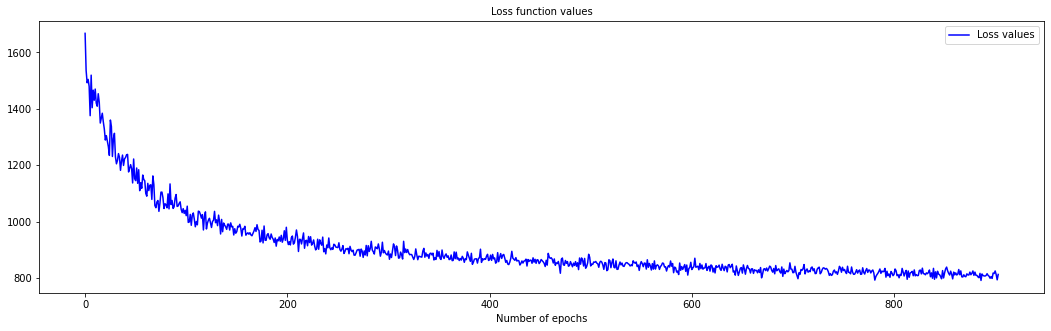

In [87]:
display_loss_values(nmtlr.model)

#### Tuning DeepSurv

In [88]:
deepsurv = DeepSurv()
deepsurv.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)

% Completion: 100%|***********************************************|Loss: 943.20
% Completion: 100%|***********************************************|Loss: 750.57
% Completion: 100%|***********************************************|Loss: 723.57
% Completion: 100%|***********************************************|Loss: 991.47
% Completion: 100%|***********************************************|Loss: 715.22
% Completion: 100%|***********************************************|Loss: 785.31
% Completion: 100%|***********************************************|Loss: 923.56
% Completion: 100%|***********************************************|Loss: 748.30
% Completion: 100%|***********************************************|Loss: 751.78
% Completion: 100%|***********************************************|Loss: 908.42
% Completion: 100%|***********************************************|Loss: 777.82
% Completion: 100%|***********************************************|Loss: 770.94
% Completion: 100%|*********************

Number 5 thread ... mean_c_index:  0.6096628833944152 is the best so far


% Completion: 100%|***********************************************|Loss: 752.78


Number 10 thread ... mean_c_index:  0.7201551805852628 is the best so far


% Completion: 100%|***********************************************|Loss: 768.85
% Completion: 100%|***********************************************|Loss: 766.23
% Completion: 100%|***********************************************|Loss: 640.04
% Completion: 100%|***********************************************|Loss: 730.21
% Completion: 100%|***********************************************|Loss: 409.23
% Completion: 100%|***********************************************|Loss: 785.16


Number 4 thread ... mean_c_index:  0.7293221918556974 is the best so far


% Completion: 100%|***********************************************|Loss: 773.01
% Completion: 100%|***********************************************|Loss: 754.20
% Completion: 100%|***********************************************|Loss: 435.04
% Completion: 100%|***********************************************|Loss: 795.42
% Completion: 100%|***********************************************|Loss: 771.03
% Completion: 100%|***********************************************|Loss: 606.85
% Completion: 100%|***********************************************|Loss: 770.61
% Completion: 100%|***********************************************|Loss: 735.73


Number 3 thread ... mean_c_index:  0.7316739769856401 is the best so far


% Completion: 100%|***********************************************|Loss: 401.84
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 777.98
% Completion: 100%|***********************************************|Loss: 802.53
% Completion: 100%|***********************************************|Loss: 647.29
% Completion: 100%|***********************************************|Loss: 485.97
% Completion: 100%|***********************************************|Loss: 289.74
% Completion: 100%|***********************************************|Loss: 724.15


Number 9 thread ... mean_c_index:  0.7300788463681835 


% Completion: 100%|***********************************************|Loss: 449.55
% Completion: 100%|***********************************************|Loss: 670.96
% Completion: 100%|***********************************************|Loss: 799.57
% Completion: 100%|***********************************************|Loss: 476.15
% Completion: 100%|***********************************************|Loss: 595.54


Number 7 thread ... mean_c_index:  0.6896979586676057 


% Completion: 100%|***********************************************|Loss: 767.21


Number 6 thread ... mean_c_index:  0.7355020079147614 is the best so far


% Completion: 100%|***********************************************|Loss: 409.53
% Completion: 100%|***********************************************|Loss: 500.19
% Completion: 100%|***********************************************|Loss: 422.59


Number 1 thread ... mean_c_index:  0.654024984213651 


% Completion: 100%|***********************************************|Loss: 253.00
% Completion: 100%|***********************************************|Loss: 453.91


Number 8 thread ... mean_c_index:  0.6452281995288732 


% Completion: 100%|***********************************************|Loss: 313.06
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 241.86
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 301.24


Number 2 thread ... mean_c_index:  0.599259959221357 
{'total iteration': 11, 'best_param': {'structure': [{'activation': 'Hardtanh', 'num_units': 8}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeakyReLU', 'num_units': 89}, {'activation': 'Softsign', 'num_units': 37}, {'activation': 'Softplus', 'num_units': 32}], 'optimizer': 'sgd', 'lr': 0.00028, 'num_epochs': 3707, 'dropout': 0.4, 'l2_reg': 0.0072, 'batch_normalization': False}, 'best_score': 0.7355020079147614}


% Completion: 100%|***********************************************|Loss: 841.37
% Completion: 100%|***********************************************|Loss: 898.07
% Completion: 100%|***********************************************|Loss: 882.47
% Completion:  26%|************                                   |Loss: 842.46
% Completion: 100%|***********************************************|Loss: 838.46
% Completion: 100%|***********************************************|Loss: 483.80
% Completion: 100%|***********************************************|Loss: 832.28
% Completion: 100%|***********************************************|Loss: 825.74
% Completion: 100%|***********************************************|Loss: 606.00
% Completion:  44%|********************                           |Loss: 882.52
% Completion: 100%|***********************************************|Loss: 903.57


Number 18 thread ... mean_c_index:  0.6346471240268192 


% Completion: 100%|***********************************************|Loss: 880.21
% Completion: 100%|***********************************************|Loss: 812.35
% Completion: 100%|***********************************************|Loss: 519.66
% Completion: 100%|***********************************************|Loss: 888.60
% Completion: 100%|***********************************************|Loss: 596.84
% Completion: 100%|***********************************************|Loss: 845.72
% Completion: 100%|***********************************************|Loss: 818.17


Number 19 thread ... mean_c_index:  0.5595321817274473 


% Completion: 100%|***********************************************|Loss: 544.23
% Completion: 100%|***********************************************|Loss: 791.77


Number 16 thread ... mean_c_index:  0.7382048554732121 is the best so far


% Completion: 100%|***********************************************|Loss: 700.07
% Completion: 100%|***********************************************|Loss: 655.61
% Completion: 100%|***********************************************|Loss: 497.00
% Completion: 100%|***********************************************|Loss: 664.93
% Completion: 100%|***********************************************|Loss: 550.01


Number 13 thread ... mean_c_index:  0.6410228660003738 


% Completion: 100%|***********************************************|Loss: 498.04
% Completion:  63%|*****************************                  |Loss: 388.79


Number 17 thread ... mean_c_index:  0.6613661602008577 


% Completion: 100%|***********************************************|Loss: 728.33
% Completion: 100%|***********************************************|Loss: 360.98
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 780.69
% Completion: 100%|***********************************************|Loss: 691.31
% Completion: 100%|***********************************************|Loss: 459.56
% Completion: 100%|***********************************************|Loss: 713.53
% Completion: 100%|***********************************************|Loss: 703.87
% Completion: 100%|***********************************************|Loss: 697.14


Number 11 thread ... mean_c_index:  0.6979806105718227 


% Completion: 100%|***********************************************|Loss: 478.53
% Completion: 100%|***********************************************|Loss: 301.61
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 800.52
% Completion: 100%|***********************************************|Loss: 511.65
% Completion: 100%|***********************************************|Loss: 518.70


Number 20 thread ... mean_c_index:  0.629831423380033 


% Completion: 100%|***********************************************|Loss: 382.37
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 751.41
% Completion: 100%|***********************************************|Loss: 754.05
% Completion: 100%|***********************************************|Loss: 356.00
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 822.77
% Completion: 100%|***********************************************|Loss: 344.08
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow en

Number 14 thread ... mean_c_index:  0.6326849834362062 


% Completion: 100%|***********************************************|Loss: 749.94
Exception in thread Thread-1019:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1875006396.py", line 35, in cv
  File "/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/metrics.py", line 65, in concordance_index
    risk, T, E = utils.check_data(risk, T, E)
  File "/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/__init__.py", line 71, in check_data
    raise ValueError(error)
ValueError: The #1 argument contains

Number 12 thread ... mean_c_index:  0.7378537719711397 
{'total iteration': 21, 'best_param': {'structure': [{'activation': 'Softplus', 'num_units': 12}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Softmax', 'num_units': 23}, {'activation': 'Tanh', 'num_units': 13}], 'optimizer': 'rmsprop', 'lr': 0.00095, 'num_epochs': 422, 'dropout': 0.1, 'l2_reg': 0.0026, 'batch_normalization': False}, 'best_score': 0.7382048554732121}


% Completion: 100%|***********************************************|Loss: 858.21
% Completion: 100%|***********************************************|Loss: 845.90
% Completion: 100%|***********************************************|Loss: 757.03
% Completion: 100%|***********************************************|Loss: 746.26
% Completion: 100%|***********************************************|Loss: 838.10
% Completion: 100%|***********************************************|Loss: 702.42
% Completion: 100%|***********************************************|Loss: 849.44
% Completion: 100%|***********************************************|Loss: 779.67
% Completion: 100%|***********************************************|Loss: 805.38
% Completion: 100%|***********************************************|Loss: 854.50


Number 27 thread ... mean_c_index:  0.6916353617054167 


% Completion: 100%|***********************************************|Loss: 856.90
% Completion: 100%|***********************************************|Loss: 785.60
% Completion: 100%|***********************************************|Loss: 755.27
% Completion: 100%|***********************************************|Loss: 768.89
% Completion: 100%|***********************************************|Loss: 679.97
% Completion: 100%|***********************************************|Loss: 773.93
% Completion: 100%|***********************************************|Loss: 761.25
% Completion: 100%|***********************************************|Loss: 744.15
% Completion: 100%|***********************************************|Loss: 648.59
% Completion: 100%|***********************************************|Loss: 709.55
% Completion: 100%|***********************************************|Loss: 830.02
% Completion: 100%|***********************************************|Loss: 763.36
% Completion: 100%|*********************

Number 21 thread ... mean_c_index:  0.7325594780854221 


% Completion: 100%|***********************************************|Loss: 809.42


Number 26 thread ... mean_c_index:  0.7355639346286136 


% Completion: 100%|***********************************************|Loss: 796.68
% Completion: 100%|***********************************************|Loss: 729.14
% Completion: 100%|***********************************************|Loss: 760.37
% Completion: 100%|***********************************************|Loss: 816.47
% Completion: 100%|***********************************************|Loss: 695.56


Number 25 thread ... mean_c_index:  0.6743395436807106 


% Completion: 100%|***********************************************|Loss: 796.35
% Completion: 100%|***********************************************|Loss: 636.67
% Completion: 100%|***********************************************|Loss: 778.59
% Completion: 100%|***********************************************|Loss: 816.88
% Completion: 100%|***********************************************|Loss: 392.70
% Completion: 100%|***********************************************|Loss: 761.69
% Completion: 100%|***********************************************|Loss: 741.78
% Completion: 100%|***********************************************|Loss: 823.88


Number 28 thread ... mean_c_index:  0.6785908030806302 


% Completion: 100%|***********************************************|Loss: 619.04
% Completion: 100%|***********************************************|Loss: 788.09


Number 23 thread ... mean_c_index:  0.7537388950345502 is the best so far


% Completion: 100%|***********************************************|Loss: 811.24
% Completion: 100%|***********************************************|Loss: 788.36
% Completion: 100%|***********************************************|Loss: 764.48


Number 24 thread ... mean_c_index:  0.71248092131426 


% Completion: 100%|***********************************************|Loss: 542.27
% Completion: 100%|***********************************************|Loss: 749.00
% Completion: 100%|***********************************************|Loss: 359.67
% Completion: 100%|***********************************************|Loss: 577.42


Number 30 thread ... mean_c_index:  0.6824225501284424 


% Completion: 100%|***********************************************|Loss: 769.67


Number 29 thread ... mean_c_index:  0.7402911791214415 


% Completion: 100%|***********************************************|Loss: 407.22
% Completion: 100%|***********************************************|Loss: 386.19
% Completion: 100%|***********************************************|Loss: 365.89


Number 22 thread ... mean_c_index:  0.5978768936004846 
{'total iteration': 31, 'best_param': {'structure': [{'activation': 'Sigmoid', 'num_units': 77}], 'optimizer': 'adamax', 'lr': 0.00043, 'num_epochs': 4030, 'dropout': 0.4, 'l2_reg': 0.0068, 'batch_normalization': False}, 'best_score': 0.7537388950345502}


% Completion: 100%|***********************************************|Loss: 826.63
% Completion: 100%|***********************************************|Loss: 794.85
% Completion: 100%|***********************************************|Loss: 873.20
% Completion: 100%|***********************************************|Loss: 808.84
% Completion: 100%|***********************************************|Loss: 811.10


Number 39 thread ... mean_c_index:  0.6944975658366316 


% Completion: 100%|***********************************************|Loss: 766.00
% Completion: 100%|***********************************************|Loss: 768.32
% Completion: 100%|***********************************************|Loss: 497.31
% Completion: 100%|***********************************************|Loss: 780.18
% Completion: 100%|***********************************************|Loss: 577.14
% Completion: 100%|***********************************************|Loss: 777.74
% Completion: 100%|***********************************************|Loss: 810.14
% Completion: 100%|***********************************************|Loss: 828.99
Exception in thread Thread-1038:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", l

Number 40 thread ... mean_c_index:  0.7241183586639734 


% Completion: 100%|***********************************************|Loss: 820.18


Number 32 thread ... mean_c_index:  0.7520840640240375 


% Completion: 100%|***********************************************|Loss: 470.24
% Completion: 100%|***********************************************|Loss: 555.28
% Completion: 100%|***********************************************|Loss: 753.54
% Completion: 100%|***********************************************|Loss: 536.38
% Completion: 100%|***********************************************|Loss: 474.55


Number 36 thread ... mean_c_index:  0.5495402426415217 


% Completion: 100%|***********************************************|Loss: 750.69
% Completion: 100%|***********************************************|Loss: 572.54
% Completion: 100%|***********************************************|Loss: 290.00
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 861.13
% Completion: 100%|***********************************************|Loss: 519.55
% Completion: 100%|***********************************************|Loss: 764.20
% Completion: 100%|***********************************************|Loss: 591.79


Number 37 thread ... mean_c_index:  0.6889796279666285 


% Completion: 100%|***********************************************|Loss: 839.72


Number 31 thread ... mean_c_index:  0.7544951285744613 is the best so far


% Completion: 100%|***********************************************|Loss: 491.82


Number 33 thread ... mean_c_index:  0.656383800191694 


% Completion: 100%|***********************************************|Loss: 756.25


Number 35 thread ... mean_c_index:  0.7269030188589418 


% Completion: 100%|***********************************************|Loss: 341.16
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 274.97
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 331.81
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 38 thread ... mean_c_index:  0.6157010972725943 
{'total iteration': 41, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 89}, {'activation': 'LogLog', 'num_units': 59}, {'activation': 'ReLU', 'num_units': 97}, {'activation': 'Softsign', 'num_units': 96}, {'activation': 'CosReLU', 'num_units': 90}], 'optimizer': 'adagrad', 'lr': 0.00055, 'num_epochs': 3446, 'dropout': 0.2, 'l2_reg': 0.0081, 'batch_normalization': False}, 'best_score': 0.7544951285744613}


% Completion: 100%|***********************************************|Loss: 753.91
% Completion: 100%|***********************************************|Loss: 826.17
% Completion: 100%|***********************************************|Loss: 883.80
% Completion: 100%|***********************************************|Loss: 753.82
% Completion: 100%|***********************************************|Loss: 759.07
% Completion: 100%|***********************************************|Loss: 768.70


Number 45 thread ... mean_c_index:  0.7273072798545679 


% Completion: 100%|***********************************************|Loss: 863.52
% Completion: 100%|***********************************************|Loss: 822.01
% Completion: 100%|***********************************************|Loss: 829.27
% Completion: 100%|***********************************************|Loss: 821.09
% Completion: 100%|***********************************************|Loss: 643.44
% Completion: 100%|***********************************************|Loss: 859.76


Number 44 thread ... mean_c_index:  0.5532394939401015 


% Completion: 100%|***********************************************|Loss: 817.00
% Completion: 100%|***********************************************|Loss: 754.34
% Completion: 100%|***********************************************|Loss: 792.93
% Completion: 100%|***********************************************|Loss: 653.28
% Completion: 100%|***********************************************|Loss: 769.35
% Completion: 100%|***********************************************|Loss: 802.99
% Completion: 100%|***********************************************|Loss: 625.12
% Completion: 100%|***********************************************|Loss: 804.40


Number 46 thread ... mean_c_index:  0.7397825679213981 


% Completion: 100%|***********************************************|Loss: 789.95
% Completion: 100%|***********************************************|Loss: 749.34
% Completion:   3%|*                                              |Loss: 761.35
% Completion: 100%|***********************************************|Loss: 628.68
% Completion: 100%|***********************************************|Loss: 775.23
% Completion: 100%|***********************************************|Loss: 601.73
% Completion: 100%|***********************************************|Loss: 590.54
% Completion: 100%|***********************************************|Loss: 652.40


Number 50 thread ... mean_c_index:  0.696232600419241 


% Completion: 100%|***********************************************|Loss: 701.65
% Completion: 100%|***********************************************|Loss: 736.10
% Completion: 100%|***********************************************|Loss: 778.05
% Completion: 100%|***********************************************|Loss: 749.27
% Completion: 100%|***********************************************|Loss: 564.21
% Completion: 100%|***********************************************|Loss: 668.53
% Completion: 100%|***********************************************|Loss: 777.65
% Completion: 100%|***********************************************|Loss: 736.61


Number 48 thread ... mean_c_index:  0.7176079705573437 


% Completion: 100%|***********************************************|Loss: 499.28
% Completion: 100%|***********************************************|Loss: 786.28


Number 41 thread ... mean_c_index:  0.7345014471792748 


% Completion: 100%|***********************************************|Loss: 814.43
% Completion:  13%|******                                         |Loss: 835.52
% Completion: 100%|***********************************************|Loss: 662.71
% Completion: 100%|***********************************************|Loss: 778.82
% Completion: 100%|***********************************************|Loss: 553.00
% Completion: 100%|***********************************************|Loss: 531.03
% Completion: 100%|***********************************************|Loss: 677.50
% Completion: 100%|***********************************************|Loss: 837.61


Number 42 thread ... mean_c_index:  0.7329881038506612 


% Completion: 100%|***********************************************|Loss: 657.35


Number 43 thread ... mean_c_index:  0.70373318474655 


% Completion: 100%|***********************************************|Loss: 505.69


Number 49 thread ... mean_c_index:  0.6422574111976271 


% Completion: 100%|***********************************************|Loss: 544.53
% Completion: 100%|***********************************************|Loss: 532.29


Number 47 thread ... mean_c_index:  0.6811780774821055 
{'total iteration': 51, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 89}, {'activation': 'LogLog', 'num_units': 59}, {'activation': 'ReLU', 'num_units': 97}, {'activation': 'Softsign', 'num_units': 96}, {'activation': 'CosReLU', 'num_units': 90}], 'optimizer': 'adagrad', 'lr': 0.00055, 'num_epochs': 3446, 'dropout': 0.2, 'l2_reg': 0.0081, 'batch_normalization': False}, 'best_score': 0.7544951285744613}


% Completion: 100%|***********************************************|Loss: 871.27
% Completion: 100%|***********************************************|Loss: 825.71
% Completion: 100%|***********************************************|Loss: 762.55
% Completion: 100%|***********************************************|Loss: 814.87
% Completion: 100%|***********************************************|Loss: 873.90
% Completion: 100%|***********************************************|Loss: 706.18
% Completion: 100%|***********************************************|Loss: 852.25
% Completion: 100%|***********************************************|Loss: 879.15


Number 51 thread ... mean_c_index:  0.5912910681293043 


% Completion: 100%|***********************************************|Loss: 760.00
% Completion: 100%|***********************************************|Loss: 874.96
% Completion: 100%|***********************************************|Loss: 591.60
% Completion: 100%|***********************************************|Loss: 780.95
% Completion: 100%|***********************************************|Loss: 725.17
% Completion: 100%|***********************************************|Loss: 859.95
% Completion: 100%|***********************************************|Loss: 739.20
% Completion: 100%|***********************************************|Loss: 799.09
% Completion: 100%|***********************************************|Loss: 770.42
% Completion: 100%|***********************************************|Loss: 803.39
% Completion: 100%|***********************************************|Loss: 894.47
% Completion: 100%|***********************************************|Loss: 862.14
% Completion: 100%|*********************

Number 55 thread ... mean_c_index:  0.7381253587680792 


% Completion: 100%|***********************************************|Loss: 789.05


Number 53 thread ... mean_c_index:  0.6013262221557867 


% Completion: 100%|***********************************************|Loss: 758.21


Number 59 thread ... mean_c_index:  0.7228686908986406 


% Completion: 100%|***********************************************|Loss: 554.79
% Completion: 100%|***********************************************|Loss: 811.83
% Completion: 100%|***********************************************|Loss: 745.89
% Completion: 100%|***********************************************|Loss: 858.07
% Completion: 100%|***********************************************|Loss: 265.27
% Completion: 100%|***********************************************|Loss: 586.99
% Completion: 100%|***********************************************|Loss: 771.73
% Completion: 100%|***********************************************|Loss: 775.95
% Completion: 100%|***********************************************|Loss: 538.62


Number 52 thread ... mean_c_index:  0.6826769137890747 


% Completion: 100%|***********************************************|Loss: 785.82
% Completion: 100%|***********************************************|Loss: 862.65
% Completion: 100%|***********************************************|Loss: 767.82
% Completion: 100%|***********************************************|Loss: 847.83
% Completion: 100%|***********************************************|Loss: 780.61
% Completion: 100%|***********************************************|Loss: 883.35
% Completion: 100%|***********************************************|Loss: 148.40
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 746.77
% Completion: 100%|***********************************************|Loss: 850.49


Number 56 thread ... mean_c_index:  0.749020656595741 


% Completion: 100%|***********************************************|Loss: 749.44


Number 57 thread ... mean_c_index:  0.7198934125169729 


% Completion: 100%|***********************************************|Loss: 763.89


Number 60 thread ... mean_c_index:  0.7382612896492704 


% Completion: 100%|***********************************************|Loss: 802.25


Number 54 thread ... mean_c_index:  0.6346585099529289 


% Completion: 100%|***********************************************|Loss: 189.45
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 201.36
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 58 thread ... mean_c_index:  0.5876394374300553 
{'total iteration': 61, 'best_param': {'structure': [{'activation': 'Atan', 'num_units': 89}, {'activation': 'LogLog', 'num_units': 59}, {'activation': 'ReLU', 'num_units': 97}, {'activation': 'Softsign', 'num_units': 96}, {'activation': 'CosReLU', 'num_units': 90}], 'optimizer': 'adagrad', 'lr': 0.00055, 'num_epochs': 3446, 'dropout': 0.2, 'l2_reg': 0.0081, 'batch_normalization': False}, 'best_score': 0.7544951285744613}


% Completion: 100%|***********************************************|Loss: 844.54
% Completion: 100%|***********************************************|Loss: 796.45
% Completion: 100%|***********************************************|Loss: 729.62
% Completion: 100%|***********************************************|Loss: 842.80
% Completion: 100%|***********************************************|Loss: 777.38
% Completion: 100%|***********************************************|Loss: 834.00
% Completion: 100%|***********************************************|Loss: 869.50


Number 61 thread ... mean_c_index:  0.6219903718862315 


% Completion: 100%|***********************************************|Loss: 766.72
% Completion: 100%|***********************************************|Loss: 809.58
% Completion: 100%|***********************************************|Loss: 890.15
% Completion: 100%|***********************************************|Loss: 853.94
% Completion: 100%|***********************************************|Loss: 630.20
% Completion: 100%|***********************************************|Loss: 850.89
% Completion: 100%|***********************************************|Loss: 806.14
% Completion: 100%|***********************************************|Loss: 771.99
% Completion: 100%|***********************************************|Loss: 796.83
% Completion: 100%|***********************************************|Loss: 761.31
% Completion: 100%|***********************************************|Loss: 814.08
% Completion: 100%|***********************************************|Loss: 760.35
% Completion: 100%|*********************

Number 67 thread ... mean_c_index:  0.7272773226505629 


% Completion: 100%|***********************************************|Loss: 845.21
% Completion: 100%|***********************************************|Loss: 821.89
% Completion: 100%|***********************************************|Loss: 782.69


Number 66 thread ... mean_c_index:  0.7407375438217305 


% Completion: 100%|***********************************************|Loss: 829.83
% Completion: 100%|***********************************************|Loss: 752.63
% Completion: 100%|***********************************************|Loss: 835.48
% Completion: 100%|***********************************************|Loss: 609.27
% Completion: 100%|***********************************************|Loss: 866.73
% Completion: 100%|***********************************************|Loss: 814.41
% Completion: 100%|***********************************************|Loss: 843.38
% Completion: 100%|***********************************************|Loss: 749.25
% Completion: 100%|***********************************************|Loss: 818.45
% Completion: 100%|***********************************************|Loss: 778.23
% Completion: 100%|***********************************************|Loss: 580.71
% Completion: 100%|***********************************************|Loss: 784.36


Number 62 thread ... mean_c_index:  0.7480863414134235 


% Completion: 100%|***********************************************|Loss: 834.86
% Completion: 100%|***********************************************|Loss: 914.00


Number 70 thread ... mean_c_index:  0.5560026595490506 


% Completion: 100%|***********************************************|Loss: 835.06
% Completion: 100%|***********************************************|Loss: 786.25
% Completion: 100%|***********************************************|Loss: 791.84
% Completion: 100%|***********************************************|Loss: 554.82


Number 64 thread ... mean_c_index:  0.6731091624397718 


% Completion: 100%|***********************************************|Loss: 866.53


Number 69 thread ... mean_c_index:  0.603609931621631 


% Completion: 100%|***********************************************|Loss: 812.43


Number 65 thread ... mean_c_index:  0.5637265771422435 


% Completion: 100%|***********************************************|Loss: 805.76
% Completion: 100%|***********************************************|Loss: 809.54


Number 63 thread ... mean_c_index:  0.7575837023873082 is the best so far


% Completion: 100%|***********************************************|Loss: 794.74


Number 68 thread ... mean_c_index:  0.7393469862239017 
{'total iteration': 71, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 704.71
% Completion: 100%|***********************************************|Loss: 687.83
% Completion: 100%|***********************************************|Loss: 714.17
% Completion: 100%|***********************************************|Loss: 786.64
% Completion: 100%|***********************************************|Loss: 635.44
% Completion: 100%|***********************************************|Loss: 683.54
% Completion: 100%|***********************************************|Loss: 642.71
% Completion: 100%|***********************************************|Loss: 689.76
% Completion: 100%|***********************************************|Loss: 601.09
% Completion: 100%|***********************************************|Loss: 728.68
% Completion: 100%|***********************************************|Loss: 778.60
% Completion: 100%|***********************************************|Loss: 694.86


Number 72 thread ... mean_c_index:  0.6737798229317817 


% Completion: 100%|***********************************************|Loss: 742.44
% Completion: 100%|***********************************************|Loss: 648.14
% Completion: 100%|***********************************************|Loss: 696.32


Number 73 thread ... mean_c_index:  0.6777763150002498 


% Completion: 100%|***********************************************|Loss: 709.61
% Completion: 100%|***********************************************|Loss: 592.29
% Completion: 100%|***********************************************|Loss: 670.90
% Completion: 100%|***********************************************|Loss: 687.28
% Completion: 100%|***********************************************|Loss: 808.39
% Completion: 100%|***********************************************|Loss: 761.59
% Completion: 100%|***********************************************|Loss: 774.19
% Completion: 100%|***********************************************|Loss: 652.33
% Completion: 100%|***********************************************|Loss: 669.10
% Completion: 100%|***********************************************|Loss: 778.54


Number 75 thread ... mean_c_index:  0.7308735833308876 


% Completion: 100%|***********************************************|Loss: 698.31
% Completion: 100%|***********************************************|Loss: 868.67
% Completion: 100%|***********************************************|Loss: 590.77
% Completion: 100%|***********************************************|Loss: 658.59
% Completion: 100%|***********************************************|Loss: 713.37
% Completion: 100%|***********************************************|Loss: 740.69
% Completion: 100%|***********************************************|Loss: 777.34
% Completion: 100%|***********************************************|Loss: 712.88
% Completion: 100%|***********************************************|Loss: 611.80


Number 76 thread ... mean_c_index:  0.6519948358107713 


% Completion: 100%|***********************************************|Loss: 747.08


Number 79 thread ... mean_c_index:  0.6927737566341066 


% Completion: 100%|***********************************************|Loss: 713.09
% Completion: 100%|***********************************************|Loss: 542.25
% Completion: 100%|***********************************************|Loss: 727.81
% Completion: 100%|***********************************************|Loss: 815.31
% Completion: 100%|***********************************************|Loss: 754.52


Number 74 thread ... mean_c_index:  0.7064235361534642 


% Completion: 100%|***********************************************|Loss: 851.09
% Completion: 100%|***********************************************|Loss: 576.26
% Completion: 100%|***********************************************|Loss: 738.67
% Completion: 100%|***********************************************|Loss: 756.28
% Completion: 100%|***********************************************|Loss: 713.41
% Completion: 100%|***********************************************|Loss: 630.66


Number 77 thread ... mean_c_index:  0.6987939202923716 
Number 80 thread ... mean_c_index:  0.662997363581669 


% Completion: 100%|***********************************************|Loss: 773.80


Number 78 thread ... mean_c_index:  0.7446731341970938 


% Completion: 100%|***********************************************|Loss: 825.80
% Completion: 100%|***********************************************|Loss: 861.84
% Completion: 100%|***********************************************|Loss: 854.18


Number 71 thread ... mean_c_index:  0.693088557074792 
{'total iteration': 81, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 842.79
% Completion: 100%|***********************************************|Loss: 774.44
% Completion: 100%|***********************************************|Loss: 874.21
% Completion: 100%|***********************************************|Loss: 869.74
% Completion: 100%|***********************************************|Loss: 707.75
% Completion: 100%|***********************************************|Loss: 863.84


Number 90 thread ... mean_c_index:  0.6418365120040528 


% Completion: 100%|***********************************************|Loss: 979.77
% Completion: 100%|***********************************************|Loss: 814.90
% Completion: 100%|***********************************************|Loss: 723.26
% Completion: 100%|***********************************************|Loss: 847.35
% Completion: 100%|***********************************************|Loss: 707.75
% Completion: 100%|***********************************************|Loss: 735.82
% Completion:  67%|*******************************               |Loss: 1002.63
% Completion: 100%|***********************************************|Loss: 694.88
% Completion: 100%|***********************************************|Loss: 947.60
% Completion: 100%|***********************************************|Loss: 677.56


Number 88 thread ... mean_c_index:  0.6885553863026513 


% Completion: 100%|**********************************************|Loss: 1005.96
% Completion: 100%|***********************************************|Loss: 772.21
% Completion: 100%|***********************************************|Loss: 686.88
% Completion: 100%|***********************************************|Loss: 742.08
% Completion: 100%|***********************************************|Loss: 867.03


Number 87 thread ... mean_c_index:  0.6201988081579911 


% Completion: 100%|***********************************************|Loss: 754.93
% Completion: 100%|***********************************************|Loss: 784.72
% Completion: 100%|***********************************************|Loss: 453.53
% Completion: 100%|***********************************************|Loss: 782.19
% Completion: 100%|***********************************************|Loss: 784.71


Number 82 thread ... mean_c_index:  0.7484606115849735 


% Completion: 100%|***********************************************|Loss: 652.12
% Completion: 100%|***********************************************|Loss: 767.69
% Completion: 100%|***********************************************|Loss: 449.33
% Completion: 100%|***********************************************|Loss: 737.15


Number 81 thread ... mean_c_index:  0.7126600724428449 


% Completion: 100%|***********************************************|Loss: 736.85
% Completion: 100%|***********************************************|Loss: 729.51
% Completion: 100%|***********************************************|Loss: 436.51
% Completion: 100%|***********************************************|Loss: 613.12
% Completion: 100%|***********************************************|Loss: 709.27
% Completion: 100%|***********************************************|Loss: 771.00
% Completion: 100%|***********************************************|Loss: 713.07


Number 85 thread ... mean_c_index:  0.7105420928913277 


% Completion: 100%|***********************************************|Loss: 441.79
% Completion: 100%|***********************************************|Loss: 426.02
% Completion: 100%|***********************************************|Loss: 707.57
% Completion: 100%|***********************************************|Loss: 413.72
% Completion: 100%|***********************************************|Loss: 637.84
% Completion: 100%|***********************************************|Loss: 450.16
% Completion: 100%|***********************************************|Loss: 742.11


Number 84 thread ... mean_c_index:  0.6644407517052138 


% Completion: 100%|***********************************************|Loss: 440.27


Number 83 thread ... mean_c_index:  0.6994865363872315 


% Completion: 100%|***********************************************|Loss: 487.32
% Completion: 100%|***********************************************|Loss: 650.66
% Completion: 100%|***********************************************|Loss: 455.50


Number 89 thread ... mean_c_index:  0.6591646906723027 


% Completion: 100%|***********************************************|Loss: 683.68
% Completion: 100%|***********************************************|Loss: 692.96


Number 86 thread ... mean_c_index:  0.6810421320222122 
{'total iteration': 91, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 774.29
% Completion: 100%|***********************************************|Loss: 775.31
% Completion: 100%|***********************************************|Loss: 870.11
% Completion: 100%|***********************************************|Loss: 529.29
% Completion: 100%|**********************************************|Loss: 1027.58
% Completion: 100%|***********************************************|Loss: 742.71
% Completion: 100%|***********************************************|Loss: 765.58
% Completion: 100%|***********************************************|Loss: 752.22
% Completion: 100%|***********************************************|Loss: 790.83


Number 94 thread ... mean_c_index:  0.7416592140355721 


% Completion: 100%|***********************************************|Loss: 844.20
% Completion: 100%|***********************************************|Loss: 895.12
% Completion: 100%|***********************************************|Loss: 400.58
% Completion: 100%|***********************************************|Loss: 902.86
% Completion: 100%|***********************************************|Loss: 703.22
% Completion: 100%|***********************************************|Loss: 815.18
% Completion: 100%|***********************************************|Loss: 467.81
% Completion: 100%|***********************************************|Loss: 417.40
% Completion: 100%|***********************************************|Loss: 909.59
% Completion: 100%|***********************************************|Loss: 285.01
% Completion: 100%|***********************************************|Loss: 830.28
% Completion: 100%|***********************************************|Loss: 824.81
% Completion: 100%|*********************

Number 98 thread ... mean_c_index:  0.7384620528279944 


% Completion: 100%|***********************************************|Loss: 469.24


Number 99 thread ... mean_c_index:  0.6248187798692229 


% Completion: 100%|***********************************************|Loss: 949.58


Number 97 thread ... mean_c_index:  0.5286347303962527 


% Completion: 100%|***********************************************|Loss: 744.44
% Completion: 100%|***********************************************|Loss: 826.84
% Completion: 100%|***********************************************|Loss: 430.20
% Completion: 100%|***********************************************|Loss: 225.93
% Completion: 100%|***********************************************|Loss: 781.74


Number 95 thread ... mean_c_index:  0.7313951432811955 


% Completion: 100%|***********************************************|Loss: 417.48
% Completion: 100%|***********************************************|Loss: 825.58
% Completion: 100%|***********************************************|Loss: 475.43
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 416.67
% Completion: 100%|***********************************************|Loss: 897.02


Number 96 thread ... mean_c_index:  0.570383457699774 


% Completion: 100%|***********************************************|Loss: 322.48
% Completion: 100%|***********************************************|Loss: 424.34
% Completion: 100%|***********************************************|Loss: 417.55
% Completion: 100%|***********************************************|Loss: 469.68
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 264.76
% Completion: 100%|***********************************************|Loss: 412.38


Number 100 thread ... mean_c_index:  0.5873038128977954 


% Completion: 100%|***********************************************|Loss: 462.09
% Completion: 100%|***********************************************|Loss: 226.01


Number 93 thread ... mean_c_index:  0.6253537557083748 


% Completion: 100%|***********************************************|Loss: 509.30
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 430.64


Number 92 thread ... mean_c_index:  0.6395024705685577 


% Completion: 100%|***********************************************|Loss: 445.20
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 91 thread ... mean_c_index:  0.5564652895363159 
{'total iteration': 101, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 660.29
% Completion: 100%|***********************************************|Loss: 831.09
% Completion: 100%|***********************************************|Loss: 634.09
% Completion: 100%|***********************************************|Loss: 702.20
% Completion: 100%|***********************************************|Loss: 878.43
% Completion: 100%|***********************************************|Loss: 658.75
% Completion: 100%|***********************************************|Loss: 823.53
% Completion: 100%|***********************************************|Loss: 683.16


Number 105 thread ... mean_c_index:  0.6858101547161892 


% Completion: 100%|***********************************************|Loss: 975.32
% Completion: 100%|***********************************************|Loss: 851.58
% Completion: 100%|***********************************************|Loss: 519.65
% Completion: 100%|***********************************************|Loss: 994.50
% Completion: 100%|***********************************************|Loss: 749.78
% Completion: 100%|***********************************************|Loss: 765.39
% Completion: 100%|***********************************************|Loss: 932.68


Number 106 thread ... mean_c_index:  0.5497811274039768 


% Completion: 100%|***********************************************|Loss: 907.31
% Completion: 100%|***********************************************|Loss: 630.05
% Completion: 100%|***********************************************|Loss: 862.81
% Completion: 100%|***********************************************|Loss: 764.72
% Completion: 100%|***********************************************|Loss: 535.51
% Completion: 100%|***********************************************|Loss: 544.63
% Completion: 100%|***********************************************|Loss: 778.01
% Completion: 100%|***********************************************|Loss: 776.86
% Completion: 100%|***********************************************|Loss: 832.05
% Completion: 100%|***********************************************|Loss: 825.30
% Completion: 100%|***********************************************|Loss: 366.90
% Completion: 100%|***********************************************|Loss: 561.37
% Completion: 100%|*********************

Number 101 thread ... mean_c_index:  0.7358905986637995 


% Completion: 100%|***********************************************|Loss: 774.74
% Completion: 100%|***********************************************|Loss: 893.52
% Completion: 100%|***********************************************|Loss: 893.50
% Completion: 100%|***********************************************|Loss: 528.90
% Completion: 100%|***********************************************|Loss: 537.79
% Completion: 100%|***********************************************|Loss: 509.26
% Completion: 100%|***********************************************|Loss: 827.28


Number 103 thread ... mean_c_index:  0.6200364351251804 


% Completion: 100%|***********************************************|Loss: 724.98
% Completion: 100%|***********************************************|Loss: 867.70
% Completion: 100%|***********************************************|Loss: 543.73


Number 104 thread ... mean_c_index:  0.6569878206703497 


% Completion: 100%|***********************************************|Loss: 543.65
% Completion: 100%|***********************************************|Loss: 722.88


Number 102 thread ... mean_c_index:  0.719060178924168 


% Completion: 100%|***********************************************|Loss: 443.50
% Completion: 100%|***********************************************|Loss: 862.86


Number 107 thread ... mean_c_index:  0.5269462920833357 


% Completion: 100%|***********************************************|Loss: 485.80
% Completion: 100%|***********************************************|Loss: 543.59
% Completion: 100%|***********************************************|Loss: 537.06


Number 110 thread ... mean_c_index:  0.6639133809693061 


% Completion: 100%|***********************************************|Loss: 561.76


Number 108 thread ... mean_c_index:  0.6602257547411259 


% Completion: 100%|***********************************************|Loss: 442.29
% Completion: 100%|***********************************************|Loss: 466.93
% Completion: 100%|***********************************************|Loss: 586.49


Number 109 thread ... mean_c_index:  0.6851783808541017 
{'total iteration': 111, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 747.70
% Completion: 100%|***********************************************|Loss: 789.60
% Completion: 100%|***********************************************|Loss: 631.27
% Completion: 100%|***********************************************|Loss: 767.54
% Completion: 100%|***********************************************|Loss: 883.33
% Completion: 100%|***********************************************|Loss: 927.55
% Completion: 100%|***********************************************|Loss: 773.53
% Completion: 100%|***********************************************|Loss: 895.29
% Completion: 100%|***********************************************|Loss: 757.44
% Completion: 100%|***********************************************|Loss: 568.30
% Completion: 100%|***********************************************|Loss: 704.93
% Completion: 100%|***********************************************|Loss: 747.37


Number 118 thread ... mean_c_index:  0.7246819861857275 


% Completion: 100%|***********************************************|Loss: 550.10
% Completion: 100%|***********************************************|Loss: 621.67
% Completion: 100%|***********************************************|Loss: 869.42
% Completion: 100%|***********************************************|Loss: 935.02
% Completion: 100%|***********************************************|Loss: 740.93
% Completion: 100%|***********************************************|Loss: 871.22
% Completion: 100%|***********************************************|Loss: 413.09
% Completion: 100%|***********************************************|Loss: 681.37
% Completion: 100%|***********************************************|Loss: 759.64
% Completion: 100%|***********************************************|Loss: 863.36
% Completion: 100%|**********************************************|Loss: 1049.86
% Completion: 100%|***********************************************|Loss: 726.52
% Completion: 100%|*********************

Number 119 thread ... mean_c_index:  0.6166573530814864 


% Completion: 100%|***********************************************|Loss: 779.95
% Completion: 100%|***********************************************|Loss: 771.35
% Completion: 100%|**********************************************|Loss: 1091.27
% Completion: 100%|***********************************************|Loss: 700.55
% Completion: 100%|***********************************************|Loss: 900.21
% Completion: 100%|***********************************************|Loss: 592.65
% Completion: 100%|***********************************************|Loss: 558.99
% Completion: 100%|***********************************************|Loss: 801.04


Number 111 thread ... mean_c_index:  0.5725102732001185 


% Completion: 100%|**********************************************|Loss: 1055.43


Number 117 thread ... mean_c_index:  0.5995872979112532 


% Completion: 100%|***********************************************|Loss: 433.67
% Completion: 100%|***********************************************|Loss: 778.37
% Completion: 100%|***********************************************|Loss: 755.23


Number 116 thread ... mean_c_index:  0.7123096063173749 


% Completion: 100%|***********************************************|Loss: 871.98


Number 112 thread ... mean_c_index:  0.5568992466484228 


% Completion: 100%|***********************************************|Loss: 771.71


Number 114 thread ... mean_c_index:  0.7308805456767227 


% Completion: 100%|***********************************************|Loss: 542.52
% Completion: 100%|***********************************************|Loss: 555.90


Number 120 thread ... mean_c_index:  0.6729410018759875 


% Completion: 100%|***********************************************|Loss: 422.49
% Completion: 100%|***********************************************|Loss: 603.25
% Completion: 100%|***********************************************|Loss: 463.07
% Completion: 100%|***********************************************|Loss: 625.37
% Completion: 100%|***********************************************|Loss: 489.41


Number 115 thread ... mean_c_index:  0.6654542139805886 


% Completion: 100%|***********************************************|Loss: 623.70
% Completion: 100%|***********************************************|Loss: 646.19


Number 113 thread ... mean_c_index:  0.6646221311127698 
{'total iteration': 121, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 738.29
% Completion: 100%|***********************************************|Loss: 857.09
% Completion: 100%|***********************************************|Loss: 809.42
% Completion: 100%|***********************************************|Loss: 775.44
% Completion: 100%|***********************************************|Loss: 746.73
% Completion: 100%|***********************************************|Loss: 605.43
% Completion: 100%|***********************************************|Loss: 856.87
% Completion: 100%|***********************************************|Loss: 715.67
% Completion: 100%|***********************************************|Loss: 735.42
% Completion: 100%|***********************************************|Loss: 792.75
% Completion: 100%|***********************************************|Loss: 708.52
% Completion: 100%|***********************************************|Loss: 739.05
% Completion: 100%|*********************

Number 122 thread ... mean_c_index:  0.7325772172709539 


% Completion:  16%|*******                                        |Loss: 803.08
% Completion: 100%|***********************************************|Loss: 841.52
% Completion: 100%|***********************************************|Loss: 676.47
% Completion:  57%|**************************                     |Loss: 776.63
% Completion: 100%|***********************************************|Loss: 778.24
% Completion: 100%|***********************************************|Loss: 652.44
% Completion:  34%|****************                               |Loss: 786.74


Number 123 thread ... mean_c_index:  0.69105239413223 


% Completion: 100%|***********************************************|Loss: 864.61
% Completion: 100%|***********************************************|Loss: 737.74
% Completion: 100%|***********************************************|Loss: 779.27


Number 129 thread ... mean_c_index:  0.7554753406566658 


% Completion: 100%|***********************************************|Loss: 751.16
% Completion: 100%|***********************************************|Loss: 679.38
% Completion: 100%|***********************************************|Loss: 615.23
% Completion: 100%|***********************************************|Loss: 775.60


Number 128 thread ... mean_c_index:  0.72711219930633 


% Completion: 100%|***********************************************|Loss: 725.73
% Completion: 100%|***********************************************|Loss: 636.75


Number 125 thread ... mean_c_index:  0.6584874171840636 


% Completion: 100%|***********************************************|Loss: 689.42
% Completion: 100%|***********************************************|Loss: 706.13
% Completion: 100%|***********************************************|Loss: 891.64
% Completion: 100%|***********************************************|Loss: 724.92


Number 126 thread ... mean_c_index:  0.7120743620932016 


% Completion: 100%|***********************************************|Loss: 290.16
% Completion: 100%|***********************************************|Loss: 727.42
% Completion: 100%|***********************************************|Loss: 720.92
% Completion: 100%|***********************************************|Loss: 674.90
% Completion: 100%|***********************************************|Loss: 813.45
% Completion: 100%|***********************************************|Loss: 693.10


Number 130 thread ... mean_c_index:  0.7306343849390992 


% Completion: 100%|***********************************************|Loss: 742.63


Number 121 thread ... mean_c_index:  0.7003634008603095 


% Completion: 100%|***********************************************|Loss: 835.25
% Completion: 100%|***********************************************|Loss: 308.54
% Completion: 100%|***********************************************|Loss: 857.96


Number 124 thread ... mean_c_index:  0.5208274344740176 


% Completion: 100%|***********************************************|Loss: 309.68
% Completion: 100%|***********************************************|Loss: 313.12
% Completion: 100%|***********************************************|Loss: 299.97


Number 127 thread ... mean_c_index:  0.5903007375304619 
{'total iteration': 131, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 847.78
% Completion: 100%|***********************************************|Loss: 844.86
% Completion: 100%|***********************************************|Loss: 739.71
% Completion: 100%|***********************************************|Loss: 807.66
% Completion: 100%|***********************************************|Loss: 843.24
% Completion: 100%|***********************************************|Loss: 866.33


Number 133 thread ... mean_c_index:  0.7199047903552371 


% Completion: 100%|***********************************************|Loss: 774.38
% Completion: 100%|***********************************************|Loss: 841.72
% Completion: 100%|***********************************************|Loss: 936.29
% Completion: 100%|***********************************************|Loss: 751.58
% Completion: 100%|***********************************************|Loss: 875.41
% Completion: 100%|***********************************************|Loss: 741.23
% Completion: 100%|***********************************************|Loss: 797.50
% Completion: 100%|***********************************************|Loss: 885.40
% Completion: 100%|***********************************************|Loss: 760.20


Number 137 thread ... mean_c_index:  0.7501925945981583 


% Completion: 100%|***********************************************|Loss: 483.26
% Completion: 100%|***********************************************|Loss: 828.58
% Completion: 100%|***********************************************|Loss: 893.89
% Completion: 100%|***********************************************|Loss: 854.17
% Completion: 100%|***********************************************|Loss: 480.09
% Completion: 100%|***********************************************|Loss: 885.49
% Completion: 100%|***********************************************|Loss: 865.05
% Completion: 100%|***********************************************|Loss: 901.55
% Completion: 100%|***********************************************|Loss: 848.03


Number 136 thread ... mean_c_index:  0.6955681697523667 


% Completion: 100%|***********************************************|Loss: 893.24
% Completion: 100%|***********************************************|Loss: 882.45


Number 139 thread ... mean_c_index:  0.5872473285159796 


% Completion: 100%|***********************************************|Loss: 400.98
% Completion: 100%|***********************************************|Loss: 427.84
% Completion: 100%|***********************************************|Loss: 695.56
% Completion: 100%|***********************************************|Loss: 900.56
% Completion: 100%|***********************************************|Loss: 449.90
% Completion: 100%|***********************************************|Loss: 411.87
% Completion: 100%|***********************************************|Loss: 849.92


Number 132 thread ... mean_c_index:  0.5906356214984877 


% Completion: 100%|***********************************************|Loss: 842.33
% Completion: 100%|***********************************************|Loss: 412.83
% Completion: 100%|***********************************************|Loss: 444.04
% Completion: 100%|***********************************************|Loss: 405.33
% Completion: 100%|***********************************************|Loss: 695.62
% Completion: 100%|***********************************************|Loss: 778.16
% Completion: 100%|***********************************************|Loss: 411.20


Number 135 thread ... mean_c_index:  0.585790035178581 


% Completion: 100%|***********************************************|Loss: 444.13
% Completion: 100%|***********************************************|Loss: 829.20
% Completion: 100%|***********************************************|Loss: 466.65


Number 140 thread ... mean_c_index:  0.6706229470260956 


% Completion: 100%|***********************************************|Loss: 433.50
% Completion: 100%|***********************************************|Loss: 716.42
% Completion: 100%|***********************************************|Loss: 830.32


Number 131 thread ... mean_c_index:  0.588137886566205 


% Completion: 100%|***********************************************|Loss: 454.21
% Completion: 100%|***********************************************|Loss: 722.37
% Completion: 100%|***********************************************|Loss: 462.12


Number 138 thread ... mean_c_index:  0.6527282680775994 


% Completion: 100%|***********************************************|Loss: 728.96


Number 134 thread ... mean_c_index:  0.7377576540546682 
{'total iteration': 141, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 904.63
% Completion: 100%|***********************************************|Loss: 833.26
% Completion: 100%|***********************************************|Loss: 926.38
% Completion: 100%|***********************************************|Loss: 876.67
% Completion: 100%|***********************************************|Loss: 843.26
% Completion:  63%|*****************************                  |Loss: 886.81
% Completion: 100%|***********************************************|Loss: 886.66
% Completion: 100%|***********************************************|Loss: 906.89


Number 141 thread ... mean_c_index:  0.6022364537286371 


% Completion: 100%|***********************************************|Loss: 847.03
% Completion: 100%|***********************************************|Loss: 850.19


Number 149 thread ... mean_c_index:  0.5621750932974233 


% Completion: 100%|***********************************************|Loss: 795.34
% Completion: 100%|***********************************************|Loss: 820.02
% Completion: 100%|***********************************************|Loss: 689.63
% Completion: 100%|***********************************************|Loss: 847.27
% Completion: 100%|***********************************************|Loss: 782.80
% Completion:  92%|*******************************************    |Loss: 790.76
% Completion: 100%|***********************************************|Loss: 518.42
% Completion: 100%|***********************************************|Loss: 788.53
% Completion: 100%|***********************************************|Loss: 677.33
% Completion: 100%|***********************************************|Loss: 819.03
% Completion: 100%|***********************************************|Loss: 492.13
% Completion: 100%|***********************************************|Loss: 950.14
% Completion: 100%|*********************

Number 150 thread ... mean_c_index:  0.5907021895573722 


% Completion: 100%|***********************************************|Loss: 651.99
% Completion: 100%|***********************************************|Loss: 825.19


Number 144 thread ... mean_c_index:  0.7483550763104266 


% Completion: 100%|***********************************************|Loss: 525.37
% Completion: 100%|***********************************************|Loss: 867.23
% Completion: 100%|***********************************************|Loss: 684.14


Number 145 thread ... mean_c_index:  0.7056634566140965 


% Completion: 100%|***********************************************|Loss: 408.10
% Completion: 100%|***********************************************|Loss: 549.83
% Completion: 100%|***********************************************|Loss: 849.94


Number 147 thread ... mean_c_index:  0.5833311178826122 


% Completion: 100%|***********************************************|Loss: 862.04
% Completion: 100%|***********************************************|Loss: 436.54
% Completion: 100%|***********************************************|Loss: 576.15
% Completion: 100%|***********************************************|Loss: 466.03
% Completion: 100%|***********************************************|Loss: 407.66


Number 148 thread ... mean_c_index:  0.6418094634620586 


% Completion: 100%|***********************************************|Loss: 612.52


Number 146 thread ... mean_c_index:  0.6909222904299741 


% Completion: 100%|***********************************************|Loss: 491.18
% Completion: 100%|***********************************************|Loss: 869.95
% Completion: 100%|***********************************************|Loss: 525.50


Number 143 thread ... mean_c_index:  0.644599229044313 


% Completion: 100%|***********************************************|Loss: 849.00
% Completion: 100%|***********************************************|Loss: 816.18


Number 142 thread ... mean_c_index:  0.6419533940594724 
{'total iteration': 151, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 795.69
% Completion: 100%|***********************************************|Loss: 833.85
% Completion: 100%|***********************************************|Loss: 865.77
% Completion: 100%|***********************************************|Loss: 818.47
% Completion: 100%|***********************************************|Loss: 827.60


Number 157 thread ... mean_c_index:  0.6152409640263621 


% Completion: 100%|***********************************************|Loss: 348.46
% Completion: 100%|***********************************************|Loss: 788.41
% Completion: 100%|***********************************************|Loss: 779.28
% Completion: 100%|***********************************************|Loss: 523.55
% Completion: 100%|***********************************************|Loss: 719.71
% Completion: 100%|***********************************************|Loss: 342.14
% Completion: 100%|***********************************************|Loss: 736.45
% Completion: 100%|***********************************************|Loss: 823.69
% Completion: 100%|***********************************************|Loss: 300.16
% Completion: 100%|***********************************************|Loss: 414.40
% Completion: 100%|***********************************************|Loss: 731.88
% Completion: 100%|***********************************************|Loss: 792.22
% Completion: 100%|*********************

Number 153 thread ... mean_c_index:  0.636846977821546 


% Completion: 100%|***********************************************|Loss: 502.91
% Completion: 100%|***********************************************|Loss: 773.93
% Completion: 100%|***********************************************|Loss: 773.62
% Completion: 100%|***********************************************|Loss: 758.36
% Completion: 100%|***********************************************|Loss: 852.85
% Completion: 100%|***********************************************|Loss: 803.16
% Completion: 100%|***********************************************|Loss: 510.20
% Completion: 100%|***********************************************|Loss: 307.88
% Completion: 100%|***********************************************|Loss: 733.79
% Completion: 100%|***********************************************|Loss: 847.84


Number 156 thread ... mean_c_index:  0.7540391554331343 


% Completion: 100%|***********************************************|Loss: 781.38


Number 152 thread ... mean_c_index:  0.7402536283166515 


% Completion: 100%|***********************************************|Loss: 559.30


Number 159 thread ... mean_c_index:  0.6232555321455452 


% Completion: 100%|***********************************************|Loss: 709.51
% Completion: 100%|***********************************************|Loss: 923.36
% Completion: 100%|***********************************************|Loss: 499.10
% Completion: 100%|***********************************************|Loss: 793.80


Number 151 thread ... mean_c_index:  0.741614819660882 


% Completion: 100%|***********************************************|Loss: 313.98
% Completion: 100%|***********************************************|Loss: 843.74
% Completion: 100%|***********************************************|Loss: 750.56


Number 160 thread ... mean_c_index:  0.6702596965045339 
Number 155 thread ... mean_c_index:  0.7113431227445979 


% Completion: 100%|***********************************************|Loss: 270.58
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 154 thread ... mean_c_index:  0.6305455300082567 


% Completion: 100%|***********************************************|Loss: 460.30
% Completion: 100%|***********************************************|Loss: 506.02
% Completion: 100%|***********************************************|Loss: 500.49


Number 158 thread ... mean_c_index:  0.6598371564428042 
{'total iteration': 161, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 954.83
% Completion: 100%|***********************************************|Loss: 971.80
% Completion: 100%|***********************************************|Loss: 965.96
% Completion: 100%|***********************************************|Loss: 901.54
% Completion: 100%|***********************************************|Loss: 947.74
% Completion: 100%|***********************************************|Loss: 988.95


Number 168 thread ... mean_c_index:  0.633425973701973 


% Completion: 100%|***********************************************|Loss: 831.19
% Completion: 100%|***********************************************|Loss: 525.99
% Completion: 100%|***********************************************|Loss: 870.54
% Completion: 100%|***********************************************|Loss: 843.04
% Completion: 100%|***********************************************|Loss: 885.69
% Completion: 100%|***********************************************|Loss: 800.43
% Completion: 100%|***********************************************|Loss: 790.68
% Completion: 100%|***********************************************|Loss: 899.49
% Completion: 100%|***********************************************|Loss: 583.16
% Completion: 100%|***********************************************|Loss: 866.27
% Completion: 100%|***********************************************|Loss: 858.04
% Completion: 100%|***********************************************|Loss: 865.44
% Completion: 100%|*********************

Number 166 thread ... mean_c_index:  0.6110970280700393 


% Completion: 100%|***********************************************|Loss: 752.93
% Completion: 100%|***********************************************|Loss: 680.25
% Completion: 100%|***********************************************|Loss: 812.56


Number 163 thread ... mean_c_index:  0.6241980845797576 


% Completion: 100%|***********************************************|Loss: 812.72
% Completion: 100%|***********************************************|Loss: 638.10
% Completion: 100%|***********************************************|Loss: 808.31
% Completion: 100%|***********************************************|Loss: 827.01
% Completion: 100%|***********************************************|Loss: 723.42
% Completion: 100%|***********************************************|Loss: 884.32
% Completion: 100%|***********************************************|Loss: 571.55


Number 165 thread ... mean_c_index:  0.6881879902288506 


% Completion: 100%|***********************************************|Loss: 837.81


Number 169 thread ... mean_c_index:  0.6266945315779122 


% Completion: 100%|***********************************************|Loss: 766.31
% Completion: 100%|***********************************************|Loss: 770.80
% Completion: 100%|***********************************************|Loss: 637.09
% Completion: 100%|***********************************************|Loss: 853.83
% Completion: 100%|***********************************************|Loss: 749.17


Number 167 thread ... mean_c_index:  0.7423167383229448 


% Completion: 100%|***********************************************|Loss: 808.24
% Completion: 100%|***********************************************|Loss: 833.95
% Completion: 100%|***********************************************|Loss: 802.01
% Completion: 100%|***********************************************|Loss: 797.23


Number 162 thread ... mean_c_index:  0.7500495304707663 


% Completion: 100%|***********************************************|Loss: 641.78
% Completion: 100%|***********************************************|Loss: 861.50


Number 164 thread ... mean_c_index:  0.670923002125088 


% Completion: 100%|***********************************************|Loss: 836.83
% Completion: 100%|***********************************************|Loss: 653.88
% Completion: 100%|***********************************************|Loss: 667.18


Number 170 thread ... mean_c_index:  0.6640332866001546 


% Completion: 100%|***********************************************|Loss: 830.38
% Completion: 100%|***********************************************|Loss: 839.60


Number 161 thread ... mean_c_index:  0.6144534565142431 
{'total iteration': 171, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 844.39
% Completion:  15%|*******                                        |Loss: 816.17
% Completion: 100%|***********************************************|Loss: 874.20
% Completion: 100%|***********************************************|Loss: 815.67
% Completion: 100%|***********************************************|Loss: 788.58


Number 178 thread ... mean_c_index:  0.7063544871733687 


% Completion: 100%|***********************************************|Loss: 801.16
% Completion: 100%|***********************************************|Loss: 605.32
% Completion: 100%|***********************************************|Loss: 744.63
% Completion: 100%|***********************************************|Loss: 742.44
% Completion: 100%|***********************************************|Loss: 743.51
% Completion: 100%|***********************************************|Loss: 794.60
% Completion: 100%|***********************************************|Loss: 775.68
% Completion: 100%|***********************************************|Loss: 462.81
% Completion: 100%|***********************************************|Loss: 733.83
% Completion: 100%|***********************************************|Loss: 629.20
% Completion: 100%|***********************************************|Loss: 796.34
% Completion: 100%|***********************************************|Loss: 782.32
% Completion: 100%|*********************

Number 180 thread ... mean_c_index:  0.739373660174832 


% Completion: 100%|***********************************************|Loss: 608.30
% Completion: 100%|***********************************************|Loss: 793.47
% Completion: 100%|***********************************************|Loss: 814.89
% Completion: 100%|***********************************************|Loss: 785.60
% Completion: 100%|***********************************************|Loss: 591.09


Number 174 thread ... mean_c_index:  0.6762658653149328 


% Completion: 100%|***********************************************|Loss: 765.01
% Completion:   7%|***                                            |Loss: 878.69
% Completion: 100%|***********************************************|Loss: 641.31
% Completion: 100%|***********************************************|Loss: 737.58
% Completion: 100%|***********************************************|Loss: 830.01
% Completion: 100%|***********************************************|Loss: 777.99
% Completion: 100%|***********************************************|Loss: 739.68
% Completion: 100%|***********************************************|Loss: 778.56


Number 173 thread ... mean_c_index:  0.7335682254748391 


% Completion: 100%|***********************************************|Loss: 496.45
% Completion: 100%|***********************************************|Loss: 757.64
% Completion: 100%|***********************************************|Loss: 827.01


Number 179 thread ... mean_c_index:  0.7322523248032418 


% Completion: 100%|***********************************************|Loss: 643.61
% Completion: 100%|***********************************************|Loss: 786.38


Number 175 thread ... mean_c_index:  0.7299429686474079 


% Completion: 100%|***********************************************|Loss: 735.37


Number 176 thread ... mean_c_index:  0.6792893888867114 


% Completion: 100%|***********************************************|Loss: 512.87


Number 171 thread ... mean_c_index:  0.6052517466505547 


% Completion: 100%|***********************************************|Loss: 685.04


Number 177 thread ... mean_c_index:  0.6943742527808676 


% Completion: 100%|***********************************************|Loss: 781.03
% Completion: 100%|***********************************************|Loss: 749.48
% Completion: 100%|***********************************************|Loss: 782.49


Number 172 thread ... mean_c_index:  0.7343057793048497 
{'total iteration': 181, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 871.40
% Completion: 100%|***********************************************|Loss: 860.61
% Completion: 100%|***********************************************|Loss: 858.19
% Completion: 100%|***********************************************|Loss: 822.97
% Completion: 100%|***********************************************|Loss: 807.29
% Completion: 100%|***********************************************|Loss: 858.54
% Completion: 100%|***********************************************|Loss: 891.88
% Completion: 100%|***********************************************|Loss: 876.42
% Completion: 100%|***********************************************|Loss: 858.96
% Completion: 100%|***********************************************|Loss: 873.72
% Completion: 100%|***********************************************|Loss: 829.08
% Completion: 100%|***********************************************|Loss: 878.67
% Completion: 100%|*********************

Number 185 thread ... mean_c_index:  0.6816062112017601 


% Completion: 100%|***********************************************|Loss: 800.42
% Completion: 100%|***********************************************|Loss: 920.10
% Completion: 100%|***********************************************|Loss: 849.11


Number 188 thread ... mean_c_index:  0.7056112744195044 


% Completion: 100%|***********************************************|Loss: 844.88
% Completion: 100%|***********************************************|Loss: 819.47


Number 186 thread ... mean_c_index:  0.6872241282760041 


% Completion: 100%|***********************************************|Loss: 899.13
% Completion: 100%|***********************************************|Loss: 505.21
% Completion: 100%|***********************************************|Loss: 797.99
% Completion: 100%|***********************************************|Loss: 811.95
% Completion: 100%|***********************************************|Loss: 915.47
% Completion: 100%|***********************************************|Loss: 961.17
% Completion: 100%|***********************************************|Loss: 542.38
% Completion: 100%|***********************************************|Loss: 850.41
% Completion: 100%|***********************************************|Loss: 884.26
% Completion: 100%|***********************************************|Loss: 734.30
% Completion: 100%|***********************************************|Loss: 826.61
% Completion: 100%|***********************************************|Loss: 899.89
% Completion: 100%|*********************

Number 182 thread ... mean_c_index:  0.6700297651677788 


% Completion: 100%|***********************************************|Loss: 853.25
% Completion: 100%|***********************************************|Loss: 420.00
% Completion: 100%|***********************************************|Loss: 807.31
% Completion: 100%|***********************************************|Loss: 561.20


Number 189 thread ... mean_c_index:  0.6869134591649566 


% Completion: 100%|***********************************************|Loss: 846.60


Number 184 thread ... mean_c_index:  0.6050890224570302 


% Completion: 100%|***********************************************|Loss: 768.35


Number 181 thread ... mean_c_index:  0.7423311258958236 


% Completion: 100%|***********************************************|Loss: 823.27
% Completion: 100%|***********************************************|Loss: 889.31
% Completion: 100%|***********************************************|Loss: 853.10
% Completion: 100%|***********************************************|Loss: 437.85
% Completion: 100%|***********************************************|Loss: 891.10
% Completion: 100%|***********************************************|Loss: 885.80


Number 190 thread ... mean_c_index:  0.680605667160439 


% Completion: 100%|***********************************************|Loss: 885.14
% Completion: 100%|***********************************************|Loss: 425.88
% Completion: 100%|***********************************************|Loss: 890.83


Number 187 thread ... mean_c_index:  0.6371206484054073 


% Completion: 100%|***********************************************|Loss: 443.10
% Completion: 100%|***********************************************|Loss: 457.07


Number 183 thread ... mean_c_index:  0.629591971853851 
{'total iteration': 191, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 670.09
% Completion: 100%|***********************************************|Loss: 745.99
% Completion: 100%|***********************************************|Loss: 720.48
% Completion: 100%|***********************************************|Loss: 748.50
% Completion: 100%|***********************************************|Loss: 787.79
% Completion: 100%|***********************************************|Loss: 746.32
% Completion: 100%|***********************************************|Loss: 899.12
% Completion: 100%|***********************************************|Loss: 662.57


Number 198 thread ... mean_c_index:  0.7085863103196435 


% Completion: 100%|***********************************************|Loss: 804.69
% Completion: 100%|***********************************************|Loss: 680.45
% Completion: 100%|***********************************************|Loss: 763.36
% Completion: 100%|***********************************************|Loss: 834.65
% Completion: 100%|***********************************************|Loss: 784.93


Number 200 thread ... mean_c_index:  0.7493797014110315 


% Completion: 100%|***********************************************|Loss: 599.68
% Completion: 100%|***********************************************|Loss: 686.85
% Completion: 100%|***********************************************|Loss: 852.49
% Completion: 100%|***********************************************|Loss: 720.92
% Completion: 100%|***********************************************|Loss: 865.36
% Completion: 100%|***********************************************|Loss: 790.35
% Completion: 100%|***********************************************|Loss: 759.04
% Completion: 100%|***********************************************|Loss: 846.90
% Completion: 100%|***********************************************|Loss: 843.52


Number 199 thread ... mean_c_index:  0.6308319395299401 


% Completion: 100%|***********************************************|Loss: 447.10
% Completion: 100%|***********************************************|Loss: 718.94
% Completion: 100%|***********************************************|Loss: 730.69
% Completion: 100%|***********************************************|Loss: 664.21


Number 191 thread ... mean_c_index:  0.6960818223151702 


% Completion: 100%|***********************************************|Loss: 767.51
% Completion: 100%|***********************************************|Loss: 805.53
% Completion: 100%|***********************************************|Loss: 686.63
% Completion: 100%|***********************************************|Loss: 377.48
% Completion: 100%|***********************************************|Loss: 876.64
% Completion: 100%|***********************************************|Loss: 445.18
% Completion: 100%|***********************************************|Loss: 672.03
% Completion: 100%|***********************************************|Loss: 833.25
% Completion: 100%|***********************************************|Loss: 780.94
% Completion: 100%|***********************************************|Loss: 827.41
% Completion: 100%|***********************************************|Loss: 670.07


Number 195 thread ... mean_c_index:  0.6794844434909088 


% Completion: 100%|***********************************************|Loss: 831.38
% Completion: 100%|***********************************************|Loss: 751.17
% Completion: 100%|***********************************************|Loss: 504.69
% Completion: 100%|***********************************************|Loss: 360.83
% Completion: 100%|***********************************************|Loss: 807.27
% Completion: 100%|***********************************************|Loss: 804.87


Number 192 thread ... mean_c_index:  0.6348972446870798 


% Completion: 100%|***********************************************|Loss: 737.70


Number 196 thread ... mean_c_index:  0.7113317837994346 


% Completion: 100%|***********************************************|Loss: 826.06


Number 194 thread ... mean_c_index:  0.7045874253184844 


% Completion: 100%|***********************************************|Loss: 491.44
% Completion: 100%|***********************************************|Loss: 329.60
% Completion: 100%|***********************************************|Loss: 524.54


Number 193 thread ... mean_c_index:  0.6669154757021833 


% Completion: 100%|***********************************************|Loss: 321.63
% Completion: 100%|***********************************************|Loss: 385.66


Number 197 thread ... mean_c_index:  0.6277596135074385 
{'total iteration': 201, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 730.63
% Completion: 100%|***********************************************|Loss: 747.19
% Completion: 100%|***********************************************|Loss: 862.11
% Completion: 100%|***********************************************|Loss: 733.89
% Completion: 100%|***********************************************|Loss: 751.65
% Completion: 100%|***********************************************|Loss: 726.64
% Completion: 100%|***********************************************|Loss: 745.88
% Completion:  85%|****************************************       |Loss: 753.02
% Completion: 100%|***********************************************|Loss: 750.08
% Completion: 100%|***********************************************|Loss: 839.50
% Completion: 100%|***********************************************|Loss: 726.91
% Completion: 100%|***********************************************|Loss: 773.49


Number 210 thread ... mean_c_index:  0.7306356799686741 


% Completion: 100%|***********************************************|Loss: 773.84
% Completion: 100%|***********************************************|Loss: 870.55
% Completion: 100%|***********************************************|Loss: 794.13
% Completion: 100%|***********************************************|Loss: 702.89
% Completion: 100%|***********************************************|Loss: 793.59
% Completion: 100%|***********************************************|Loss: 649.45
% Completion: 100%|***********************************************|Loss: 432.59
% Completion: 100%|***********************************************|Loss: 766.03
% Completion: 100%|***********************************************|Loss: 834.23
% Completion: 100%|***********************************************|Loss: 715.42
% Completion: 100%|***********************************************|Loss: 511.73
% Completion: 100%|***********************************************|Loss: 777.35
% Completion: 100%|*********************

Number 208 thread ... mean_c_index:  0.6305861062464158 


% Completion: 100%|***********************************************|Loss: 777.40
% Completion: 100%|***********************************************|Loss: 649.30


Number 209 thread ... mean_c_index:  0.7030646947504974 


% Completion: 100%|***********************************************|Loss: 604.79
% Completion: 100%|***********************************************|Loss: 784.30
% Completion: 100%|***********************************************|Loss: 825.78


Number 205 thread ... mean_c_index:  0.7496168063200932 


% Completion: 100%|***********************************************|Loss: 297.28
% Completion: 100%|***********************************************|Loss: 791.52
% Completion: 100%|***********************************************|Loss: 622.23
% Completion: 100%|***********************************************|Loss: 406.12
% Completion: 100%|***********************************************|Loss: 783.83


Number 206 thread ... mean_c_index:  0.735119499787493 


% Completion: 100%|***********************************************|Loss: 470.50
% Completion: 100%|***********************************************|Loss: 627.36


Number 202 thread ... mean_c_index:  0.6631293762019514 


% Completion: 100%|***********************************************|Loss: 848.63
% Completion: 100%|***********************************************|Loss: 385.68
% Completion: 100%|***********************************************|Loss: 777.55
% Completion: 100%|***********************************************|Loss: 223.12
% Completion: 100%|***********************************************|Loss: 397.22
% Completion: 100%|***********************************************|Loss: 411.59
% Completion: 100%|***********************************************|Loss: 849.40


Number 204 thread ... mean_c_index:  0.7317027212674322 


% Completion: 100%|***********************************************|Loss: 458.12


Number 207 thread ... mean_c_index:  0.6325124316219072 


% Completion: 100%|***********************************************|Loss: 402.62
% Completion: 100%|***********************************************|Loss: 233.98
% Completion: 100%|***********************************************|Loss: 490.06


Number 203 thread ... mean_c_index:  0.6447184365873708 


% Completion: 100%|***********************************************|Loss: 265.85
% Completion: 100%|***********************************************|Loss: 285.48


Number 201 thread ... mean_c_index:  0.6177221430111925 
{'total iteration': 211, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 801.98
% Completion: 100%|***********************************************|Loss: 767.21
% Completion: 100%|***********************************************|Loss: 840.74
% Completion: 100%|***********************************************|Loss: 761.73
% Completion: 100%|***********************************************|Loss: 791.94


Number 220 thread ... mean_c_index:  0.7535968691856468 


% Completion: 100%|***********************************************|Loss: 829.84
% Completion: 100%|***********************************************|Loss: 808.43
% Completion: 100%|***********************************************|Loss: 840.44
% Completion: 100%|***********************************************|Loss: 814.01
% Completion: 100%|***********************************************|Loss: 832.65
% Completion: 100%|***********************************************|Loss: 850.36
% Completion: 100%|***********************************************|Loss: 846.31
% Completion: 100%|***********************************************|Loss: 872.35
% Completion: 100%|***********************************************|Loss: 745.37
% Completion: 100%|***********************************************|Loss: 798.42
% Completion: 100%|***********************************************|Loss: 528.70
% Completion: 100%|***********************************************|Loss: 893.86
% Completion: 100%|*********************

Number 214 thread ... mean_c_index:  0.7115884452143333 


% Completion: 100%|***********************************************|Loss: 898.36


Number 211 thread ... mean_c_index:  0.6947570126008111 


% Completion: 100%|***********************************************|Loss: 786.97


Number 212 thread ... mean_c_index:  0.604162111401993 


% Completion: 100%|***********************************************|Loss: 487.28
% Completion: 100%|***********************************************|Loss: 771.88


Number 215 thread ... mean_c_index:  0.7245676345010368 


% Completion: 100%|***********************************************|Loss: 848.64
% Completion: 100%|***********************************************|Loss: 750.91
% Completion: 100%|***********************************************|Loss: 532.64
% Completion: 100%|***********************************************|Loss: 591.53
% Completion: 100%|***********************************************|Loss: 849.45
% Completion: 100%|***********************************************|Loss: 738.85
% Completion: 100%|***********************************************|Loss: 567.87
% Completion: 100%|***********************************************|Loss: 813.82


Number 213 thread ... mean_c_index:  0.7184046370125651 


% Completion: 100%|***********************************************|Loss: 451.51
% Completion: 100%|***********************************************|Loss: 569.86


Number 218 thread ... mean_c_index:  0.6829059092461585 


% Completion: 100%|***********************************************|Loss: 749.96


Number 216 thread ... mean_c_index:  0.6805126492967231 


% Completion: 100%|***********************************************|Loss: 659.57
% Completion: 100%|***********************************************|Loss: 441.61
% Completion: 100%|***********************************************|Loss: 483.53
% Completion: 100%|***********************************************|Loss: 656.02
% Completion: 100%|***********************************************|Loss: 445.25


Number 219 thread ... mean_c_index:  0.5934866983039323 


% Completion: 100%|***********************************************|Loss: 573.44
% Completion: 100%|***********************************************|Loss: 645.89


Number 217 thread ... mean_c_index:  0.6867963445580777 
{'total iteration': 221, 'best_param': {'structure': [{'activation': 'Softsign', 'num_units': 42}, {'activation': 'Sinc', 'num_units': 72}, {'activation': 'LeakyReLU', 'num_units': 28}, {'activation': 'BipolarSigmoid', 'num_units': 85}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 1976, 'dropout': 0.3, 'l2_reg': 0.002, 'batch_normalization': False}, 'best_score': 0.7575837023873082}


% Completion: 100%|***********************************************|Loss: 891.83
% Completion: 100%|***********************************************|Loss: 852.64
% Completion: 100%|***********************************************|Loss: 894.23
% Completion: 100%|***********************************************|Loss: 884.58
% Completion: 100%|***********************************************|Loss: 853.08


Number 222 thread ... mean_c_index:  0.5613380613299694 


% Completion: 100%|***********************************************|Loss: 742.70
% Completion: 100%|***********************************************|Loss: 778.90
% Completion: 100%|***********************************************|Loss: 863.38
% Completion: 100%|***********************************************|Loss: 787.34
% Completion: 100%|***********************************************|Loss: 748.03
% Completion: 100%|***********************************************|Loss: 818.17
% Completion: 100%|***********************************************|Loss: 816.15
% Completion: 100%|***********************************************|Loss: 858.57
% Completion: 100%|***********************************************|Loss: 752.45
% Completion: 100%|***********************************************|Loss: 787.34
% Completion: 100%|***********************************************|Loss: 770.59
% Completion: 100%|***********************************************|Loss: 747.87
% Completion: 100%|*********************

Number 223 thread ... mean_c_index:  0.7380846624516341 


% Completion: 100%|***********************************************|Loss: 762.73
% Completion: 100%|***********************************************|Loss: 782.13


Number 229 thread ... mean_c_index:  0.7462116487697669 


% Completion: 100%|***********************************************|Loss: 898.20
% Completion: 100%|***********************************************|Loss: 752.02
% Completion: 100%|***********************************************|Loss: 795.83


Number 228 thread ... mean_c_index:  0.6616068101757433 


% Completion: 100%|***********************************************|Loss: 719.78
% Completion: 100%|***********************************************|Loss: 800.99
% Completion: 100%|***********************************************|Loss: 753.98
% Completion: 100%|***********************************************|Loss: 727.50


Number 224 thread ... mean_c_index:  0.5788112759012901 


% Completion: 100%|***********************************************|Loss: 714.91


Number 230 thread ... mean_c_index:  0.7086878129488673 


% Completion: 100%|***********************************************|Loss: 756.25
% Completion: 100%|***********************************************|Loss: 787.71
% Completion: 100%|***********************************************|Loss: 842.08
% Completion: 100%|***********************************************|Loss: 808.74
% Completion: 100%|***********************************************|Loss: 721.67
% Completion: 100%|***********************************************|Loss: 793.64
% Completion: 100%|***********************************************|Loss: 767.76
% Completion: 100%|***********************************************|Loss: 788.75
% Completion: 100%|***********************************************|Loss: 734.27
% Completion: 100%|***********************************************|Loss: 750.87


Number 226 thread ... mean_c_index:  0.7101683111557919 


% Completion: 100%|***********************************************|Loss: 780.97


Number 221 thread ... mean_c_index:  0.7585444343177661 is the best so far


% Completion: 100%|***********************************************|Loss: 796.13
% Completion: 100%|***********************************************|Loss: 730.93


Number 227 thread ... mean_c_index:  0.7209922777137585 


% Completion: 100%|***********************************************|Loss: 777.62


Number 225 thread ... mean_c_index:  0.7478300037487182 
{'total iteration': 231, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 743.34
% Completion: 100%|***********************************************|Loss: 795.08
% Completion: 100%|***********************************************|Loss: 774.64
% Completion: 100%|***********************************************|Loss: 795.43
% Completion: 100%|***********************************************|Loss: 803.46


Number 235 thread ... mean_c_index:  0.7510372815720296 


% Completion: 100%|***********************************************|Loss: 621.91
% Completion: 100%|***********************************************|Loss: 733.14
% Completion: 100%|***********************************************|Loss: 789.19
% Completion: 100%|***********************************************|Loss: 621.90
% Completion: 100%|***********************************************|Loss: 581.54
% Completion: 100%|***********************************************|Loss: 757.18
% Completion: 100%|***********************************************|Loss: 729.60
% Completion: 100%|***********************************************|Loss: 556.79
% Completion: 100%|***********************************************|Loss: 766.44
% Completion: 100%|***********************************************|Loss: 751.33
% Completion: 100%|***********************************************|Loss: 768.55
% Completion: 100%|***********************************************|Loss: 566.36
% Completion: 100%|*********************

Number 238 thread ... mean_c_index:  0.6716716521031498 


% Completion: 100%|***********************************************|Loss: 798.06
% Completion: 100%|***********************************************|Loss: 703.12
% Completion: 100%|***********************************************|Loss: 817.00


Number 231 thread ... mean_c_index:  0.7427585525350686 


% Completion: 100%|***********************************************|Loss: 595.19
% Completion: 100%|***********************************************|Loss: 796.08
% Completion: 100%|***********************************************|Loss: 790.88
% Completion: 100%|***********************************************|Loss: 836.57
% Completion: 100%|***********************************************|Loss: 741.95
% Completion: 100%|***********************************************|Loss: 830.52


Number 232 thread ... mean_c_index:  0.7480002278659914 


% Completion: 100%|***********************************************|Loss: 576.40
% Completion: 100%|***********************************************|Loss: 411.80
% Completion: 100%|***********************************************|Loss: 771.17
% Completion: 100%|***********************************************|Loss: 754.03
% Completion: 100%|***********************************************|Loss: 760.67
% Completion: 100%|***********************************************|Loss: 601.57


Number 234 thread ... mean_c_index:  0.6837344624910369 


% Completion: 100%|***********************************************|Loss: 732.41


Number 237 thread ... mean_c_index:  0.7055619766187327 


% Completion: 100%|***********************************************|Loss: 806.07
% Completion: 100%|***********************************************|Loss: 805.02
% Completion: 100%|***********************************************|Loss: 772.63


Number 239 thread ... mean_c_index:  0.7363580088147023 


% Completion: 100%|***********************************************|Loss: 814.18
% Completion: 100%|***********************************************|Loss: 406.50
% Completion: 100%|***********************************************|Loss: 876.62
% Completion: 100%|***********************************************|Loss: 903.50
% Completion: 100%|***********************************************|Loss: 791.16
% Completion: 100%|***********************************************|Loss: 420.23
% Completion: 100%|***********************************************|Loss: 858.84


Number 236 thread ... mean_c_index:  0.5483811850904049 


% Completion: 100%|***********************************************|Loss: 792.34
% Completion: 100%|***********************************************|Loss: 433.92
% Completion: 100%|***********************************************|Loss: 820.48


Number 240 thread ... mean_c_index:  0.7125207796396239 


% Completion: 100%|***********************************************|Loss: 375.21


Number 233 thread ... mean_c_index:  0.6536603823528945 
{'total iteration': 241, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 891.03
% Completion: 100%|***********************************************|Loss: 992.10
% Completion: 100%|***********************************************|Loss: 656.81
% Completion: 100%|***********************************************|Loss: 959.84
% Completion: 100%|***********************************************|Loss: 923.99
% Completion: 100%|***********************************************|Loss: 897.10
% Completion: 100%|***********************************************|Loss: 696.55
% Completion: 100%|***********************************************|Loss: 985.66
% Completion: 100%|***********************************************|Loss: 898.79
% Completion: 100%|***********************************************|Loss: 700.92
% Completion: 100%|**********************************************|Loss: 1059.42
% Completion: 100%|***********************************************|Loss: 913.51
% Completion: 100%|*********************

Number 245 thread ... mean_c_index:  0.5586218430575254 



% Completion: 100%|***********************************************|Loss: 698.21


Number 248 thread ... mean_c_index:  0.6377184606176145 


% Completion: 100%|***********************************************|Loss: 596.82
% Completion: 100%|***********************************************|Loss: 701.51


Number 250 thread ... mean_c_index:  0.7183152577525821 


% Completion: 100%|***********************************************|Loss: 931.52
% Completion: 100%|***********************************************|Loss: 899.81
% Completion: 100%|***********************************************|Loss: 663.08
% Completion: 100%|***********************************************|Loss: 884.45


Number 247 thread ... mean_c_index:  0.622204376150046 


% Completion: 100%|***********************************************|Loss: 716.86
% Completion: 100%|***********************************************|Loss: 660.54
% Completion: 100%|***********************************************|Loss: 724.20
% Completion: 100%|***********************************************|Loss: 647.62
% Completion: 100%|***********************************************|Loss: 674.45
% Completion: 100%|***********************************************|Loss: 692.53
% Completion: 100%|***********************************************|Loss: 626.57
% Completion: 100%|***********************************************|Loss: 683.18


Number 249 thread ... mean_c_index:  0.6524088480960712 


% Completion: 100%|***********************************************|Loss: 754.03
% Completion: 100%|***********************************************|Loss: 423.75
% Completion: 100%|***********************************************|Loss: 627.56
% Completion: 100%|***********************************************|Loss: 755.83
% Completion: 100%|***********************************************|Loss: 724.75
% Completion: 100%|***********************************************|Loss: 761.32
% Completion: 100%|***********************************************|Loss: 667.63
% Completion: 100%|***********************************************|Loss: 740.68
% Completion: 100%|***********************************************|Loss: 699.90
% Completion: 100%|***********************************************|Loss: 427.98
% Completion: 100%|***********************************************|Loss: 718.58
% Completion: 100%|***********************************************|Loss: 738.72


Number 246 thread ... mean_c_index:  0.7156499548473487 


% Completion: 100%|***********************************************|Loss: 602.65
% Completion: 100%|***********************************************|Loss: 713.96


Number 241 thread ... mean_c_index:  0.7303405012780932 


% Completion: 100%|***********************************************|Loss: 636.14


Number 244 thread ... mean_c_index:  0.6859871804958212 


% Completion: 100%|***********************************************|Loss: 674.54
% Completion: 100%|***********************************************|Loss: 468.35
% Completion: 100%|***********************************************|Loss: 728.45


Number 242 thread ... mean_c_index:  0.7083332998095218 


% Completion: 100%|***********************************************|Loss: 460.03
% Completion: 100%|***********************************************|Loss: 450.94


Number 243 thread ... mean_c_index:  0.6742047076804766 
{'total iteration': 251, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 811.91
% Completion: 100%|***********************************************|Loss: 790.65
% Completion: 100%|***********************************************|Loss: 834.01
% Completion: 100%|***********************************************|Loss: 771.21
% Completion: 100%|***********************************************|Loss: 830.75
% Completion: 100%|***********************************************|Loss: 832.92
% Completion: 100%|***********************************************|Loss: 751.65
% Completion: 100%|***********************************************|Loss: 790.81


Number 253 thread ... mean_c_index:  0.730865030934772 


% Completion: 100%|***********************************************|Loss: 765.65
% Completion: 100%|***********************************************|Loss: 751.44
% Completion: 100%|***********************************************|Loss: 719.09
% Completion: 100%|***********************************************|Loss: 487.85
% Completion: 100%|***********************************************|Loss: 873.32
% Completion: 100%|***********************************************|Loss: 763.36


Number 255 thread ... mean_c_index:  0.7387793289590079 


% Completion: 100%|***********************************************|Loss: 777.04
% Completion: 100%|***********************************************|Loss: 805.14
% Completion: 100%|***********************************************|Loss: 477.96
% Completion: 100%|***********************************************|Loss: 775.15
% Completion: 100%|***********************************************|Loss: 681.99
% Completion: 100%|***********************************************|Loss: 483.14
% Completion: 100%|***********************************************|Loss: 870.59
% Completion: 100%|***********************************************|Loss: 788.04
% Completion: 100%|***********************************************|Loss: 772.77
% Completion: 100%|***********************************************|Loss: 687.69
% Completion: 100%|***********************************************|Loss: 519.92
% Completion: 100%|***********************************************|Loss: 828.91
% Completion: 100%|*********************

Number 257 thread ... mean_c_index:  0.725600485903082 


% Completion: 100%|***********************************************|Loss: 814.86
% Completion: 100%|***********************************************|Loss: 502.74
% Completion: 100%|***********************************************|Loss: 720.48


Number 259 thread ... mean_c_index:  0.6744891993728231 


% Completion: 100%|***********************************************|Loss: 519.10


Number 254 thread ... mean_c_index:  0.6166677441331114 


% Completion: 100%|***********************************************|Loss: 822.05


Number 260 thread ... mean_c_index:  0.7156200058100908 


% Completion: 100%|***********************************************|Loss: 792.89


Number 258 thread ... mean_c_index:  0.7374992048874887 


% Completion: 100%|***********************************************|Loss: 814.87
% Completion: 100%|***********************************************|Loss: 169.97
% Completion: 100%|***********************************************|Loss: 460.01
% Completion: 100%|***********************************************|Loss: 767.29


Number 256 thread ... mean_c_index:  0.7351363510393965 


% Completion: 100%|***********************************************|Loss: 482.81


Number 251 thread ... mean_c_index:  0.67247700719571 


% Completion: 100%|***********************************************|Loss: 122.27
% Completion: 100%|***********************************************|Loss: 166.28
% Completion: 100%|***********************************************|Loss: 149.74


Number 252 thread ... mean_c_index:  0.5757787949973378 
{'total iteration': 261, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 835.75
% Completion: 100%|***********************************************|Loss: 821.52
% Completion: 100%|***********************************************|Loss: 852.34
% Completion: 100%|***********************************************|Loss: 760.28
% Completion: 100%|***********************************************|Loss: 664.24
% Completion: 100%|***********************************************|Loss: 813.17
% Completion: 100%|***********************************************|Loss: 791.06
% Completion: 100%|***********************************************|Loss: 849.10
% Completion: 100%|***********************************************|Loss: 803.68
% Completion: 100%|***********************************************|Loss: 634.56
% Completion: 100%|***********************************************|Loss: 855.07


Number 264 thread ... mean_c_index:  0.6913370371001186 


% Completion: 100%|***********************************************|Loss: 795.61
% Completion: 100%|***********************************************|Loss: 829.64
% Completion: 100%|***********************************************|Loss: 661.60
% Completion: 100%|***********************************************|Loss: 800.57
% Completion: 100%|***********************************************|Loss: 833.37
% Completion: 100%|***********************************************|Loss: 583.95
% Completion: 100%|***********************************************|Loss: 789.11


Number 267 thread ... mean_c_index:  0.7404034535107843 


% Completion: 100%|***********************************************|Loss: 672.06
% Completion: 100%|***********************************************|Loss: 772.19
% Completion: 100%|***********************************************|Loss: 802.17


Number 263 thread ... mean_c_index:  0.7524301919335388 


% Completion: 100%|***********************************************|Loss: 682.07


Number 265 thread ... mean_c_index:  0.6452991691339979 


% Completion: 100%|***********************************************|Loss: 465.28
% Completion: 100%|***********************************************|Loss: 435.74
% Completion: 100%|***********************************************|Loss: 732.94
% Completion: 100%|***********************************************|Loss: 578.40
% Completion: 100%|***********************************************|Loss: 863.62
% Completion: 100%|***********************************************|Loss: 728.23
% Completion: 100%|***********************************************|Loss: 537.69
% Completion: 100%|***********************************************|Loss: 528.99
% Completion: 100%|***********************************************|Loss: 868.16
% Completion: 100%|***********************************************|Loss: 479.54
% Completion: 100%|***********************************************|Loss: 804.82
% Completion:  43%|********************                           |Loss: 497.78
% Completion: 100%|*********************

Number 261 thread ... mean_c_index:  0.6515748054294452 


% Completion: 100%|***********************************************|Loss: 877.78


Number 266 thread ... mean_c_index:  0.5846289935888812 


% Completion: 100%|***********************************************|Loss: 709.14
% Completion: 100%|***********************************************|Loss: 539.40
% Completion: 100%|***********************************************|Loss: 474.64
% Completion: 100%|***********************************************|Loss: 749.71
% Completion: 100%|***********************************************|Loss: 489.71


Number 269 thread ... mean_c_index:  0.6462819799462547 


% Completion: 100%|***********************************************|Loss: 742.95
% Completion: 100%|***********************************************|Loss: 429.99


Number 262 thread ... mean_c_index:  0.653409304795773 


% Completion: 100%|***********************************************|Loss: 765.47


Number 270 thread ... mean_c_index:  0.6681311431242726 


% Completion: 100%|***********************************************|Loss: 719.40
% Completion: 100%|***********************************************|Loss: 693.30


Number 268 thread ... mean_c_index:  0.708365819605277 
{'total iteration': 271, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 930.16
% Completion: 100%|***********************************************|Loss: 512.14
% Completion: 100%|***********************************************|Loss: 654.70
% Completion: 100%|***********************************************|Loss: 896.11
% Completion: 100%|***********************************************|Loss: 573.17
% Completion: 100%|***********************************************|Loss: 521.75
% Completion: 100%|***********************************************|Loss: 822.01
% Completion: 100%|***********************************************|Loss: 856.99
% Completion: 100%|***********************************************|Loss: 676.61
% Completion: 100%|***********************************************|Loss: 918.74
% Completion: 100%|***********************************************|Loss: 491.08
% Completion:  41%|*******************                            |Loss: 901.26
% Completion:  22%|**********           

Number 279 thread ... mean_c_index:  0.6298945266738565 


% Completion: 100%|***********************************************|Loss: 547.27
% Completion: 100%|***********************************************|Loss: 565.65
% Completion: 100%|***********************************************|Loss: 815.55
% Completion: 100%|***********************************************|Loss: 730.85
% Completion: 100%|***********************************************|Loss: 727.67
% Completion: 100%|***********************************************|Loss: 553.84


Number 277 thread ... mean_c_index:  0.6530236093558222 


% Completion: 100%|***********************************************|Loss: 844.32
% Completion: 100%|***********************************************|Loss: 680.71
% Completion: 100%|***********************************************|Loss: 604.43
% Completion: 100%|***********************************************|Loss: 796.38
% Completion: 100%|***********************************************|Loss: 539.34
% Completion: 100%|***********************************************|Loss: 598.28
% Completion:  58%|***************************                    |Loss: 635.24


Number 276 thread ... mean_c_index:  0.6917085753753458 


% Completion:  42%|*******************                            |Loss: 737.23
% Completion: 100%|***********************************************|Loss: 810.61
% Completion: 100%|***********************************************|Loss: 723.00
% Completion: 100%|***********************************************|Loss: 627.86
% Completion: 100%|***********************************************|Loss: 577.01


Number 273 thread ... mean_c_index:  0.6708647273961629 


% Completion:  93%|*******************************************    |Loss: 879.38
% Completion: 100%|***********************************************|Loss: 854.97


Number 272 thread ... mean_c_index:  0.738711569825217 


% Completion: 100%|***********************************************|Loss: 821.74
% Completion: 100%|***********************************************|Loss: 722.12
% Completion: 100%|***********************************************|Loss: 512.82
% Completion: 100%|***********************************************|Loss: 538.88
% Completion: 100%|***********************************************|Loss: 602.98
% Completion: 100%|***********************************************|Loss: 879.20
% Completion: 100%|***********************************************|Loss: 730.89
% Completion: 100%|***********************************************|Loss: 518.53


Number 271 thread ... mean_c_index:  0.6042430572567932 


% Completion: 100%|***********************************************|Loss: 562.17


Number 274 thread ... mean_c_index:  0.7194968039384841 


% Completion: 100%|***********************************************|Loss: 815.65
% Completion: 100%|***********************************************|Loss: 706.54


Number 280 thread ... mean_c_index:  0.7140104467775114 


% Completion: 100%|***********************************************|Loss: 818.99


Number 278 thread ... mean_c_index:  0.7190849604184937 


% Completion: 100%|***********************************************|Loss: 426.98
% Completion: 100%|***********************************************|Loss: 322.91
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 335.53


Number 275 thread ... mean_c_index:  0.6300838155778438 
{'total iteration': 281, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 704.34
% Completion: 100%|***********************************************|Loss: 867.35
% Completion: 100%|***********************************************|Loss: 717.79
% Completion: 100%|***********************************************|Loss: 712.08
% Completion: 100%|***********************************************|Loss: 800.95
% Completion: 100%|***********************************************|Loss: 734.72
% Completion: 100%|***********************************************|Loss: 811.72
% Completion: 100%|***********************************************|Loss: 703.84
% Completion:  21%|**********                                     |Loss: 849.86
% Completion: 100%|***********************************************|Loss: 726.89
% Completion: 100%|***********************************************|Loss: 702.70
% Completion: 100%|***********************************************|Loss: 645.73
% Completion: 100%|*********************

Number 289 thread ... mean_c_index:  0.7182033098004104 


% Completion: 100%|***********************************************|Loss: 838.18
% Completion: 100%|***********************************************|Loss: 862.40
% Completion: 100%|***********************************************|Loss: 723.78
% Completion: 100%|***********************************************|Loss: 795.51
% Completion: 100%|***********************************************|Loss: 750.34
% Completion: 100%|***********************************************|Loss: 703.75
% Completion: 100%|***********************************************|Loss: 668.36
% Completion: 100%|***********************************************|Loss: 875.33


Number 285 thread ... mean_c_index:  0.6809392625251558 


% Completion: 100%|***********************************************|Loss: 712.72


Number 290 thread ... mean_c_index:  0.6952412791706553 


% Completion: 100%|***********************************************|Loss: 841.36
% Completion: 100%|**********************************************|Loss: 1014.71
% Completion: 100%|***********************************************|Loss: 762.92
% Completion: 100%|***********************************************|Loss: 692.22
% Completion: 100%|***********************************************|Loss: 628.16
% Completion: 100%|***********************************************|Loss: 743.91
% Completion: 100%|***********************************************|Loss: 806.19
% Completion: 100%|***********************************************|Loss: 689.46
% Completion: 100%|***********************************************|Loss: 902.91
% Completion: 100%|***********************************************|Loss: 756.92
% Completion: 100%|***********************************************|Loss: 712.05
% Completion: 100%|***********************************************|Loss: 887.59


Number 288 thread ... mean_c_index:  0.6279099359897137 


% Completion: 100%|***********************************************|Loss: 742.56
% Completion: 100%|***********************************************|Loss: 675.36
% Completion: 100%|***********************************************|Loss: 827.89


Number 284 thread ... mean_c_index:  0.7282247925886638 


% Completion: 100%|***********************************************|Loss: 689.67


Number 282 thread ... mean_c_index:  0.6933924308774676 


% Completion: 100%|***********************************************|Loss: 734.60


Number 283 thread ... mean_c_index:  0.6859991501143848 


% Completion: 100%|***********************************************|Loss: 962.59
% Completion: 100%|***********************************************|Loss: 654.68


Number 287 thread ... mean_c_index:  0.6742888967413345 


% Completion: 100%|***********************************************|Loss: 647.26
% Completion: 100%|***********************************************|Loss: 948.71


Number 281 thread ... mean_c_index:  0.6199206281958064 


% Completion: 100%|***********************************************|Loss: 601.19
% Completion: 100%|***********************************************|Loss: 589.59
% Completion: 100%|***********************************************|Loss: 561.17


Number 286 thread ... mean_c_index:  0.6749361294632923 
{'total iteration': 291, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 646.40
% Completion: 100%|***********************************************|Loss: 775.88
% Completion: 100%|***********************************************|Loss: 718.73
% Completion: 100%|***********************************************|Loss: 352.22
% Completion: 100%|***********************************************|Loss: 771.67
% Completion: 100%|***********************************************|Loss: 617.81
% Completion: 100%|***********************************************|Loss: 820.32
% Completion: 100%|***********************************************|Loss: 779.79
% Completion: 100%|***********************************************|Loss: 436.02
% Completion: 100%|***********************************************|Loss: 513.59
% Completion: 100%|***********************************************|Loss: 349.47
% Completion: 100%|***********************************************|Loss: 762.36
% Completion: 100%|*********************

Number 295 thread ... mean_c_index:  0.6709104756673836 


% Completion: 100%|***********************************************|Loss: 788.80
% Completion: 100%|***********************************************|Loss: 576.19
% Completion: 100%|***********************************************|Loss: 747.93
% Completion: 100%|***********************************************|Loss: 819.42


Number 291 thread ... mean_c_index:  0.7475343573217161 


% Completion: 100%|***********************************************|Loss: 858.93
% Completion: 100%|***********************************************|Loss: 384.50
% Completion: 100%|***********************************************|Loss: 767.71


Number 299 thread ... mean_c_index:  0.7139266466470897 


% Completion: 100%|***********************************************|Loss: 757.63
% Completion: 100%|***********************************************|Loss: 573.59
% Completion: 100%|***********************************************|Loss: 450.16
% Completion: 100%|***********************************************|Loss: 417.26


Number 292 thread ... mean_c_index:  0.6343556490567501 


% Completion: 100%|***********************************************|Loss: 361.98
% Completion: 100%|***********************************************|Loss: 810.41
% Completion: 100%|***********************************************|Loss: 645.18
% Completion: 100%|***********************************************|Loss: 786.82


Number 298 thread ... mean_c_index:  0.6231818398853459 


% Completion: 100%|***********************************************|Loss: 542.59
% Completion: 100%|***********************************************|Loss: 437.57
% Completion: 100%|***********************************************|Loss: 818.34


Number 296 thread ... mean_c_index:  0.6613505468329806 


% Completion: 100%|***********************************************|Loss: 347.32
% Completion: 100%|***********************************************|Loss: 512.86


Number 297 thread ... mean_c_index:  0.6706092785002736 


% Completion: 100%|***********************************************|Loss: 444.61


Number 293 thread ... mean_c_index:  0.6321410598437021 


% Completion: 100%|***********************************************|Loss: 653.54
% Completion: 100%|***********************************************|Loss: 301.33


Number 294 thread ... mean_c_index:  0.6267828393588786 


% Completion: 100%|***********************************************|Loss: 636.96
% Completion: 100%|***********************************************|Loss: 647.70


Number 300 thread ... mean_c_index:  0.639418084403397 
{'total iteration': 301, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 730.89
% Completion: 100%|***********************************************|Loss: 767.82
% Completion: 100%|***********************************************|Loss: 720.07
% Completion: 100%|***********************************************|Loss: 757.09
% Completion: 100%|***********************************************|Loss: 754.25
% Completion: 100%|***********************************************|Loss: 718.06
% Completion: 100%|***********************************************|Loss: 769.70
% Completion: 100%|***********************************************|Loss: 684.29
% Completion: 100%|***********************************************|Loss: 432.01
% Completion: 100%|***********************************************|Loss: 734.27
% Completion: 100%|***********************************************|Loss: 766.26
% Completion: 100%|***********************************************|Loss: 738.48
% Completion: 100%|*********************

Number 302 thread ... mean_c_index:  0.7337190379134404 


% Completion: 100%|***********************************************|Loss: 503.62
% Completion: 100%|***********************************************|Loss: 698.00
% Completion: 100%|***********************************************|Loss: 737.77
% Completion: 100%|***********************************************|Loss: 726.33
% Completion: 100%|***********************************************|Loss: 764.08
% Completion: 100%|***********************************************|Loss: 762.94
% Completion: 100%|***********************************************|Loss: 374.09
% Completion: 100%|***********************************************|Loss: 904.61
% Completion: 100%|***********************************************|Loss: 379.01
% Completion: 100%|***********************************************|Loss: 698.52
% Completion: 100%|***********************************************|Loss: 757.35
% Completion: 100%|***********************************************|Loss: 734.07
% Completion: 100%|*********************

Number 309 thread ... mean_c_index:  0.7085883873154669 


% Completion: 100%|***********************************************|Loss: 585.04
% Completion: 100%|***********************************************|Loss: 729.50
% Completion: 100%|***********************************************|Loss: 669.25
% Completion:  38%|*****************                              |Loss: 711.77


Number 303 thread ... mean_c_index:  0.712451099898902 


% Completion: 100%|***********************************************|Loss: 374.41
% Completion: 100%|***********************************************|Loss: 751.93
% Completion: 100%|***********************************************|Loss: 681.70


Number 310 thread ... mean_c_index:  0.7025019974797961 


% Completion: 100%|***********************************************|Loss: 349.38
% Completion: 100%|***********************************************|Loss: 729.37


Number 301 thread ... mean_c_index:  0.6937755591149223 


% Completion: 100%|***********************************************|Loss: 858.78
% Completion: 100%|***********************************************|Loss: 442.67
% Completion: 100%|***********************************************|Loss: 539.87
% Completion: 100%|***********************************************|Loss: 734.38


Number 308 thread ... mean_c_index:  0.7035304202632464 


% Completion: 100%|***********************************************|Loss: 349.92


Number 307 thread ... mean_c_index:  0.6737237068294849 


% Completion: 100%|***********************************************|Loss: 387.57
% Completion: 100%|***********************************************|Loss: 923.97
% Completion: 100%|***********************************************|Loss: 529.71
% Completion: 100%|***********************************************|Loss: 390.56
% Completion: 100%|***********************************************|Loss: 907.85
% Completion: 100%|***********************************************|Loss: 525.58


Number 304 thread ... mean_c_index:  0.6297926124041764 


% Completion: 100%|***********************************************|Loss: 376.73


Number 305 thread ... mean_c_index:  0.6709826413961958 


% Completion: 100%|***********************************************|Loss: 884.56


Number 306 thread ... mean_c_index:  0.5786774049480373 
{'total iteration': 311, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 918.73
% Completion: 100%|***********************************************|Loss: 874.30
% Completion: 100%|***********************************************|Loss: 749.59
% Completion: 100%|***********************************************|Loss: 786.59
% Completion: 100%|***********************************************|Loss: 891.30
% Completion: 100%|***********************************************|Loss: 936.81
% Completion: 100%|***********************************************|Loss: 890.28
% Completion: 100%|***********************************************|Loss: 769.22
% Completion: 100%|***********************************************|Loss: 842.14


Number 316 thread ... mean_c_index:  0.5523793533675022 


% Completion: 100%|***********************************************|Loss: 758.14
% Completion: 100%|***********************************************|Loss: 810.45
% Completion: 100%|***********************************************|Loss: 856.08
% Completion: 100%|***********************************************|Loss: 763.12
% Completion: 100%|***********************************************|Loss: 732.93
% Completion: 100%|***********************************************|Loss: 748.87
% Completion: 100%|***********************************************|Loss: 825.78
% Completion: 100%|***********************************************|Loss: 316.24
% Completion: 100%|***********************************************|Loss: 783.61
% Completion: 100%|***********************************************|Loss: 719.11
% Completion: 100%|***********************************************|Loss: 792.55
% Completion: 100%|***********************************************|Loss: 796.79


Number 313 thread ... mean_c_index:  0.7442189409684541 


% Completion: 100%|***********************************************|Loss: 854.32
% Completion: 100%|***********************************************|Loss: 868.66
% Completion: 100%|***********************************************|Loss: 819.72


Number 319 thread ... mean_c_index:  0.7238986358883693 


% Completion: 100%|***********************************************|Loss: 857.45
% Completion: 100%|***********************************************|Loss: 761.15
% Completion: 100%|***********************************************|Loss: 868.43
% Completion: 100%|***********************************************|Loss: 839.22
% Completion: 100%|***********************************************|Loss: 343.28
% Completion: 100%|***********************************************|Loss: 582.89
% Completion: 100%|***********************************************|Loss: 835.82
% Completion: 100%|***********************************************|Loss: 848.91


Number 311 thread ... mean_c_index:  0.5995278115062653 


% Completion: 100%|***********************************************|Loss: 801.79
% Completion: 100%|***********************************************|Loss: 775.20
% Completion: 100%|***********************************************|Loss: 833.53
% Completion: 100%|***********************************************|Loss: 385.70
% Completion: 100%|***********************************************|Loss: 835.78
% Completion: 100%|***********************************************|Loss: 805.45


Number 312 thread ... mean_c_index:  0.7261954810370025 


% Completion: 100%|***********************************************|Loss: 757.04
% Completion: 100%|***********************************************|Loss: 861.05
% Completion: 100%|***********************************************|Loss: 789.48


Number 315 thread ... mean_c_index:  0.5601453934403794 


% Completion: 100%|***********************************************|Loss: 381.50
% Completion: 100%|***********************************************|Loss: 699.08


Number 318 thread ... mean_c_index:  0.7145075817766937 


% Completion: 100%|***********************************************|Loss: 598.12
% Completion: 100%|***********************************************|Loss: 370.68


Number 317 thread ... mean_c_index:  0.6347147041762479 


% Completion: 100%|***********************************************|Loss: 841.41
% Completion: 100%|***********************************************|Loss: 870.99


Number 320 thread ... mean_c_index:  0.7162323939244711 


% Completion: 100%|***********************************************|Loss: 600.92
% Completion: 100%|***********************************************|Loss: 618.06
% Completion: 100%|***********************************************|Loss: 643.49


Number 314 thread ... mean_c_index:  0.6540878697187851 
{'total iteration': 321, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 810.05
% Completion: 100%|***********************************************|Loss: 502.46
% Completion: 100%|***********************************************|Loss: 788.30
% Completion: 100%|***********************************************|Loss: 850.64
% Completion: 100%|***********************************************|Loss: 839.32
% Completion: 100%|***********************************************|Loss: 778.22
% Completion: 100%|***********************************************|Loss: 842.55
% Completion: 100%|***********************************************|Loss: 896.35
% Completion: 100%|***********************************************|Loss: 542.28
% Completion: 100%|***********************************************|Loss: 853.03
% Completion: 100%|***********************************************|Loss: 605.03
% Completion: 100%|***********************************************|Loss: 766.07
% Completion: 100%|*********************

Number 330 thread ... mean_c_index:  0.7218768628182486 


% Completion: 100%|***********************************************|Loss: 828.78
% Completion: 100%|***********************************************|Loss: 560.62
% Completion: 100%|***********************************************|Loss: 768.40
% Completion: 100%|***********************************************|Loss: 804.94
% Completion: 100%|***********************************************|Loss: 848.67
% Completion: 100%|***********************************************|Loss: 525.91
% Completion: 100%|***********************************************|Loss: 470.23


Number 322 thread ... mean_c_index:  0.6374487583842681 


% Completion: 100%|***********************************************|Loss: 637.19
% Completion: 100%|***********************************************|Loss: 804.84
% Completion: 100%|***********************************************|Loss: 738.94
% Completion: 100%|***********************************************|Loss: 808.09
% Completion: 100%|***********************************************|Loss: 930.79
% Completion: 100%|***********************************************|Loss: 833.82
% Completion: 100%|***********************************************|Loss: 774.50


Number 328 thread ... mean_c_index:  0.7267878461918811 


% Completion: 100%|***********************************************|Loss: 839.06


Number 326 thread ... mean_c_index:  0.6279989972076307 


% Completion: 100%|***********************************************|Loss: 835.69
% Completion: 100%|***********************************************|Loss: 870.60


Number 321 thread ... mean_c_index:  0.6941429835909165 


% Completion: 100%|***********************************************|Loss: 861.36
% Completion: 100%|***********************************************|Loss: 642.63
% Completion: 100%|***********************************************|Loss: 810.77
% Completion: 100%|***********************************************|Loss: 863.20


Number 325 thread ... mean_c_index:  0.6294507908638809 


% Completion: 100%|***********************************************|Loss: 608.25
% Completion: 100%|***********************************************|Loss: 864.82


Number 324 thread ... mean_c_index:  0.6021035839455711 


% Completion: 100%|***********************************************|Loss: 658.62
% Completion: 100%|***********************************************|Loss: 771.61
% Completion: 100%|***********************************************|Loss: 625.57


Number 327 thread ... mean_c_index:  0.6841839292960994 


% Completion: 100%|***********************************************|Loss: 551.27
% Completion: 100%|***********************************************|Loss: 806.23
% Completion: 100%|***********************************************|Loss: 505.13
% Completion: 100%|***********************************************|Loss: 821.62


Number 323 thread ... mean_c_index:  0.7220641550431502 


% Completion: 100%|***********************************************|Loss: 599.07


Number 329 thread ... mean_c_index:  0.609897987465238 
{'total iteration': 331, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 733.83
% Completion: 100%|***********************************************|Loss: 915.97
% Completion: 100%|***********************************************|Loss: 766.45
% Completion: 100%|***********************************************|Loss: 780.67
% Completion: 100%|***********************************************|Loss: 816.70
% Completion: 100%|***********************************************|Loss: 762.16
% Completion: 100%|***********************************************|Loss: 700.99
% Completion: 100%|***********************************************|Loss: 755.76
% Completion: 100%|***********************************************|Loss: 877.90
% Completion: 100%|***********************************************|Loss: 792.90
% Completion: 100%|***********************************************|Loss: 690.40
% Completion: 100%|***********************************************|Loss: 723.62
% Completion: 100%|*********************

Number 332 thread ... mean_c_index:  0.7147892598701935 


% Completion: 100%|***********************************************|Loss: 827.57
% Completion: 100%|***********************************************|Loss: 809.27
% Completion: 100%|***********************************************|Loss: 834.79
% Completion: 100%|***********************************************|Loss: 715.01
% Completion: 100%|***********************************************|Loss: 837.38
% Completion: 100%|***********************************************|Loss: 680.91
% Completion: 100%|***********************************************|Loss: 808.83
% Completion: 100%|***********************************************|Loss: 784.95


Number 340 thread ... mean_c_index:  0.7135792962867613 


% Completion: 100%|***********************************************|Loss: 737.36
% Completion: 100%|***********************************************|Loss: 923.74


Number 333 thread ... mean_c_index:  0.7461201364353037 


% Completion: 100%|***********************************************|Loss: 829.71
% Completion: 100%|***********************************************|Loss: 709.81
% Completion: 100%|***********************************************|Loss: 759.70


Number 335 thread ... mean_c_index:  0.7410988637066773 


% Completion: 100%|***********************************************|Loss: 469.17
% Completion: 100%|***********************************************|Loss: 265.85
% Completion: 100%|***********************************************|Loss: 630.68
% Completion: 100%|***********************************************|Loss: 804.53


Number 339 thread ... mean_c_index:  0.7269247465764707 


% Completion: 100%|***********************************************|Loss: 844.20


Number 337 thread ... mean_c_index:  0.5700376232464461 


% Completion: 100%|***********************************************|Loss: 743.82


Number 334 thread ... mean_c_index:  0.7009654492692059 


% Completion: 100%|***********************************************|Loss: 658.98
% Completion: 100%|***********************************************|Loss: 523.76
% Completion: 100%|***********************************************|Loss: 288.09
% Completion: 100%|***********************************************|Loss: 660.28


Number 338 thread ... mean_c_index:  0.6690123186192134 


% Completion: 100%|***********************************************|Loss: 464.40
% Completion: 100%|***********************************************|Loss: 267.25
% Completion: 100%|***********************************************|Loss: 495.11


Number 336 thread ... mean_c_index:  0.6412340755092896 


% Completion: 100%|***********************************************|Loss: 292.61


Number 331 thread ... mean_c_index:  0.6193216056605654 
{'total iteration': 341, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 760.39
% Completion: 100%|***********************************************|Loss: 776.12
% Completion: 100%|***********************************************|Loss: 453.32
% Completion: 100%|***********************************************|Loss: 761.81
% Completion: 100%|***********************************************|Loss: 745.35
% Completion: 100%|***********************************************|Loss: 731.20
% Completion: 100%|***********************************************|Loss: 437.21
% Completion: 100%|***********************************************|Loss: 813.72
% Completion: 100%|***********************************************|Loss: 735.82
% Completion: 100%|***********************************************|Loss: 722.34
% Completion: 100%|***********************************************|Loss: 809.02
% Completion: 100%|***********************************************|Loss: 729.57
% Completion: 100%|*********************

Number 343 thread ... mean_c_index:  0.7411601258581417 


% Completion: 100%|***********************************************|Loss: 458.78
% Completion: 100%|***********************************************|Loss: 847.72
% Completion: 100%|***********************************************|Loss: 713.67


Number 345 thread ... mean_c_index:  0.7382869054444592 


% Completion: 100%|***********************************************|Loss: 533.96
% Completion: 100%|***********************************************|Loss: 439.27


Number 349 thread ... mean_c_index:  0.6581374021501583 


% Completion: 100%|***********************************************|Loss: 705.23
% Completion: 100%|***********************************************|Loss: 755.51
% Completion: 100%|***********************************************|Loss: 695.57
% Completion: 100%|***********************************************|Loss: 838.21
% Completion: 100%|***********************************************|Loss: 735.54
% Completion:  44%|********************                           |Loss: 726.41
% Completion: 100%|***********************************************|Loss: 742.92
% Completion: 100%|***********************************************|Loss: 716.54
% Completion: 100%|***********************************************|Loss: 802.34
% Completion: 100%|***********************************************|Loss: 689.67


Number 344 thread ... mean_c_index:  0.6935039093028789 


% Completion: 100%|***********************************************|Loss: 545.97
% Completion: 100%|***********************************************|Loss: 766.41
% Completion: 100%|***********************************************|Loss: 829.06


Number 346 thread ... mean_c_index:  0.7127089046342906 


% Completion: 100%|***********************************************|Loss: 715.86
% Completion: 100%|***********************************************|Loss: 542.80
% Completion: 100%|***********************************************|Loss: 797.76
% Completion: 100%|***********************************************|Loss: 524.63


Number 342 thread ... mean_c_index:  0.7370491760758829 


% Completion: 100%|***********************************************|Loss: 714.79


Number 348 thread ... mean_c_index:  0.7117504993744858 


% Completion: 100%|***********************************************|Loss: 801.26
% Completion: 100%|***********************************************|Loss: 568.25
% Completion: 100%|***********************************************|Loss: 574.90


Number 350 thread ... mean_c_index:  0.6830883266229288 


% Completion: 100%|***********************************************|Loss: 604.26
% Completion: 100%|***********************************************|Loss: 877.64
% Completion: 100%|***********************************************|Loss: 547.86
% Completion: 100%|***********************************************|Loss: 881.78
% Completion: 100%|***********************************************|Loss: 812.66


Number 341 thread ... mean_c_index:  0.5984632676487592 


% Completion: 100%|***********************************************|Loss: 540.45
% Completion: 100%|***********************************************|Loss: 613.32


Number 347 thread ... mean_c_index:  0.6453226972110666 
{'total iteration': 351, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 848.64
% Completion: 100%|***********************************************|Loss: 826.48
% Completion:  95%|*********************************************  |Loss: 814.24
% Completion: 100%|***********************************************|Loss: 812.85
% Completion: 100%|***********************************************|Loss: 572.16
% Completion: 100%|***********************************************|Loss: 887.95
% Completion: 100%|***********************************************|Loss: 707.33
% Completion: 100%|***********************************************|Loss: 856.93
% Completion: 100%|***********************************************|Loss: 746.15
% Completion: 100%|***********************************************|Loss: 749.80
% Completion: 100%|***********************************************|Loss: 863.61


Number 353 thread ... mean_c_index:  0.6820947660633163 


% Completion: 100%|***********************************************|Loss: 843.72
% Completion: 100%|***********************************************|Loss: 810.93
% Completion: 100%|***********************************************|Loss: 646.78
% Completion: 100%|***********************************************|Loss: 830.03
% Completion: 100%|***********************************************|Loss: 741.30
% Completion: 100%|***********************************************|Loss: 619.48
% Completion: 100%|***********************************************|Loss: 751.31
% Completion: 100%|***********************************************|Loss: 790.85
% Completion:  70%|********************************               |Loss: 662.18
% Completion: 100%|***********************************************|Loss: 859.33
% Completion: 100%|***********************************************|Loss: 801.34
% Completion: 100%|***********************************************|Loss: 585.72
% Completion: 100%|*********************

Number 355 thread ... mean_c_index:  0.6995019227331486 


% Completion:  94%|********************************************   |Loss: 735.75
% Completion: 100%|***********************************************|Loss: 472.89
% Completion: 100%|***********************************************|Loss: 733.82


Number 357 thread ... mean_c_index:  0.7345033080396313 


% Completion: 100%|***********************************************|Loss: 598.39


Number 352 thread ... mean_c_index:  0.6474548104997503 


% Completion: 100%|***********************************************|Loss: 757.50
% Completion: 100%|***********************************************|Loss: 839.69
% Completion: 100%|***********************************************|Loss: 352.83
% Completion: 100%|***********************************************|Loss: 732.82
% Completion: 100%|***********************************************|Loss: 720.66
% Completion: 100%|***********************************************|Loss: 784.87
% Completion: 100%|***********************************************|Loss: 899.62
% Completion: 100%|***********************************************|Loss: 702.00


Number 356 thread ... mean_c_index:  0.7127327479537051 


% Completion: 100%|***********************************************|Loss: 491.01
% Completion: 100%|***********************************************|Loss: 812.91


Number 360 thread ... mean_c_index:  0.733930598598239 


% Completion: 100%|***********************************************|Loss: 818.60


Number 358 thread ... mean_c_index:  0.5987717938060291 


% Completion: 100%|***********************************************|Loss: 332.54
% Completion: 100%|***********************************************|Loss: 514.07
% Completion: 100%|***********************************************|Loss: 715.93
% Completion: 100%|***********************************************|Loss: 465.91
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 471.75


Number 351 thread ... mean_c_index:  0.6365895478813596 


% Completion: 100%|***********************************************|Loss: 703.99
% Completion: 100%|***********************************************|Loss: 367.73
% Completion: 100%|***********************************************|Loss: 376.48


Number 354 thread ... mean_c_index:  0.625094529373688 


% Completion: 100%|***********************************************|Loss: 681.57
% Completion: 100%|***********************************************|Loss: 709.44


Number 359 thread ... mean_c_index:  0.693585750611489 
{'total iteration': 361, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 824.95
% Completion: 100%|***********************************************|Loss: 739.45
% Completion: 100%|***********************************************|Loss: 838.99
% Completion: 100%|***********************************************|Loss: 800.95
% Completion: 100%|***********************************************|Loss: 813.12
% Completion: 100%|***********************************************|Loss: 787.35
% Completion: 100%|***********************************************|Loss: 754.48
% Completion: 100%|***********************************************|Loss: 793.37


Number 366 thread ... mean_c_index:  0.7419851174232359 


% Completion: 100%|***********************************************|Loss: 784.34
% Completion: 100%|***********************************************|Loss: 792.36
% Completion: 100%|***********************************************|Loss: 825.69
% Completion: 100%|***********************************************|Loss: 777.49
% Completion: 100%|***********************************************|Loss: 801.15
% Completion: 100%|***********************************************|Loss: 753.65
% Completion: 100%|***********************************************|Loss: 762.97


Number 362 thread ... mean_c_index:  0.7446655158018327 


% Completion: 100%|***********************************************|Loss: 783.51
% Completion: 100%|***********************************************|Loss: 726.03
% Completion: 100%|***********************************************|Loss: 816.89
% Completion: 100%|***********************************************|Loss: 752.82
% Completion: 100%|***********************************************|Loss: 735.15
% Completion: 100%|***********************************************|Loss: 742.67
% Completion: 100%|***********************************************|Loss: 397.17
% Completion: 100%|***********************************************|Loss: 741.58
% Completion: 100%|***********************************************|Loss: 885.63
% Completion: 100%|***********************************************|Loss: 778.30
% Completion: 100%|***********************************************|Loss: 744.26


Number 368 thread ... mean_c_index:  0.7266834246786732 


% Completion: 100%|***********************************************|Loss: 754.56
% Completion: 100%|***********************************************|Loss: 740.73
% Completion: 100%|***********************************************|Loss: 694.43
% Completion: 100%|***********************************************|Loss: 803.01
% Completion: 100%|***********************************************|Loss: 750.76
% Completion: 100%|***********************************************|Loss: 694.85
% Completion: 100%|***********************************************|Loss: 770.52


Number 365 thread ... mean_c_index:  0.7192390120861701 


% Completion: 100%|***********************************************|Loss: 487.73
% Completion: 100%|***********************************************|Loss: 749.24
% Completion: 100%|***********************************************|Loss: 779.53


Number 369 thread ... mean_c_index:  0.7367623026172133 


% Completion: 100%|***********************************************|Loss: 845.86
% Completion: 100%|***********************************************|Loss: 679.22


Number 363 thread ... mean_c_index:  0.7254619533576989 


% Completion: 100%|***********************************************|Loss: 786.03
% Completion: 100%|***********************************************|Loss: 696.97
% Completion: 100%|***********************************************|Loss: 431.97
% Completion: 100%|***********************************************|Loss: 821.43
% Completion: 100%|***********************************************|Loss: 745.54
% Completion: 100%|***********************************************|Loss: 731.24
% Completion: 100%|***********************************************|Loss: 393.87
% Completion: 100%|***********************************************|Loss: 815.42
% Completion: 100%|***********************************************|Loss: 756.15


Number 361 thread ... mean_c_index:  0.5646222833485484 


% Completion: 100%|***********************************************|Loss: 721.39


Number 370 thread ... mean_c_index:  0.6805946154229752 


% Completion: 100%|***********************************************|Loss: 876.59


Number 367 thread ... mean_c_index:  0.6973997179681797 


% Completion: 100%|***********************************************|Loss: 413.03


Number 364 thread ... mean_c_index:  0.6489981522888597 
{'total iteration': 371, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 642.63
% Completion: 100%|***********************************************|Loss: 630.96
% Completion: 100%|***********************************************|Loss: 657.71
% Completion: 100%|***********************************************|Loss: 611.36
% Completion: 100%|***********************************************|Loss: 591.11
% Completion: 100%|***********************************************|Loss: 708.95


Number 380 thread ... mean_c_index:  0.699529263220976 


% Completion: 100%|***********************************************|Loss: 690.69
% Completion: 100%|***********************************************|Loss: 835.97
% Completion: 100%|***********************************************|Loss: 475.44
% Completion: 100%|***********************************************|Loss: 543.68
% Completion: 100%|***********************************************|Loss: 611.23
% Completion: 100%|***********************************************|Loss: 480.64
% Completion: 100%|***********************************************|Loss: 808.51
% Completion: 100%|***********************************************|Loss: 441.99
% Completion: 100%|***********************************************|Loss: 783.47
% Completion: 100%|***********************************************|Loss: 607.59
% Completion: 100%|***********************************************|Loss: 795.32
% Completion: 100%|***********************************************|Loss: 647.29


Number 375 thread ... mean_c_index:  0.6525392316221421 


% Completion: 100%|***********************************************|Loss: 537.27
% Completion: 100%|***********************************************|Loss: 534.31
% Completion: 100%|***********************************************|Loss: 464.45
% Completion: 100%|***********************************************|Loss: 784.47
% Completion: 100%|***********************************************|Loss: 858.69
% Completion: 100%|***********************************************|Loss: 472.27
% Completion: 100%|***********************************************|Loss: 761.66
% Completion: 100%|***********************************************|Loss: 490.93
% Completion: 100%|***********************************************|Loss: 518.64
% Completion: 100%|***********************************************|Loss: 593.69
% Completion: 100%|***********************************************|Loss: 878.52
% Completion: 100%|***********************************************|Loss: 492.24
% Completion: 100%|*********************

Number 373 thread ... mean_c_index:  0.660636484465128 


% Completion: 100%|***********************************************|Loss: 759.54
% Completion: 100%|***********************************************|Loss: 565.46
% Completion: 100%|***********************************************|Loss: 453.44
% Completion: 100%|***********************************************|Loss: 760.06
% Completion: 100%|***********************************************|Loss: 479.10


Number 376 thread ... mean_c_index:  0.6735520004128166 


% Completion: 100%|***********************************************|Loss: 527.25


Number 372 thread ... mean_c_index:  0.6965393629544507 


% Completion: 100%|***********************************************|Loss: 724.21
% Completion: 100%|***********************************************|Loss: 487.97
% Completion: 100%|***********************************************|Loss: 411.83


Number 371 thread ... mean_c_index:  0.6589432239840152 


% Completion: 100%|***********************************************|Loss: 848.54


Number 378 thread ... mean_c_index:  0.707374108733217 


% Completion: 100%|***********************************************|Loss: 556.20
% Completion: 100%|***********************************************|Loss: 736.61


Number 377 thread ... mean_c_index:  0.7374852992061955 


% Completion: 100%|***********************************************|Loss: 474.00


Number 374 thread ... mean_c_index:  0.6624288069348994 


% Completion: 100%|***********************************************|Loss: 553.28
% Completion: 100%|***********************************************|Loss: 577.89
% Completion: 100%|***********************************************|Loss: 518.52


Number 379 thread ... mean_c_index:  0.678306288596604 
{'total iteration': 381, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 655.55
% Completion: 100%|***********************************************|Loss: 827.93
% Completion: 100%|***********************************************|Loss: 721.33
% Completion: 100%|***********************************************|Loss: 875.19
% Completion: 100%|***********************************************|Loss: 673.09
% Completion: 100%|***********************************************|Loss: 781.82
% Completion: 100%|***********************************************|Loss: 837.97
% Completion: 100%|***********************************************|Loss: 656.56
% Completion: 100%|***********************************************|Loss: 679.35
% Completion: 100%|***********************************************|Loss: 859.16


Number 389 thread ... mean_c_index:  0.6965482166791056 


% Completion: 100%|***********************************************|Loss: 889.80


Number 390 thread ... mean_c_index:  0.707403854385854 


% Completion: 100%|***********************************************|Loss: 555.85
% Completion: 100%|***********************************************|Loss: 729.70
% Completion: 100%|***********************************************|Loss: 775.13
% Completion: 100%|***********************************************|Loss: 748.00
% Completion: 100%|***********************************************|Loss: 781.46
% Completion: 100%|***********************************************|Loss: 544.20
% Completion: 100%|***********************************************|Loss: 537.64
% Completion: 100%|***********************************************|Loss: 818.58
% Completion: 100%|***********************************************|Loss: 764.00
% Completion: 100%|***********************************************|Loss: 778.11


Number 384 thread ... mean_c_index:  0.7420192881629701 


% Completion: 100%|***********************************************|Loss: 727.21
% Completion: 100%|***********************************************|Loss: 485.56
% Completion: 100%|***********************************************|Loss: 495.46
% Completion: 100%|***********************************************|Loss: 245.20
% Completion: 100%|***********************************************|Loss: 687.43
% Completion: 100%|***********************************************|Loss: 523.79
% Completion: 100%|***********************************************|Loss: 774.15
% Completion: 100%|***********************************************|Loss: 506.46
% Completion: 100%|***********************************************|Loss: 735.71
% Completion: 100%|***********************************************|Loss: 773.77
% Completion: 100%|***********************************************|Loss: 520.29


Number 383 thread ... mean_c_index:  0.6614339550801893 


% Completion: 100%|***********************************************|Loss: 542.32
% Completion: 100%|***********************************************|Loss: 708.03
% Completion: 100%|***********************************************|Loss: 474.62
% Completion: 100%|***********************************************|Loss: 806.99


Number 381 thread ... mean_c_index:  0.693962580947054 


% Completion: 100%|***********************************************|Loss: 745.94


Number 385 thread ... mean_c_index:  0.6679036317480934 


% Completion: 100%|***********************************************|Loss: 588.93
% Completion: 100%|***********************************************|Loss: 709.56
% Completion: 100%|***********************************************|Loss: 563.26
% Completion: 100%|***********************************************|Loss: 517.28
% Completion: 100%|***********************************************|Loss: 480.99


Number 388 thread ... mean_c_index:  0.664541974140833 


% Completion: 100%|***********************************************|Loss: 317.53
% Completion: 100%|***********************************************|Loss: 733.44
% Completion: 100%|***********************************************|Loss: 550.84
% Completion: 100%|***********************************************|Loss: 367.95
% Completion: 100%|***********************************************|Loss: 700.22
% Completion: 100%|***********************************************|Loss: 290.52


Number 382 thread ... mean_c_index:  0.6211099245530913 


% Completion: 100%|***********************************************|Loss: 463.44


Number 387 thread ... mean_c_index:  0.6904915895709393 


% Completion: 100%|***********************************************|Loss: 692.18


Number 386 thread ... mean_c_index:  0.7010379376724319 
{'total iteration': 391, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 916.77
% Completion: 100%|***********************************************|Loss: 836.13
% Completion: 100%|***********************************************|Loss: 838.63
% Completion: 100%|***********************************************|Loss: 858.91
% Completion: 100%|***********************************************|Loss: 743.32
% Completion: 100%|***********************************************|Loss: 885.06


Number 392 thread ... mean_c_index:  0.5879988470802437 


% Completion: 100%|***********************************************|Loss: 782.31
% Completion: 100%|***********************************************|Loss: 777.35
% Completion: 100%|***********************************************|Loss: 857.65
% Completion: 100%|***********************************************|Loss: 776.02
% Completion: 100%|***********************************************|Loss: 849.39
% Completion: 100%|***********************************************|Loss: 794.54
% Completion: 100%|***********************************************|Loss: 614.91
% Completion: 100%|***********************************************|Loss: 850.44
% Completion: 100%|***********************************************|Loss: 764.41
% Completion: 100%|***********************************************|Loss: 813.92
% Completion: 100%|***********************************************|Loss: 804.87
% Completion: 100%|***********************************************|Loss: 751.95
% Completion: 100%|*********************

Number 400 thread ... mean_c_index:  0.7325555593373426 


% Completion: 100%|***********************************************|Loss: 802.77
% Completion: 100%|***********************************************|Loss: 779.74
% Completion: 100%|***********************************************|Loss: 814.78
% Completion: 100%|***********************************************|Loss: 746.13
% Completion: 100%|***********************************************|Loss: 646.49
% Completion: 100%|***********************************************|Loss: 918.21
% Completion: 100%|***********************************************|Loss: 790.75
% Completion: 100%|***********************************************|Loss: 822.27
% Completion: 100%|***********************************************|Loss: 785.15
% Completion: 100%|***********************************************|Loss: 588.00
% Completion:  97%|*********************************************  |Loss: 774.26
% Completion: 100%|***********************************************|Loss: 769.37
% Completion: 100%|*********************

Number 395 thread ... mean_c_index:  0.7393078205815632 


% Completion: 100%|***********************************************|Loss: 894.22
% Completion: 100%|***********************************************|Loss: 824.01


Number 399 thread ... mean_c_index:  0.711462711949989 


% Completion: 100%|***********************************************|Loss: 650.87
% Completion: 100%|***********************************************|Loss: 852.47
% Completion:  36%|****************                               |Loss: 848.70


Number 397 thread ... mean_c_index:  0.7355136731265485 


% Completion: 100%|***********************************************|Loss: 831.27


Number 393 thread ... mean_c_index:  0.6335185460154958 


% Completion: 100%|***********************************************|Loss: 783.05
% Completion: 100%|***********************************************|Loss: 828.56
% Completion: 100%|***********************************************|Loss: 628.57
% Completion: 100%|***********************************************|Loss: 584.20
% Completion: 100%|***********************************************|Loss: 922.30


Number 394 thread ... mean_c_index:  0.5732778962791796 


% Completion: 100%|***********************************************|Loss: 705.47
% Completion: 100%|***********************************************|Loss: 671.08


Number 396 thread ... mean_c_index:  0.6703888222341344 


% Completion: 100%|***********************************************|Loss: 750.79


Number 398 thread ... mean_c_index:  0.7302841490674203 


% Completion: 100%|***********************************************|Loss: 543.32
% Completion: 100%|***********************************************|Loss: 594.48
% Completion: 100%|***********************************************|Loss: 549.89


Number 391 thread ... mean_c_index:  0.5864206870043736 
{'total iteration': 401, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 851.77
% Completion: 100%|***********************************************|Loss: 492.26
% Completion: 100%|***********************************************|Loss: 825.06
% Completion: 100%|***********************************************|Loss: 838.26
% Completion: 100%|***********************************************|Loss: 502.48
% Completion: 100%|***********************************************|Loss: 842.32
% Completion: 100%|***********************************************|Loss: 602.19
% Completion: 100%|***********************************************|Loss: 860.68
% Completion: 100%|***********************************************|Loss: 736.21
% Completion: 100%|***********************************************|Loss: 614.58
% Completion:  14%|******                                         |Loss: 846.88


Number 407 thread ... mean_c_index:  0.6313707365876665 


% Completion: 100%|***********************************************|Loss: 397.53
% Completion: 100%|***********************************************|Loss: 710.62
% Completion: 100%|***********************************************|Loss: 561.03
% Completion: 100%|***********************************************|Loss: 561.65
% Completion: 100%|***********************************************|Loss: 888.46
% Completion: 100%|***********************************************|Loss: 461.14


Number 404 thread ... mean_c_index:  0.6757264350436095 


% Completion: 100%|***********************************************|Loss: 593.03
% Completion: 100%|***********************************************|Loss: 844.01
% Completion: 100%|***********************************************|Loss: 706.65
% Completion: 100%|***********************************************|Loss: 884.33
% Completion: 100%|***********************************************|Loss: 420.56
% Completion: 100%|***********************************************|Loss: 483.56
% Completion: 100%|***********************************************|Loss: 612.64
% Completion: 100%|***********************************************|Loss: 606.89
% Completion: 100%|***********************************************|Loss: 878.14
% Completion: 100%|***********************************************|Loss: 701.64
% Completion: 100%|***********************************************|Loss: 901.01
% Completion: 100%|***********************************************|Loss: 584.58
% Completion: 100%|*********************

Number 405 thread ... mean_c_index:  0.6482147291965614 


% Completion: 100%|***********************************************|Loss: 822.72


Number 402 thread ... mean_c_index:  0.7216841357709713 


% Completion: 100%|***********************************************|Loss: 434.63
% Completion: 100%|***********************************************|Loss: 890.81
% Completion: 100%|***********************************************|Loss: 783.97


Number 401 thread ... mean_c_index:  0.5801179931304559 


% Completion: 100%|***********************************************|Loss: 440.35
% Completion: 100%|***********************************************|Loss: 634.57
% Completion: 100%|***********************************************|Loss: 411.26


Number 406 thread ... mean_c_index:  0.6551947034615857 


% Completion: 100%|***********************************************|Loss: 942.47
% Completion: 100%|***********************************************|Loss: 836.54
% Completion: 100%|***********************************************|Loss: 610.79


Number 403 thread ... mean_c_index:  0.6811757104737983 


% Completion: 100%|***********************************************|Loss: 505.11


Number 410 thread ... mean_c_index:  0.6867157203707633 


% Completion: 100%|***********************************************|Loss: 893.41


Number 408 thread ... mean_c_index:  0.6076828817343441 


% Completion: 100%|***********************************************|Loss: 866.10
% Completion: 100%|***********************************************|Loss: 815.32


Number 409 thread ... mean_c_index:  0.5643308731260313 
{'total iteration': 411, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 782.30
% Completion: 100%|***********************************************|Loss: 756.41
% Completion: 100%|***********************************************|Loss: 830.49
% Completion: 100%|***********************************************|Loss: 769.70
% Completion: 100%|***********************************************|Loss: 857.92
% Completion: 100%|***********************************************|Loss: 748.90
% Completion: 100%|***********************************************|Loss: 810.65
% Completion: 100%|***********************************************|Loss: 621.37
% Completion: 100%|***********************************************|Loss: 793.90
% Completion: 100%|***********************************************|Loss: 793.91
% Completion: 100%|***********************************************|Loss: 861.11
% Completion: 100%|***********************************************|Loss: 756.13
% Completion: 100%|*********************

Number 413 thread ... mean_c_index:  0.7360833154850408 


% Completion: 100%|***********************************************|Loss: 725.21
% Completion: 100%|***********************************************|Loss: 773.70


Number 418 thread ... mean_c_index:  0.7466984085464407 


% Completion: 100%|***********************************************|Loss: 672.19
% Completion: 100%|***********************************************|Loss: 838.41
% Completion: 100%|***********************************************|Loss: 644.15
% Completion:  24%|***********                                    |Loss: 857.88
% Completion: 100%|***********************************************|Loss: 865.02
% Completion: 100%|***********************************************|Loss: 862.84
% Completion:  24%|***********                                    |Loss: 676.07
% Completion: 100%|***********************************************|Loss: 849.20
% Completion: 100%|***********************************************|Loss: 749.70
% Completion: 100%|***********************************************|Loss: 851.13


Number 420 thread ... mean_c_index:  0.6694378612991215 


% Completion: 100%|***********************************************|Loss: 659.03
% Completion: 100%|***********************************************|Loss: 745.74


Number 415 thread ... mean_c_index:  0.7056915975853217 


% Completion: 100%|***********************************************|Loss: 854.68
% Completion: 100%|***********************************************|Loss: 588.24
% Completion: 100%|***********************************************|Loss: 679.19


Number 412 thread ... mean_c_index:  0.6908204462949294 


% Completion: 100%|***********************************************|Loss: 858.73
% Completion: 100%|***********************************************|Loss: 354.58
% Completion: 100%|***********************************************|Loss: 900.15
% Completion: 100%|***********************************************|Loss: 665.74
% Completion: 100%|***********************************************|Loss: 905.28


Number 419 thread ... mean_c_index:  0.6519886211248286 


% Completion: 100%|***********************************************|Loss: 895.89
% Completion: 100%|***********************************************|Loss: 608.41
% Completion: 100%|***********************************************|Loss: 877.68
% Completion: 100%|***********************************************|Loss: 614.21
% Completion: 100%|***********************************************|Loss: 453.32
% Completion: 100%|***********************************************|Loss: 887.09


Number 417 thread ... mean_c_index:  0.6311878671416972 


% Completion: 100%|***********************************************|Loss: 698.26
% Completion: 100%|***********************************************|Loss: 578.28


Number 414 thread ... mean_c_index:  0.6735705086128762 


% Completion: 100%|***********************************************|Loss: 398.61
% Completion: 100%|***********************************************|Loss: 700.63
% Completion: 100%|***********************************************|Loss: 341.66
% Completion: 100%|***********************************************|Loss: 692.84
% Completion: 100%|***********************************************|Loss: 344.85


Number 411 thread ... mean_c_index:  0.6217923213363429 


% Completion: 100%|***********************************************|Loss: 697.81


Number 416 thread ... mean_c_index:  0.7071766699654611 
{'total iteration': 421, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 845.53
% Completion: 100%|***********************************************|Loss: 834.06
% Completion: 100%|***********************************************|Loss: 845.42
% Completion: 100%|***********************************************|Loss: 756.19
% Completion: 100%|***********************************************|Loss: 809.89
% Completion: 100%|***********************************************|Loss: 823.71
% Completion: 100%|***********************************************|Loss: 898.33


Number 421 thread ... mean_c_index:  0.630204650310407 


% Completion: 100%|***********************************************|Loss: 784.72
% Completion: 100%|***********************************************|Loss: 893.06
% Completion: 100%|***********************************************|Loss: 803.90
% Completion: 100%|***********************************************|Loss: 790.26
% Completion: 100%|***********************************************|Loss: 817.13
% Completion: 100%|***********************************************|Loss: 762.48
% Completion: 100%|***********************************************|Loss: 875.01
% Completion: 100%|***********************************************|Loss: 781.16
% Completion: 100%|***********************************************|Loss: 849.21


Number 427 thread ... mean_c_index:  0.7461382693714695 


% Completion: 100%|***********************************************|Loss: 810.61
% Completion: 100%|***********************************************|Loss: 764.03
% Completion: 100%|***********************************************|Loss: 814.11


Number 430 thread ... mean_c_index:  0.7299405866112023 


% Completion: 100%|***********************************************|Loss: 900.06
% Completion: 100%|***********************************************|Loss: 854.69
% Completion: 100%|***********************************************|Loss: 520.10
% Completion: 100%|***********************************************|Loss: 816.47
% Completion: 100%|***********************************************|Loss: 827.84


Number 423 thread ... mean_c_index:  0.6282121951506946 


% Completion: 100%|***********************************************|Loss: 522.94
% Completion: 100%|***********************************************|Loss: 722.45
% Completion: 100%|***********************************************|Loss: 761.78
% Completion: 100%|***********************************************|Loss: 695.54
% Completion: 100%|***********************************************|Loss: 765.52
% Completion: 100%|***********************************************|Loss: 781.09
% Completion: 100%|***********************************************|Loss: 595.51
% Completion: 100%|***********************************************|Loss: 770.15
% Completion: 100%|***********************************************|Loss: 548.58
% Completion: 100%|***********************************************|Loss: 749.57
% Completion: 100%|***********************************************|Loss: 732.29
% Completion: 100%|***********************************************|Loss: 769.19


Number 428 thread ... mean_c_index:  0.7363293465346251 


% Completion: 100%|***********************************************|Loss: 584.33
% Completion: 100%|***********************************************|Loss: 709.42


Number 425 thread ... mean_c_index:  0.7344949201013896 


% Completion: 100%|***********************************************|Loss: 742.28
% Completion: 100%|***********************************************|Loss: 524.37
% Completion: 100%|***********************************************|Loss: 608.23
% Completion: 100%|***********************************************|Loss: 778.40
% Completion: 100%|***********************************************|Loss: 550.86
% Completion: 100%|***********************************************|Loss: 580.29


Number 426 thread ... mean_c_index:  0.6481516985036799 


% Completion: 100%|***********************************************|Loss: 674.95
% Completion: 100%|***********************************************|Loss: 780.13
% Completion: 100%|***********************************************|Loss: 531.56


Number 429 thread ... mean_c_index:  0.6625431688963088 


% Completion: 100%|***********************************************|Loss: 762.71


Number 424 thread ... mean_c_index:  0.7468229116146711 


% Completion: 100%|***********************************************|Loss: 659.48
% Completion: 100%|***********************************************|Loss: 674.68


Number 422 thread ... mean_c_index:  0.6819937147244857 
{'total iteration': 431, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 786.00
% Completion: 100%|***********************************************|Loss: 505.83
% Completion: 100%|***********************************************|Loss: 795.47
% Completion: 100%|***********************************************|Loss: 771.14
% Completion: 100%|***********************************************|Loss: 793.63
% Completion: 100%|***********************************************|Loss: 761.67
% Completion:  58%|***************************                    |Loss: 776.85
% Completion: 100%|***********************************************|Loss: 771.41
% Completion: 100%|***********************************************|Loss: 523.11
% Completion: 100%|***********************************************|Loss: 759.64


Number 431 thread ... mean_c_index:  0.7497091568611343 


% Completion: 100%|***********************************************|Loss: 756.55
% Completion: 100%|***********************************************|Loss: 830.89
% Completion: 100%|***********************************************|Loss: 348.35
% Completion: 100%|***********************************************|Loss: 469.67
% Completion: 100%|***********************************************|Loss: 514.95
% Completion: 100%|***********************************************|Loss: 751.48
% Completion: 100%|***********************************************|Loss: 754.75
% Completion: 100%|***********************************************|Loss: 489.59
% Completion: 100%|***********************************************|Loss: 893.39
% Completion: 100%|***********************************************|Loss: 489.20
% Completion: 100%|***********************************************|Loss: 484.74


Number 437 thread ... mean_c_index:  0.6609680370622577 


% Completion: 100%|***********************************************|Loss: 728.75
% Completion: 100%|***********************************************|Loss: 799.13
% Completion: 100%|***********************************************|Loss: 686.63
% Completion: 100%|***********************************************|Loss: 340.91
% Completion: 100%|***********************************************|Loss: 443.79
% Completion: 100%|***********************************************|Loss: 477.03
% Completion: 100%|***********************************************|Loss: 795.61


Number 433 thread ... mean_c_index:  0.7282477624148436 


% Completion: 100%|***********************************************|Loss: 762.95


Number 434 thread ... mean_c_index:  0.7423472440625941 


% Completion: 100%|***********************************************|Loss: 603.83
% Completion: 100%|***********************************************|Loss: 870.08
% Completion: 100%|***********************************************|Loss: 466.99
% Completion: 100%|***********************************************|Loss: 500.76
% Completion: 100%|***********************************************|Loss: 538.94
% Completion: 100%|***********************************************|Loss: 400.35
% Completion: 100%|***********************************************|Loss: 697.01
% Completion: 100%|***********************************************|Loss: 466.94
% Completion: 100%|***********************************************|Loss: 521.51


Number 439 thread ... mean_c_index:  0.6600370081010978 


% Completion: 100%|***********************************************|Loss: 431.73
% Completion: 100%|***********************************************|Loss: 907.80
% Completion: 100%|***********************************************|Loss: 487.82


Number 436 thread ... mean_c_index:  0.6540379622558212 


% Completion: 100%|***********************************************|Loss: 449.24


Number 440 thread ... mean_c_index:  0.610128096641965 


% Completion: 100%|***********************************************|Loss: 857.15
% Completion: 100%|***********************************************|Loss: 368.12
% Completion: 100%|***********************************************|Loss: 708.77
% Completion: 100%|***********************************************|Loss: 909.67


Number 438 thread ... mean_c_index:  0.6282397743460215 


% Completion: 100%|***********************************************|Loss: 430.85
% Completion: 100%|***********************************************|Loss: 734.32
% Completion: 100%|***********************************************|Loss: 405.91


Number 432 thread ... mean_c_index:  0.6267404613554832 


% Completion: 100%|***********************************************|Loss: 695.33


Number 435 thread ... mean_c_index:  0.7120543497004334 
{'total iteration': 441, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 758.80
% Completion: 100%|***********************************************|Loss: 808.20
% Completion: 100%|***********************************************|Loss: 446.56
% Completion: 100%|***********************************************|Loss: 789.34
% Completion: 100%|***********************************************|Loss: 765.91
% Completion: 100%|***********************************************|Loss: 770.12
% Completion: 100%|***********************************************|Loss: 778.09
% Completion: 100%|***********************************************|Loss: 716.28
% Completion: 100%|***********************************************|Loss: 797.48


Number 447 thread ... mean_c_index:  0.7499836574340797 


% Completion: 100%|***********************************************|Loss: 448.47
% Completion: 100%|***********************************************|Loss: 782.05
% Completion: 100%|***********************************************|Loss: 788.17
% Completion: 100%|***********************************************|Loss: 815.24
% Completion: 100%|***********************************************|Loss: 392.08
% Completion: 100%|***********************************************|Loss: 738.75
% Completion: 100%|***********************************************|Loss: 775.01
% Completion: 100%|***********************************************|Loss: 793.10
% Completion: 100%|***********************************************|Loss: 428.03
% Completion: 100%|***********************************************|Loss: 796.16
% Completion: 100%|***********************************************|Loss: 708.79
% Completion: 100%|***********************************************|Loss: 371.23


Number 445 thread ... mean_c_index:  0.6359159797633093 


% Completion: 100%|***********************************************|Loss: 817.42
% Completion: 100%|***********************************************|Loss: 813.39
% Completion: 100%|***********************************************|Loss: 771.12


Number 444 thread ... mean_c_index:  0.7386184199471673 


% Completion: 100%|***********************************************|Loss: 439.55
% Completion: 100%|***********************************************|Loss: 750.19


Number 441 thread ... mean_c_index:  0.7518215896277783 


% Completion: 100%|***********************************************|Loss: 714.68
% Completion: 100%|***********************************************|Loss: 695.99
% Completion: 100%|***********************************************|Loss: 808.90
% Completion: 100%|***********************************************|Loss: 766.58


Number 449 thread ... mean_c_index:  0.7229221227785663 


% Completion: 100%|***********************************************|Loss: 830.52
% Completion: 100%|***********************************************|Loss: 314.56
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 446.94
% Completion: 100%|***********************************************|Loss: 685.04
% Completion: 100%|***********************************************|Loss: 849.51


Number 443 thread ... mean_c_index:  0.648576885038343 


% Completion: 100%|***********************************************|Loss: 445.31
% Completion: 100%|***********************************************|Loss: 733.27
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 426.48
% Completion: 100%|***********************************************|Loss: 705.23
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 418.42


Number 442 thread ... mean_c_index:  0.6432594962941458 


% Completion: 100%|***********************************************|Loss: 409.24
% Completion: 100%|***********************************************|Loss: 698.19


Number 448 thread ... mean_c_index:  0.709336983519185 


% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 339.52
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 446 thread ... mean_c_index:  0.5609594289612133 


% Completion: 100%|***********************************************|Loss: 347.44


Number 450 thread ... mean_c_index:  0.596222262946237 
{'total iteration': 451, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 813.73
% Completion: 100%|***********************************************|Loss: 837.87
% Completion: 100%|***********************************************|Loss: 775.46
% Completion: 100%|***********************************************|Loss: 894.81
% Completion: 100%|***********************************************|Loss: 911.71
% Completion: 100%|***********************************************|Loss: 772.64
% Completion: 100%|***********************************************|Loss: 588.71
% Completion: 100%|***********************************************|Loss: 804.56


Number 451 thread ... mean_c_index:  0.7175860168606402 


% Completion: 100%|***********************************************|Loss: 588.45
% Completion: 100%|***********************************************|Loss: 826.67
% Completion: 100%|***********************************************|Loss: 800.64
% Completion: 100%|***********************************************|Loss: 918.89
% Completion: 100%|***********************************************|Loss: 582.94
% Completion: 100%|***********************************************|Loss: 445.64
% Completion: 100%|***********************************************|Loss: 780.63
% Completion: 100%|***********************************************|Loss: 839.77
% Completion: 100%|***********************************************|Loss: 589.69
% Completion: 100%|***********************************************|Loss: 869.44
% Completion: 100%|***********************************************|Loss: 641.15
% Completion: 100%|***********************************************|Loss: 650.85
% Completion:   0%|                     

Number 457 thread ... mean_c_index:  0.586990739847645 


% Completion: 100%|***********************************************|Loss: 589.14
% Completion: 100%|***********************************************|Loss: 441.39
% Completion: 100%|***********************************************|Loss: 790.56
% Completion: 100%|***********************************************|Loss: 905.78


Number 453 thread ... mean_c_index:  0.6288558524827037 


% Completion: 100%|***********************************************|Loss: 640.80
% Completion: 100%|***********************************************|Loss: 584.52


Number 460 thread ... mean_c_index:  0.627105895788738 


% Completion: 100%|***********************************************|Loss: 816.01
% Completion: 100%|***********************************************|Loss: 673.89


Number 456 thread ... mean_c_index:  0.6844676335613312 


% Completion: 100%|***********************************************|Loss: 623.19
% Completion: 100%|***********************************************|Loss: 737.27
% Completion: 100%|***********************************************|Loss: 499.67
% Completion: 100%|***********************************************|Loss: 941.94
% Completion: 100%|***********************************************|Loss: 783.10
% Completion: 100%|***********************************************|Loss: 820.65
% Completion: 100%|***********************************************|Loss: 504.48
% Completion: 100%|***********************************************|Loss: 723.19
% Completion: 100%|***********************************************|Loss: 785.44


Number 459 thread ... mean_c_index:  0.7409976208105131 


% Completion: 100%|***********************************************|Loss: 949.83
% Completion: 100%|***********************************************|Loss: 722.56


Number 458 thread ... mean_c_index:  0.7425808395521409 


% Completion: 100%|***********************************************|Loss: 453.14


Number 454 thread ... mean_c_index:  0.6672641207170588 


% Completion: 100%|***********************************************|Loss: 632.70
% Completion: 100%|***********************************************|Loss: 930.33
% Completion: 100%|***********************************************|Loss: 657.13


Number 452 thread ... mean_c_index:  0.690619970089326 


% Completion: 100%|***********************************************|Loss: 913.39


Number 455 thread ... mean_c_index:  0.6471749755626002 
{'total iteration': 461, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 876.98
% Completion: 100%|***********************************************|Loss: 834.12
% Completion: 100%|***********************************************|Loss: 879.28
% Completion: 100%|***********************************************|Loss: 834.00
% Completion: 100%|***********************************************|Loss: 835.97


Number 470 thread ... mean_c_index:  0.5708985235475129 


% Completion: 100%|***********************************************|Loss: 864.31
% Completion: 100%|***********************************************|Loss: 804.95
% Completion: 100%|***********************************************|Loss: 708.74
% Completion: 100%|***********************************************|Loss: 884.49
% Completion: 100%|***********************************************|Loss: 857.67
% Completion: 100%|***********************************************|Loss: 842.92


Number 463 thread ... mean_c_index:  0.6786968310288234 


% Completion: 100%|***********************************************|Loss: 793.57
% Completion: 100%|***********************************************|Loss: 801.44
% Completion: 100%|**********************************************|Loss: 1111.30
% Completion: 100%|***********************************************|Loss: 781.43
% Completion: 100%|***********************************************|Loss: 797.87
% Completion: 100%|***********************************************|Loss: 616.24
% Completion: 100%|***********************************************|Loss: 852.14
% Completion: 100%|***********************************************|Loss: 826.23
% Completion: 100%|***********************************************|Loss: 740.43
% Completion: 100%|***********************************************|Loss: 763.00
% Completion: 100%|**********************************************|Loss: 1524.68
% Completion: 100%|***********************************************|Loss: 763.26
% Completion: 100%|*********************

Number 462 thread ... mean_c_index:  0.7412586555504954 


% Completion: 100%|***********************************************|Loss: 605.83
% Completion: 100%|***********************************************|Loss: 730.44
% Completion: 100%|***********************************************|Loss: 838.21
% Completion: 100%|***********************************************|Loss: 789.79
% Completion: 100%|**********************************************|Loss: 1087.37
% Completion: 100%|***********************************************|Loss: 799.93
% Completion: 100%|***********************************************|Loss: 763.22
% Completion: 100%|***********************************************|Loss: 621.84
% Completion: 100%|**********************************************|Loss: 1006.24
% Completion: 100%|***********************************************|Loss: 764.47
% Completion: 100%|***********************************************|Loss: 825.29
% Completion: 100%|***********************************************|Loss: 733.18
% Completion: 100%|*********************

Number 461 thread ... mean_c_index:  0.5920134480992646 


% Completion: 100%|***********************************************|Loss: 784.91


Number 465 thread ... mean_c_index:  0.743867257375562 


% Completion: 100%|***********************************************|Loss: 694.90
% Completion: 100%|***********************************************|Loss: 581.17
% Completion: 100%|***********************************************|Loss: 759.65


Number 464 thread ... mean_c_index:  0.7306985462702684 


% Completion: 100%|***********************************************|Loss: 836.98
% Completion: 100%|***********************************************|Loss: 810.83


Number 466 thread ... mean_c_index:  0.7431241723168331 


% Completion: 100%|***********************************************|Loss: 618.00


Number 467 thread ... mean_c_index:  0.6587682188109519 


% Completion: 100%|***********************************************|Loss: 804.81


Number 468 thread ... mean_c_index:  0.7057681476367106 


% Completion: 100%|***********************************************|Loss: 714.80
% Completion: 100%|***********************************************|Loss: 737.65
% Completion: 100%|***********************************************|Loss: 693.22


Number 469 thread ... mean_c_index:  0.7008376221071632 
{'total iteration': 471, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 687.39
% Completion: 100%|***********************************************|Loss: 757.86
% Completion: 100%|***********************************************|Loss: 792.61
% Completion: 100%|***********************************************|Loss: 737.12
% Completion: 100%|***********************************************|Loss: 784.78
% Completion: 100%|***********************************************|Loss: 691.98
% Completion: 100%|***********************************************|Loss: 784.44
% Completion: 100%|***********************************************|Loss: 739.99


Number 476 thread ... mean_c_index:  0.7143064035084782 


% Completion: 100%|***********************************************|Loss: 861.68
% Completion: 100%|***********************************************|Loss: 753.95
% Completion: 100%|***********************************************|Loss: 794.26
% Completion: 100%|***********************************************|Loss: 810.09
% Completion: 100%|***********************************************|Loss: 811.08
% Completion: 100%|***********************************************|Loss: 766.64


Number 475 thread ... mean_c_index:  0.7388131530709783 


% Completion: 100%|***********************************************|Loss: 806.98
% Completion: 100%|***********************************************|Loss: 822.21
% Completion: 100%|***********************************************|Loss: 810.26
% Completion: 100%|***********************************************|Loss: 561.88
% Completion: 100%|***********************************************|Loss: 470.43
% Completion: 100%|***********************************************|Loss: 252.74
% Completion: 100%|***********************************************|Loss: 790.14
% Completion: 100%|***********************************************|Loss: 775.65
% Completion: 100%|***********************************************|Loss: 865.05
% Completion: 100%|***********************************************|Loss: 781.00


Number 474 thread ... mean_c_index:  0.7410442359072225 


% Completion: 100%|***********************************************|Loss: 729.25
% Completion: 100%|***********************************************|Loss: 834.67
% Completion: 100%|***********************************************|Loss: 804.39
% Completion: 100%|***********************************************|Loss: 502.16
% Completion: 100%|***********************************************|Loss: 458.68
% Completion: 100%|***********************************************|Loss: 764.82
% Completion: 100%|***********************************************|Loss: 282.42
% Completion: 100%|***********************************************|Loss: 844.46


Number 473 thread ... mean_c_index:  0.7012848173846662 


% Completion: 100%|***********************************************|Loss: 812.16
% Completion: 100%|***********************************************|Loss: 839.58


Number 471 thread ... mean_c_index:  0.7522308331497001 


% Completion: 100%|***********************************************|Loss: 557.28
% Completion: 100%|***********************************************|Loss: 447.22
% Completion: 100%|***********************************************|Loss: 317.71
% Completion: 100%|***********************************************|Loss: 758.97
% Completion: 100%|***********************************************|Loss: 518.92
% Completion: 100%|***********************************************|Loss: 487.86
% Completion: 100%|***********************************************|Loss: 300.43
% Completion: 100%|***********************************************|Loss: 769.31
% Completion: 100%|***********************************************|Loss: 796.50
% Completion: 100%|***********************************************|Loss: 543.32


Number 478 thread ... mean_c_index:  0.679162764523819 


% Completion: 100%|***********************************************|Loss: 491.09


Number 479 thread ... mean_c_index:  0.6154145307182922 


% Completion: 100%|***********************************************|Loss: 302.01
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 480 thread ... mean_c_index:  0.5758138081476044 


% Completion: 100%|***********************************************|Loss: 769.86


Number 477 thread ... mean_c_index:  0.7431939695873753 


% Completion: 100%|***********************************************|Loss: 751.54
% Completion: 100%|***********************************************|Loss: 755.69
% Completion: 100%|***********************************************|Loss: 793.69


Number 472 thread ... mean_c_index:  0.710695236101482 
{'total iteration': 481, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 692.24
% Completion: 100%|***********************************************|Loss: 700.99
% Completion: 100%|***********************************************|Loss: 732.44
% Completion: 100%|***********************************************|Loss: 696.15
% Completion: 100%|***********************************************|Loss: 769.76
% Completion: 100%|***********************************************|Loss: 741.61
% Completion: 100%|***********************************************|Loss: 710.19
% Completion: 100%|***********************************************|Loss: 689.90
% Completion: 100%|***********************************************|Loss: 753.84
% Completion: 100%|***********************************************|Loss: 645.15
% Completion: 100%|***********************************************|Loss: 743.62
% Completion: 100%|***********************************************|Loss: 678.75


Number 486 thread ... mean_c_index:  0.7092051291462025 


% Completion: 100%|***********************************************|Loss: 891.55
% Completion: 100%|***********************************************|Loss: 720.57
% Completion: 100%|***********************************************|Loss: 689.92
% Completion: 100%|***********************************************|Loss: 729.54


Number 488 thread ... mean_c_index:  0.7370111408726796 


% Completion: 100%|***********************************************|Loss: 656.12


Number 482 thread ... mean_c_index:  0.6966955013474311 


% Completion: 100%|***********************************************|Loss: 603.42
% Completion: 100%|***********************************************|Loss: 822.02
% Completion: 100%|***********************************************|Loss: 533.40
% Completion: 100%|***********************************************|Loss: 634.47
% Completion: 100%|***********************************************|Loss: 335.75
% Completion: 100%|***********************************************|Loss: 778.44
% Completion: 100%|***********************************************|Loss: 739.42
% Completion: 100%|***********************************************|Loss: 434.22
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 866.38
% Completion: 100%|***********************************************|Loss: 578.45
% Completion:

Number 487 thread ... mean_c_index:  0.6355280106231443 


% Completion: 100%|***********************************************|Loss: 478.78
% Completion: 100%|***********************************************|Loss: 898.98


Number 483 thread ... mean_c_index:  0.6356062654820973 


% Completion: 100%|***********************************************|Loss: 752.62
% Completion: 100%|***********************************************|Loss: 339.84
% Completion: 100%|***********************************************|Loss: 396.62
% Completion: 100%|***********************************************|Loss: 754.71
% Completion: 100%|***********************************************|Loss: 518.02
% Completion: 100%|***********************************************|Loss: 773.93
% Completion: 100%|***********************************************|Loss: 300.08
% Completion: 100%|***********************************************|Loss: 426.88
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 756.53
% Completion: 100%|***********************************************|Loss: 521.28
% Completion:

Number 490 thread ... mean_c_index:  0.6713527712764564 


% Completion: 100%|***********************************************|Loss: 355.73
% Completion: 100%|***********************************************|Loss: 753.62
% Completion: 100%|***********************************************|Loss: 793.95


Number 481 thread ... mean_c_index:  0.7408880980122486 


% Completion: 100%|***********************************************|Loss: 368.05


Number 485 thread ... mean_c_index:  0.6161058669053227 


% Completion: 100%|***********************************************|Loss: 405.20
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 489 thread ... mean_c_index:  0.6240539312448672 


% Completion: 100%|***********************************************|Loss: 730.33


Number 484 thread ... mean_c_index:  0.6659815335474545 
{'total iteration': 491, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 805.71
% Completion: 100%|***********************************************|Loss: 645.72
% Completion: 100%|***********************************************|Loss: 776.16
% Completion: 100%|***********************************************|Loss: 653.95
% Completion: 100%|***********************************************|Loss: 587.49
% Completion: 100%|***********************************************|Loss: 824.99
% Completion: 100%|***********************************************|Loss: 676.63
% Completion: 100%|***********************************************|Loss: 766.74
% Completion: 100%|***********************************************|Loss: 807.90
% Completion: 100%|***********************************************|Loss: 731.13
% Completion: 100%|***********************************************|Loss: 480.27
% Completion: 100%|***********************************************|Loss: 709.11
% Completion: 100%|*********************

Number 498 thread ... mean_c_index:  0.7366206176452741 


% Completion: 100%|***********************************************|Loss: 665.15


Number 495 thread ... mean_c_index:  0.6937292461455028 


% Completion: 100%|***********************************************|Loss: 854.66
% Completion: 100%|***********************************************|Loss: 755.86
% Completion: 100%|***********************************************|Loss: 582.62
% Completion: 100%|***********************************************|Loss: 859.67
% Completion: 100%|***********************************************|Loss: 719.05
% Completion: 100%|***********************************************|Loss: 778.81
% Completion: 100%|***********************************************|Loss: 508.54
% Completion: 100%|***********************************************|Loss: 634.14
% Completion: 100%|***********************************************|Loss: 395.08
% Completion: 100%|***********************************************|Loss: 769.67
% Completion: 100%|***********************************************|Loss: 607.56


Number 500 thread ... mean_c_index:  0.6575963785406072 


% Completion: 100%|***********************************************|Loss: 692.98
% Completion: 100%|***********************************************|Loss: 831.87
% Completion: 100%|***********************************************|Loss: 470.98
% Completion: 100%|***********************************************|Loss: 751.14
% Completion: 100%|***********************************************|Loss: 865.60
% Completion: 100%|***********************************************|Loss: 747.65
% Completion: 100%|***********************************************|Loss: 778.26
% Completion: 100%|***********************************************|Loss: 736.70


Number 492 thread ... mean_c_index:  0.7212200931775095 


% Completion: 100%|***********************************************|Loss: 488.51
% Completion: 100%|***********************************************|Loss: 382.35
% Completion: 100%|***********************************************|Loss: 910.82
% Completion: 100%|***********************************************|Loss: 720.06


Number 491 thread ... mean_c_index:  0.7261956302504882 


% Completion: 100%|***********************************************|Loss: 852.69
% Completion: 100%|***********************************************|Loss: 504.96


Number 493 thread ... mean_c_index:  0.6320753707626349 


% Completion: 100%|***********************************************|Loss: 807.54
% Completion: 100%|***********************************************|Loss: 877.60
% Completion: 100%|***********************************************|Loss: 845.80
% Completion: 100%|***********************************************|Loss: 400.12
% Completion: 100%|***********************************************|Loss: 832.40


Number 496 thread ... mean_c_index:  0.7108023560745331 


% Completion: 100%|***********************************************|Loss: 784.93
% Completion: 100%|***********************************************|Loss: 837.75


Number 499 thread ... mean_c_index:  0.5930095731436562 


% Completion: 100%|***********************************************|Loss: 408.57
% Completion: 100%|***********************************************|Loss: 758.87


Number 497 thread ... mean_c_index:  0.7436664827138751 


% Completion: 100%|***********************************************|Loss: 388.11


Number 494 thread ... mean_c_index:  0.6453610866179746 
{'total iteration': 501, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 887.29
% Completion: 100%|***********************************************|Loss: 825.04
% Completion: 100%|***********************************************|Loss: 825.55
% Completion:  73%|**********************************             |Loss: 797.68
% Completion: 100%|***********************************************|Loss: 816.79


Number 508 thread ... mean_c_index:  0.7444840178452771 


% Completion: 100%|***********************************************|Loss: 790.01
% Completion: 100%|***********************************************|Loss: 833.04
% Completion: 100%|***********************************************|Loss: 848.22
% Completion: 100%|***********************************************|Loss: 888.34
% Completion: 100%|***********************************************|Loss: 852.33
% Completion: 100%|***********************************************|Loss: 880.46
% Completion: 100%|***********************************************|Loss: 778.97
% Completion: 100%|***********************************************|Loss: 938.78
% Completion: 100%|***********************************************|Loss: 773.63
% Completion: 100%|***********************************************|Loss: 615.44
% Completion: 100%|***********************************************|Loss: 994.38


Number 509 thread ... mean_c_index:  0.6237570438413931 


% Completion: 100%|***********************************************|Loss: 868.13
% Completion: 100%|***********************************************|Loss: 832.93
% Completion: 100%|***********************************************|Loss: 818.80
% Completion: 100%|***********************************************|Loss: 788.28
% Completion: 100%|***********************************************|Loss: 836.23


Number 503 thread ... mean_c_index:  0.6581743997017947 


% Completion: 100%|***********************************************|Loss: 798.88
% Completion: 100%|***********************************************|Loss: 844.81
% Completion: 100%|***********************************************|Loss: 644.39
% Completion: 100%|***********************************************|Loss: 779.26
% Completion: 100%|***********************************************|Loss: 873.60
% Completion: 100%|***********************************************|Loss: 851.04
% Completion: 100%|***********************************************|Loss: 828.98
% Completion: 100%|***********************************************|Loss: 932.21


Number 506 thread ... mean_c_index:  0.7038863088464702 


% Completion: 100%|***********************************************|Loss: 785.18
% Completion: 100%|***********************************************|Loss: 581.17
% Completion: 100%|***********************************************|Loss: 794.14
% Completion: 100%|***********************************************|Loss: 856.61
% Completion: 100%|***********************************************|Loss: 758.57


Number 504 thread ... mean_c_index:  0.7526783136121775 


% Completion:  71%|*********************************              |Loss: 868.93
% Completion: 100%|***********************************************|Loss: 884.49
% Completion: 100%|***********************************************|Loss: 837.92
% Completion: 100%|***********************************************|Loss: 564.03


Number 501 thread ... mean_c_index:  0.679142022286025 


% Completion: 100%|***********************************************|Loss: 828.21
% Completion: 100%|***********************************************|Loss: 845.93
% Completion: 100%|***********************************************|Loss: 734.34
% Completion: 100%|***********************************************|Loss: 899.32


Number 510 thread ... mean_c_index:  0.671035179294374 


% Completion: 100%|***********************************************|Loss: 839.17
% Completion: 100%|***********************************************|Loss: 785.72


Number 505 thread ... mean_c_index:  0.6723042680929521 


% Completion: 100%|***********************************************|Loss: 828.41
% Completion: 100%|***********************************************|Loss: 829.68
% Completion: 100%|***********************************************|Loss: 811.40
% Completion: 100%|***********************************************|Loss: 903.12


Number 502 thread ... mean_c_index:  0.6468511023145443 


% Completion: 100%|***********************************************|Loss: 879.25
% Completion: 100%|***********************************************|Loss: 875.13


Number 507 thread ... mean_c_index:  0.6835941172425162 
{'total iteration': 511, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 882.21
% Completion: 100%|***********************************************|Loss: 865.59
% Completion: 100%|***********************************************|Loss: 766.27
% Completion: 100%|***********************************************|Loss: 767.17
% Completion: 100%|***********************************************|Loss: 842.34
% Completion: 100%|***********************************************|Loss: 859.26
% Completion: 100%|***********************************************|Loss: 809.76
% Completion: 100%|***********************************************|Loss: 758.75
% Completion: 100%|***********************************************|Loss: 832.51
% Completion: 100%|***********************************************|Loss: 879.84
% Completion: 100%|***********************************************|Loss: 820.90
% Completion: 100%|***********************************************|Loss: 848.38
% Completion: 100%|*********************

Number 513 thread ... mean_c_index:  0.5360207913060211 


% Completion: 100%|***********************************************|Loss: 813.99


Number 515 thread ... mean_c_index:  0.6269371088194555 


% Completion: 100%|***********************************************|Loss: 833.12
% Completion: 100%|***********************************************|Loss: 891.25
% Completion: 100%|***********************************************|Loss: 744.72
% Completion: 100%|***********************************************|Loss: 853.25
% Completion: 100%|***********************************************|Loss: 745.21


Number 517 thread ... mean_c_index:  0.7010811714119913 


% Completion: 100%|***********************************************|Loss: 791.29
% Completion: 100%|***********************************************|Loss: 811.37
% Completion: 100%|***********************************************|Loss: 886.64
% Completion: 100%|***********************************************|Loss: 794.51
% Completion: 100%|***********************************************|Loss: 781.79
% Completion: 100%|***********************************************|Loss: 867.86
% Completion: 100%|***********************************************|Loss: 762.56


Number 516 thread ... mean_c_index:  0.7517285677375659 


% Completion: 100%|***********************************************|Loss: 851.78
% Completion: 100%|***********************************************|Loss: 810.77


Number 519 thread ... mean_c_index:  0.7263511037255094 


% Completion: 100%|***********************************************|Loss: 863.78
% Completion: 100%|***********************************************|Loss: 899.26
% Completion: 100%|***********************************************|Loss: 816.45


Number 518 thread ... mean_c_index:  0.6171969888837135 


% Completion: 100%|***********************************************|Loss: 842.45


Number 514 thread ... mean_c_index:  0.6320473213763509 


% Completion: 100%|***********************************************|Loss: 800.06
% Completion: 100%|***********************************************|Loss: 842.68
% Completion: 100%|***********************************************|Loss: 868.18
% Completion: 100%|***********************************************|Loss: 839.43
% Completion: 100%|***********************************************|Loss: 816.73
% Completion: 100%|***********************************************|Loss: 838.32
% Completion: 100%|***********************************************|Loss: 865.85


Number 520 thread ... mean_c_index:  0.6736930174445206 


% Completion: 100%|***********************************************|Loss: 793.43


Number 512 thread ... mean_c_index:  0.6194206617450793 


% Completion: 100%|***********************************************|Loss: 850.01


Number 511 thread ... mean_c_index:  0.6367671305063942 
{'total iteration': 521, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 774.73
% Completion: 100%|***********************************************|Loss: 844.45
% Completion: 100%|***********************************************|Loss: 637.62
% Completion: 100%|***********************************************|Loss: 758.14
% Completion: 100%|***********************************************|Loss: 883.97
% Completion: 100%|***********************************************|Loss: 927.09
% Completion: 100%|***********************************************|Loss: 776.65
% Completion: 100%|***********************************************|Loss: 668.27
% Completion: 100%|***********************************************|Loss: 848.48
% Completion: 100%|***********************************************|Loss: 640.80
% Completion: 100%|***********************************************|Loss: 822.78
% Completion: 100%|***********************************************|Loss: 823.19
% Completion: 100%|*********************

Number 529 thread ... mean_c_index:  0.7436326519918065 


% Completion: 100%|***********************************************|Loss: 860.04
% Completion: 100%|***********************************************|Loss: 919.88
% Completion: 100%|***********************************************|Loss: 688.16
% Completion: 100%|***********************************************|Loss: 830.50


Number 525 thread ... mean_c_index:  0.5707854889760284 


% Completion: 100%|***********************************************|Loss: 441.15
% Completion: 100%|***********************************************|Loss: 684.48
% Completion: 100%|***********************************************|Loss: 659.65
% Completion: 100%|***********************************************|Loss: 873.46
% Completion: 100%|***********************************************|Loss: 850.64
% Completion: 100%|***********************************************|Loss: 653.71


Number 522 thread ... mean_c_index:  0.6531145746689253 


% Completion: 100%|***********************************************|Loss: 649.30
% Completion: 100%|***********************************************|Loss: 467.40
% Completion: 100%|***********************************************|Loss: 951.92
% Completion: 100%|***********************************************|Loss: 571.37
% Completion: 100%|***********************************************|Loss: 668.21
% Completion: 100%|***********************************************|Loss: 874.92


Number 521 thread ... mean_c_index:  0.5833646877205864 


% Completion: 100%|***********************************************|Loss: 885.20
% Completion: 100%|***********************************************|Loss: 426.38
% Completion: 100%|***********************************************|Loss: 581.04
% Completion: 100%|***********************************************|Loss: 873.69
% Completion: 100%|***********************************************|Loss: 639.76


Number 528 thread ... mean_c_index:  0.6644493839791952 


% Completion: 100%|***********************************************|Loss: 670.05
% Completion: 100%|***********************************************|Loss: 440.90
% Completion: 100%|***********************************************|Loss: 431.63
% Completion: 100%|***********************************************|Loss: 391.77
% Completion: 100%|***********************************************|Loss: 866.19


Number 530 thread ... mean_c_index:  0.5375999247956916 


% Completion: 100%|***********************************************|Loss: 371.25
% Completion: 100%|***********************************************|Loss: 680.78
% Completion: 100%|***********************************************|Loss: 449.79
% Completion: 100%|***********************************************|Loss: 287.60
% Completion: 100%|***********************************************|Loss: 478.17


Number 527 thread ... mean_c_index:  0.6844036061369299 


% Completion: 100%|***********************************************|Loss: 679.13
% Completion: 100%|***********************************************|Loss: 523.18
% Completion: 100%|***********************************************|Loss: 281.87
% Completion: 100%|***********************************************|Loss: 677.42


Number 526 thread ... mean_c_index:  0.6862517037174458 


% Completion: 100%|***********************************************|Loss: 462.52


Number 524 thread ... mean_c_index:  0.6410806884586862 


% Completion: 100%|***********************************************|Loss: 334.55


Number 523 thread ... mean_c_index:  0.664019524526345 
{'total iteration': 531, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 925.89
% Completion: 100%|***********************************************|Loss: 850.58
% Completion: 100%|***********************************************|Loss: 952.98
% Completion: 100%|***********************************************|Loss: 672.33
% Completion: 100%|***********************************************|Loss: 973.87
% Completion: 100%|***********************************************|Loss: 850.46
% Completion:  35%|****************                              |Loss: 1031.56
% Completion: 100%|**********************************************|Loss: 1017.79
% Completion: 100%|***********************************************|Loss: 905.97
% Completion: 100%|***********************************************|Loss: 816.68
% Completion: 100%|***********************************************|Loss: 656.75
% Completion: 100%|***********************************************|Loss: 842.72
% Completion: 100%|*********************

Number 539 thread ... mean_c_index:  0.5771916251998579 


% Completion: 100%|***********************************************|Loss: 813.38
% Completion: 100%|***********************************************|Loss: 899.68
% Completion: 100%|***********************************************|Loss: 391.99
% Completion: 100%|***********************************************|Loss: 649.16
% Completion: 100%|***********************************************|Loss: 839.85


Number 533 thread ... mean_c_index:  0.6423592856948943 


% Completion: 100%|***********************************************|Loss: 896.22
% Completion: 100%|***********************************************|Loss: 908.55
% Completion:  96%|*********************************************  |Loss: 681.47
% Completion: 100%|***********************************************|Loss: 679.31
% Completion: 100%|***********************************************|Loss: 421.28
% Completion: 100%|***********************************************|Loss: 401.08
% Completion: 100%|***********************************************|Loss: 653.03
% Completion: 100%|***********************************************|Loss: 758.10


Number 534 thread ... mean_c_index:  0.6839902719776402 


% Completion: 100%|***********************************************|Loss: 399.35
% Completion: 100%|***********************************************|Loss: 888.26
% Completion: 100%|***********************************************|Loss: 868.04
% Completion: 100%|***********************************************|Loss: 411.87


Number 536 thread ... mean_c_index:  0.6207767346638426 


% Completion: 100%|***********************************************|Loss: 351.86
% Completion: 100%|***********************************************|Loss: 815.68
% Completion: 100%|***********************************************|Loss: 991.92
% Completion: 100%|***********************************************|Loss: 875.04
% Completion: 100%|***********************************************|Loss: 867.35
% Completion: 100%|***********************************************|Loss: 480.97
% Completion: 100%|***********************************************|Loss: 820.78


Number 540 thread ... mean_c_index:  0.564366578401937 


% Completion: 100%|***********************************************|Loss: 787.58


Number 537 thread ... mean_c_index:  0.646137663705981 


% Completion: 100%|***********************************************|Loss: 779.28
% Completion: 100%|***********************************************|Loss: 877.80
% Completion: 100%|***********************************************|Loss: 738.12


Number 538 thread ... mean_c_index:  0.7550570057544905 


% Completion: 100%|***********************************************|Loss: 472.74
% Completion: 100%|***********************************************|Loss: 416.20
% Completion: 100%|**********************************************|Loss: 1147.45
% Completion: 100%|***********************************************|Loss: 433.80
% Completion: 100%|***********************************************|Loss: 860.41


Number 532 thread ... mean_c_index:  0.5328498380848474 


% Completion: 100%|***********************************************|Loss: 383.47


Number 531 thread ... mean_c_index:  0.6029572466238426 


% Completion: 100%|***********************************************|Loss: 718.94
% Completion: 100%|***********************************************|Loss: 369.65
% Completion: 100%|***********************************************|Loss: 345.04


Number 535 thread ... mean_c_index:  0.6675521036870837 
{'total iteration': 541, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 756.87
% Completion: 100%|***********************************************|Loss: 791.88
% Completion: 100%|***********************************************|Loss: 688.27
% Completion: 100%|***********************************************|Loss: 849.76
% Completion: 100%|***********************************************|Loss: 788.40
% Completion: 100%|***********************************************|Loss: 725.77
% Completion: 100%|***********************************************|Loss: 760.96
% Completion: 100%|***********************************************|Loss: 769.13
% Completion: 100%|***********************************************|Loss: 800.69
% Completion: 100%|***********************************************|Loss: 707.92
% Completion: 100%|***********************************************|Loss: 478.06
% Completion: 100%|***********************************************|Loss: 795.84


Number 544 thread ... mean_c_index:  0.7494584059483926 


% Completion: 100%|***********************************************|Loss: 716.58
% Completion: 100%|***********************************************|Loss: 648.26
% Completion: 100%|***********************************************|Loss: 712.19
% Completion: 100%|***********************************************|Loss: 790.81
% Completion: 100%|***********************************************|Loss: 781.69
% Completion: 100%|***********************************************|Loss: 784.47
% Completion: 100%|***********************************************|Loss: 646.14
% Completion: 100%|***********************************************|Loss: 718.03
% Completion: 100%|***********************************************|Loss: 553.78
% Completion: 100%|***********************************************|Loss: 786.35
% Completion: 100%|***********************************************|Loss: 658.44


Number 547 thread ... mean_c_index:  0.6418717202698376 


% Completion: 100%|***********************************************|Loss: 772.09
% Completion: 100%|***********************************************|Loss: 731.93
% Completion: 100%|***********************************************|Loss: 730.71
% Completion: 100%|***********************************************|Loss: 784.34
% Completion: 100%|***********************************************|Loss: 818.90
% Completion: 100%|***********************************************|Loss: 504.68
% Completion: 100%|***********************************************|Loss: 756.80


Number 550 thread ... mean_c_index:  0.7232310240771673 


% Completion: 100%|***********************************************|Loss: 767.16
% Completion: 100%|***********************************************|Loss: 756.64
% Completion: 100%|***********************************************|Loss: 808.60
% Completion: 100%|***********************************************|Loss: 782.97
% Completion: 100%|***********************************************|Loss: 514.13
% Completion: 100%|***********************************************|Loss: 785.78


Number 543 thread ... mean_c_index:  0.7188302391705121 


% Completion: 100%|***********************************************|Loss: 728.31


Number 541 thread ... mean_c_index:  0.7294817392254284 


% Completion: 100%|***********************************************|Loss: 762.00
% Completion: 100%|***********************************************|Loss: 783.01


Number 549 thread ... mean_c_index:  0.7314906616870567 


% Completion: 100%|***********************************************|Loss: 480.56


Number 546 thread ... mean_c_index:  0.6454150200386428 


% Completion: 100%|***********************************************|Loss: 836.59
% Completion: 100%|***********************************************|Loss: 779.85
% Completion: 100%|***********************************************|Loss: 763.78
Exception in thread Thread-1546:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1875006396.py", line 35, in cv
  File "/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/metrics.py", line 65, in concordance_index
    risk, T, E = utils.check_data(risk, T, E)
  File "/Users/lizhaoyan/PycharmProjects/py

Number 545 thread ... mean_c_index:  0.7423377758596295 


% Completion: 100%|***********************************************|Loss: 803.27


Number 548 thread ... mean_c_index:  0.7034283348063527 
{'total iteration': 551, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 856.65
% Completion: 100%|***********************************************|Loss: 787.80
% Completion: 100%|***********************************************|Loss: 858.93
% Completion: 100%|***********************************************|Loss: 832.91
% Completion: 100%|***********************************************|Loss: 888.07
% Completion: 100%|***********************************************|Loss: 791.32
% Completion: 100%|***********************************************|Loss: 865.27
% Completion: 100%|***********************************************|Loss: 764.08
% Completion: 100%|***********************************************|Loss: 848.70


Number 553 thread ... mean_c_index:  0.6930121806874858 


% Completion: 100%|***********************************************|Loss: 720.47
% Completion: 100%|***********************************************|Loss: 814.47
% Completion: 100%|***********************************************|Loss: 762.09
% Completion: 100%|***********************************************|Loss: 751.56
% Completion: 100%|***********************************************|Loss: 800.98
% Completion: 100%|***********************************************|Loss: 793.59
% Completion: 100%|***********************************************|Loss: 815.38
% Completion: 100%|***********************************************|Loss: 719.91
% Completion: 100%|***********************************************|Loss: 764.44
% Completion: 100%|***********************************************|Loss: 745.50
% Completion: 100%|***********************************************|Loss: 773.96


Number 555 thread ... mean_c_index:  0.7450032297102798 


% Completion: 100%|***********************************************|Loss: 710.67
% Completion: 100%|***********************************************|Loss: 848.12
% Completion: 100%|***********************************************|Loss: 773.49
% Completion: 100%|***********************************************|Loss: 731.13
% Completion: 100%|***********************************************|Loss: 787.56
% Completion: 100%|***********************************************|Loss: 815.53


Number 557 thread ... mean_c_index:  0.6263907818689296 


% Completion: 100%|***********************************************|Loss: 761.79
% Completion: 100%|***********************************************|Loss: 706.15
% Completion: 100%|***********************************************|Loss: 745.06
% Completion: 100%|***********************************************|Loss: 763.95
% Completion: 100%|***********************************************|Loss: 708.42
% Completion: 100%|***********************************************|Loss: 720.66
% Completion: 100%|***********************************************|Loss: 696.77
% Completion: 100%|***********************************************|Loss: 753.17
% Completion: 100%|***********************************************|Loss: 754.64


Number 551 thread ... mean_c_index:  0.7053633488903739 


% Completion: 100%|***********************************************|Loss: 717.06


Number 559 thread ... mean_c_index:  0.7147457541111064 


% Completion: 100%|***********************************************|Loss: 717.68
% Completion: 100%|***********************************************|Loss: 761.17
% Completion: 100%|***********************************************|Loss: 754.69
% Completion:   4%|*                                              |Loss: 823.44
% Completion: 100%|***********************************************|Loss: 704.03
% Completion: 100%|***********************************************|Loss: 747.69


Number 558 thread ... mean_c_index:  0.6979795156151158 


% Completion: 100%|***********************************************|Loss: 762.67


Number 552 thread ... mean_c_index:  0.7415804552912306 


% Completion: 100%|***********************************************|Loss: 809.58
% Completion: 100%|***********************************************|Loss: 771.09
% Completion: 100%|***********************************************|Loss: 779.61


Number 556 thread ... mean_c_index:  0.7235461041227186 


% Completion: 100%|***********************************************|Loss: 714.35


Number 560 thread ... mean_c_index:  0.7159005566001924 


% Completion: 100%|***********************************************|Loss: 754.16
% Completion: 100%|***********************************************|Loss: 687.09
% Completion: 100%|***********************************************|Loss: 728.24


Number 554 thread ... mean_c_index:  0.6831034202750736 
{'total iteration': 561, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 876.57
% Completion: 100%|***********************************************|Loss: 885.81
% Completion: 100%|***********************************************|Loss: 894.41
% Completion: 100%|***********************************************|Loss: 856.31
% Completion: 100%|***********************************************|Loss: 740.78
% Completion: 100%|***********************************************|Loss: 838.32
% Completion: 100%|***********************************************|Loss: 863.45
% Completion: 100%|***********************************************|Loss: 866.40
% Completion: 100%|***********************************************|Loss: 877.58
% Completion: 100%|***********************************************|Loss: 843.44


Number 563 thread ... mean_c_index:  0.6230738949357677 


% Completion:  56%|**************************                     |Loss: 726.15
% Completion: 100%|***********************************************|Loss: 851.33


Number 562 thread ... mean_c_index:  0.6837350111277555 


% Completion: 100%|***********************************************|Loss: 707.02
% Completion: 100%|***********************************************|Loss: 720.63
% Completion: 100%|***********************************************|Loss: 776.10
% Completion: 100%|***********************************************|Loss: 714.56
% Completion: 100%|***********************************************|Loss: 567.99
% Completion: 100%|***********************************************|Loss: 764.29


Number 568 thread ... mean_c_index:  0.7238487758377541 


% Completion: 100%|***********************************************|Loss: 891.50
% Completion: 100%|***********************************************|Loss: 726.16
% Completion: 100%|***********************************************|Loss: 762.64
% Completion: 100%|***********************************************|Loss: 661.42
% Completion: 100%|***********************************************|Loss: 524.63
% Completion: 100%|***********************************************|Loss: 700.33
% Completion: 100%|***********************************************|Loss: 770.00
% Completion: 100%|***********************************************|Loss: 811.96
% Completion: 100%|***********************************************|Loss: 772.81
% Completion: 100%|***********************************************|Loss: 538.74
% Completion: 100%|***********************************************|Loss: 746.32
% Completion: 100%|***********************************************|Loss: 703.16


Number 565 thread ... mean_c_index:  0.7253258294749546 


% Completion: 100%|***********************************************|Loss: 761.20
% Completion: 100%|***********************************************|Loss: 620.16
% Completion: 100%|***********************************************|Loss: 594.50
% Completion: 100%|***********************************************|Loss: 850.10
% Completion: 100%|***********************************************|Loss: 299.37
% Completion: 100%|***********************************************|Loss: 740.27


Number 564 thread ... mean_c_index:  0.7329417302033288 


% Completion: 100%|***********************************************|Loss: 530.84


Number 561 thread ... mean_c_index:  0.6539163424265473 


% Completion: 100%|***********************************************|Loss: 861.14
% Completion: 100%|***********************************************|Loss: 733.68
% Completion: 100%|***********************************************|Loss: 604.55
% Completion: 100%|***********************************************|Loss: 868.49


Number 570 thread ... mean_c_index:  0.6236642265344675 


% Completion: 100%|***********************************************|Loss: 757.29
% Completion: 100%|***********************************************|Loss: 575.39
% Completion: 100%|***********************************************|Loss: 283.32
% Completion: 100%|***********************************************|Loss: 631.41


Number 569 thread ... mean_c_index:  0.6565232809658037 


% Completion: 100%|***********************************************|Loss: 748.77
% Completion: 100%|***********************************************|Loss: 710.74


Number 566 thread ... mean_c_index:  0.7168592398556946 


% Completion: 100%|***********************************************|Loss: 223.18
% Completion: 100%|***********************************************|Loss: 238.05
% Completion: 100%|***********************************************|Loss: 337.26


Number 567 thread ... mean_c_index:  0.6185859940985305 
{'total iteration': 571, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 738.22
% Completion: 100%|***********************************************|Loss: 852.82
% Completion: 100%|***********************************************|Loss: 837.69
% Completion: 100%|***********************************************|Loss: 827.87
% Completion: 100%|***********************************************|Loss: 829.91
% Completion: 100%|***********************************************|Loss: 846.26
% Completion:  45%|*********************                          |Loss: 898.23
% Completion: 100%|***********************************************|Loss: 706.98
% Completion: 100%|***********************************************|Loss: 781.73
% Completion: 100%|***********************************************|Loss: 883.01
% Completion: 100%|***********************************************|Loss: 866.54
% Completion: 100%|***********************************************|Loss: 832.34
% Completion: 100%|*********************

Number 577 thread ... mean_c_index:  0.7451997255446307 


% Completion: 100%|***********************************************|Loss: 830.96
% Completion: 100%|***********************************************|Loss: 858.80


Number 576 thread ... mean_c_index:  0.697411239407445 


% Completion: 100%|***********************************************|Loss: 804.16
% Completion: 100%|***********************************************|Loss: 902.03
% Completion: 100%|***********************************************|Loss: 831.92
% Completion: 100%|***********************************************|Loss: 758.55
% Completion: 100%|***********************************************|Loss: 823.27
% Completion: 100%|***********************************************|Loss: 878.93


Number 573 thread ... mean_c_index:  0.6403450525746592 


% Completion: 100%|***********************************************|Loss: 596.07
% Completion: 100%|***********************************************|Loss: 797.26
% Completion: 100%|***********************************************|Loss: 793.20


Number 574 thread ... mean_c_index:  0.6658266494008862 


% Completion: 100%|***********************************************|Loss: 867.76
% Completion: 100%|***********************************************|Loss: 823.64


Number 580 thread ... mean_c_index:  0.6861441251624779 


% Completion: 100%|***********************************************|Loss: 766.35
% Completion: 100%|***********************************************|Loss: 418.51
% Completion: 100%|***********************************************|Loss: 587.91
% Completion: 100%|***********************************************|Loss: 779.49
% Completion: 100%|***********************************************|Loss: 744.79


Number 572 thread ... mean_c_index:  0.7467414878172013 


% Completion: 100%|***********************************************|Loss: 584.10
% Completion: 100%|***********************************************|Loss: 791.78
% Completion: 100%|***********************************************|Loss: 826.88
% Completion: 100%|***********************************************|Loss: 403.87
% Completion: 100%|***********************************************|Loss: 603.99
% Completion: 100%|***********************************************|Loss: 605.50
% Completion: 100%|***********************************************|Loss: 769.73


Number 571 thread ... mean_c_index:  0.6975881135409917 


% Completion: 100%|***********************************************|Loss: 627.01
% Completion: 100%|***********************************************|Loss: 437.41
% Completion: 100%|***********************************************|Loss: 588.05
% Completion: 100%|***********************************************|Loss: 569.35
% Completion: 100%|***********************************************|Loss: 346.72
% Completion: 100%|***********************************************|Loss: 596.59


Number 575 thread ... mean_c_index:  0.6878642239150885 


% Completion: 100%|***********************************************|Loss: 609.00


Number 578 thread ... mean_c_index:  0.6780877822210352 


% Completion: 100%|***********************************************|Loss: 364.95


Number 579 thread ... mean_c_index:  0.6444046710300675 
{'total iteration': 581, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 804.22
% Completion: 100%|***********************************************|Loss: 799.03
% Completion: 100%|***********************************************|Loss: 834.87
% Completion: 100%|***********************************************|Loss: 695.99
% Completion: 100%|***********************************************|Loss: 756.50
% Completion: 100%|***********************************************|Loss: 819.17
% Completion: 100%|***********************************************|Loss: 891.16
% Completion: 100%|***********************************************|Loss: 809.31
% Completion: 100%|***********************************************|Loss: 462.44
% Completion: 100%|***********************************************|Loss: 634.97
% Completion: 100%|***********************************************|Loss: 753.91
% Completion: 100%|***********************************************|Loss: 746.99
% Completion: 100%|*********************

Number 585 thread ... mean_c_index:  0.7401194578722128 


% Completion: 100%|***********************************************|Loss: 872.43
% Completion: 100%|***********************************************|Loss: 794.13
% Completion: 100%|***********************************************|Loss: 785.47


Number 581 thread ... mean_c_index:  0.6463122236577992 


% Completion: 100%|***********************************************|Loss: 468.37
% Completion: 100%|***********************************************|Loss: 731.90
% Completion: 100%|***********************************************|Loss: 680.47
% Completion: 100%|***********************************************|Loss: 833.68


Number 583 thread ... mean_c_index:  0.6817737991674184 


% Completion: 100%|***********************************************|Loss: 313.68
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 462.82
% Completion: 100%|***********************************************|Loss: 734.75
% Completion: 100%|***********************************************|Loss: 778.15
% Completion: 100%|***********************************************|Loss: 502.31
% Completion: 100%|***********************************************|Loss: 737.39
% Completion: 100%|***********************************************|Loss: 751.38


Number 586 thread ... mean_c_index:  0.7239952388265888 


% Completion: 100%|***********************************************|Loss: 844.74
% Completion: 100%|***********************************************|Loss: 471.27
% Completion: 100%|***********************************************|Loss: 509.02
% Completion: 100%|***********************************************|Loss: 497.90
% Completion: 100%|***********************************************|Loss: 689.89
% Completion: 100%|***********************************************|Loss: 759.64


Number 588 thread ... mean_c_index:  0.7338347036113269 


% Completion: 100%|***********************************************|Loss: 341.81
% Completion: 100%|***********************************************|Loss: 669.85


Number 582 thread ... mean_c_index:  0.7151662773314085 


% Completion: 100%|***********************************************|Loss: 473.22


Number 590 thread ... mean_c_index:  0.6285236932620213 


% Completion: 100%|***********************************************|Loss: 462.11
% Completion: 100%|***********************************************|Loss: 304.61
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 452.85


Number 584 thread ... mean_c_index:  0.6584106347481851 


% Completion: 100%|***********************************************|Loss: 350.98
% Completion: 100%|***********************************************|Loss: 327.48
% Completion: 100%|***********************************************|Loss: 437.75
% Completion: 100%|***********************************************|Loss: 366.72
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 587 thread ... mean_c_index:  0.5999870843830679 


% Completion: 100%|***********************************************|Loss: 363.37
% Completion: 100%|***********************************************|Loss: 404.93


Number 589 thread ... mean_c_index:  0.6605142471365352 
{'total iteration': 591, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 669.20
% Completion: 100%|***********************************************|Loss: 762.21
% Completion: 100%|***********************************************|Loss: 685.33
% Completion: 100%|***********************************************|Loss: 681.30
% Completion: 100%|***********************************************|Loss: 844.22
% Completion: 100%|***********************************************|Loss: 696.34
% Completion: 100%|***********************************************|Loss: 786.76
% Completion: 100%|***********************************************|Loss: 780.74
% Completion: 100%|***********************************************|Loss: 661.00


Number 598 thread ... mean_c_index:  0.6838723750809259 


% Completion: 100%|***********************************************|Loss: 780.50
% Completion: 100%|***********************************************|Loss: 879.17
% Completion: 100%|***********************************************|Loss: 829.14
% Completion: 100%|***********************************************|Loss: 840.85
% Completion: 100%|***********************************************|Loss: 789.22


Number 593 thread ... mean_c_index:  0.6595021953293403 


% Completion: 100%|***********************************************|Loss: 734.43
% Completion: 100%|***********************************************|Loss: 793.47
% Completion: 100%|***********************************************|Loss: 858.22
% Completion: 100%|***********************************************|Loss: 837.18
% Completion: 100%|***********************************************|Loss: 852.60
% Completion: 100%|***********************************************|Loss: 608.30
% Completion: 100%|***********************************************|Loss: 830.94
% Completion: 100%|***********************************************|Loss: 809.96
% Completion: 100%|***********************************************|Loss: 777.29
% Completion: 100%|***********************************************|Loss: 743.38
% Completion: 100%|***********************************************|Loss: 984.09
% Completion: 100%|***********************************************|Loss: 798.77
% Completion: 100%|*********************

Number 592 thread ... mean_c_index:  0.7291061190723291 


% Completion: 100%|***********************************************|Loss: 620.81
% Completion: 100%|***********************************************|Loss: 739.84
% Completion: 100%|***********************************************|Loss: 793.38


Number 600 thread ... mean_c_index:  0.7309289912875727 


% Completion: 100%|***********************************************|Loss: 790.72


Number 595 thread ... mean_c_index:  0.7432591779301736 


% Completion: 100%|***********************************************|Loss: 890.95


Number 596 thread ... mean_c_index:  0.5645722186986651 


% Completion: 100%|***********************************************|Loss: 434.34
% Completion: 100%|***********************************************|Loss: 744.32
% Completion: 100%|***********************************************|Loss: 742.66
% Completion: 100%|***********************************************|Loss: 646.94
% Completion: 100%|***********************************************|Loss: 781.76


Number 594 thread ... mean_c_index:  0.7449215441750363 


% Completion: 100%|***********************************************|Loss: 727.71
% Completion: 100%|***********************************************|Loss: 671.97
% Completion: 100%|***********************************************|Loss: 456.30
% Completion: 100%|***********************************************|Loss: 605.45


Number 597 thread ... mean_c_index:  0.6624410519488271 


% Completion: 100%|***********************************************|Loss: 753.32
% Completion: 100%|***********************************************|Loss: 413.92
% Completion: 100%|***********************************************|Loss: 661.42


Number 591 thread ... mean_c_index:  0.717484879697877 


% Completion: 100%|***********************************************|Loss: 433.96
% Completion: 100%|***********************************************|Loss: 424.70


Number 599 thread ... mean_c_index:  0.6377914508242759 
{'total iteration': 601, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 897.23
% Completion: 100%|***********************************************|Loss: 921.70
% Completion: 100%|***********************************************|Loss: 654.19
% Completion: 100%|***********************************************|Loss: 827.79
% Completion: 100%|***********************************************|Loss: 828.58
% Completion: 100%|***********************************************|Loss: 901.67
% Completion: 100%|***********************************************|Loss: 870.25
% Completion: 100%|***********************************************|Loss: 857.99
% Completion: 100%|***********************************************|Loss: 636.20
% Completion: 100%|***********************************************|Loss: 775.33
% Completion: 100%|***********************************************|Loss: 862.56
% Completion: 100%|***********************************************|Loss: 837.64
% Completion: 100%|*********************

Number 604 thread ... mean_c_index:  0.6208356698766734 


% Completion: 100%|***********************************************|Loss: 761.12
% Completion: 100%|***********************************************|Loss: 816.70


Number 605 thread ... mean_c_index:  0.5637421918509312 


% Completion: 100%|***********************************************|Loss: 648.31
% Completion: 100%|***********************************************|Loss: 814.23
% Completion: 100%|***********************************************|Loss: 783.05
% Completion:  84%|***************************************        |Loss: 709.65
% Completion: 100%|***********************************************|Loss: 772.66


Number 610 thread ... mean_c_index:  0.7457330385579557 


% Completion: 100%|***********************************************|Loss: 667.60


Number 601 thread ... mean_c_index:  0.675599978574659 


% Completion: 100%|***********************************************|Loss: 840.14
% Completion: 100%|***********************************************|Loss: 454.28
% Completion: 100%|***********************************************|Loss: 805.59
% Completion: 100%|***********************************************|Loss: 722.47
% Completion: 100%|***********************************************|Loss: 844.58
% Completion: 100%|***********************************************|Loss: 855.76


Number 607 thread ... mean_c_index:  0.6658342604432955 


% Completion: 100%|***********************************************|Loss: 831.65
% Completion: 100%|***********************************************|Loss: 157.45
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 814.18
% Completion: 100%|***********************************************|Loss: 865.32
% Completion: 100%|***********************************************|Loss: 832.53
% Completion: 100%|***********************************************|Loss: 814.75


Number 606 thread ... mean_c_index:  0.7063504677288683 


% Completion: 100%|***********************************************|Loss: 405.79
% Completion: 100%|***********************************************|Loss: 845.38


Number 608 thread ... mean_c_index:  0.7002216867499921 


% Completion: 100%|***********************************************|Loss: 751.36
% Completion: 100%|***********************************************|Loss: 750.70


Number 602 thread ... mean_c_index:  0.7262855985657314 


% Completion: 100%|***********************************************|Loss: 279.29
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 479.46
% Completion: 100%|***********************************************|Loss: 266.26
% Completion: 100%|***********************************************|Loss: 382.08
% Completion: 100%|***********************************************|Loss: 251.91
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 348.04


Number 603 thread ... mean_c_index:  0.6654597949413988 


% Completion: 100%|***********************************************|Loss: 228.14
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 609 thread ... mean_c_index:  0.609282949238777 
{'total iteration': 611, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 814.06
% Completion: 100%|***********************************************|Loss: 841.80
% Completion: 100%|***********************************************|Loss: 829.94
% Completion: 100%|***********************************************|Loss: 779.78
% Completion: 100%|***********************************************|Loss: 822.57
% Completion: 100%|***********************************************|Loss: 849.12


Number 620 thread ... mean_c_index:  0.7049209315939009 


% Completion: 100%|***********************************************|Loss: 740.90
% Completion: 100%|***********************************************|Loss: 823.53
% Completion: 100%|***********************************************|Loss: 823.25
% Completion: 100%|***********************************************|Loss: 846.10
% Completion: 100%|***********************************************|Loss: 620.41
% Completion: 100%|***********************************************|Loss: 822.74
% Completion: 100%|***********************************************|Loss: 856.43
% Completion: 100%|***********************************************|Loss: 637.47
% Completion: 100%|***********************************************|Loss: 827.01
% Completion: 100%|***********************************************|Loss: 790.10
% Completion: 100%|***********************************************|Loss: 568.19
% Completion: 100%|***********************************************|Loss: 807.06
% Completion: 100%|*********************

Number 613 thread ... mean_c_index:  0.722720913515831 



% Completion: 100%|***********************************************|Loss: 846.84
% Completion: 100%|***********************************************|Loss: 786.16
% Completion: 100%|***********************************************|Loss: 645.91
% Completion: 100%|***********************************************|Loss: 815.77
% Completion: 100%|***********************************************|Loss: 615.16
% Completion: 100%|***********************************************|Loss: 880.36
% Completion: 100%|***********************************************|Loss: 836.21


Number 614 thread ... mean_c_index:  0.6861978391488011 


% Completion: 100%|***********************************************|Loss: 823.61


Number 618 thread ... mean_c_index:  0.7488318334754057 


% Completion: 100%|***********************************************|Loss: 609.50
% Completion: 100%|***********************************************|Loss: 585.55
% Completion: 100%|***********************************************|Loss: 832.16
% Completion: 100%|***********************************************|Loss: 752.32
% Completion: 100%|***********************************************|Loss: 606.75
% Completion: 100%|***********************************************|Loss: 636.33
% Completion: 100%|***********************************************|Loss: 860.59


Number 619 thread ... mean_c_index:  0.6919153386013807 


% Completion: 100%|***********************************************|Loss: 816.55
% Completion: 100%|***********************************************|Loss: 214.57
% Completion: 100%|***********************************************|Loss: 595.20
% Completion: 100%|***********************************************|Loss: 642.43
% Completion: 100%|***********************************************|Loss: 621.63


Number 611 thread ... mean_c_index:  0.6779030794663614 


% Completion: 100%|***********************************************|Loss: 720.94


Number 612 thread ... mean_c_index:  0.75186441938671 


% Completion: 100%|***********************************************|Loss: 605.77


Number 615 thread ... mean_c_index:  0.6633838799038927 


% Completion: 100%|***********************************************|Loss: 622.99


Number 616 thread ... mean_c_index:  0.6854000322316929 


% Completion: 100%|***********************************************|Loss: 254.34
% Completion: 100%|***********************************************|Loss: 261.40
% Completion: 100%|***********************************************|Loss: 287.06
% Completion: 100%|***********************************************|Loss: 212.73


Number 617 thread ... mean_c_index:  0.6396663580580038 
{'total iteration': 621, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 808.53
% Completion: 100%|***********************************************|Loss: 848.07
% Completion: 100%|***********************************************|Loss: 813.24
% Completion: 100%|***********************************************|Loss: 874.70
% Completion: 100%|***********************************************|Loss: 876.80
% Completion: 100%|***********************************************|Loss: 861.95
% Completion: 100%|***********************************************|Loss: 859.41


Number 630 thread ... mean_c_index:  0.5682374057170547 


% Completion: 100%|***********************************************|Loss: 812.73
% Completion: 100%|***********************************************|Loss: 867.82
% Completion: 100%|***********************************************|Loss: 606.81
% Completion: 100%|***********************************************|Loss: 836.38
% Completion: 100%|***********************************************|Loss: 875.98
% Completion: 100%|***********************************************|Loss: 709.77


Number 624 thread ... mean_c_index:  0.6183692089314887 


% Completion: 100%|***********************************************|Loss: 855.85
% Completion: 100%|***********************************************|Loss: 821.73
% Completion: 100%|***********************************************|Loss: 633.05
% Completion: 100%|***********************************************|Loss: 902.55
% Completion: 100%|***********************************************|Loss: 656.05
% Completion: 100%|***********************************************|Loss: 676.13
% Completion: 100%|***********************************************|Loss: 866.14
% Completion: 100%|***********************************************|Loss: 593.38
% Completion: 100%|***********************************************|Loss: 851.59
% Completion: 100%|***********************************************|Loss: 453.71
% Completion: 100%|***********************************************|Loss: 847.84


Number 623 thread ... mean_c_index:  0.5911583102401965 


% Completion: 100%|***********************************************|Loss: 641.94
% Completion: 100%|***********************************************|Loss: 746.84
% Completion: 100%|***********************************************|Loss: 674.64
% Completion: 100%|***********************************************|Loss: 855.02
% Completion: 100%|***********************************************|Loss: 691.70
% Completion: 100%|***********************************************|Loss: 269.56
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 585.97


Number 626 thread ... mean_c_index:  0.6688800827103494 


% Completion: 100%|***********************************************|Loss: 729.01
% Completion: 100%|***********************************************|Loss: 836.86
% Completion:  81%|**************************************         |Loss: 854.36


Number 629 thread ... mean_c_index:  0.6951987736103018 


% Completion: 100%|***********************************************|Loss: 856.11


Number 625 thread ... mean_c_index:  0.5977291361368677 


% Completion: 100%|***********************************************|Loss: 656.49
% Completion: 100%|***********************************************|Loss: 415.19
% Completion: 100%|***********************************************|Loss: 807.68
% Completion: 100%|***********************************************|Loss: 712.88
% Completion:   6%|**                                             |Loss: 901.94
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 796.95
% Completion: 100%|***********************************************|Loss: 368.38
% Completion: 100%|***********************************************|Loss: 676.63


Number 628 thread ... mean_c_index:  0.7036443076287983 


% Completion: 100%|***********************************************|Loss: 271.79
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 781.39
% Completion: 100%|***********************************************|Loss: 362.83
% Completion: 100%|***********************************************|Loss: 316.80
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 801.44


Number 622 thread ... mean_c_index:  0.7297121330782314 


% Completion: 100%|***********************************************|Loss: 414.46


Number 627 thread ... mean_c_index:  0.62483548526582 


% Completion: 100%|***********************************************|Loss: 299.53
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 621 thread ... mean_c_index:  0.5295164425609254 
{'total iteration': 631, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 915.84
% Completion: 100%|***********************************************|Loss: 767.64
% Completion: 100%|***********************************************|Loss: 696.14
% Completion: 100%|***********************************************|Loss: 825.16
% Completion: 100%|***********************************************|Loss: 835.39
% Completion: 100%|***********************************************|Loss: 851.49
% Completion: 100%|***********************************************|Loss: 752.16
% Completion: 100%|***********************************************|Loss: 850.30
% Completion: 100%|***********************************************|Loss: 828.65
% Completion: 100%|***********************************************|Loss: 770.27
% Completion: 100%|***********************************************|Loss: 889.53



Number 634 thread ... mean_c_index:  0.5843625891315278 


% Completion: 100%|***********************************************|Loss: 793.75
% Completion: 100%|***********************************************|Loss: 717.87
% Completion: 100%|***********************************************|Loss: 651.56
% Completion: 100%|***********************************************|Loss: 760.78


Number 637 thread ... mean_c_index:  0.7377095965957998 


% Completion: 100%|***********************************************|Loss: 437.40
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 690.27


Number 640 thread ... mean_c_index:  0.6923432877652754 


% Completion: 100%|***********************************************|Loss: 762.78
% Completion: 100%|***********************************************|Loss: 351.30
% Completion: 100%|***********************************************|Loss: 804.15
% Completion: 100%|***********************************************|Loss: 868.89
% Completion: 100%|***********************************************|Loss: 616.55
% Completion: 100%|***********************************************|Loss: 819.94
% Completion: 100%|***********************************************|Loss: 505.86
% Completion: 100%|***********************************************|Loss: 529.65
% Completion: 100%|***********************************************|Loss: 788.64
% Completion: 100%|***********************************************|Loss: 788.24
% Completion: 100%|***********************************************|Loss: 368.61
% Completion: 100%|***********************************************|Loss: 675.81
% Completion: 100%|*********************

Number 631 thread ... mean_c_index:  0.7539440946833224 


% Completion: 100%|***********************************************|Loss: 772.96
% Completion: 100%|***********************************************|Loss: 832.96
% Completion: 100%|***********************************************|Loss: 614.19
% Completion: 100%|***********************************************|Loss: 393.09
% Completion: 100%|***********************************************|Loss: 494.52
% Completion: 100%|***********************************************|Loss: 443.14
% Completion: 100%|***********************************************|Loss: 698.09


Number 635 thread ... mean_c_index:  0.7001478862096485 


% Completion: 100%|***********************************************|Loss: 834.60
% Completion: 100%|***********************************************|Loss: 393.86
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


Number 633 thread ... mean_c_index:  0.6529599234677355 


% Completion: 100%|***********************************************|Loss: 882.68
% Completion: 100%|***********************************************|Loss: 808.26


Number 636 thread ... mean_c_index:  0.7482059899187753 


% Completion: 100%|***********************************************|Loss: 452.09
% Completion: 100%|***********************************************|Loss: 371.78


Number 632 thread ... mean_c_index:  0.6595309265517966 


% Completion: 100%|***********************************************|Loss: 841.68
% Completion: 100%|***********************************************|Loss: 878.44


Number 639 thread ... mean_c_index:  0.6502500309942766 


% Completion: 100%|***********************************************|Loss: 498.53
% Completion: 100%|***********************************************|Loss: 377.35


Number 638 thread ... mean_c_index:  0.6714670781048884 
{'total iteration': 641, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 836.31
% Completion: 100%|***********************************************|Loss: 863.93
% Completion: 100%|***********************************************|Loss: 694.42
% Completion: 100%|***********************************************|Loss: 738.82
% Completion: 100%|***********************************************|Loss: 760.98
% Completion: 100%|***********************************************|Loss: 836.15
% Completion: 100%|***********************************************|Loss: 863.95
% Completion: 100%|***********************************************|Loss: 876.47
% Completion: 100%|***********************************************|Loss: 437.96
% Completion: 100%|***********************************************|Loss: 825.45
% Completion: 100%|***********************************************|Loss: 762.45
% Completion: 100%|***********************************************|Loss: 967.19


Number 650 thread ... mean_c_index:  0.623864867739113 


% Completion: 100%|***********************************************|Loss: 768.10
% Completion: 100%|***********************************************|Loss: 827.36
% Completion: 100%|***********************************************|Loss: 733.71
% Completion: 100%|***********************************************|Loss: 745.02
% Completion: 100%|***********************************************|Loss: 814.46
% Completion: 100%|***********************************************|Loss: 834.04
% Completion: 100%|***********************************************|Loss: 630.54
% Completion: 100%|***********************************************|Loss: 450.56
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 739.24
% Completion: 100%|***********************************************|Loss: 757.23
% Completion:

Number 643 thread ... mean_c_index:  0.6876056627357219 


% Completion: 100%|***********************************************|Loss: 504.80
% Completion: 100%|***********************************************|Loss: 734.93
% Completion: 100%|***********************************************|Loss: 836.34
% Completion: 100%|***********************************************|Loss: 848.52
% Completion: 100%|***********************************************|Loss: 683.24
% Completion: 100%|***********************************************|Loss: 781.92


Number 648 thread ... mean_c_index:  0.7266620662901793 


% Completion: 100%|***********************************************|Loss: 743.74


Number 649 thread ... mean_c_index:  0.7301330200852905 


% Completion: 100%|***********************************************|Loss: 495.72
% Completion: 100%|***********************************************|Loss: 828.43
% Completion: 100%|***********************************************|Loss: 889.46


Number 644 thread ... mean_c_index:  0.6004101653594199 


% Completion: 100%|***********************************************|Loss: 837.10


Number 646 thread ... mean_c_index:  0.6859871586876916 


% Completion: 100%|***********************************************|Loss: 521.46


Number 647 thread ... mean_c_index:  0.6153839350056209 


% Completion: 100%|***********************************************|Loss: 887.09
% Completion: 100%|***********************************************|Loss: 623.01
% Completion: 100%|***********************************************|Loss: 333.35
% Completion: 100%|***********************************************|Loss: 864.44


Number 645 thread ... mean_c_index:  0.5565128837900275 


% Completion: 100%|***********************************************|Loss: 676.61
% Completion: 100%|***********************************************|Loss: 678.26


Number 641 thread ... mean_c_index:  0.6930783237596427 


% Completion: 100%|***********************************************|Loss: 344.80
% Completion: 100%|***********************************************|Loss: 395.89
% Completion: 100%|***********************************************|Loss: 342.60


Number 642 thread ... mean_c_index:  0.649111826830325 
{'total iteration': 651, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 815.40
% Completion: 100%|***********************************************|Loss: 819.53
% Completion: 100%|***********************************************|Loss: 859.22
% Completion: 100%|***********************************************|Loss: 847.68
% Completion: 100%|***********************************************|Loss: 836.76
% Completion: 100%|***********************************************|Loss: 849.77
% Completion: 100%|***********************************************|Loss: 901.09
% Completion: 100%|***********************************************|Loss: 767.93
% Completion: 100%|***********************************************|Loss: 595.34
% Completion: 100%|***********************************************|Loss: 821.81
% Completion: 100%|***********************************************|Loss: 874.85


Number 657 thread ... mean_c_index:  0.6354205868646381 


% Completion: 100%|***********************************************|Loss: 744.96
% Completion: 100%|***********************************************|Loss: 713.35
% Completion: 100%|***********************************************|Loss: 817.81
% Completion: 100%|***********************************************|Loss: 546.17
% Completion: 100%|***********************************************|Loss: 457.29
% Completion: 100%|***********************************************|Loss: 871.93
% Completion: 100%|***********************************************|Loss: 813.05
% Completion: 100%|***********************************************|Loss: 788.41
% Completion: 100%|***********************************************|Loss: 648.52
% Completion: 100%|***********************************************|Loss: 815.57
% Completion: 100%|***********************************************|Loss: 780.65


Number 656 thread ... mean_c_index:  0.7583647255968661 


% Completion: 100%|***********************************************|Loss: 731.25
% Completion: 100%|***********************************************|Loss: 757.26
% Completion: 100%|***********************************************|Loss: 852.99
% Completion: 100%|***********************************************|Loss: 511.71
% Completion: 100%|***********************************************|Loss: 787.62
% Completion: 100%|***********************************************|Loss: 441.43
% Completion: 100%|***********************************************|Loss: 582.42
% Completion: 100%|***********************************************|Loss: 771.32
% Completion: 100%|***********************************************|Loss: 856.72
% Completion: 100%|***********************************************|Loss: 730.35
% Completion: 100%|***********************************************|Loss: 689.46
% Completion: 100%|***********************************************|Loss: 728.24
% Completion: 100%|*********************

Number 659 thread ... mean_c_index:  0.6597746841261174 


% Completion: 100%|***********************************************|Loss: 517.03
% Completion: 100%|***********************************************|Loss: 683.44


Number 653 thread ... mean_c_index:  0.7279972509860817 


% Completion: 100%|***********************************************|Loss: 760.40
% Completion: 100%|***********************************************|Loss: 789.64
% Completion: 100%|***********************************************|Loss: 748.74


Number 658 thread ... mean_c_index:  0.7441512867053206 


% Completion: 100%|***********************************************|Loss: 610.63


Number 652 thread ... mean_c_index:  0.625825139088735 


% Completion: 100%|***********************************************|Loss: 545.33
% Completion: 100%|***********************************************|Loss: 446.70
% Completion: 100%|***********************************************|Loss: 714.88


Number 655 thread ... mean_c_index:  0.695177797926142 


% Completion: 100%|***********************************************|Loss: 715.63


Number 660 thread ... mean_c_index:  0.6960959747463796 


% Completion: 100%|***********************************************|Loss: 439.24


Number 654 thread ... mean_c_index:  0.5833366873283359 


% Completion: 100%|***********************************************|Loss: 601.53


Number 651 thread ... mean_c_index:  0.6053727253976418 
{'total iteration': 661, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 830.48
% Completion: 100%|***********************************************|Loss: 893.93
% Completion: 100%|***********************************************|Loss: 816.92
% Completion: 100%|***********************************************|Loss: 470.53
% Completion: 100%|***********************************************|Loss: 831.73
% Completion: 100%|***********************************************|Loss: 734.99
% Completion: 100%|***********************************************|Loss: 798.83


Number 665 thread ... mean_c_index:  0.5952548608677158 


% Completion: 100%|***********************************************|Loss: 475.77
% Completion: 100%|***********************************************|Loss: 460.06
% Completion: 100%|***********************************************|Loss: 770.22
% Completion: 100%|***********************************************|Loss: 772.80
% Completion: 100%|***********************************************|Loss: 811.92
% Completion: 100%|***********************************************|Loss: 427.20
% Completion: 100%|***********************************************|Loss: 733.79
% Completion: 100%|***********************************************|Loss: 766.53
% Completion: 100%|***********************************************|Loss: 484.06
% Completion: 100%|***********************************************|Loss: 793.88
% Completion: 100%|***********************************************|Loss: 461.15
% Completion: 100%|***********************************************|Loss: 468.17
% Completion: 100%|*********************

Number 663 thread ... mean_c_index:  0.6108294271047394 


% Completion: 100%|***********************************************|Loss: 741.56
% Completion: 100%|***********************************************|Loss: 452.97
% Completion: 100%|***********************************************|Loss: 756.64
% Completion: 100%|***********************************************|Loss: 812.50
% Completion: 100%|***********************************************|Loss: 502.43
% Completion: 100%|***********************************************|Loss: 851.23
% Completion: 100%|***********************************************|Loss: 755.13
% Completion: 100%|***********************************************|Loss: 790.26


Number 664 thread ... mean_c_index:  0.6842186733192919 


% Completion: 100%|***********************************************|Loss: 841.14
% Completion: 100%|***********************************************|Loss: 473.92
% Completion: 100%|***********************************************|Loss: 794.35
% Completion: 100%|***********************************************|Loss: 446.46
% Completion: 100%|***********************************************|Loss: 769.20
% Completion: 100%|***********************************************|Loss: 863.81
% Completion: 100%|***********************************************|Loss: 519.34


Number 667 thread ... mean_c_index:  0.6562030244843025 


% Completion: 100%|***********************************************|Loss: 741.97
% Completion: 100%|***********************************************|Loss: 783.27
% Completion: 100%|***********************************************|Loss: 793.18
% Completion: 100%|***********************************************|Loss: 421.18
% Completion: 100%|***********************************************|Loss: 847.85


Number 668 thread ... mean_c_index:  0.6698595972783676 


% Completion: 100%|***********************************************|Loss: 779.99
% Completion: 100%|***********************************************|Loss: 815.19


Number 666 thread ... mean_c_index:  0.7346805393975901 


% Completion: 100%|***********************************************|Loss: 816.54
% Completion: 100%|***********************************************|Loss: 774.70


Number 670 thread ... mean_c_index:  0.7418930643776148 


% Completion: 100%|***********************************************|Loss: 447.44


Number 661 thread ... mean_c_index:  0.681355908435687 


% Completion: 100%|***********************************************|Loss: 804.13


Number 669 thread ... mean_c_index:  0.7514982274765136 


% Completion: 100%|***********************************************|Loss: 725.79


Number 662 thread ... mean_c_index:  0.7349255606854219 
{'total iteration': 671, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 657.74
% Completion: 100%|***********************************************|Loss: 998.17
% Completion: 100%|***********************************************|Loss: 804.83
% Completion: 100%|***********************************************|Loss: 793.73
% Completion: 100%|***********************************************|Loss: 771.81
% Completion: 100%|***********************************************|Loss: 713.23
% Completion: 100%|***********************************************|Loss: 745.23
% Completion: 100%|***********************************************|Loss: 814.45
% Completion: 100%|***********************************************|Loss: 834.15
% Completion: 100%|***********************************************|Loss: 696.83
% Completion: 100%|***********************************************|Loss: 884.90
% Completion: 100%|***********************************************|Loss: 825.06
% Completion: 100%|*********************

Number 675 thread ... mean_c_index:  0.7005649138202019 


% Completion: 100%|***********************************************|Loss: 795.95
% Completion: 100%|***********************************************|Loss: 799.07
% Completion: 100%|***********************************************|Loss: 913.11
% Completion: 100%|***********************************************|Loss: 754.61
% Completion: 100%|***********************************************|Loss: 808.14
% Completion: 100%|***********************************************|Loss: 866.46


Number 676 thread ... mean_c_index:  0.5968995940195656 


% Completion: 100%|***********************************************|Loss: 741.79
% Completion: 100%|***********************************************|Loss: 795.81
% Completion: 100%|***********************************************|Loss: 822.15
% Completion: 100%|***********************************************|Loss: 819.13
% Completion: 100%|***********************************************|Loss: 765.93
% Completion: 100%|***********************************************|Loss: 752.28
% Completion: 100%|***********************************************|Loss: 848.51


Number 671 thread ... mean_c_index:  0.7151992179225101 


% Completion: 100%|***********************************************|Loss: 823.59
% Completion: 100%|***********************************************|Loss: 775.61
% Completion: 100%|***********************************************|Loss: 760.06


Number 673 thread ... mean_c_index:  0.7443630406089893 


% Completion: 100%|***********************************************|Loss: 835.02


Number 672 thread ... mean_c_index:  0.7374467418439247 


% Completion: 100%|***********************************************|Loss: 874.23
% Completion: 100%|***********************************************|Loss: 819.21
% Completion: 100%|***********************************************|Loss: 797.40


Number 679 thread ... mean_c_index:  0.7391168596288342 


% Completion: 100%|***********************************************|Loss: 862.83
% Completion: 100%|***********************************************|Loss: 905.44


Number 674 thread ... mean_c_index:  0.6430756933001971 


% Completion: 100%|***********************************************|Loss: 771.52
% Completion: 100%|***********************************************|Loss: 799.20
% Completion: 100%|***********************************************|Loss: 807.13
% Completion: 100%|***********************************************|Loss: 773.88
% Completion: 100%|***********************************************|Loss: 823.09


Number 680 thread ... mean_c_index:  0.7244342806112263 


% Completion: 100%|***********************************************|Loss: 810.57
% Completion: 100%|***********************************************|Loss: 753.45


Number 678 thread ... mean_c_index:  0.7100187826193887 


% Completion: 100%|***********************************************|Loss: 808.23


Number 677 thread ... mean_c_index:  0.5811839508494062 
{'total iteration': 681, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 745.51
% Completion: 100%|***********************************************|Loss: 775.14
% Completion: 100%|***********************************************|Loss: 743.48
% Completion: 100%|***********************************************|Loss: 778.60
% Completion: 100%|***********************************************|Loss: 785.83


Number 687 thread ... mean_c_index:  0.7234824775851936 


% Completion: 100%|***********************************************|Loss: 856.10
% Completion: 100%|***********************************************|Loss: 713.59
% Completion: 100%|***********************************************|Loss: 894.52
% Completion: 100%|***********************************************|Loss: 825.62
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
% Completion: 100%|***********************************************|Loss: 682.61
% Completion: 100%|***********************************************|Loss: 782.15
% Completion: 100%|***********************************************|Loss: 493.82
% Completion: 100%|***********************************************|Loss: 895.57
% Completion: 100%|***********************************************|Loss: 475.16
% Completion: 100%|***********************************************|Loss: 712.88
% Completion: 100%|***********************************************|Loss: 736.77
% Completion: 100

Number 683 thread ... mean_c_index:  0.7383295157657492 


% Completion: 100%|***********************************************|Loss: 696.88
% Completion: 100%|***********************************************|Loss: 642.15
Exception in thread Thread-1685:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1875006396.py", line 35, in cv
  File "/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/metrics.py", line 65, in concordance_index
    risk, T, E = utils.check_data(risk, T, E)
  File "/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/__init__.py", line 71

Number 690 thread ... mean_c_index:  0.7320465759193698 


% Completion: 100%|***********************************************|Loss: 445.07
% Completion: 100%|***********************************************|Loss: 754.49
% Completion: 100%|***********************************************|Loss: 888.83


Number 682 thread ... mean_c_index:  0.6871388043373239 


% Completion: 100%|***********************************************|Loss: 465.18
% Completion: 100%|***********************************************|Loss: 491.94
% Completion: 100%|***********************************************|Loss: 760.66
% Completion: 100%|***********************************************|Loss: 478.67
% Completion: 100%|***********************************************|Loss: 611.98
% Completion: 100%|***********************************************|Loss: 713.26
% Completion: 100%|***********************************************|Loss: 443.60
% Completion: 100%|***********************************************|Loss: 371.77
% Completion: 100%|***********************************************|Loss: 495.82


Number 689 thread ... mean_c_index:  0.6482077409836637 


% Completion: 100%|***********************************************|Loss: 723.26


Number 688 thread ... mean_c_index:  0.7110155731804466 


% Completion: 100%|***********************************************|Loss: 442.69


Number 684 thread ... mean_c_index:  0.641153972386638 


% Completion: 100%|***********************************************|Loss: 457.90
% Completion: 100%|***********************************************|Loss: 451.86
% Completion: 100%|***********************************************|Loss: 548.10
% Completion: 100%|***********************************************|Loss: 442.36
% Completion: 100%|***********************************************|Loss: 423.71
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 685 thread ... mean_c_index:  0.6019377858976019 


% Completion: 100%|***********************************************|Loss: 391.29


Number 686 thread ... mean_c_index:  0.6343551221304642 
{'total iteration': 691, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 856.60
% Completion: 100%|***********************************************|Loss: 825.93
% Completion: 100%|***********************************************|Loss: 825.13
% Completion: 100%|***********************************************|Loss: 762.20
% Completion:  61%|****************************                   |Loss: 832.51
% Completion: 100%|***********************************************|Loss: 784.81
% Completion: 100%|***********************************************|Loss: 820.00
% Completion: 100%|***********************************************|Loss: 830.98
% Completion: 100%|***********************************************|Loss: 821.37
% Completion: 100%|***********************************************|Loss: 886.64
% Completion: 100%|***********************************************|Loss: 554.00
% Completion: 100%|***********************************************|Loss: 864.11


Number 693 thread ... mean_c_index:  0.6453935462222593 


% Completion: 100%|***********************************************|Loss: 779.09
% Completion: 100%|***********************************************|Loss: 844.91
% Completion: 100%|***********************************************|Loss: 881.88
% Completion: 100%|***********************************************|Loss: 778.97
% Completion: 100%|***********************************************|Loss: 857.05
% Completion: 100%|***********************************************|Loss: 820.54
% Completion: 100%|***********************************************|Loss: 820.15
% Completion: 100%|***********************************************|Loss: 808.63
% Completion: 100%|***********************************************|Loss: 846.18
% Completion: 100%|***********************************************|Loss: 835.07
% Completion: 100%|***********************************************|Loss: 524.93
% Completion: 100%|***********************************************|Loss: 887.31
% Completion: 100%|*********************

Number 697 thread ... mean_c_index:  0.6649536886017613 


% Completion: 100%|***********************************************|Loss: 817.29
% Completion: 100%|***********************************************|Loss: 875.61
% Completion: 100%|***********************************************|Loss: 835.97
% Completion: 100%|***********************************************|Loss: 923.09
% Completion: 100%|***********************************************|Loss: 775.20
% Completion: 100%|***********************************************|Loss: 855.96
% Completion: 100%|***********************************************|Loss: 536.30
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 518.42
% Completion: 100%|***********************************************|Loss: 803.14


Number 698 thread ... mean_c_index:  0.7436529171394165 


% Completion: 100%|***********************************************|Loss: 883.04


Number 695 thread ... mean_c_index:  0.6008155188216474 


% Completion: 100%|***********************************************|Loss: 776.35


Number 700 thread ... mean_c_index:  0.7022676703428207 


% Completion: 100%|***********************************************|Loss: 799.75


Number 696 thread ... mean_c_index:  0.6114859180389389 


% Completion: 100%|***********************************************|Loss: 829.52
% Completion: 100%|***********************************************|Loss: 544.48
% Completion: 100%|***********************************************|Loss: 844.63
% Completion: 100%|***********************************************|Loss: 908.92
% Completion: 100%|***********************************************|Loss: 552.69


Number 691 thread ... mean_c_index:  0.6785370178368837 


% Completion: 100%|***********************************************|Loss: 395.05
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 886.81


Number 699 thread ... mean_c_index:  0.6772905823958812 


% Completion: 100%|***********************************************|Loss: 913.31
% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 920.15
% Completion: 100%|***********************************************|Loss: 461.18
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 884.75


Number 692 thread ... mean_c_index:  0.6794380828535121 


% Completion: 100%|***********************************************|Loss: 415.85
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 694 thread ... mean_c_index:  0.5357125507040166 
{'total iteration': 701, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 687.06
% Completion: 100%|***********************************************|Loss: 739.85
% Completion: 100%|***********************************************|Loss: 805.11
% Completion: 100%|***********************************************|Loss: 709.70
% Completion: 100%|***********************************************|Loss: 638.61
% Completion: 100%|***********************************************|Loss: 753.96


Number 701 thread ... mean_c_index:  0.6951991639339142 


% Completion: 100%|***********************************************|Loss: 698.07
% Completion: 100%|***********************************************|Loss: 658.67
% Completion: 100%|***********************************************|Loss: 856.61
% Completion: 100%|***********************************************|Loss: 644.77
% Completion: 100%|***********************************************|Loss: 601.97
% Completion: 100%|***********************************************|Loss: 652.33


Number 704 thread ... mean_c_index:  0.6868241257104755 


% Completion: 100%|***********************************************|Loss: 747.63
% Completion: 100%|***********************************************|Loss: 927.24
% Completion: 100%|***********************************************|Loss: 854.75
% Completion: 100%|***********************************************|Loss: 892.06
% Completion: 100%|***********************************************|Loss: 682.32
% Completion: 100%|***********************************************|Loss: 800.23
% Completion: 100%|***********************************************|Loss: 760.85
% Completion: 100%|***********************************************|Loss: 814.33
% Completion: 100%|***********************************************|Loss: 923.16
% Completion: 100%|***********************************************|Loss: 829.24
% Completion: 100%|***********************************************|Loss: 877.84
% Completion: 100%|***********************************************|Loss: 683.87
% Completion: 100%|*********************

Number 706 thread ... mean_c_index:  0.5982664112917468 


% Completion: 100%|***********************************************|Loss: 706.12
% Completion: 100%|***********************************************|Loss: 735.29
% Completion: 100%|***********************************************|Loss: 769.97
% Completion: 100%|***********************************************|Loss: 775.51
% Completion: 100%|***********************************************|Loss: 655.33


Number 707 thread ... mean_c_index:  0.7229895139006474 


% Completion: 100%|***********************************************|Loss: 840.30
% Completion: 100%|***********************************************|Loss: 818.73
% Completion: 100%|***********************************************|Loss: 773.30


Number 709 thread ... mean_c_index:  0.7408878051315826 


% Completion: 100%|***********************************************|Loss: 815.01


Number 708 thread ... mean_c_index:  0.6177561338231452 


% Completion: 100%|***********************************************|Loss: 369.30
% Completion: 100%|***********************************************|Loss: 831.32


Number 702 thread ... mean_c_index:  0.7045886766018846 


% Completion: 100%|***********************************************|Loss: 787.40
% Completion: 100%|***********************************************|Loss: 864.49
% Completion: 100%|***********************************************|Loss: 829.04
% Completion: 100%|***********************************************|Loss: 836.04
% Completion: 100%|***********************************************|Loss: 354.30
% Completion: 100%|***********************************************|Loss: 781.02


Number 705 thread ... mean_c_index:  0.7541593828653665 


% Completion: 100%|***********************************************|Loss: 863.72


Number 710 thread ... mean_c_index:  0.5608478368192555 


% Completion: 100%|***********************************************|Loss: 641.92
% Completion: 100%|***********************************************|Loss: 345.35
% Completion: 100%|***********************************************|Loss: 366.45


Number 703 thread ... mean_c_index:  0.6845498968752146 
{'total iteration': 711, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 695.44
% Completion: 100%|***********************************************|Loss: 818.00
% Completion: 100%|***********************************************|Loss: 646.17
% Completion: 100%|***********************************************|Loss: 823.90
% Completion: 100%|***********************************************|Loss: 801.55
% Completion: 100%|***********************************************|Loss: 806.27
% Completion: 100%|***********************************************|Loss: 795.87
% Completion: 100%|***********************************************|Loss: 739.45
% Completion: 100%|***********************************************|Loss: 754.23
% Completion: 100%|***********************************************|Loss: 509.43
% Completion: 100%|***********************************************|Loss: 326.91
% Completion: 100%|***********************************************|Loss: 674.85
% Completion: 100%|*********************

Number 719 thread ... mean_c_index:  0.7455099314076019 


% Completion: 100%|***********************************************|Loss: 557.50
% Completion: 100%|***********************************************|Loss: 781.23
% Completion: 100%|***********************************************|Loss: 801.64


Number 714 thread ... mean_c_index:  0.7461449773701704 


% Completion: 100%|***********************************************|Loss: 332.62
% Completion: 100%|***********************************************|Loss: 683.10
% Completion: 100%|***********************************************|Loss: 849.71
% Completion: 100%|***********************************************|Loss: 729.48
% Completion: 100%|***********************************************|Loss: 861.36
% Completion: 100%|***********************************************|Loss: 829.09
% Completion: 100%|***********************************************|Loss: 685.36


Number 716 thread ... mean_c_index:  0.6550103761318662 


% Completion: 100%|***********************************************|Loss: 843.53


Number 713 thread ... mean_c_index:  0.7205968426086299 


% Completion: 100%|***********************************************|Loss: 400.71
% Completion: 100%|***********************************************|Loss: 748.54


Number 717 thread ... mean_c_index:  0.7387675879704118 


% Completion: 100%|***********************************************|Loss: 438.58
% Completion: 100%|***********************************************|Loss: 890.83


Number 711 thread ... mean_c_index:  0.5662967640543923 


% Completion: 100%|***********************************************|Loss: 323.13
% Completion: 100%|***********************************************|Loss: 830.77


Number 715 thread ... mean_c_index:  0.7513684441782654 


% Completion: 100%|***********************************************|Loss: 442.53
% Completion: 100%|***********************************************|Loss: 370.09
% Completion: 100%|***********************************************|Loss: 341.40
% Completion: 100%|***********************************************|Loss: 472.43


Number 712 thread ... mean_c_index:  0.6130381907098263 


% Completion: 100%|***********************************************|Loss: 282.26


Number 720 thread ... mean_c_index:  0.6296539359736932 


% Completion: 100%|***********************************************|Loss: 369.54
% Completion: 100%|***********************************************|Loss: 332.87


Number 718 thread ... mean_c_index:  0.638869696350216 
{'total iteration': 721, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 805.61
% Completion: 100%|***********************************************|Loss: 836.49
% Completion: 100%|***********************************************|Loss: 819.49
% Completion: 100%|***********************************************|Loss: 556.10
% Completion: 100%|***********************************************|Loss: 809.23
% Completion: 100%|***********************************************|Loss: 718.25
% Completion: 100%|***********************************************|Loss: 801.30
% Completion: 100%|***********************************************|Loss: 528.79
% Completion: 100%|***********************************************|Loss: 782.97


Number 724 thread ... mean_c_index:  0.7408548327361959 


% Completion: 100%|***********************************************|Loss: 836.18
% Completion: 100%|***********************************************|Loss: 751.73
% Completion: 100%|***********************************************|Loss: 573.88
% Completion: 100%|***********************************************|Loss: 741.99
% Completion: 100%|***********************************************|Loss: 807.67
% Completion:  43%|********************                           |Loss: 777.71
% Completion: 100%|***********************************************|Loss: 582.16
% Completion: 100%|***********************************************|Loss: 763.11


Number 723 thread ... mean_c_index:  0.7357743162015293 


% Completion: 100%|***********************************************|Loss: 815.05
% Completion: 100%|***********************************************|Loss: 710.68
% Completion: 100%|***********************************************|Loss: 496.70
% Completion: 100%|***********************************************|Loss: 762.26
% Completion: 100%|***********************************************|Loss: 568.50
% Completion: 100%|***********************************************|Loss: 725.18
% Completion: 100%|***********************************************|Loss: 557.74


Number 729 thread ... mean_c_index:  0.6863969366527611 


% Completion: 100%|***********************************************|Loss: 793.24
% Completion: 100%|***********************************************|Loss: 510.50
% Completion: 100%|***********************************************|Loss: 742.82
% Completion: 100%|***********************************************|Loss: 799.87
% Completion: 100%|***********************************************|Loss: 703.35
% Completion: 100%|***********************************************|Loss: 749.96
% Completion: 100%|***********************************************|Loss: 443.43
% Completion: 100%|***********************************************|Loss: 779.59
% Completion: 100%|***********************************************|Loss: 798.29
% Completion: 100%|***********************************************|Loss: 744.10
% Completion: 100%|***********************************************|Loss: 710.66
% Completion: 100%|***********************************************|Loss: 471.33


Number 730 thread ... mean_c_index:  0.6266362041141011 


% Completion: 100%|***********************************************|Loss: 700.56
% Completion: 100%|***********************************************|Loss: 773.86


Number 721 thread ... mean_c_index:  0.729633176376865 


% Completion: 100%|***********************************************|Loss: 688.36
% Completion: 100%|***********************************************|Loss: 824.74
% Completion: 100%|***********************************************|Loss: 727.06


Number 725 thread ... mean_c_index:  0.7047731345196031 


% Completion: 100%|***********************************************|Loss: 810.39
% Completion: 100%|***********************************************|Loss: 659.89
% Completion: 100%|***********************************************|Loss: 796.34


Number 728 thread ... mean_c_index:  0.7302368848653495 


% Completion: 100%|***********************************************|Loss: 790.52


Number 722 thread ... mean_c_index:  0.7242958254237616 


% Completion: 100%|***********************************************|Loss: 911.60
% Completion: 100%|***********************************************|Loss: 734.23


Number 726 thread ... mean_c_index:  0.6736893224100955 


% Completion: 100%|***********************************************|Loss: 852.08
% Completion: 100%|***********************************************|Loss: 846.33
% Completion: 100%|***********************************************|Loss: 823.81


Number 727 thread ... mean_c_index:  0.5968499071579505 
{'total iteration': 731, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 758.06
% Completion: 100%|***********************************************|Loss: 743.52
% Completion: 100%|***********************************************|Loss: 794.58
% Completion: 100%|***********************************************|Loss: 742.98
% Completion: 100%|***********************************************|Loss: 781.56
% Completion: 100%|***********************************************|Loss: 705.30
% Completion: 100%|***********************************************|Loss: 782.87
% Completion: 100%|***********************************************|Loss: 716.51


Number 738 thread ... mean_c_index:  0.7184074037354811 


% Completion: 100%|***********************************************|Loss: 724.94
% Completion: 100%|***********************************************|Loss: 733.41
% Completion: 100%|***********************************************|Loss: 735.10
% Completion: 100%|***********************************************|Loss: 893.38
% Completion: 100%|***********************************************|Loss: 835.23
% Completion: 100%|***********************************************|Loss: 811.81
% Completion: 100%|***********************************************|Loss: 783.53
% Completion: 100%|***********************************************|Loss: 761.93
% Completion: 100%|***********************************************|Loss: 433.76
% Completion: 100%|***********************************************|Loss: 758.45


Number 736 thread ... mean_c_index:  0.7349062274105627 


% Completion: 100%|***********************************************|Loss: 774.09
% Completion: 100%|***********************************************|Loss: 902.20
% Completion: 100%|***********************************************|Loss: 733.95
% Completion: 100%|***********************************************|Loss: 856.20
% Completion: 100%|***********************************************|Loss: 763.88


Number 737 thread ... mean_c_index:  0.7296409462035535 


% Completion: 100%|***********************************************|Loss: 289.41
% Completion: 100%|***********************************************|Loss: 628.89
% Completion: 100%|***********************************************|Loss: 717.22
% Completion: 100%|***********************************************|Loss: 865.13
% Completion: 100%|***********************************************|Loss: 406.44
% Completion: 100%|***********************************************|Loss: 813.05
% Completion: 100%|***********************************************|Loss: 777.62


Number 734 thread ... mean_c_index:  0.7126599066901984 


% Completion: 100%|***********************************************|Loss: 880.34
% Completion: 100%|***********************************************|Loss: 419.39
% Completion: 100%|***********************************************|Loss: 779.86
% Completion: 100%|***********************************************|Loss: 455.22
% Completion: 100%|***********************************************|Loss: 825.17


Number 735 thread ... mean_c_index:  0.5757740821760184 


% Completion: 100%|***********************************************|Loss: 282.62
% Completion: 100%|***********************************************|Loss: 519.10
% Completion: 100%|***********************************************|Loss: 797.68


Number 731 thread ... mean_c_index:  0.6502278622841169 


% Completion: 100%|***********************************************|Loss: 344.82
% Completion: 100%|***********************************************|Loss: 290.73
% Completion: 100%|***********************************************|Loss: 567.60
% Completion: 100%|***********************************************|Loss: 397.43


Number 732 thread ... mean_c_index:  0.5896980867000688 


% Completion: 100%|***********************************************|Loss: 376.78
% Completion: 100%|***********************************************|Loss: 559.58
% Completion: 100%|***********************************************|Loss: 292.61
% Completion: 100%|***********************************************|Loss: 357.32
% Completion: 100%|***********************************************|Loss: 579.88


Number 739 thread ... mean_c_index:  0.672181849756013 


% Completion: 100%|***********************************************|Loss: 267.34


Number 733 thread ... mean_c_index:  0.583262392214197 


% Completion: 100%|***********************************************|Loss: 384.64
% Completion: 100%|***********************************************|Loss: 374.15


Number 740 thread ... mean_c_index:  0.5987899169102877 
{'total iteration': 741, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 846.67
% Completion: 100%|***********************************************|Loss: 647.60
% Completion: 100%|***********************************************|Loss: 627.97
% Completion: 100%|***********************************************|Loss: 827.86
% Completion:  58%|***************************                    |Loss: 784.97
% Completion:  36%|*****************                              |Loss: 636.64
% Completion: 100%|***********************************************|Loss: 844.35
% Completion: 100%|***********************************************|Loss: 710.61
% Completion: 100%|***********************************************|Loss: 806.72
% Completion: 100%|***********************************************|Loss: 570.52
% Completion: 100%|***********************************************|Loss: 732.55
% Completion: 100%|***********************************************|Loss: 774.49
% Completion: 100%|*********************

Number 748 thread ... mean_c_index:  0.636566263455141 


% Completion: 100%|***********************************************|Loss: 773.66
% Completion: 100%|***********************************************|Loss: 727.39
% Completion: 100%|***********************************************|Loss: 621.99
% Completion: 100%|***********************************************|Loss: 634.93
% Completion: 100%|***********************************************|Loss: 706.93
% Completion: 100%|***********************************************|Loss: 809.56
% Completion: 100%|***********************************************|Loss: 702.75


Number 747 thread ... mean_c_index:  0.7220023026427352 


% Completion: 100%|***********************************************|Loss: 603.77
% Completion: 100%|***********************************************|Loss: 720.32
% Completion: 100%|***********************************************|Loss: 749.98
% Completion: 100%|***********************************************|Loss: 797.94
% Completion: 100%|***********************************************|Loss: 737.40
% Completion: 100%|***********************************************|Loss: 631.68


Number 743 thread ... mean_c_index:  0.682160575928634 


% Completion: 100%|***********************************************|Loss: 742.33
% Completion: 100%|***********************************************|Loss: 823.15
% Completion: 100%|***********************************************|Loss: 766.72
% Completion: 100%|***********************************************|Loss: 665.34


Number 750 thread ... mean_c_index:  0.7010316381366836 


% Completion: 100%|***********************************************|Loss: 775.58
% Completion: 100%|***********************************************|Loss: 707.94
% Completion: 100%|***********************************************|Loss: 757.00


Number 741 thread ... mean_c_index:  0.7233564759904095 


% Completion: 100%|***********************************************|Loss: 561.30
% Completion: 100%|***********************************************|Loss: 849.36
% Completion: 100%|***********************************************|Loss: 774.40
% Completion: 100%|***********************************************|Loss: 714.33
% Completion: 100%|***********************************************|Loss: 719.15
% Completion: 100%|***********************************************|Loss: 806.13


Number 744 thread ... mean_c_index:  0.7311629425154313 


% Completion: 100%|***********************************************|Loss: 756.89


Number 746 thread ... mean_c_index:  0.7331944887121825 


% Completion: 100%|***********************************************|Loss: 749.63


Number 745 thread ... mean_c_index:  0.7253959629823756 


% Completion: 100%|***********************************************|Loss: 789.43
% Completion: 100%|***********************************************|Loss: 545.19
% Completion: 100%|***********************************************|Loss: 764.15


Number 749 thread ... mean_c_index:  0.7228294878949659 


% Completion: 100%|***********************************************|Loss: 527.60
% Completion: 100%|***********************************************|Loss: 556.36
% Completion: 100%|***********************************************|Loss: 533.07


Number 742 thread ... mean_c_index:  0.6476495813876266 
{'total iteration': 751, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 851.82
% Completion: 100%|***********************************************|Loss: 788.83
% Completion: 100%|***********************************************|Loss: 865.86
% Completion: 100%|***********************************************|Loss: 817.26
% Completion: 100%|***********************************************|Loss: 839.32
% Completion: 100%|***********************************************|Loss: 837.02
% Completion: 100%|***********************************************|Loss: 814.40
% Completion: 100%|***********************************************|Loss: 881.40
% Completion: 100%|***********************************************|Loss: 786.29
% Completion: 100%|***********************************************|Loss: 744.92
% Completion: 100%|***********************************************|Loss: 809.45
% Completion: 100%|***********************************************|Loss: 572.53
% Completion: 100%|*********************

Number 751 thread ... mean_c_index:  0.5753527625777203 


% Completion: 100%|***********************************************|Loss: 728.01
% Completion: 100%|***********************************************|Loss: 826.09
% Completion: 100%|***********************************************|Loss: 804.85
% Completion: 100%|***********************************************|Loss: 861.01
% Completion: 100%|***********************************************|Loss: 533.26
% Completion: 100%|***********************************************|Loss: 827.86
% Completion: 100%|***********************************************|Loss: 759.86
% Completion: 100%|***********************************************|Loss: 778.48
% Completion: 100%|***********************************************|Loss: 848.20


Number 754 thread ... mean_c_index:  0.7349434806289457 


% Completion: 100%|***********************************************|Loss: 841.47
% Completion: 100%|***********************************************|Loss: 602.22
% Completion: 100%|***********************************************|Loss: 783.23


Number 757 thread ... mean_c_index:  0.7449278086077988 


% Completion: 100%|***********************************************|Loss: 331.25
% Completion: 100%|***********************************************|Loss: 809.77
% Completion: 100%|***********************************************|Loss: 794.97
% Completion: 100%|***********************************************|Loss: 751.22
% Completion: 100%|***********************************************|Loss: 851.99
% Completion: 100%|***********************************************|Loss: 820.27
% Completion: 100%|***********************************************|Loss: 597.15


Number 752 thread ... mean_c_index:  0.7268157180226693 


% Completion: 100%|***********************************************|Loss: 508.23
% Completion: 100%|***********************************************|Loss: 746.00
% Completion: 100%|***********************************************|Loss: 841.28
% Completion: 100%|***********************************************|Loss: 589.94
% Completion: 100%|***********************************************|Loss: 712.43


Number 758 thread ... mean_c_index:  0.7115200191365534 


% Completion: 100%|***********************************************|Loss: 363.09
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 483.64
% Completion: 100%|***********************************************|Loss: 833.94


Number 759 thread ... mean_c_index:  0.6557206430015488 


% Completion: 100%|***********************************************|Loss: 631.90
% Completion: 100%|***********************************************|Loss: 748.88


Number 755 thread ... mean_c_index:  0.6884897603336511 


% Completion: 100%|***********************************************|Loss: 517.05
% Completion: 100%|***********************************************|Loss: 364.98
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 790.75
% Completion: 100%|***********************************************|Loss: 492.06


Number 753 thread ... mean_c_index:  0.6725326495588227 


% Completion: 100%|***********************************************|Loss: 329.86
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 809.66
% Completion: 100%|***********************************************|Loss: 374.75


Number 760 thread ... mean_c_index:  0.600400916605874 


% Completion: 100%|***********************************************|Loss: 804.16


Number 756 thread ... mean_c_index:  0.7446031974579415 
{'total iteration': 761, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 824.39
% Completion: 100%|***********************************************|Loss: 617.34
% Completion: 100%|***********************************************|Loss: 862.86
% Completion: 100%|***********************************************|Loss: 926.49
% Completion: 100%|***********************************************|Loss: 645.39
% Completion: 100%|***********************************************|Loss: 874.65
% Completion: 100%|***********************************************|Loss: 730.48
% Completion: 100%|***********************************************|Loss: 855.32
% Completion: 100%|***********************************************|Loss: 591.46
% Completion: 100%|***********************************************|Loss: 851.36
% Completion: 100%|***********************************************|Loss: 832.92


Number 766 thread ... mean_c_index:  0.6093230684006724 


% Completion: 100%|***********************************************|Loss: 626.42
% Completion: 100%|***********************************************|Loss: 759.72
% Completion: 100%|***********************************************|Loss: 642.20


Number 763 thread ... mean_c_index:  0.6701906674658052 



% Completion: 100%|***********************************************|Loss: 949.76
% Completion: 100%|***********************************************|Loss: 760.77
% Completion: 100%|***********************************************|Loss: 794.62
% Completion: 100%|***********************************************|Loss: 887.75


Number 764 thread ... mean_c_index:  0.6235527016287807 


% Completion: 100%|***********************************************|Loss: 484.49
% Completion: 100%|***********************************************|Loss: 797.44
% Completion: 100%|***********************************************|Loss: 406.87
% Completion: 100%|***********************************************|Loss: 473.63
% Completion: 100%|***********************************************|Loss: 764.10


Number 767 thread ... mean_c_index:  0.738109072704335 


% Completion: 100%|***********************************************|Loss: 901.95
% Completion: 100%|***********************************************|Loss: 333.66
% Completion: 100%|***********************************************|Loss: 828.47
% Completion: 100%|***********************************************|Loss: 520.65
% Completion: 100%|***********************************************|Loss: 503.88
% Completion: 100%|***********************************************|Loss: 433.41
% Completion: 100%|***********************************************|Loss: 785.20
% Completion: 100%|***********************************************|Loss: 932.68
% Completion: 100%|***********************************************|Loss: 371.39
% Completion: 100%|***********************************************|Loss: 359.86
% Completion: 100%|***********************************************|Loss: 505.46
% Completion: 100%|***********************************************|Loss: 761.18
% Completion: 100%|*********************

Number 770 thread ... mean_c_index:  0.7140391535323047 


% Completion: 100%|***********************************************|Loss: 480.11
% Completion: 100%|***********************************************|Loss: 914.81
% Completion: 100%|***********************************************|Loss: 310.68


Number 761 thread ... mean_c_index:  0.6569806702005699 


% Completion: 100%|***********************************************|Loss: 500.24


Number 765 thread ... mean_c_index:  0.6776876282402866 


% Completion: 100%|***********************************************|Loss: 438.40
% Completion: 100%|***********************************************|Loss: 473.99


Number 762 thread ... mean_c_index:  0.6354579683654965 


% Completion: 100%|***********************************************|Loss: 924.66


Number 769 thread ... mean_c_index:  0.5752004835732035 


% Completion: 100%|***********************************************|Loss: 402.40


Number 768 thread ... mean_c_index:  0.6639940441963663 
{'total iteration': 771, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 868.32
% Completion: 100%|***********************************************|Loss: 872.55
% Completion: 100%|***********************************************|Loss: 862.41
% Completion: 100%|***********************************************|Loss: 815.14
% Completion: 100%|***********************************************|Loss: 889.02
% Completion: 100%|***********************************************|Loss: 892.54
% Completion: 100%|***********************************************|Loss: 885.36
% Completion: 100%|***********************************************|Loss: 865.83
% Completion: 100%|***********************************************|Loss: 758.27
% Completion: 100%|***********************************************|Loss: 846.77


Number 775 thread ... mean_c_index:  0.5911987753388189 


% Completion: 100%|***********************************************|Loss: 821.04
% Completion: 100%|***********************************************|Loss: 849.47
% Completion: 100%|***********************************************|Loss: 758.62
% Completion: 100%|***********************************************|Loss: 839.80
% Completion: 100%|***********************************************|Loss: 912.07
% Completion: 100%|***********************************************|Loss: 781.26
% Completion: 100%|***********************************************|Loss: 875.59
% Completion: 100%|***********************************************|Loss: 844.59


Number 779 thread ... mean_c_index:  0.5918093863467833 


% Completion: 100%|***********************************************|Loss: 834.87
% Completion: 100%|***********************************************|Loss: 764.23
% Completion: 100%|***********************************************|Loss: 835.97
% Completion: 100%|***********************************************|Loss: 841.55
% Completion: 100%|***********************************************|Loss: 746.76
% Completion: 100%|***********************************************|Loss: 877.84
% Completion: 100%|***********************************************|Loss: 475.59
% Completion: 100%|***********************************************|Loss: 769.20
% Completion: 100%|***********************************************|Loss: 896.26
% Completion: 100%|***********************************************|Loss: 835.14
% Completion: 100%|***********************************************|Loss: 880.89
% Completion: 100%|***********************************************|Loss: 726.94
% Completion: 100%|*********************

Number 778 thread ... mean_c_index:  0.6572257913068867 


% Completion: 100%|***********************************************|Loss: 760.78
% Completion: 100%|***********************************************|Loss: 902.96
% Completion: 100%|***********************************************|Loss: 847.68


Number 776 thread ... mean_c_index:  0.5937859310855549 


% Completion: 100%|***********************************************|Loss: 798.08


Number 780 thread ... mean_c_index:  0.7388144168568409 


% Completion: 100%|***********************************************|Loss: 782.41
% Completion: 100%|***********************************************|Loss: 834.85


Number 774 thread ... mean_c_index:  0.5935622949115252 


% Completion: 100%|***********************************************|Loss: 800.12
% Completion: 100%|***********************************************|Loss: 998.64
% Completion: 100%|***********************************************|Loss: 490.11
% Completion: 100%|***********************************************|Loss: 761.52


Number 777 thread ... mean_c_index:  0.7219359828138091 


% Completion: 100%|***********************************************|Loss: 861.46
% Completion: 100%|***********************************************|Loss: 745.90
% Completion: 100%|***********************************************|Loss: 852.36


Number 771 thread ... mean_c_index:  0.5629272263964489 


% Completion: 100%|***********************************************|Loss: 549.16
% Completion: 100%|***********************************************|Loss: 760.12


Number 772 thread ... mean_c_index:  0.7319298583778764 


% Completion: 100%|***********************************************|Loss: 485.86
% Completion: 100%|***********************************************|Loss: 489.48


Number 773 thread ... mean_c_index:  0.643162746405624 
{'total iteration': 781, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 705.69
% Completion: 100%|***********************************************|Loss: 740.41
% Completion: 100%|***********************************************|Loss: 714.95
% Completion: 100%|***********************************************|Loss: 613.73
% Completion: 100%|***********************************************|Loss: 806.78
% Completion: 100%|***********************************************|Loss: 744.19
% Completion: 100%|***********************************************|Loss: 690.98
% Completion: 100%|***********************************************|Loss: 866.75
% Completion: 100%|***********************************************|Loss: 852.05
% Completion: 100%|***********************************************|Loss: 700.29


Number 784 thread ... mean_c_index:  0.687412690671519 


% Completion: 100%|***********************************************|Loss: 756.19
% Completion: 100%|***********************************************|Loss: 783.15
% Completion: 100%|***********************************************|Loss: 681.63
% Completion: 100%|***********************************************|Loss: 764.85
% Completion: 100%|***********************************************|Loss: 740.43
% Completion: 100%|***********************************************|Loss: 976.25
% Completion: 100%|***********************************************|Loss: 881.62
% Completion: 100%|***********************************************|Loss: 711.92


Number 786 thread ... mean_c_index:  0.7212659242628384 


% Completion: 100%|***********************************************|Loss: 754.78
% Completion: 100%|***********************************************|Loss: 556.31
% Completion: 100%|***********************************************|Loss: 949.54
% Completion: 100%|***********************************************|Loss: 829.77
% Completion: 100%|***********************************************|Loss: 851.54
% Completion: 100%|***********************************************|Loss: 703.27
% Completion: 100%|***********************************************|Loss: 691.27
% Completion: 100%|***********************************************|Loss: 755.17


Number 782 thread ... mean_c_index:  0.7420236485631053 


% Completion: 100%|***********************************************|Loss: 917.96
% Completion: 100%|***********************************************|Loss: 403.73
% Completion: 100%|***********************************************|Loss: 856.27
% Completion: 100%|***********************************************|Loss: 441.25
% Completion: 100%|***********************************************|Loss: 930.48


Number 785 thread ... mean_c_index:  0.5808378803886798 


% Completion: 100%|***********************************************|Loss: 739.81
% Completion: 100%|***********************************************|Loss: 773.38
% Completion: 100%|***********************************************|Loss: 631.37
% Completion: 100%|***********************************************|Loss: 871.93


Number 789 thread ... mean_c_index:  0.6864498661685052 


% Completion: 100%|***********************************************|Loss: 657.71
% Completion: 100%|***********************************************|Loss: 746.04
% Completion: 100%|***********************************************|Loss: 411.94
% Completion: 100%|***********************************************|Loss: 560.20
% Completion: 100%|***********************************************|Loss: 680.59


Number 787 thread ... mean_c_index:  0.7255958811493624 


% Completion: 100%|***********************************************|Loss: 731.93


Number 781 thread ... mean_c_index:  0.7301170612319126 


% Completion: 100%|***********************************************|Loss: 448.06
% Completion: 100%|***********************************************|Loss: 354.21
% Completion: 100%|***********************************************|Loss: 560.85
% Completion: 100%|***********************************************|Loss: 520.88
% Completion: 100%|***********************************************|Loss: 374.88
% Completion: 100%|***********************************************|Loss: 574.33


Number 783 thread ... mean_c_index:  0.695057421692999 


% Completion: 100%|***********************************************|Loss: 383.23


Number 788 thread ... mean_c_index:  0.6535105568156206 


% Completion: 100%|***********************************************|Loss: 487.02
% Completion: 100%|***********************************************|Loss: 503.12


Number 790 thread ... mean_c_index:  0.6605296675812957 
{'total iteration': 791, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 821.32
% Completion: 100%|***********************************************|Loss: 792.01
% Completion: 100%|***********************************************|Loss: 765.34
% Completion: 100%|***********************************************|Loss: 765.09
% Completion: 100%|***********************************************|Loss: 789.60


Number 793 thread ... mean_c_index:  0.7317550188505726 


% Completion: 100%|***********************************************|Loss: 793.28
% Completion: 100%|***********************************************|Loss: 694.58
% Completion: 100%|***********************************************|Loss: 824.15
% Completion: 100%|***********************************************|Loss: 541.67
% Completion: 100%|***********************************************|Loss: 774.45
% Completion: 100%|***********************************************|Loss: 776.54
% Completion: 100%|***********************************************|Loss: 753.33
% Completion: 100%|***********************************************|Loss: 765.58
% Completion: 100%|***********************************************|Loss: 604.47
% Completion: 100%|***********************************************|Loss: 782.39
% Completion: 100%|***********************************************|Loss: 766.57
% Completion: 100%|***********************************************|Loss: 770.78


Number 794 thread ... mean_c_index:  0.6965415761260809 


% Completion: 100%|***********************************************|Loss: 716.24
% Completion: 100%|***********************************************|Loss: 588.03
% Completion: 100%|***********************************************|Loss: 772.30
% Completion: 100%|***********************************************|Loss: 798.34
% Completion: 100%|***********************************************|Loss: 601.68
% Completion: 100%|***********************************************|Loss: 769.10


Number 799 thread ... mean_c_index:  0.7169719501543863 


% Completion: 100%|***********************************************|Loss: 543.84
% Completion: 100%|***********************************************|Loss: 811.51
% Completion: 100%|***********************************************|Loss: 277.60
% Completion: 100%|***********************************************|Loss: 390.86
% Completion: 100%|***********************************************|Loss: 541.11


Number 800 thread ... mean_c_index:  0.6558668410065038 


% Completion: 100%|***********************************************|Loss: 737.86


Number 796 thread ... mean_c_index:  0.7523132598124036 


% Completion: 100%|***********************************************|Loss: 863.50
% Completion: 100%|***********************************************|Loss: 893.95
% Completion: 100%|***********************************************|Loss: 605.82
% Completion: 100%|***********************************************|Loss: 298.55
% Completion: 100%|***********************************************|Loss: 792.59
% Completion: 100%|***********************************************|Loss: 392.87
% Completion: 100%|***********************************************|Loss: 864.05
% Completion: 100%|***********************************************|Loss: 612.79
% Completion: 100%|***********************************************|Loss: 877.94
% Completion: 100%|***********************************************|Loss: 257.85
% Completion: 100%|***********************************************|Loss: 622.23
% Completion: 100%|***********************************************|Loss: 369.09
% Completion: 100%|*********************

Number 798 thread ... mean_c_index:  0.6030972606634932 


% Completion: 100%|***********************************************|Loss: 262.86
% Completion: 100%|***********************************************|Loss: 570.81


Number 792 thread ... mean_c_index:  0.6780769440662384 


% Completion: 100%|***********************************************|Loss: 363.31
% Completion: 100%|***********************************************|Loss: 870.56
% Completion: 100%|***********************************************|Loss: 274.21
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 791 thread ... mean_c_index:  0.6179244359450913 


% Completion: 100%|***********************************************|Loss: 351.69


Number 795 thread ... mean_c_index:  0.5998294369379393 


% Completion: 100%|***********************************************|Loss: 836.43


Number 797 thread ... mean_c_index:  0.7035539460523793 
{'total iteration': 801, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 793.74
% Completion: 100%|***********************************************|Loss: 807.04
% Completion: 100%|***********************************************|Loss: 774.91
% Completion: 100%|***********************************************|Loss: 737.94
% Completion:  29%|*************                                  |Loss: 821.71
% Completion: 100%|***********************************************|Loss: 813.81
% Completion: 100%|***********************************************|Loss: 756.84
% Completion: 100%|***********************************************|Loss: 814.02
% Completion: 100%|***********************************************|Loss: 767.43


Number 804 thread ... mean_c_index:  0.7429898830590361 


% Completion: 100%|***********************************************|Loss: 835.91
% Completion: 100%|***********************************************|Loss: 796.05


Number 802 thread ... mean_c_index:  0.7314364687812678 


% Completion: 100%|***********************************************|Loss: 777.75
% Completion: 100%|***********************************************|Loss: 729.95
% Completion:  42%|********************                           |Loss: 778.99
% Completion: 100%|***********************************************|Loss: 777.34
% Completion: 100%|***********************************************|Loss: 763.12
% Completion: 100%|***********************************************|Loss: 821.09
% Completion: 100%|***********************************************|Loss: 759.79


Number 808 thread ... mean_c_index:  0.7293511182501354 


% Completion: 100%|***********************************************|Loss: 837.75
% Completion: 100%|***********************************************|Loss: 736.23
% Completion: 100%|***********************************************|Loss: 703.49
% Completion: 100%|***********************************************|Loss: 774.15
% Completion: 100%|***********************************************|Loss: 866.95
% Completion: 100%|***********************************************|Loss: 839.82
% Completion: 100%|***********************************************|Loss: 762.68
% Completion: 100%|***********************************************|Loss: 774.50
% Completion: 100%|***********************************************|Loss: 721.92
% Completion: 100%|***********************************************|Loss: 794.58
% Completion: 100%|***********************************************|Loss: 806.82
% Completion: 100%|***********************************************|Loss: 721.63
% Completion: 100%|*********************

Number 810 thread ... mean_c_index:  0.7073312561948134 


% Completion: 100%|***********************************************|Loss: 799.16


Number 809 thread ... mean_c_index:  0.7348038778931735 


% Completion: 100%|***********************************************|Loss: 778.66
% Completion: 100%|***********************************************|Loss: 746.28
% Completion: 100%|***********************************************|Loss: 819.08
% Completion: 100%|***********************************************|Loss: 878.53


Number 806 thread ... mean_c_index:  0.6485901173134716 


% Completion: 100%|***********************************************|Loss: 752.13


Number 801 thread ... mean_c_index:  0.7385174536134892 


% Completion: 100%|***********************************************|Loss: 777.55


Number 807 thread ... mean_c_index:  0.6282614621099922 


% Completion: 100%|***********************************************|Loss: 791.31
% Completion: 100%|***********************************************|Loss: 810.08
% Completion: 100%|***********************************************|Loss: 809.69
% Completion: 100%|***********************************************|Loss: 811.24


Number 805 thread ... mean_c_index:  0.7005358614983425 


% Completion: 100%|***********************************************|Loss: 767.24
% Completion: 100%|***********************************************|Loss: 825.62
% Completion: 100%|***********************************************|Loss: 845.33


Number 803 thread ... mean_c_index:  0.7399836032750443 
{'total iteration': 811, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 787.19
% Completion: 100%|***********************************************|Loss: 786.08
% Completion: 100%|***********************************************|Loss: 749.46
% Completion: 100%|***********************************************|Loss: 809.34
% Completion: 100%|***********************************************|Loss: 772.92


Number 815 thread ... mean_c_index:  0.7256188542768605 


% Completion: 100%|***********************************************|Loss: 772.55
% Completion: 100%|***********************************************|Loss: 829.69
% Completion: 100%|***********************************************|Loss: 633.28
% Completion: 100%|***********************************************|Loss: 834.44
% Completion: 100%|***********************************************|Loss: 920.68
% Completion: 100%|***********************************************|Loss: 706.44
% Completion: 100%|***********************************************|Loss: 290.10
% Completion: 100%|***********************************************|Loss: 862.42
% Completion: 100%|***********************************************|Loss: 729.39
% Completion: 100%|***********************************************|Loss: 616.73
% Completion: 100%|***********************************************|Loss: 906.90
% Completion: 100%|***********************************************|Loss: 770.00
% Completion: 100%|*********************

Number 819 thread ... mean_c_index:  0.7301037007152951 


% Completion: 100%|***********************************************|Loss: 680.37
% Completion: 100%|***********************************************|Loss: 428.21
% Completion: 100%|***********************************************|Loss: 552.30
% Completion: 100%|***********************************************|Loss: 862.79
% Completion: 100%|***********************************************|Loss: 555.45
% Completion: 100%|***********************************************|Loss: 869.54
% Completion: 100%|***********************************************|Loss: 878.18
% Completion: 100%|***********************************************|Loss: 283.92
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 887.08


Number 813 thread ... mean_c_index:  0.6907297129836241 


% Completion: 100%|***********************************************|Loss: 595.20
% Completion: 100%|***********************************************|Loss: 852.35
% Completion: 100%|***********************************************|Loss: 915.96
% Completion: 100%|***********************************************|Loss: 337.58
% Completion: 100%|***********************************************|Loss: 618.51


Number 816 thread ... mean_c_index:  0.7072522876403904 


% Completion: 100%|***********************************************|Loss: 836.79


Number 817 thread ... mean_c_index:  0.6019941466733145 


% Completion: 100%|***********************************************|Loss: 929.36


Number 812 thread ... mean_c_index:  0.5880424940834711 


% Completion: 100%|***********************************************|Loss: 656.00
% Completion: 100%|***********************************************|Loss: 422.86
% Completion: 100%|***********************************************|Loss: 539.40
% Completion: 100%|***********************************************|Loss: 338.75


Number 811 thread ... mean_c_index:  0.6379739553415347 


% Completion: 100%|***********************************************|Loss: 685.91
% Completion: 100%|***********************************************|Loss: 387.32
% Completion: 100%|***********************************************|Loss: 547.46
% Completion: 100%|***********************************************|Loss: 676.76
% Completion: 100%|***********************************************|Loss: 421.03
% Completion: 100%|***********************************************|Loss: 556.35
% Completion: 100%|***********************************************|Loss: 710.49


Number 820 thread ... mean_c_index:  0.704680572446443 


% Completion: 100%|***********************************************|Loss: 415.31


Number 814 thread ... mean_c_index:  0.6518391639027609 


% Completion: 100%|***********************************************|Loss: 561.08


Number 818 thread ... mean_c_index:  0.6245841169404038 
{'total iteration': 821, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 538.87
% Completion: 100%|***********************************************|Loss: 864.40
% Completion: 100%|***********************************************|Loss: 583.73
% Completion: 100%|***********************************************|Loss: 572.65
% Completion: 100%|***********************************************|Loss: 885.38
% Completion: 100%|***********************************************|Loss: 786.15
% Completion: 100%|***********************************************|Loss: 879.53
% Completion: 100%|***********************************************|Loss: 385.04
% Completion: 100%|***********************************************|Loss: 540.08
% Completion: 100%|***********************************************|Loss: 400.69
% Completion: 100%|***********************************************|Loss: 834.70
% Completion: 100%|***********************************************|Loss: 511.43
% Completion: 100%|*********************

Number 829 thread ... mean_c_index:  0.6851362160761366 


% Completion: 100%|***********************************************|Loss: 601.13
% Completion: 100%|***********************************************|Loss: 895.09


Number 830 thread ... mean_c_index:  0.5765473619380692 


% Completion: 100%|***********************************************|Loss: 871.66
% Completion: 100%|***********************************************|Loss: 370.92
% Completion: 100%|***********************************************|Loss: 455.23
% Completion: 100%|***********************************************|Loss: 523.19
% Completion: 100%|***********************************************|Loss: 838.76
% Completion: 100%|***********************************************|Loss: 862.61
% Completion: 100%|***********************************************|Loss: 577.48
% Completion: 100%|***********************************************|Loss: 552.50


Number 821 thread ... mean_c_index:  0.6484001218045059 


% Completion: 100%|***********************************************|Loss: 383.10
% Completion: 100%|***********************************************|Loss: 447.89
% Completion: 100%|***********************************************|Loss: 885.30
% Completion: 100%|***********************************************|Loss: 834.27
% Completion: 100%|***********************************************|Loss: 402.91
% Completion: 100%|***********************************************|Loss: 362.27
% Completion: 100%|***********************************************|Loss: 409.99
% Completion: 100%|***********************************************|Loss: 782.33


Number 826 thread ... mean_c_index:  0.6401330280925328 


% Completion: 100%|***********************************************|Loss: 255.46
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 852.88


Number 822 thread ... mean_c_index:  0.6104201409126052 


% Completion: 100%|***********************************************|Loss: 373.35


Number 823 thread ... mean_c_index:  0.6406392861066993 


% Completion: 100%|***********************************************|Loss: 424.47


Number 825 thread ... mean_c_index:  0.6450222784303545 


% Completion: 100%|***********************************************|Loss: 546.24
% Completion: 100%|***********************************************|Loss: 336.83
% Completion: 100%|***********************************************|Loss: 321.03
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 548.72
% Completion: 100%|***********************************************|Loss: 338.06
% Completion: 100%|***********************************************|Loss: 303.20
% Completion: 100%|***********************************************|Loss: 550.01
% Completion: 100%|***********************************************|Loss: 354.83
% Completion: 100%|***********************************************|Loss: 561.00


Number 827 thread ... mean_c_index:  0.6570149337855125 


% Completion: 100%|***********************************************|Loss: 406.42
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 302.46


Number 824 thread ... mean_c_index:  0.6511558276005924 


% Completion: 100%|***********************************************|Loss: 351.11
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 828 thread ... mean_c_index:  0.6142297034358585 
{'total iteration': 831, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 687.69
% Completion: 100%|***********************************************|Loss: 705.80
% Completion: 100%|***********************************************|Loss: 802.40
% Completion: 100%|***********************************************|Loss: 757.46
% Completion: 100%|***********************************************|Loss: 692.68
% Completion: 100%|***********************************************|Loss: 805.93
% Completion: 100%|***********************************************|Loss: 753.46


Number 836 thread ... mean_c_index:  0.7266873030928723 


% Completion: 100%|***********************************************|Loss: 845.74
% Completion: 100%|***********************************************|Loss: 810.66
% Completion: 100%|***********************************************|Loss: 705.40
% Completion: 100%|***********************************************|Loss: 883.46
% Completion: 100%|***********************************************|Loss: 796.91
% Completion: 100%|***********************************************|Loss: 739.95
% Completion: 100%|***********************************************|Loss: 836.28
% Completion: 100%|***********************************************|Loss: 764.27
% Completion: 100%|***********************************************|Loss: 819.40
% Completion: 100%|***********************************************|Loss: 858.90


Number 837 thread ... mean_c_index:  0.6961384314702472 


% Completion: 100%|***********************************************|Loss: 706.95
% Completion: 100%|***********************************************|Loss: 704.23
% Completion: 100%|***********************************************|Loss: 759.66
% Completion: 100%|***********************************************|Loss: 778.32
% Completion: 100%|***********************************************|Loss: 296.56
% Completion: 100%|***********************************************|Loss: 785.00
% Completion: 100%|***********************************************|Loss: 790.31


Number 832 thread ... mean_c_index:  0.7420339449953147 


% Completion: 100%|***********************************************|Loss: 674.94
% Completion: 100%|***********************************************|Loss: 755.00
% Completion: 100%|***********************************************|Loss: 801.85
% Completion: 100%|***********************************************|Loss: 357.68
% Completion: 100%|***********************************************|Loss: 768.18
% Completion: 100%|***********************************************|Loss: 770.46
% Completion: 100%|***********************************************|Loss: 717.52
% Completion: 100%|***********************************************|Loss: 807.48


Number 840 thread ... mean_c_index:  0.7355628640208008 


% Completion: 100%|***********************************************|Loss: 841.21
% Completion: 100%|***********************************************|Loss: 671.07


Number 835 thread ... mean_c_index:  0.697866051406365 


% Completion: 100%|***********************************************|Loss: 247.24
% Completion: 100%|***********************************************|Loss: 786.97
% Completion: 100%|***********************************************|Loss: 760.33


Number 838 thread ... mean_c_index:  0.7463323917416116 


% Completion: 100%|***********************************************|Loss: 776.51
% Completion: 100%|***********************************************|Loss: 356.35
% Completion: 100%|***********************************************|Loss: 328.37
% Completion: 100%|***********************************************|Loss: 736.73
% Completion: 100%|***********************************************|Loss: 819.58
% Completion: 100%|***********************************************|Loss: 739.51


Number 839 thread ... mean_c_index:  0.7202056670494125 


% Completion: 100%|***********************************************|Loss: 308.92
% Completion: 100%|***********************************************|Loss: 343.68
% Completion: 100%|***********************************************|Loss: 274.00


Number 834 thread ... mean_c_index:  0.6325332466850518 


% Completion: 100%|***********************************************|Loss: 855.89
% Completion: 100%|***********************************************|Loss: 386.90
% Completion: 100%|***********************************************|Loss: 796.51


Number 831 thread ... mean_c_index:  0.7402754854245088 


% Completion: 100%|***********************************************|Loss: 331.54


Number 833 thread ... mean_c_index:  0.6853905232246352 
{'total iteration': 841, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 845.39
% Completion: 100%|***********************************************|Loss: 865.44
% Completion: 100%|***********************************************|Loss: 818.97
% Completion: 100%|***********************************************|Loss: 910.15
% Completion: 100%|***********************************************|Loss: 955.28
% Completion: 100%|***********************************************|Loss: 938.66
% Completion: 100%|***********************************************|Loss: 895.82
% Completion: 100%|***********************************************|Loss: 863.83
% Completion: 100%|***********************************************|Loss: 864.34


Number 846 thread ... mean_c_index:  0.5489925132456183 


% Completion: 100%|***********************************************|Loss: 829.99
% Completion: 100%|***********************************************|Loss: 909.51
% Completion: 100%|***********************************************|Loss: 858.66


Number 847 thread ... mean_c_index:  0.693433824289633 


% Completion: 100%|***********************************************|Loss: 890.68
% Completion: 100%|***********************************************|Loss: 831.02
% Completion: 100%|***********************************************|Loss: 919.79
% Completion: 100%|***********************************************|Loss: 672.43
% Completion: 100%|***********************************************|Loss: 781.39
% Completion: 100%|***********************************************|Loss: 860.68


Number 850 thread ... mean_c_index:  0.6685868622382933 


% Completion: 100%|***********************************************|Loss: 792.15
% Completion: 100%|***********************************************|Loss: 824.95
% Completion: 100%|***********************************************|Loss: 603.50
% Completion: 100%|***********************************************|Loss: 752.91
% Completion: 100%|***********************************************|Loss: 814.89
% Completion: 100%|***********************************************|Loss: 693.48
% Completion: 100%|***********************************************|Loss: 839.13
% Completion: 100%|***********************************************|Loss: 686.64
% Completion: 100%|***********************************************|Loss: 747.23
% Completion: 100%|***********************************************|Loss: 839.57
% Completion: 100%|***********************************************|Loss: 836.39
% Completion: 100%|***********************************************|Loss: 680.07
% Completion: 100%|*********************

Number 849 thread ... mean_c_index:  0.7228459294242487 


% Completion: 100%|***********************************************|Loss: 613.53
% Completion: 100%|***********************************************|Loss: 665.06


Number 848 thread ... mean_c_index:  0.6733260163781579 


% Completion: 100%|***********************************************|Loss: 736.96


Number 843 thread ... mean_c_index:  0.6987350997373463 


% Completion: 100%|***********************************************|Loss: 701.07
% Completion: 100%|***********************************************|Loss: 790.03
% Completion: 100%|***********************************************|Loss: 806.76
% Completion: 100%|***********************************************|Loss: 821.50
% Completion: 100%|***********************************************|Loss: 664.43
% Completion: 100%|***********************************************|Loss: 684.71
% Completion: 100%|***********************************************|Loss: 790.34
% Completion: 100%|***********************************************|Loss: 866.06


Number 841 thread ... mean_c_index:  0.7461435869371977 


% Completion: 100%|***********************************************|Loss: 708.29
% Completion: 100%|***********************************************|Loss: 798.02
% Completion: 100%|***********************************************|Loss: 647.02
% Completion: 100%|***********************************************|Loss: 673.08


Number 844 thread ... mean_c_index:  0.6703458479486128 


% Completion: 100%|***********************************************|Loss: 837.04


Number 842 thread ... mean_c_index:  0.7233367390131344 


% Completion: 100%|***********************************************|Loss: 594.25
% Completion: 100%|***********************************************|Loss: 633.14


Number 845 thread ... mean_c_index:  0.6617924272672409 
{'total iteration': 851, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 874.09
% Completion: 100%|***********************************************|Loss: 679.55
% Completion: 100%|***********************************************|Loss: 827.27
% Completion: 100%|***********************************************|Loss: 419.49
% Completion: 100%|***********************************************|Loss: 831.65
% Completion: 100%|***********************************************|Loss: 842.87
% Completion: 100%|***********************************************|Loss: 655.36
% Completion: 100%|***********************************************|Loss: 863.88
% Completion: 100%|***********************************************|Loss: 890.69
% Completion: 100%|***********************************************|Loss: 716.04
% Completion: 100%|***********************************************|Loss: 469.81
% Completion: 100%|***********************************************|Loss: 798.75
% Completion: 100%|*********************

Number 855 thread ... mean_c_index:  0.5802325729143873 
Number 860 thread ... mean_c_index:  0.7019532656875229 


% Completion: 100%|***********************************************|Loss: 902.44
% Completion: 100%|***********************************************|Loss: 845.90
% Completion: 100%|***********************************************|Loss: 409.53
% Completion: 100%|***********************************************|Loss: 910.56
% Completion: 100%|***********************************************|Loss: 878.05


Number 851 thread ... mean_c_index:  0.6708970865991803 


% Completion: 100%|***********************************************|Loss: 414.88
% Completion: 100%|**********************************************|Loss: 1105.42
% Completion: 100%|***********************************************|Loss: 244.21
% Completion: 100%|***********************************************|Loss: 426.92


Number 854 thread ... mean_c_index:  0.6223009112264409 


% Completion: 100%|***********************************************|Loss: 906.57


Number 856 thread ... mean_c_index:  0.575435539403286 


% Completion: 100%|***********************************************|Loss: 904.84
% Completion: 100%|***********************************************|Loss: 840.06
% Completion: 100%|***********************************************|Loss: 762.38
% Completion: 100%|***********************************************|Loss: 739.83
% Completion: 100%|***********************************************|Loss: 893.27
% Completion: 100%|***********************************************|Loss: 306.14
% Completion: 100%|***********************************************|Loss: 928.80
% Completion: 100%|***********************************************|Loss: 852.20
% Completion: 100%|***********************************************|Loss: 768.60
% Completion: 100%|***********************************************|Loss: 853.88
% Completion: 100%|***********************************************|Loss: 760.07


Number 857 thread ... mean_c_index:  0.571243215601519 


% Completion: 100%|***********************************************|Loss: 329.40
% Completion: 100%|***********************************************|Loss: 866.50
% Completion: 100%|***********************************************|Loss: 772.12
% Completion: 100%|***********************************************|Loss: 291.10
% Completion: 100%|***********************************************|Loss: 691.17
% Completion: 100%|***********************************************|Loss: 872.65
% Completion: 100%|***********************************************|Loss: 263.11
% Completion: 100%|***********************************************|Loss: 796.15


Number 853 thread ... mean_c_index:  0.6534161078243106 


% Completion: 100%|***********************************************|Loss: 715.00
% Completion: 100%|***********************************************|Loss: 822.30


Number 858 thread ... mean_c_index:  0.7334133146320556 


% Completion: 100%|***********************************************|Loss: 881.67


Number 852 thread ... mean_c_index:  0.6816539560419368 


% Completion: 100%|***********************************************|Loss: 747.43


Number 859 thread ... mean_c_index:  0.6532192257816579 
{'total iteration': 861, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 938.93
% Completion: 100%|***********************************************|Loss: 786.53
% Completion: 100%|***********************************************|Loss: 893.97
% Completion: 100%|***********************************************|Loss: 895.79
% Completion: 100%|***********************************************|Loss: 904.98
% Completion: 100%|***********************************************|Loss: 813.39
% Completion: 100%|***********************************************|Loss: 871.97
% Completion: 100%|***********************************************|Loss: 886.26
% Completion: 100%|***********************************************|Loss: 664.82
% Completion: 100%|***********************************************|Loss: 890.23


Number 870 thread ... mean_c_index:  0.5629935730220579 


% Completion: 100%|***********************************************|Loss: 809.59
% Completion: 100%|***********************************************|Loss: 562.06
% Completion: 100%|***********************************************|Loss: 847.23
% Completion: 100%|***********************************************|Loss: 778.68
% Completion: 100%|***********************************************|Loss: 813.74
% Completion: 100%|***********************************************|Loss: 822.83


Number 869 thread ... mean_c_index:  0.7416171023129158 


% Completion: 100%|***********************************************|Loss: 687.31
% Completion: 100%|***********************************************|Loss: 814.00
% Completion: 100%|***********************************************|Loss: 581.88
% Completion: 100%|***********************************************|Loss: 809.82
% Completion: 100%|***********************************************|Loss: 894.30


Number 868 thread ... mean_c_index:  0.644041636816129 


% Completion: 100%|***********************************************|Loss: 438.31
% Completion: 100%|***********************************************|Loss: 846.83
% Completion: 100%|***********************************************|Loss: 496.37
% Completion: 100%|***********************************************|Loss: 690.90
% Completion: 100%|***********************************************|Loss: 692.72
% Completion: 100%|***********************************************|Loss: 753.54
% Completion: 100%|***********************************************|Loss: 568.66
% Completion: 100%|***********************************************|Loss: 528.61
% Completion: 100%|***********************************************|Loss: 769.43
% Completion: 100%|***********************************************|Loss: 376.93
% Completion: 100%|***********************************************|Loss: 702.35


Number 862 thread ... mean_c_index:  0.7127862234476101 


% Completion: 100%|***********************************************|Loss: 862.35
% Completion: 100%|***********************************************|Loss: 518.66
% Completion: 100%|***********************************************|Loss: 756.51
% Completion: 100%|***********************************************|Loss: 516.52
% Completion: 100%|***********************************************|Loss: 761.35
% Completion: 100%|***********************************************|Loss: 398.19
% Completion: 100%|***********************************************|Loss: 492.81


Number 864 thread ... mean_c_index:  0.6799025692546141 


% Completion: 100%|***********************************************|Loss: 804.30
% Completion: 100%|***********************************************|Loss: 843.82
% Completion: 100%|***********************************************|Loss: 788.12
% Completion: 100%|***********************************************|Loss: 584.91
% Completion: 100%|***********************************************|Loss: 774.71


Number 867 thread ... mean_c_index:  0.7355725810912727 


% Completion: 100%|***********************************************|Loss: 381.62
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 788.86
% Completion: 100%|***********************************************|Loss: 862.02


Number 865 thread ... mean_c_index:  0.735604781632012 


% Completion: 100%|***********************************************|Loss: 578.33


Number 866 thread ... mean_c_index:  0.7045609587575299 


% Completion: 100%|***********************************************|Loss: 389.50


Number 863 thread ... mean_c_index:  0.6470749970051155 


% Completion: 100%|***********************************************|Loss: 847.97


Number 861 thread ... mean_c_index:  0.6950065758695632 
{'total iteration': 871, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 841.19
% Completion: 100%|***********************************************|Loss: 783.12
% Completion:  66%|*******************************                |Loss: 925.54
% Completion: 100%|***********************************************|Loss: 620.46
% Completion: 100%|***********************************************|Loss: 826.47
% Completion: 100%|***********************************************|Loss: 908.37
% Completion: 100%|***********************************************|Loss: 630.00
% Completion: 100%|***********************************************|Loss: 761.17
% Completion: 100%|***********************************************|Loss: 848.95
% Completion: 100%|***********************************************|Loss: 503.13
% Completion: 100%|***********************************************|Loss: 579.44
% Completion: 100%|***********************************************|Loss: 504.65
% Completion: 100%|*********************

Number 878 thread ... mean_c_index:  0.5856766084244913 


% Completion: 100%|***********************************************|Loss: 526.91
% Completion: 100%|***********************************************|Loss: 785.05
% Completion: 100%|***********************************************|Loss: 509.95
% Completion: 100%|***********************************************|Loss: 752.99


Number 877 thread ... mean_c_index:  0.7484909629913695 


% Completion: 100%|***********************************************|Loss: 881.41
% Completion: 100%|***********************************************|Loss: 628.19
% Completion: 100%|***********************************************|Loss: 576.80
% Completion: 100%|***********************************************|Loss: 552.72
% Completion:  78%|*************************************          |Loss: 413.05
% Completion: 100%|***********************************************|Loss: 473.83


Number 880 thread ... mean_c_index:  0.6740998704177912 


% Completion: 100%|***********************************************|Loss: 331.11
% Completion: 100%|***********************************************|Loss: 401.36
% Completion: 100%|***********************************************|Loss: 544.75


Number 876 thread ... mean_c_index:  0.6935897650628287 


% Completion: 100%|***********************************************|Loss: 922.25
% Completion: 100%|***********************************************|Loss: 615.50
% Completion: 100%|***********************************************|Loss: 518.49
% Completion: 100%|***********************************************|Loss: 662.66
% Completion: 100%|***********************************************|Loss: 909.05


Number 871 thread ... mean_c_index:  0.5447588132811909 


% Completion: 100%|***********************************************|Loss: 343.78
% Completion: 100%|***********************************************|Loss: 602.96


Number 875 thread ... mean_c_index:  0.6705164478671805 


% Completion: 100%|***********************************************|Loss: 566.39
% Completion: 100%|***********************************************|Loss: 693.56
% Completion: 100%|***********************************************|Loss: 246.06
% Completion: 100%|***********************************************|Loss: 367.97
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)
% Completion: 100%|***********************************************|Loss: 546.73


Number 874 thread ... mean_c_index:  0.6279561462801512 


% Completion: 100%|***********************************************|Loss: 731.66


Number 879 thread ... mean_c_index:  0.649653956894284 


% Completion: 100%|***********************************************|Loss: 359.13
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/semi_parametric.py:729: RuntimeWarning: overflow encountered in exp
  score = np.exp(score)


Number 872 thread ... mean_c_index:  0.6532343514525759 


% Completion: 100%|***********************************************|Loss: 269.36
% Completion: 100%|***********************************************|Loss: 300.15
% Completion: 100%|***********************************************|Loss: 298.13


Number 873 thread ... mean_c_index:  0.5331902637693877 
{'total iteration': 881, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 832.85
% Completion: 100%|***********************************************|Loss: 835.01
% Completion: 100%|***********************************************|Loss: 691.99
% Completion: 100%|***********************************************|Loss: 854.25
% Completion: 100%|***********************************************|Loss: 881.91
% Completion: 100%|***********************************************|Loss: 604.29
% Completion: 100%|***********************************************|Loss: 883.25
% Completion: 100%|***********************************************|Loss: 855.16
% Completion: 100%|***********************************************|Loss: 904.77
% Completion: 100%|***********************************************|Loss: 604.29
% Completion: 100%|***********************************************|Loss: 887.55
% Completion: 100%|***********************************************|Loss: 946.08
% Completion: 100%|*********************

Number 884 thread ... mean_c_index:  0.5861102652253729 


% Completion: 100%|***********************************************|Loss: 623.31
% Completion: 100%|***********************************************|Loss: 856.13


Number 881 thread ... mean_c_index:  0.6832962064760202 


% Completion: 100%|***********************************************|Loss: 880.80
% Completion: 100%|***********************************************|Loss: 635.90


Number 882 thread ... mean_c_index:  0.6191991768491447 


% Completion: 100%|***********************************************|Loss: 741.66
% Completion: 100%|***********************************************|Loss: 840.63
% Completion: 100%|***********************************************|Loss: 741.42
% Completion: 100%|***********************************************|Loss: 850.16
% Completion: 100%|***********************************************|Loss: 627.47
% Completion: 100%|***********************************************|Loss: 795.49
% Completion: 100%|***********************************************|Loss: 834.97


Number 887 thread ... mean_c_index:  0.5927012552008927 


% Completion: 100%|***********************************************|Loss: 740.85
% Completion: 100%|***********************************************|Loss: 777.98
% Completion: 100%|***********************************************|Loss: 770.21
% Completion: 100%|***********************************************|Loss: 628.56
% Completion: 100%|***********************************************|Loss: 546.10
% Completion: 100%|***********************************************|Loss: 785.02
% Completion: 100%|***********************************************|Loss: 479.96
% Completion: 100%|***********************************************|Loss: 800.12
% Completion: 100%|***********************************************|Loss: 762.57
% Completion: 100%|***********************************************|Loss: 769.29


Number 888 thread ... mean_c_index:  0.7480860122555294 


% Completion: 100%|***********************************************|Loss: 555.90
% Completion: 100%|***********************************************|Loss: 795.57
% Completion: 100%|***********************************************|Loss: 666.61
% Completion: 100%|***********************************************|Loss: 734.34


Number 890 thread ... mean_c_index:  0.7482958332930744 


% Completion: 100%|***********************************************|Loss: 530.52
% Completion: 100%|***********************************************|Loss: 734.22
% Completion: 100%|***********************************************|Loss: 568.29


Number 889 thread ... mean_c_index:  0.6923784181976473 


% Completion: 100%|***********************************************|Loss: 547.10
% Completion: 100%|***********************************************|Loss: 748.02
% Completion: 100%|***********************************************|Loss: 570.74
% Completion: 100%|***********************************************|Loss: 717.24


Number 885 thread ... mean_c_index:  0.7024507692837534 


% Completion: 100%|***********************************************|Loss: 515.76
% Completion: 100%|***********************************************|Loss: 470.15
% Completion: 100%|***********************************************|Loss: 532.98


Number 886 thread ... mean_c_index:  0.6138164870782246 


% Completion: 100%|***********************************************|Loss: 515.08
% Completion: 100%|***********************************************|Loss: 521.23


Number 883 thread ... mean_c_index:  0.6405497991867977 
{'total iteration': 891, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 965.15
% Completion: 100%|***********************************************|Loss: 764.63
% Completion: 100%|***********************************************|Loss: 774.98
% Completion: 100%|***********************************************|Loss: 722.56
% Completion: 100%|***********************************************|Loss: 731.24
% Completion: 100%|***********************************************|Loss: 581.35
% Completion: 100%|***********************************************|Loss: 766.81
% Completion: 100%|***********************************************|Loss: 895.40
% Completion: 100%|***********************************************|Loss: 797.76
% Completion: 100%|***********************************************|Loss: 729.72
% Completion: 100%|***********************************************|Loss: 721.77
% Completion: 100%|***********************************************|Loss: 640.17
% Completion: 100%|*********************

Number 895 thread ... mean_c_index:  0.6250210129450092 


% Completion: 100%|***********************************************|Loss: 708.61
% Completion: 100%|***********************************************|Loss: 681.10
% Completion: 100%|***********************************************|Loss: 735.49


Number 900 thread ... mean_c_index:  0.7282985316441414 


% Completion: 100%|***********************************************|Loss: 562.01
% Completion: 100%|***********************************************|Loss: 790.94
% Completion: 100%|***********************************************|Loss: 768.87


Number 893 thread ... mean_c_index:  0.7481095142586458 


% Completion: 100%|***********************************************|Loss: 807.24
% Completion: 100%|***********************************************|Loss: 701.63


Number 897 thread ... mean_c_index:  0.7216971403198683 


% Completion: 100%|***********************************************|Loss: 815.99


Number 894 thread ... mean_c_index:  0.7365062515351204 


% Completion: 100%|***********************************************|Loss: 598.85
% Completion: 100%|***********************************************|Loss: 746.12
% Completion: 100%|***********************************************|Loss: 637.10
% Completion: 100%|***********************************************|Loss: 443.85
% Completion: 100%|***********************************************|Loss: 662.36


Number 898 thread ... mean_c_index:  0.6872135246270689 


% Completion: 100%|***********************************************|Loss: 787.49


Number 891 thread ... mean_c_index:  0.7461160573386542 


% Completion: 100%|***********************************************|Loss: 505.65
% Completion: 100%|***********************************************|Loss: 653.40
% Completion: 100%|***********************************************|Loss: 643.38


Number 899 thread ... mean_c_index:  0.7065291278102275 


% Completion: 100%|***********************************************|Loss: 452.01
% Completion: 100%|***********************************************|Loss: 444.19
% Completion: 100%|***********************************************|Loss: 413.09
% Completion: 100%|***********************************************|Loss: 433.29
% Completion: 100%|***********************************************|Loss: 418.54
% Completion: 100%|***********************************************|Loss: 396.85
% Completion: 100%|***********************************************|Loss: 385.86


Number 896 thread ... mean_c_index:  0.6377095511836891 


% Completion: 100%|***********************************************|Loss: 452.11


Number 892 thread ... mean_c_index:  0.6339855955874479 
{'total iteration': 901, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 836.52
% Completion: 100%|***********************************************|Loss: 753.43
% Completion: 100%|***********************************************|Loss: 509.14
% Completion: 100%|***********************************************|Loss: 781.52
% Completion: 100%|***********************************************|Loss: 796.20
% Completion: 100%|***********************************************|Loss: 772.14
% Completion: 100%|***********************************************|Loss: 452.94
% Completion: 100%|***********************************************|Loss: 792.30


Number 903 thread ... mean_c_index:  0.7439795364635237 


% Completion: 100%|***********************************************|Loss: 723.21
% Completion: 100%|***********************************************|Loss: 749.10
% Completion: 100%|***********************************************|Loss: 860.89
% Completion: 100%|***********************************************|Loss: 525.28
% Completion: 100%|***********************************************|Loss: 734.75
% Completion: 100%|***********************************************|Loss: 461.64
% Completion:  42%|*******************                            |Loss: 745.26
% Completion: 100%|***********************************************|Loss: 783.33
% Completion: 100%|***********************************************|Loss: 495.29


Number 907 thread ... mean_c_index:  0.6510109280546171 


% Completion: 100%|***********************************************|Loss: 804.77
% Completion: 100%|***********************************************|Loss: 735.81
% Completion: 100%|***********************************************|Loss: 841.75
% Completion: 100%|***********************************************|Loss: 797.69
% Completion: 100%|***********************************************|Loss: 795.86
% Completion: 100%|***********************************************|Loss: 762.31
% Completion: 100%|***********************************************|Loss: 879.74
% Completion: 100%|***********************************************|Loss: 765.64
% Completion: 100%|***********************************************|Loss: 776.37
% Completion: 100%|***********************************************|Loss: 767.10


Number 908 thread ... mean_c_index:  0.7324209786676009 


% Completion: 100%|***********************************************|Loss: 867.57
% Completion: 100%|***********************************************|Loss: 850.39
% Completion: 100%|***********************************************|Loss: 803.28
% Completion: 100%|***********************************************|Loss: 800.36


Number 904 thread ... mean_c_index:  0.7317345941289641 


% Completion: 100%|***********************************************|Loss: 960.45
% Completion: 100%|***********************************************|Loss: 767.32


Number 901 thread ... mean_c_index:  0.7471898340191185 


% Completion: 100%|***********************************************|Loss: 892.06
% Completion: 100%|***********************************************|Loss: 853.36


Number 910 thread ... mean_c_index:  0.612747013238458 


% Completion: 100%|***********************************************|Loss: 734.70
% Completion: 100%|***********************************************|Loss: 839.52
% Completion: 100%|***********************************************|Loss: 843.39
% Completion: 100%|***********************************************|Loss: 855.09


Number 909 thread ... mean_c_index:  0.702340084064267 


% Completion: 100%|***********************************************|Loss: 647.07
% Completion: 100%|***********************************************|Loss: 776.63
% Completion: 100%|***********************************************|Loss: 839.52
% Completion: 100%|***********************************************|Loss: 788.66
% Completion: 100%|***********************************************|Loss: 778.46


Number 905 thread ... mean_c_index:  0.7312691607189097 


% Completion: 100%|***********************************************|Loss: 830.70
% Completion: 100%|***********************************************|Loss: 621.96
% Completion: 100%|***********************************************|Loss: 814.52


Number 906 thread ... mean_c_index:  0.5717930659192876 


% Completion: 100%|***********************************************|Loss: 660.27
% Completion: 100%|***********************************************|Loss: 655.34
% Completion: 100%|***********************************************|Loss: 628.09


Number 902 thread ... mean_c_index:  0.6477405873229436 
{'total iteration': 911, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 677.55
% Completion: 100%|***********************************************|Loss: 805.05
% Completion: 100%|***********************************************|Loss: 693.33
% Completion: 100%|***********************************************|Loss: 694.36
% Completion: 100%|***********************************************|Loss: 703.68
% Completion: 100%|***********************************************|Loss: 843.61
% Completion: 100%|***********************************************|Loss: 728.50
% Completion: 100%|***********************************************|Loss: 717.42
% Completion: 100%|***********************************************|Loss: 768.63
% Completion: 100%|***********************************************|Loss: 692.32
% Completion: 100%|***********************************************|Loss: 725.79


Number 920 thread ... mean_c_index:  0.7304677352972245 


% Completion: 100%|***********************************************|Loss: 826.05
% Completion: 100%|***********************************************|Loss: 776.17
% Completion: 100%|***********************************************|Loss: 731.54
% Completion: 100%|***********************************************|Loss: 808.38
% Completion: 100%|***********************************************|Loss: 823.40
% Completion: 100%|***********************************************|Loss: 574.19
% Completion: 100%|***********************************************|Loss: 694.71
% Completion: 100%|***********************************************|Loss: 855.23


Number 916 thread ... mean_c_index:  0.611148695326989 


% Completion: 100%|***********************************************|Loss: 737.30
% Completion: 100%|***********************************************|Loss: 585.90
% Completion: 100%|***********************************************|Loss: 775.67


Number 914 thread ... mean_c_index:  0.7303172275927834 


% Completion: 100%|***********************************************|Loss: 367.14
% Completion: 100%|***********************************************|Loss: 457.66
% Completion: 100%|***********************************************|Loss: 773.99
% Completion: 100%|***********************************************|Loss: 766.99
% Completion: 100%|***********************************************|Loss: 813.80
% Completion: 100%|***********************************************|Loss: 662.95
% Completion: 100%|***********************************************|Loss: 604.74
% Completion: 100%|***********************************************|Loss: 785.27
% Completion: 100%|***********************************************|Loss: 766.28
% Completion: 100%|***********************************************|Loss: 650.95
% Completion: 100%|***********************************************|Loss: 469.59
% Completion: 100%|***********************************************|Loss: 865.63
% Completion: 100%|*********************

Number 917 thread ... mean_c_index:  0.750699796045933 


% Completion: 100%|***********************************************|Loss: 641.75


Number 912 thread ... mean_c_index:  0.6816794297819382 


% Completion: 100%|***********************************************|Loss: 808.37


Number 915 thread ... mean_c_index:  0.7453622309769028 


% Completion: 100%|***********************************************|Loss: 851.46
% Completion: 100%|***********************************************|Loss: 606.64
% Completion: 100%|***********************************************|Loss: 454.03
% Completion: 100%|***********************************************|Loss: 429.60
% Completion: 100%|***********************************************|Loss: 843.02


Number 911 thread ... mean_c_index:  0.7076196097761354 


% Completion: 100%|***********************************************|Loss: 539.71


Number 913 thread ... mean_c_index:  0.6614926523639562 


% Completion: 100%|***********************************************|Loss: 491.99
% Completion: 100%|***********************************************|Loss: 415.38
% Completion: 100%|***********************************************|Loss: 431.44


Number 919 thread ... mean_c_index:  0.6384267864963201 


% Completion: 100%|***********************************************|Loss: 381.82


Number 918 thread ... mean_c_index:  0.6260114518039966 
{'total iteration': 921, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 774.92
% Completion: 100%|***********************************************|Loss: 846.38
% Completion: 100%|***********************************************|Loss: 806.82
% Completion: 100%|***********************************************|Loss: 789.91
% Completion: 100%|***********************************************|Loss: 794.01
% Completion: 100%|***********************************************|Loss: 796.88
% Completion: 100%|***********************************************|Loss: 695.64
% Completion: 100%|***********************************************|Loss: 795.82
% Completion: 100%|***********************************************|Loss: 825.68
% Completion: 100%|***********************************************|Loss: 774.90
% Completion: 100%|***********************************************|Loss: 808.12


Number 921 thread ... mean_c_index:  0.7290825469563457 


% Completion: 100%|***********************************************|Loss: 839.94
% Completion: 100%|***********************************************|Loss: 631.35
% Completion: 100%|***********************************************|Loss: 798.18
% Completion: 100%|***********************************************|Loss: 792.62
% Completion: 100%|***********************************************|Loss: 780.33
% Completion: 100%|***********************************************|Loss: 706.75
% Completion: 100%|***********************************************|Loss: 369.70
% Completion: 100%|***********************************************|Loss: 668.30
% Completion: 100%|***********************************************|Loss: 867.70
% Completion: 100%|***********************************************|Loss: 823.61
% Completion: 100%|***********************************************|Loss: 774.87
% Completion: 100%|***********************************************|Loss: 800.59
% Completion: 100%|*********************

Number 925 thread ... mean_c_index:  0.5790223341144671 


% Completion: 100%|***********************************************|Loss: 772.93


Number 930 thread ... mean_c_index:  0.7508150254607184 


% Completion: 100%|***********************************************|Loss: 640.44
% Completion: 100%|***********************************************|Loss: 682.05
% Completion: 100%|***********************************************|Loss: 824.07
% Completion: 100%|***********************************************|Loss: 843.18
% Completion: 100%|***********************************************|Loss: 729.33
% Completion: 100%|***********************************************|Loss: 365.68
% Completion: 100%|***********************************************|Loss: 654.57
% Completion: 100%|***********************************************|Loss: 854.13
% Completion: 100%|***********************************************|Loss: 785.59


Number 929 thread ... mean_c_index:  0.7421909056705163 


% Completion: 100%|***********************************************|Loss: 673.40
% Completion: 100%|***********************************************|Loss: 707.30


Number 923 thread ... mean_c_index:  0.6964635501908469 


% Completion: 100%|***********************************************|Loss: 685.86
% Completion: 100%|***********************************************|Loss: 793.21
% Completion: 100%|***********************************************|Loss: 325.73
% Completion: 100%|***********************************************|Loss: 689.80
% Completion: 100%|***********************************************|Loss: 865.36
% Completion: 100%|***********************************************|Loss: 711.79
% Completion: 100%|***********************************************|Loss: 724.90
% Completion: 100%|***********************************************|Loss: 690.48


Number 927 thread ... mean_c_index:  0.7061913993467183 


% Completion: 100%|***********************************************|Loss: 360.53
% Completion: 100%|***********************************************|Loss: 814.39
% Completion: 100%|***********************************************|Loss: 704.33


Number 926 thread ... mean_c_index:  0.6970512121912529 


% Completion: 100%|***********************************************|Loss: 778.30


Number 924 thread ... mean_c_index:  0.7389248643904652 


% Completion: 100%|***********************************************|Loss: 310.52


Number 922 thread ... mean_c_index:  0.6351639673142018 


% Completion: 100%|***********************************************|Loss: 859.03


Number 928 thread ... mean_c_index:  0.6772982244915401 
{'total iteration': 931, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 782.81
% Completion: 100%|***********************************************|Loss: 760.50
% Completion: 100%|***********************************************|Loss: 793.25
% Completion: 100%|***********************************************|Loss: 758.39
% Completion: 100%|***********************************************|Loss: 775.72
% Completion: 100%|***********************************************|Loss: 793.82
% Completion: 100%|***********************************************|Loss: 785.08
% Completion: 100%|***********************************************|Loss: 753.67
% Completion: 100%|***********************************************|Loss: 940.27
% Completion: 100%|***********************************************|Loss: 774.26
% Completion: 100%|***********************************************|Loss: 782.88
% Completion: 100%|***********************************************|Loss: 769.79
% Completion: 100%|*********************

Number 933 thread ... mean_c_index:  0.7362151512867569 


% Completion: 100%|***********************************************|Loss: 880.95
% Completion: 100%|***********************************************|Loss: 785.83


Number 932 thread ... mean_c_index:  0.7526176133570016 


% Completion: 100%|***********************************************|Loss: 818.56
% Completion: 100%|***********************************************|Loss: 794.80
% Completion: 100%|***********************************************|Loss: 919.22
% Completion: 100%|***********************************************|Loss: 652.57
% Completion: 100%|***********************************************|Loss: 706.86
% Completion: 100%|***********************************************|Loss: 719.37


Number 936 thread ... mean_c_index:  0.7475790082983471 


% Completion: 100%|***********************************************|Loss: 729.18
% Completion: 100%|***********************************************|Loss: 937.22
% Completion: 100%|***********************************************|Loss: 902.32
% Completion: 100%|***********************************************|Loss: 677.55
% Completion: 100%|***********************************************|Loss: 848.73
% Completion: 100%|***********************************************|Loss: 759.93


Number 935 thread ... mean_c_index:  0.7377441283699182 


% Completion: 100%|***********************************************|Loss: 747.32
% Completion: 100%|***********************************************|Loss: 876.92
% Completion: 100%|***********************************************|Loss: 665.06
% Completion: 100%|***********************************************|Loss: 884.94
% Completion: 100%|***********************************************|Loss: 754.16
% Completion: 100%|***********************************************|Loss: 880.65
% Completion: 100%|***********************************************|Loss: 895.61


Number 931 thread ... mean_c_index:  0.684105510464947 


% Completion: 100%|***********************************************|Loss: 744.95


Number 939 thread ... mean_c_index:  0.7267156093807003 


% Completion: 100%|***********************************************|Loss: 886.18
% Completion: 100%|***********************************************|Loss: 665.54
% Completion: 100%|***********************************************|Loss: 892.86
% Completion: 100%|***********************************************|Loss: 908.19


Number 937 thread ... mean_c_index:  0.6923726179068055 


% Completion: 100%|***********************************************|Loss: 756.61
% Completion: 100%|***********************************************|Loss: 862.00


Number 934 thread ... mean_c_index:  0.6929208532224658 


% Completion: 100%|***********************************************|Loss: 652.59
% Completion: 100%|***********************************************|Loss: 612.38


Number 940 thread ... mean_c_index:  0.7095712135474546 


% Completion: 100%|***********************************************|Loss: 691.70
% Completion: 100%|***********************************************|Loss: 736.09
% Completion: 100%|***********************************************|Loss: 660.49


Number 938 thread ... mean_c_index:  0.7212388185595426 
{'total iteration': 941, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 711.51
% Completion: 100%|***********************************************|Loss: 705.01
% Completion: 100%|***********************************************|Loss: 708.27
% Completion: 100%|***********************************************|Loss: 625.10
% Completion: 100%|***********************************************|Loss: 711.09
% Completion: 100%|***********************************************|Loss: 724.96


Number 944 thread ... mean_c_index:  0.6945168190757677 


% Completion: 100%|***********************************************|Loss: 725.28
% Completion: 100%|***********************************************|Loss: 557.41
% Completion: 100%|***********************************************|Loss: 735.28
% Completion: 100%|***********************************************|Loss: 641.36
% Completion: 100%|***********************************************|Loss: 802.13
% Completion: 100%|***********************************************|Loss: 678.66
% Completion: 100%|***********************************************|Loss: 675.99
% Completion: 100%|***********************************************|Loss: 590.41
% Completion: 100%|***********************************************|Loss: 603.93
% Completion: 100%|***********************************************|Loss: 775.66
% Completion: 100%|***********************************************|Loss: 530.88
% Completion: 100%|***********************************************|Loss: 730.05
% Completion: 100%|*********************

Number 941 thread ... mean_c_index:  0.6838111414526578 


% Completion: 100%|***********************************************|Loss: 623.28
% Completion: 100%|***********************************************|Loss: 714.65
% Completion: 100%|***********************************************|Loss: 710.92
% Completion: 100%|***********************************************|Loss: 792.09
% Completion: 100%|***********************************************|Loss: 623.76
% Completion: 100%|***********************************************|Loss: 592.25
% Completion: 100%|***********************************************|Loss: 758.92
% Completion: 100%|***********************************************|Loss: 776.99


Number 948 thread ... mean_c_index:  0.7002137199684528 


% Completion: 100%|***********************************************|Loss: 531.24
% Completion: 100%|***********************************************|Loss: 820.29
% Completion: 100%|***********************************************|Loss: 495.53
% Completion: 100%|***********************************************|Loss: 752.29


Number 945 thread ... mean_c_index:  0.7346457032021846 


% Completion: 100%|***********************************************|Loss: 606.01


Number 943 thread ... mean_c_index:  0.6565185945209494 


% Completion: 100%|***********************************************|Loss: 857.27
% Completion: 100%|***********************************************|Loss: 670.27
% Completion: 100%|***********************************************|Loss: 848.02


Number 942 thread ... mean_c_index:  0.7084646693930328 


% Completion: 100%|***********************************************|Loss: 455.85
% Completion: 100%|***********************************************|Loss: 643.71


Number 946 thread ... mean_c_index:  0.6969679592913008 


% Completion: 100%|***********************************************|Loss: 885.21
% Completion: 100%|***********************************************|Loss: 526.01
% Completion: 100%|***********************************************|Loss: 421.99
% Completion: 100%|***********************************************|Loss: 889.27
% Completion: 100%|***********************************************|Loss: 559.47
% Completion: 100%|***********************************************|Loss: 439.04


Number 950 thread ... mean_c_index:  0.6882542238361868 


% Completion: 100%|***********************************************|Loss: 834.78


Number 949 thread ... mean_c_index:  0.6745612433017041 


% Completion: 100%|***********************************************|Loss: 558.76


Number 947 thread ... mean_c_index:  0.6434414082076602 
{'total iteration': 951, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 776.51
% Completion: 100%|***********************************************|Loss: 821.61
% Completion: 100%|***********************************************|Loss: 810.03
% Completion: 100%|***********************************************|Loss: 876.08
% Completion: 100%|***********************************************|Loss: 832.53
% Completion: 100%|***********************************************|Loss: 842.16
% Completion: 100%|***********************************************|Loss: 817.49
% Completion: 100%|***********************************************|Loss: 787.83
% Completion: 100%|***********************************************|Loss: 806.80
% Completion: 100%|***********************************************|Loss: 909.52
% Completion: 100%|***********************************************|Loss: 768.02
% Completion: 100%|***********************************************|Loss: 880.28
% Completion: 100%|*********************

Number 957 thread ... mean_c_index:  0.740385406306354 


% Completion: 100%|***********************************************|Loss: 774.10
% Completion: 100%|***********************************************|Loss: 836.31
% Completion: 100%|***********************************************|Loss: 845.24


Number 955 thread ... mean_c_index:  0.6027090648156632 


% Completion: 100%|***********************************************|Loss: 785.76
% Completion: 100%|***********************************************|Loss: 446.29
% Completion: 100%|***********************************************|Loss: 792.04
% Completion: 100%|***********************************************|Loss: 816.89
% Completion: 100%|***********************************************|Loss: 831.69
% Completion: 100%|***********************************************|Loss: 866.36
% Completion: 100%|***********************************************|Loss: 863.29
% Completion: 100%|***********************************************|Loss: 380.99
% Completion: 100%|***********************************************|Loss: 769.59
% Completion: 100%|***********************************************|Loss: 764.30
% Completion: 100%|***********************************************|Loss: 872.78


Number 951 thread ... mean_c_index:  0.6621240060524167 


% Completion:  34%|****************                               |Loss: 870.06
% Completion: 100%|***********************************************|Loss: 846.57
% Completion: 100%|***********************************************|Loss: 808.13


Number 956 thread ... mean_c_index:  0.6945458365531907 


% Completion: 100%|***********************************************|Loss: 464.27
% Completion: 100%|***********************************************|Loss: 825.89
% Completion: 100%|***********************************************|Loss: 770.96
% Completion: 100%|***********************************************|Loss: 856.19


Number 953 thread ... mean_c_index:  0.7221839838896988 


% Completion: 100%|***********************************************|Loss: 394.26
% Completion: 100%|***********************************************|Loss: 833.87
% Completion: 100%|***********************************************|Loss: 804.80


Number 954 thread ... mean_c_index:  0.754319540165918 


% Completion: 100%|***********************************************|Loss: 803.26
% Completion: 100%|***********************************************|Loss: 433.93
% Completion: 100%|***********************************************|Loss: 419.20
% Completion: 100%|***********************************************|Loss: 830.68


Number 958 thread ... mean_c_index:  0.740068192213083 


% Completion: 100%|***********************************************|Loss: 827.94
% Completion: 100%|***********************************************|Loss: 404.71


Number 960 thread ... mean_c_index:  0.6228657765245149 


% Completion: 100%|***********************************************|Loss: 837.93
% Completion: 100%|***********************************************|Loss: 608.33


Number 952 thread ... mean_c_index:  0.6846956020776911 


% Completion: 100%|***********************************************|Loss: 446.70


Number 959 thread ... mean_c_index:  0.6428112763149763 
{'total iteration': 961, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 725.92
% Completion: 100%|***********************************************|Loss: 745.26
% Completion: 100%|***********************************************|Loss: 791.67
% Completion: 100%|***********************************************|Loss: 771.99
% Completion: 100%|***********************************************|Loss: 726.46
% Completion: 100%|***********************************************|Loss: 776.61
% Completion: 100%|***********************************************|Loss: 744.22


Number 964 thread ... mean_c_index:  0.7328766021760694 


% Completion: 100%|***********************************************|Loss: 782.57
% Completion: 100%|***********************************************|Loss: 780.44
% Completion: 100%|***********************************************|Loss: 538.16
% Completion: 100%|***********************************************|Loss: 762.54
% Completion: 100%|***********************************************|Loss: 870.36


Number 970 thread ... mean_c_index:  0.721325054180328 


% Completion: 100%|***********************************************|Loss: 723.77
% Completion: 100%|***********************************************|Loss: 846.44
% Completion: 100%|***********************************************|Loss: 564.68
% Completion: 100%|***********************************************|Loss: 834.92
% Completion: 100%|***********************************************|Loss: 705.29
% Completion: 100%|***********************************************|Loss: 871.95
% Completion: 100%|***********************************************|Loss: 503.46
% Completion: 100%|***********************************************|Loss: 562.00
% Completion: 100%|***********************************************|Loss: 725.74
% Completion: 100%|***********************************************|Loss: 863.20
% Completion: 100%|***********************************************|Loss: 720.32
% Completion: 100%|***********************************************|Loss: 800.88
% Completion: 100%|*********************

Number 969 thread ... mean_c_index:  0.6525441966784125 


% Completion: 100%|***********************************************|Loss: 852.40
% Completion: 100%|***********************************************|Loss: 808.34


Number 963 thread ... mean_c_index:  0.631598486060543 


% Completion: 100%|***********************************************|Loss: 535.16
% Completion: 100%|***********************************************|Loss: 840.87
% Completion: 100%|***********************************************|Loss: 746.44
% Completion: 100%|***********************************************|Loss: 715.92
% Completion: 100%|***********************************************|Loss: 736.78
% Completion: 100%|***********************************************|Loss: 912.58
% Completion: 100%|***********************************************|Loss: 877.50
% Completion: 100%|***********************************************|Loss: 735.44


Number 962 thread ... mean_c_index:  0.69077431517596 


% Completion: 100%|***********************************************|Loss: 476.22
% Completion: 100%|***********************************************|Loss: 760.93
% Completion: 100%|***********************************************|Loss: 851.51
% Completion: 100%|***********************************************|Loss: 706.00
% Completion: 100%|***********************************************|Loss: 832.23


Number 968 thread ... mean_c_index:  0.711913772489868 


% Completion: 100%|***********************************************|Loss: 547.08
% Completion: 100%|***********************************************|Loss: 781.59


Number 961 thread ... mean_c_index:  0.7373139472446539 


% Completion: 100%|***********************************************|Loss: 877.23


Number 965 thread ... mean_c_index:  0.6219696758811448 


% Completion: 100%|***********************************************|Loss: 748.43
% Completion: 100%|***********************************************|Loss: 508.61


Number 966 thread ... mean_c_index:  0.6642216217402135 


% Completion: 100%|***********************************************|Loss: 750.49


Number 967 thread ... mean_c_index:  0.7037361685385701 
{'total iteration': 971, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 742.54
% Completion: 100%|***********************************************|Loss: 722.24
% Completion: 100%|***********************************************|Loss: 852.19
% Completion: 100%|***********************************************|Loss: 714.15
% Completion: 100%|***********************************************|Loss: 834.03
% Completion: 100%|***********************************************|Loss: 755.71
% Completion: 100%|***********************************************|Loss: 726.79


Number 975 thread ... mean_c_index:  0.719422655075806 


% Completion: 100%|***********************************************|Loss: 766.56
% Completion: 100%|***********************************************|Loss: 833.22
% Completion: 100%|***********************************************|Loss: 782.54
% Completion: 100%|***********************************************|Loss: 746.51
% Completion:  79%|*************************************          |Loss: 722.62
% Completion: 100%|***********************************************|Loss: 868.99
% Completion: 100%|***********************************************|Loss: 824.98
% Completion: 100%|***********************************************|Loss: 796.51
% Completion: 100%|***********************************************|Loss: 707.81
% Completion: 100%|***********************************************|Loss: 748.35
% Completion: 100%|***********************************************|Loss: 820.66
% Completion: 100%|***********************************************|Loss: 807.60
% Completion: 100%|*********************

Number 971 thread ... mean_c_index:  0.6880042299977986 


% Completion: 100%|***********************************************|Loss: 799.45


Number 980 thread ... mean_c_index:  0.6701291775710384 


% Completion: 100%|***********************************************|Loss: 476.64
% Completion: 100%|***********************************************|Loss: 738.22
% Completion: 100%|***********************************************|Loss: 740.35
% Completion: 100%|***********************************************|Loss: 806.56
% Completion: 100%|***********************************************|Loss: 772.35
% Completion: 100%|***********************************************|Loss: 695.43
% Completion: 100%|***********************************************|Loss: 587.31
% Completion: 100%|***********************************************|Loss: 735.57
% Completion: 100%|***********************************************|Loss: 785.70
% Completion: 100%|***********************************************|Loss: 764.93
% Completion: 100%|***********************************************|Loss: 735.10


Number 977 thread ... mean_c_index:  0.7271839287988392 


% Completion: 100%|***********************************************|Loss: 461.38
% Completion: 100%|***********************************************|Loss: 681.05
% Completion: 100%|***********************************************|Loss: 824.87
% Completion: 100%|***********************************************|Loss: 754.35
% Completion: 100%|***********************************************|Loss: 714.27
% Completion: 100%|***********************************************|Loss: 791.41


Number 974 thread ... mean_c_index:  0.747446300218231 


% Completion: 100%|***********************************************|Loss: 672.92
% Completion: 100%|***********************************************|Loss: 795.83
% Completion: 100%|***********************************************|Loss: 618.58
% Completion: 100%|***********************************************|Loss: 416.92
% Completion: 100%|***********************************************|Loss: 753.42


Number 979 thread ... mean_c_index:  0.7250435873179211 


% Completion: 100%|***********************************************|Loss: 687.85


Number 976 thread ... mean_c_index:  0.700361759445632 


% Completion: 100%|***********************************************|Loss: 803.69


Number 973 thread ... mean_c_index:  0.7110226802124783 


% Completion: 100%|***********************************************|Loss: 502.14
% Completion: 100%|***********************************************|Loss: 584.88
% Completion: 100%|***********************************************|Loss: 496.53


Number 978 thread ... mean_c_index:  0.6227262758561302 


% Completion: 100%|***********************************************|Loss: 654.62
% Completion: 100%|***********************************************|Loss: 656.31


Number 972 thread ... mean_c_index:  0.6773801095939066 
{'total iteration': 981, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 844.85
% Completion: 100%|***********************************************|Loss: 772.54
% Completion: 100%|***********************************************|Loss: 830.52
% Completion: 100%|***********************************************|Loss: 748.17
% Completion:  61%|****************************                   |Loss: 534.10
% Completion: 100%|***********************************************|Loss: 803.39
% Completion: 100%|***********************************************|Loss: 764.70
% Completion: 100%|***********************************************|Loss: 754.83
% Completion: 100%|***********************************************|Loss: 984.52
% Completion: 100%|***********************************************|Loss: 504.24
% Completion: 100%|***********************************************|Loss: 708.90
% Completion: 100%|***********************************************|Loss: 757.30
% Completion: 100%|*********************

Number 981 thread ... mean_c_index:  0.7443884785250253 


% Completion: 100%|***********************************************|Loss: 776.09
% Completion: 100%|***********************************************|Loss: 832.34
% Completion: 100%|***********************************************|Loss: 998.71
% Completion: 100%|***********************************************|Loss: 726.39
% Completion: 100%|***********************************************|Loss: 761.70
% Completion:  82%|**************************************         |Loss: 712.09
% Completion: 100%|***********************************************|Loss: 835.50
% Completion:  60%|****************************                   |Loss: 784.06
% Completion: 100%|***********************************************|Loss: 509.18
% Completion: 100%|***********************************************|Loss: 691.13
% Completion: 100%|***********************************************|Loss: 776.87
% Completion: 100%|***********************************************|Loss: 708.90
% Completion: 100%|*********************

Number 982 thread ... mean_c_index:  0.6059652994347681 


% Completion: 100%|***********************************************|Loss: 758.44
% Completion: 100%|***********************************************|Loss: 775.78
% Completion: 100%|***********************************************|Loss: 744.10


Number 983 thread ... mean_c_index:  0.7371132003239611 


% Completion: 100%|***********************************************|Loss: 868.94
% Completion: 100%|***********************************************|Loss: 510.75
% Completion: 100%|***********************************************|Loss: 656.43
% Completion: 100%|***********************************************|Loss: 704.36


Number 986 thread ... mean_c_index:  0.7347645832910228 


% Completion: 100%|***********************************************|Loss: 770.91


Number 988 thread ... mean_c_index:  0.7486059496056234 


% Completion: 100%|***********************************************|Loss: 676.37
% Completion: 100%|***********************************************|Loss: 501.52
% Completion: 100%|***********************************************|Loss: 807.31
% Completion: 100%|***********************************************|Loss: 749.68
% Completion: 100%|***********************************************|Loss: 679.99


Number 987 thread ... mean_c_index:  0.7078032537872497 


% Completion: 100%|***********************************************|Loss: 502.34


Number 989 thread ... mean_c_index:  0.6253052362340303 


% Completion: 100%|***********************************************|Loss: 852.67
% Completion: 100%|***********************************************|Loss: 782.45
% Completion: 100%|***********************************************|Loss: 745.97
% Completion: 100%|***********************************************|Loss: 829.24
% Completion: 100%|***********************************************|Loss: 771.81
% Completion: 100%|***********************************************|Loss: 761.30
% Completion: 100%|***********************************************|Loss: 759.12


Number 985 thread ... mean_c_index:  0.6846806289559906 


% Completion: 100%|***********************************************|Loss: 830.12
% Completion: 100%|***********************************************|Loss: 779.26


Number 984 thread ... mean_c_index:  0.7494851578745507 


% Completion: 100%|***********************************************|Loss: 885.43


Number 990 thread ... mean_c_index:  0.5997597711306986 
{'total iteration': 991, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|***********************************************|Loss: 766.69
% Completion: 100%|***********************************************|Loss: 781.63
% Completion: 100%|***********************************************|Loss: 608.07
% Completion: 100%|***********************************************|Loss: 904.83
% Completion: 100%|***********************************************|Loss: 747.19
% Completion: 100%|***********************************************|Loss: 766.34
% Completion: 100%|***********************************************|Loss: 846.50
% Completion: 100%|***********************************************|Loss: 843.62
% Completion: 100%|***********************************************|Loss: 745.05
% Completion: 100%|***********************************************|Loss: 569.98
% Completion: 100%|***********************************************|Loss: 462.62
% Completion: 100%|***********************************************|Loss: 823.94
% Completion: 100%|*********************

Number 991 thread ... mean_c_index:  0.7285966473889414 


% Completion: 100%|***********************************************|Loss: 756.70
% Completion: 100%|***********************************************|Loss: 876.16
% Completion: 100%|***********************************************|Loss: 740.90
% Completion: 100%|***********************************************|Loss: 627.08
% Completion: 100%|***********************************************|Loss: 787.04
% Completion: 100%|***********************************************|Loss: 818.97
% Completion: 100%|***********************************************|Loss: 781.29
% Completion: 100%|***********************************************|Loss: 830.30
% Completion: 100%|***********************************************|Loss: 611.80
% Completion: 100%|***********************************************|Loss: 296.94
% Completion: 100%|***********************************************|Loss: 839.60
% Completion: 100%|***********************************************|Loss: 771.95
% Completion: 100%|*********************

Number 1000 thread ... mean_c_index:  0.6638452333066118 


% Completion: 100%|***********************************************|Loss: 876.37
% Completion: 100%|***********************************************|Loss: 756.45
% Completion: 100%|***********************************************|Loss: 839.45


Number 994 thread ... mean_c_index:  0.6583245172209569 


% Completion: 100%|***********************************************|Loss: 772.80


Number 995 thread ... mean_c_index:  0.7387351480910255 


% Completion: 100%|***********************************************|Loss: 405.70
% Completion: 100%|***********************************************|Loss: 773.03
% Completion: 100%|***********************************************|Loss: 843.42


Number 993 thread ... mean_c_index:  0.6435757198904073 


% Completion: 100%|***********************************************|Loss: 835.04
% Completion: 100%|***********************************************|Loss: 744.91
% Completion: 100%|***********************************************|Loss: 831.31


Number 999 thread ... mean_c_index:  0.6836156618729163 


% Completion: 100%|***********************************************|Loss: 325.68
% Completion: 100%|***********************************************|Loss: 670.01
% Completion: 100%|***********************************************|Loss: 836.10
% Completion: 100%|***********************************************|Loss: 743.98
% Completion: 100%|***********************************************|Loss: 322.05


Number 998 thread ... mean_c_index:  0.5446390370989713 


% Completion: 100%|***********************************************|Loss: 731.37


Number 997 thread ... mean_c_index:  0.7346449559839829 


% Completion: 100%|***********************************************|Loss: 776.76


Number 992 thread ... mean_c_index:  0.7446166681787946 


% Completion: 100%|***********************************************|Loss: 652.62
% Completion: 100%|***********************************************|Loss: 592.87
% Completion: 100%|***********************************************|Loss: 679.88


Number 996 thread ... mean_c_index:  0.6717326964996984 
{'total iteration': 1001, 'best_param': {'structure': [{'activation': 'Tanh', 'num_units': 51}, {'activation': 'Softplus', 'num_units': 34}, {'activation': 'Sigmoid', 'num_units': 74}, {'activation': 'SELU', 'num_units': 48}, {'activation': 'LeCunTanh', 'num_units': 40}], 'optimizer': 'adamax', 'lr': 0.00031, 'num_epochs': 2390, 'dropout': 0.2, 'l2_reg': 0.0062, 'batch_normalization': False}, 'best_score': 0.7585444343177661}


% Completion: 100%|****************************************************************************************************************************************************|Loss: 1021.05


NonLinearCoxPHModel( Layer(1): activation = Tanh, num_units = 51 ; 
                     Layer(2): activation = Softplus, num_units = 34 ; 
                     Layer(3): activation = Sigmoid, num_units = 74 ; 
                     Layer(4): activation = SELU, num_units = 48 ; 
                     Layer(5): activation = LeCunTanh, num_units = 40 )

In [194]:
c_index_train = concordance_index(deepsurv.model, X_train, T_train, E_train)
c_index_test = concordance_index(deepsurv.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) 

C-index of train: 0.8035; C-index of test: 0.7950


In [90]:
deepsurv.tuning_result['best_param']

{'structure': [{'activation': 'Tanh', 'num_units': 51},
  {'activation': 'Softplus', 'num_units': 34},
  {'activation': 'Sigmoid', 'num_units': 74},
  {'activation': 'SELU', 'num_units': 48},
  {'activation': 'LeCunTanh', 'num_units': 40}],
 'optimizer': 'adamax',
 'lr': 0.00031,
 'num_epochs': 2390,
 'dropout': 0.2,
 'l2_reg': 0.0062,
 'batch_normalization': False}

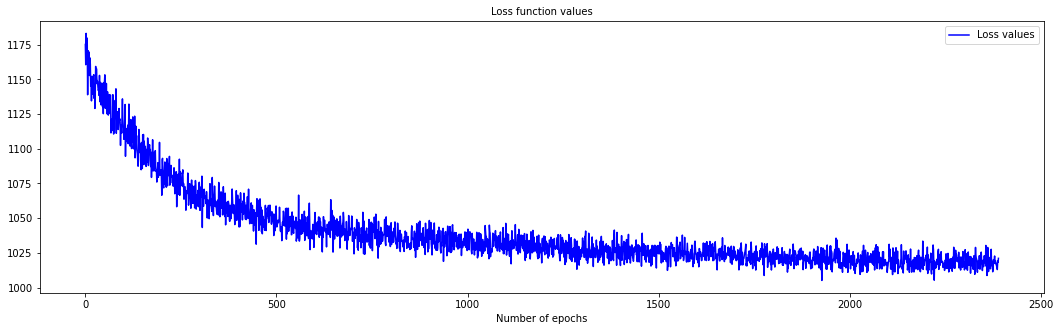

In [91]:
display_loss_values(deepsurv.model)

#### Tuning RSF

In [92]:
rsf = RSF()
rsf.tuning_and_construct(X_train, T_train, E_train,max_iter=max_iter)

Number 1 thread ... mean_c_index:  0.7046771230778309 is the best so far
Number 4 thread ... mean_c_index:  0.7046323894318756 Number 9 thread ... mean_c_index: 
 0.7226611332658962 is the best so far
Number 2 threadNumber 6 thread ... mean_c_index:  0.7116323554966325 
 ... Number 7 threadmean_c_index:  0.7050527236225338 
 ... mean_c_index:  0.7006099804633636 
Number 8 thread ... mean_c_index:  0.7109989696548178 
Number 5 thread ... mean_c_index:  0.7194196644010201 
Number 10 thread ... mean_c_index: Number 3 thread 0.7171993990976891 
 ... mean_c_index:  0.6856872968303811 
{'total iteration': 11, 'best_param': {'num_trees': 407, 'max_features': 'all', 'min_node_size': 68, 'sample_size_pct': 0.8, 'importance_mode': 'permutation'}, 'best_score': 0.7226611332658962}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 11 threadNumber 14 thread ...  ... mean_c_index:  0.6850129047060236 
Number 15 thread ... mean_c_index: mean_c_index:   0.6967262034107243 0.7088386470478092 

Number 20 thread ... mean_c_index:  0.7152079834927629 Number 12 thread ... 
mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 16 thread  ... mean_c_index: 0.6862117550422675Number 18 thread  ... mean_c_index:  0.6854261183771977  
0.6778457889897591 

Number 19 threadNumber 13 threadNumber 17 thread ...  ... mean_c_index:  0.6995301108260499 
mean_c_index:  ...  0.6984284435882919 
mean_c_index:  0.5 
{'total iteration': 21, 'best_param': {'num_trees': 407, 'max_features': 'all', 'min_node_size': 68, 'sample_size_pct': 0.8, 'importance_mode': 'permutation'}, 'best_score': 0.7226611332658962}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 21 thread ... mean_c_index:  0.5 
Number 22 threadNumber 28 thread ...  ... mean_c_index: mean_c_index:  0.6803827687018129Number 24 thread   ... mean_c_index: 0.5Number 23 thread   ... 0.68664023471774Number 30 thread
 
Number 25 threadmean_c_index:  0.5 
 ... mean_c_index:  ... mean_c_index:  0.5 
Number 27 thread 0.6766499091397569 

 ... mean_c_index: Number 29 threadNumber 26 thread  ... mean_c_index:  0.704950140308149 
0.694425991394892 
 ... mean_c_index:  0.6961445598375218 
{'total iteration': 31, 'best_param': {'num_trees': 407, 'max_features': 'all', 'min_node_size': 68, 'sample_size_pct': 0.8, 'importance_mode': 'permutation'}, 'best_score': 0.7226611332658962}
Number 31 thread ... mean_c_index:  0.6776564543250636 
Number 34 thread ... mean_c_index:  Number 32 thread ... Number 35 thread0.689362859239298mean_c_index:  0.6875281570494755 
  ... Number 37 thread
 ... mean_c_index:  0.692365779448431 
mean_c_index:  0.6871401646550166Number 33 thread  ... mean_c_index

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 61 thread ... mean_c_index:  0.6876291809940851 
Number 62 threadNumber 66 thread ... mean_c_index:  0.5 ...  
mean_c_index:  0.6870166158069081 
Number 67 thread ... mean_c_index:  0.7045623837272154 
Number 70 thread ... mean_c_index: Number 64 thread  ... mean_c_index: 0.6860314475995603 0.6921868081364042 
 Number 68 thread ... mean_c_index:  0.7251452444766046 
Number 65 thread ... mean_c_index:  0.6812114493147484 

Number 63 threadNumber 69 thread ... mean_c_index:  0.7185849984149215 
 ... mean_c_index:  0.7370717197372361 
{'total iteration': 71, 'best_param': {'num_trees': 314, 'max_features': 'all', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'impurity_corrected'}, 'best_score': 0.7377782521054429}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 72 threadNumber 75 thread ... mean_c_index:  0.7234278520807018 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp



 ... mean_c_index:  0.6799132171410324Number 71 threadNumber 76 thread 
 ...  ... mean_c_index: mean_c_index:  0.5 
Number 74 thread ... mean_c_index:  0.6921271306943917 
 Number 73 thread0.5 
 ... Number 78 threadmean_c_index:  ... mean_c_index:  0.7031825935269099 
 Number 77 thread0.7276738576704067 
 ... mean_c_index:  0.7089682734387635 
Number 79 thread ... mean_c_index:  0.6941530697442302 
Number 80 thread ... mean_c_index:  0.7008446831440361 
{'total iteration': 81, 'best_param': {'num_trees': 314, 'max_features': 'all', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'impurity_corrected'}, 'best_score': 0.7377782521054429}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 87 thread ... mean_c_index: Number 81 thread  ... Number 84 thread0.6715897843138569 
mean_c_index:  ... mean_c_index:   0.7212425738380116 Number 82 thread0.7244822389569298 ... mean_c_index:  0.5 
 

Number 89 thread ... mean_c_index:  0.6949206785302638 
Number 86 thread ... mean_c_index:  0.7115179021403636 
Number 85 threadNumber 88 thread ...  ... mean_c_index:  0.692823459605599 
Number 83 thread ... mean_c_index:  0.6890253478004739 
Number 90 threadmean_c_index:  ... mean_c_index:  0.5 
 0.7211035661395302 
{'total iteration': 91, 'best_param': {'num_trees': 314, 'max_features': 'all', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'impurity_corrected'}, 'best_score': 0.7377782521054429}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 91 thread ... mean_c_index:  0.6051440199958149 
Number 93 thread ... mean_c_index:  0.6907605995764963 
Number 100 threadNumber 92 thread ...  ... mean_c_index:  0.7162591807756296 
mean_c_index:  0.7097044845017215 
Number 98 thread ... Number 94 threadmean_c_index:  0.7166685353660436 
 ... mean_c_index: Number 97 thread 0.7164835906911875 Number 95 thread
Number 96 thread ...  ... mean_c_index:  0.7190436162703719 ... mean_c_index:  0.702292368297527 
Number 99 threadmean_c_index:   ... mean_c_index:  0.7044207734365978 
 
0.7115241460406805 
{'total iteration': 101, 'best_param': {'num_trees': 314, 'max_features': 'all', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'impurity_corrected'}, 'best_score': 0.7377782521054429}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 102 thread ... mean_c_index:  0.6876700944494556 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 107 thread ... mean_c_index:  0.7221172232559054 
Number 104 threadNumber 108 thread ...  ... mean_c_index:  0.6920222747975182 mean_c_index: 
Number 110 threadNumber 105 thread  ... mean_c_index:  0.6747699868006144 
 ... mean_c_index: 0.5Number 101 thread 
 ... mean_c_index:  0.7219578109871786 
 0.6868046450967118 
Number 103 thread ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 109 threadmean_c_index:  0.5 
 ... mean_c_index:  0.5 
Number 106 thread ... mean_c_index:  0.725780867110458 
{'total iteration': 111, 'best_param': {'num_trees': 314, 'max_features': 'all', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'impurity_corrected'}, 'best_score': 0.7377782521054429}
Number 111 thread ... mean_c_index: Number 118 thread ... mean_c_index:  0.6989418131220135 
 0.7057536674550325 Number 112 threadNumber 117 thread ... 
mean_c_index: Number 120 threadNumber 114 thread  ... Number 119 thread ... 0.7072837456381057 ... mean_c_index:  0.6855828977921667 
 mean_c_index: Number 115 thread ... mean_c_index:  ... 
mean_c_index:  0.692348018230898 
Number 116 thread mean_c_index:  0.680896418906177 Number 113 thread ... mean_c_index:  0.7084257195893382 
  ... 
0.70810127815400530.6962808951678628 
 
mean_c_index:  0.718252203688302 
{'total iteration': 121, 'best_param': {'num_trees': 314, 'max_features': 'all', 'min_node_size': 9, 'sample_size_

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 150 threadNumber 144 thread ...  ... Number 146 threadNumber 147 threadNumber 145 threadmean_c_index:  ... mean_c_index:  0.6915751786420057  ... Number 148 threadmean_c_index:  0.6810895471750509Number 149 thread 
mean_c_index:  ...  0.7180773450360229 
 ...  ...  
Number 142 thread0.6878836103640201 ... mean_c_index: mean_c_index:  mean_c_index: mean_c_index:  0.7072426548847928 0.5 
 Number 143 thread
  ... mean_c_index:  0.7141526815845176 

0.5Number 141 thread 
  ... mean_c_index:  0.5 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


0.7096236979115227 
{'total iteration': 151, 'best_param': {'num_trees': 314, 'max_features': 'all', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'impurity_corrected'}, 'best_score': 0.7377782521054429}
Number 151 threadNumber 154 thread ... Number 156 thread ...  ... mean_c_index:  0.67944617988665 mean_c_index: Number 152 thread Number 158 thread
 ... mean_c_index:  mean_c_index:  ... mean_c_index:  0.69674716167174090.686768637739538 0.6989721757722215 
0.6833214424284357  
 
Number 159 thread ... mean_c_index:  0.6754710904486201 

Number 153 thread ... Number 160 threadNumber 157 thread ... mean_c_index:  0.6910832584053134mean_c_index:  ... mean_c_index:  0.7106691057107415 
 
 0.7286043989223756 
Number 155 thread ... mean_c_index:  0.710084043401179 
{'total iteration': 161, 'best_param': {'num_trees': 314, 'max_features': 'all', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'impurity_corrected'}, 'best_score': 0.7377782521054429}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 167 threadNumber 168 threadNumber 164 thread ...  ... mean_c_index:  0.6983206251097898mean_c_index:  0.5 
 ... Number 163 threadmean_c_index: Number 169 thread  

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ...  ... 0.7056391654836907mean_c_index:  0.7102634908798358 
mean_c_index: 
 Number 161 thread 0.7217725358254258 
 ... mean_c_index:  0.6876227319470056 

Number 165 thread ... mean_c_index:  0.7188801676326443 
Number 162 thread ... mean_c_index:  0.7079728751796963 
Number 170 thread ... mean_c_index:  0.6853247111338048 
Number 166 thread ... mean_c_index:  0.6992928151105963 
{'total iteration': 171, 'best_param': {'num_trees': 314, 'max_features': 'all', 'min_node_size': 9, 'sample_size_pct': 0.8, 'importance_mode': 'impurity_corrected'}, 'best_score': 0.7377782521054429}
Number 172 threadNumber 175 thread ...  ... Number 171 threadmean_c_index: mean_c_index:   0.7228513334374098 0.6889911274752905
  ... 
mean_c_index:  0.6803792945686663 
Number 174 thread ... Number 176 threadNumber 173 thread ... mean_c_index:  0.7153580873658106  ... mean_c_index:  0.6890859498197439 
mean_c_index: 
 0.7312804352552724 
Number 177 thread ... Number 178 threadmean_c_index:  ... Number 179 th

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 187 thread ... mean_c_index:  0.6696410138913487Number 188 thread  ... 
Number 181 threadNumber 185 thread ...  ... mean_c_index: mean_c_index: mean_c_index:    

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


0.7229263726430712 
0.7190701008096030.5 
 Number 183 threadNumber 184 thread ... mean_c_index:  0.7096008434520718 

 ... Number 182 threadmean_c_index:   ... 0.5mean_c_index:  
Number 190 thread ...  Number 186 thread0.68817590295207mean_c_index:  0.5 
 ...  mean_c_index:  0.7057601700078108 

Number 189 thread ... mean_c_index:  0.7543392026122457 is the best so far
{'total iteration': 191, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 194 thread ... mean_c_index:  0.7049841776931695 Number 191 threadNumber 195 thread
 ...  ... mean_c_index:  mean_c_index: Number 193 thread0.6840039335206127 
 0.5 ... mean_c_index:  0.7076664531869911  

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp




Number 196 thread ... mean_c_index: Number 197 thread ...  0.7229814088127406 
mean_c_index: Number 192 thread  ... mean_c_index:  0.5 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 199 thread ... mean_c_index: 0.6949531760402371  0.6863123786113025 

Number 198 thread ... mean_c_index:  Number 200 thread0.7248078118422174 
 ... mean_c_index:  0.5 
{'total iteration': 201, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 202 threadNumber 201 thread ... mean_c_index:  0.731113975196453 
 ... mean_c_index:  0.7239363117101488 Number 204 thread ... mean_c_index:  0.7118958036038221 

Number 209 thread ... mean_c_index:  0.5Number 208 thread ... Number 203 thread mean_c_index:  0.7104363838211887 
 ... mean_c_index:  0.6972550416380338 

Number 206 thread ... mean_c_index:  0.6998537801348271 Number 207 thread
 ... mean_c_index:  0.6751704092053046 
Number 205 thread ... mean_c_index:  0.7092255003726395 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 210 thread ... mean_c_index:  0.6995128961802296 
{'total iteration': 211, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 213 thread ... mean_c_index: Number 218 thread  ... mean_c_index: Number 211 thread0.6925839969972323Number 214 thread ... mean_c_index:  0.7064256451714803 
Number 212 thread  ...  ... mean_c_index:  0.7034097797950013mean_c_index:  0.6955118505141554  0.6943682171730751 

 
Number 216 thread ... mean_c_index:  0.6928682464094267 
Number 215 thread
Number 217 thread ...  ... mean_c_index:  0.6976433348252362 
mean_c_index:  0.7101293512880329 
Number 220 thread ... mean_c_index:  0.717859007975508 
Number 219 thread ... mean_c_index:  0.7317901643487176 
{'total iteration': 221, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 235 thread ... mean_c_index:  0.6919177414262906 Number 233 threadNumber 231 thread ... mean_c_index:  0.7171154930744074 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ... mean_c_index: 
 Number 232 thread0.5 ... mean_c_index:  
 0.7142879715847793Number 236 threadNumber 239 thread ...  Number 240 threadmean_c_index:  ...  ... mean_c_index:  0.7238584907847269 

mean_c_index:  0.5Number 237 thread Number 234 threadNumber 238 thread ... mean_c_index:  0.7032558665078794 
0.691729498431682 ...   ... mean_c_index:  0.7173405311216563  

mean_c_index:  0.6896703273874507 

{'total iteration': 241, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 243 thread ... mean_c_index:  Number 241 thread0.6887265137459148  ... 
mean_c_index: Number 244 thread ... mean_c_index:  0.7127131976565243 
Number 249 thread 0.6880004897904529 ... mean_c_index:  0.6836063541587738 
 Number 242 thread
 ... Number 250 thread ... Number 248 threadNumber 245 thread ... mean_c_index: mean_c_index:  ... mean_c_index:  mean_c_index:   0.5  0.735295965819685
 
0.6930144516158461 
Number 246 thread0.6993562090477063  ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index:  0.7154181531862667 

Number 247 thread ... mean_c_index:  0.7212735831647075 
{'total iteration': 251, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 254 threadNumber 256 thread ... mean_c_index:  0.6713387432268396 
 ... mean_c_index:  0.6871730816692837Number 253 thread Number 258 thread ...  ... mean_c_index:  Number 251 thread0.693557674306587mean_c_index:  ...   0.6746241009804963 

Number 255 threadmean_c_index:  0.6980635212604915 
 ... mean_c_index:  0.7161322650867337 
Number 259 thread
 ... mean_c_index:  0.7170868788903352 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 257 threadNumber 252 thread ... mean_c_index:  0.5 
 ... mean_c_index:  0.6982051891225955 
Number 260 thread ... mean_c_index:  0.7317183420985226 
{'total iteration': 261, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 262 thread ... mean_c_index:  Number 267 thread ... mean_c_index:  0.6740014998262441 
0.6949946830914582 Number 261 thread
 ... Number 264 threadmean_c_index:  0.7074291612687235 
Number 265 thread ...  ... mean_c_index:  mean_c_index: 0.6784499873136086  Number 266 thread0.6976170145921567
 ...  mean_c_index: 
 0.6903593914028349 Number 263 threadNumber 269 thread ...  ... mean_c_index:  0.7010858619477638 
mean_c_index:  0.7088376908044897 

Number 270 threadNumber 268 thread ... mean_c_index:  0.69941294371758 
 ... mean_c_index:  0.7045185294898632 
{'total iteration': 271, 'best_param': {'num_trees': 709, 'max_features': 'all', '

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 284 threadNumber 281 thread ... mean_c_index:  0.6696784300833254  ... Number 283 thread ... mean_c_index:  0.6895748622663382 

mean_c_index:  0.6959918488886243 
Number 288 thread ... Number 287 threadmean_c_index:  0.7085376892328641 
 ... mean_c_index:  0.6955307604779184 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 286 thread ... mean_c_index:  0.6956671712341777 
Number 285 thread ... mean_c_index:  Number 290 thread ... mean_c_index:  0.7296095315005278 
0.7141753357324951 Number 282 thread
 ... mean_c_index:  0.5 Number 289 thread
 ... mean_c_index:  0.700613113975997 
{'total iteration': 291, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 294 thread ... mean_c_index:  0.689914333037115 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 292 threadNumber 291 thread ...  ... mean_c_index:  0.7242799976740222 
mean_c_index:  Number 293 threadNumber 300 thread ... mean_c_index:  0.6957080989720266 
 ... mean_c_index:  0.6969131797731895 
0.6996499626547497 
Number 295 thread ... mean_c_index:  0.6940634073277971 
Number 297 thread ... Number 299 threadNumber 298 thread ... mean_c_index:  0.6700799229414327 
 ... mean_c_index:  0.5mean_c_index:   0.7084987694995999 
Number 296 thread ... mean_c_index:  0.7105003524342054 

{'total iteration': 301, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 302 thread ... mean_c_index:  0.6894516208224851 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 305 thread ... mean_c_index:  0.5 
Number 308 thread ... mean_c_index: Number 310 thread  ... mean_c_index:  0.6929078304416441 
Number 304 thread0.5Number 306 thread ... mean_c_index:  ...  Number 301 threadNumber 309 thread mean_c_index: 0.7013453551595992
  ...  ...  0.5mean_c_index:  0.6989454331914204 
Number 303 thread Number 307 threadmean_c_index:  ... mean_c_index:  0.7068552478937115 


 ...  mean_c_index: 0.5 0.7291500889846956 
 
{'total iteration': 311, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 312 thread ... mean_c_index:  0.6932817127001285 
Number 311 threadNumber 314 thread ... mean_c_index:  0.7154076835439866 
Number 317 thread ...  ... Number 316 threadmean_c_index:  0.7009181677631624 
mean_c_index:   ... mean_c_index:  0.5 
0.6787975151711255 Number 313 thread ... mean_c_index:  0.7316138547745437 
Number 318 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ... 
mean_c_index:  0.7305242114940292Number 315 thread  ... mean_c_index:  0.7435965648811981 
Number 319 threadNumber 320 thread
 ...  ... mean_c_index:  0.5 
mean_c_index:  0.6860436740665155 
{'total iteration': 321, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 325 thread ... mean_c_index: Number 321 thread ... mean_c_index:  0.5 
Number 327 thread 0.7003281099774024 ...  
mean_c_index:  0.7161075689482986

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 322 thread ... Number 328 threadmean_c_index:  0.7203777669547016 
Number 324 threadNumber 323 thread ...  ...  ... mean_c_index:  0.7380105068233453 
Number 330 threadNumber 326 thread Number 329 threadmean_c_index:  0.5 
mean_c_index:  ... mean_c_index:  0.5 
 0.7160616948366496 
 ... mean_c_index:  0.6756336237703089 

 ... mean_c_index:  0.6741557099451867 
{'total iteration': 331, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 332 threadNumber 331 thread ... mean_c_index: Number 333 thread ...  mean_c_index:  0.7241570817923739 
 ... 0.7001080024525062mean_c_index:   
0.724124743950137 Number 336 thread
 ... mean_c_index: Number 335 thread 0.6923165628779653  ... Number 337 threadmean_c_index:  0.5 
 ... mean_c_index:  0.5 
Number 334 thread ... 
mean_c_index:  0.707136877866641 
Number 339 thread ... mean_c_index:  0.6881766316238366 
Number 340 threadNumber 338 thread ... mean_c_index:  0.6906728417519513 
 ... mean_c_index:  0.6811040884330817 
{'total iteration': 341, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 341 thread ... mean_c_index:  0.6799917864573056 
Number 344 thread ... mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 342 thread Number 343 thread ... mean_c_index:  0.6958221696144588 0.7161791288689247
  ... mean_c_index:  
0.687198003477947Number 348 threadNumber 347 thread ... mean_c_index:  0.7136737319912847Number 346 thread ... mean_c_index:  0.6944771821754057 
 Number 345 thread  ...  ... mean_c_index: mean_c_index: 
  0.7267869704340123 
0.7017696385830798 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp



Number 350 thread
 ... mean_c_index:  0.7194616930642914 
Number 349 thread ... mean_c_index:  0.5 
{'total iteration': 351, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 351 thread ... mean_c_index:  0.6885182398326581Number 354 thread ...  mean_c_index: Number 358 thread 0.7161411537054059 
 ... mean_c_index: 
 Number 353 threadNumber 352 thread ... Number 357 thread ... 0.684884599932415Number 360 thread  ... mean_c_index:  ... mean_c_index:  0.709299158329566 

Number 359 threadmean_c_index: mean_c_index:   ... 0.6998157205598272mean_c_index:  0.7127402542148216 
 
Number 356 thread   ... mean_c_index:  0.70199464418638310.696502895696119 
0.709052409654588 
 
Number 355 thread ... mean_c_index:  0.7196577090084371 
{'total iteration': 361, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 361 thread ... mean_c_index:  0.7004501382990644 Number 367 threadNumber 363 thread ... mean_c_index:  
Number 365 thread0.6923780844098284 ... mean_c_index:  ...   
mean_c_index: 0.5  0.6671563678397276 

Number 368 threadNumber 370 thread ... mean_c_index:  Number 369 thread0.6908241893772349 
 ... mean_c_index:  0.6821626791430557 
 ... Number 362 threadmean_c_index:   ... 0.5 
mean_c_index:  0.7063574903511382 
Number 364 thread ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index:  0.6882594172887042 
Number 366 thread ... mean_c_index:  0.694408508034542 
{'total iteration': 371, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 373 thread ... Number 371 thread ... mean_c_index: mean_c_index:   0.72012031898326480.6920887549118971 
 
Number 375 thread ... mean_c_index: Number 372 thread  ... mean_c_index: Number 379 thread 0.6906854702819143 
 ... 0.716085189998286 
mean_c_index:  0.7068347386443163Number 376 thread Number 374 thread ... mean_c_index:  0.6738954277637021 
 ... 
mean_c_index:  0.699992843316519 Number 380 threadNumber 377 thread ... mean_c_index:  0.7286014465802252 

 ... mean_c_index: Number 378 thread ... mean_c_index:  0.7013717998117439 
 0.7168298056462181 
{'total iteration': 381, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'pe

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 383 thread ... mean_c_index:  0.5Number 381 threadNumber 384 thread ... Number 385 threadNumber 388 thread ... mean_c_index:  0.5  ... mean_c_index:  0.6905042210370768  ... mean_c_index:  0.7150786265802204 

 
mean_c_index:  0.6980338192752557 

Number 387 thread ... Number 389 threadmean_c_index:  0.6976499688459576 
 ... Number 382 thread ... mean_c_index:  0.7177134612744202 
mean_c_index:  0.7096246803138743 
Number 386 thread ... mean_c_index:  0.6998563261899369 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 390 thread ... mean_c_index:  0.7130217779746203 
{'total iteration': 391, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 394 thread ... Number 391 threadmean_c_index:  ... mean_c_index:   0.70707550021780310.7181615594887205

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 398 thread  

 ... Number 400 threadNumber 396 threadmean_c_index:  ...  ... mean_c_index: mean_c_index:   Number 392 thread0.6827820974325708 ... 0.6906011714509981Number 395 thread  mean_c_index: 
 ... mean_c_index:  0.7164156314360169 
Number 399 thread
  ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index:  0.6849469322862685 
0.7072480419680455Number 393 thread 
  ... 0.7256255018186546mean_c_index:  0.5 
 
Number 397 thread ... mean_c_index:  0.7272481736622156 
{'total iteration': 401, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 402 thread ... mean_c_index: Number 401 thread ...  0.7008005997242239mean_c_index:   0.6743951504602866 Number 409 threadNumber 404 thread

 ... mean_c_index:  ... mean_c_index:  0.7181860698059926 
 Number 403 thread ... mean_c_index:  0.5 0.7088715576862249 

Number 408 thread ... Number 406 threadmean_c_index:  ...  mean_c_index:  0.5Number 405 thread0.6873451035455226 ...  mean_c_index:  Number 407 thread
 ... mean_c_index:  0.5 
 0.6957578228403888
 
Number 410 thread ... mean_c_index:  0.7208146253330328 
{'total iteration': 411, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 416 threadNumber 415 thread ... mean_c_index:  ... mean_c_index: Number 413 thread ...  mean_c_index:  0.67637628248521 0.7003662652691184 
 Number 418 thread ... mean_c_index:  0.6828628911190199 
Number 412 threadNumber 411 thread
0.7283138509282548  ... mean_c_index:  ... 
 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


0.7133104509964674mean_c_index:  0.5 
 
Number 414 thread ... mean_c_index:  0.6921667887506598 
Number 417 thread ... mean_c_index:  Number 420 thread0.6979898115166603 
 ... mean_c_index:  0.7094466197838546 
Number 419 thread ... mean_c_index:  0.7124741922728404 
{'total iteration': 421, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 421 threadNumber 428 threadNumber 427 thread ...  ... Number 429 thread ... mean_c_index: mean_c_index: mean_c_index:  0.6770798067463302  ...  
mean_c_index: 0.6865042381996991Number 424 thread   ... 0.69410523264729420.6811142549727346 Number 426 thread Number 423 thread  ... mean_c_index:  0.7057885614654626 

 ... 
mean_c_index:  0.701056389258724 
mean_c_index: 
Number 422 thread 0.7092593470246562 
 ... mean_c_index:  0.6970147535991679 
Number 425 thread ... mean_c_index:  0.6837085445570638 
Number 430 thread ... mean_c_index:  0.5 
{'total iteration': 431, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 435 thread ... mean_c_index:  0.7073326941761309 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 431 threadNumber 440 threadNumber 434 thread ...  ...  ... mean_c_index: Number 437 threadmean_c_index:  0.7009551806429257 
  ... mean_c_index: Number 439 thread 0.6963386617137942 mean_c_index:  0.6897960189337069 
 ... mean_c_index:  0.7296319601944355 
0.6795488167734746Number 433 thread
  ... mean_c_index:  0.7092735888017255 

Number 432 threadNumber 436 thread ...  ... mean_c_index:  0.698185137617694 
Number 438 threadmean_c_index:  ... mean_c_index:  0.6837402061853574  0.5 

{'total iteration': 441, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 442 thread ... mean_c_index:  0.6706327318499513 
Number 441 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ... mean_c_index:  0.6994845510920008 
Number 446 thread ... mean_c_index:  0.6930789785807343 Number 443 thread ... mean_c_index:  0.7212700836997665 
Number 447 thread
 ... Number 450 thread ... mean_c_index: Number 445 threadmean_c_index:   ... mean_c_index:  0.5 
Number 444 thread0.6904829496208851  ... mean_c_index:  0.7001309092584581 
0.689096930684536  



/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 449 threadNumber 448 thread ... mean_c_index:  0.6987072519653237 
 ... mean_c_index:  0.712319814507185 
{'total iteration': 451, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 452 threadNumber 459 thread ...  ... mean_c_index: mean_c_index:  Number 456 thread 0.6810585994215322Number 457 thread ...  
mean_c_index:  0.6877527331755642 
0.7203553897295427Number 451 thread Number 454 thread ...  ... mean_c_index: mean_c_index:  0.6883684937281458 
Number 455 thread ... mean_c_index:  0.7177396973955787 
Number 458 thread ...  
 ... mean_c_index: 0.7258575491246613 0.6928165209859907  Number 460 threadmean_c_index:   ... Number 453 thread0.7103510487879606  ... mean_c_index:  0.703618704295079
mean_c_index: 
 
 0.7071473903850005 

{'total iteration': 461, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6,

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 464 thread ... mean_c_index:  Number 465 threadNumber 461 threadNumber 466 thread ...  ... mean_c_index: mean_c_index:   ... mean_c_index:  0.5 
0.6819525536461337 0.686231230567046 
 0.6703699796078 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp



Number 469 thread
 ... mean_c_index:  0.7093187012529336 
Number 468 thread ... mean_c_index:  Number 467 thread0.7207775539293948Number 463 thread ... mean_c_index:  0.70451777351849 
 
 ... mean_c_index:  0.6786339755784425 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 462 threadNumber 470 thread ... mean_c_index:  0.7093793520071401 
 ... mean_c_index:  0.5 
{'total iteration': 471, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 471 thread ... mean_c_index:  0.6821858971940353 
Number 475 thread ... mean_c_index:  0.6970594721582948 
Number 473 thread ... mean_c_index:  0.7074204874304766Number 472 thread 
Number 474 thread ... mean_c_index:  ... mean_c_index:  0.6854785787663314 
 0.6659215425011228Number 476 thread 
 ... mean_c_index:  0.6805804490419155 Number 477 thread ... 
mean_c_index:  0.6873627027016872 
Number 478 thread ... mean_c_index:  0.7242796981074193 
Number 479 thread ... mean_c_index:  0.6886442498931761Number 480 thread 
 ... mean_c_index:  0.6832783712567232 
{'total iteration': 481, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 485 threadNumber 482 thread ... mean_c_index:  0.6811313509215595 
 ... mean_c_index:  0.6860776778850675 
Number 481 thread ... Number 486 thread ... mean_c_index:  mean_c_index: Number 487 thread0.7009540152239164 
 ...  0.6827817691492325 
mean_c_index:  Number 483 thread0.7093144863552023 ... mean_c_index:  Number 489 thread0.6977311443318329 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


  ... 
Number 490 threadmean_c_index:   ... 0.7218097506403949 
mean_c_index:  0.5 
Number 488 thread ... mean_c_index: Number 484 thread 0.713429030470501 
 ... mean_c_index:  0.7074508765423948 
{'total iteration': 491, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 493 threadNumber 499 thread ... mean_c_index:  Number 494 thread0.6970701381247999 ... mean_c_index:    ... Number 496 threadmean_c_index:  ...  
Number 500 thread0.7134250432977675mean_c_index: 0.6988302046098099 0.6970131768851318 
   ... mean_c_index: 

 Number 495 thread ... 0.7070705483842581mean_c_index:  0.7141107517654883  

Number 492 thread ... mean_c_index: Number 491 threadNumber 497 thread  ...  ... mean_c_index: 0.7099035641435802mean_c_index:  0.5 
 
 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


0.7108420206061591 Number 498 thread ... mean_c_index:  0.7128092205908997 

{'total iteration': 501, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 505 thread ... mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 0.6862270242114991Number 504 threadNumber 510 thread ...  ...  mean_c_index:  Number 501 thread0.6747226472054835mean_c_index:   Number 502 threadNumber 506 thread ... 
 ... mean_c_index:  0.6945364003646823
mean_c_index:  0.6893061538265092 
  ... 0.6848806057801106mean_c_index: 
  0.7126925911889994 
Number 503 thread
 ... mean_c_index:  0.6945678182994811 
Number 507 threadNumber 508 thread ... mean_c_index:  0.699385704386095 
 ... mean_c_index:  0.5 
Number 509 thread ... mean_c_index:  0.7163353802866517 
{'total iteration': 511, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 511 thread ... mean_c_index:  0.6787249191066913 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 514 thread
 ... mean_c_index:  0.7233034678155469 
Number 516 thread ... mean_c_index:  0.7011709041711892 
Number 515 thread ... mean_c_index:  0.6999189033554225 
Number 512 thread ... mean_c_index: Number 520 threadNumber 518 threadNumber 517 thread  ...  ...  ... mean_c_index: mean_c_index: 0.7074852609277978Number 513 thread 0.5  ...  0.6964870488723605 
mean_c_index:  0.6861827827220801 
 
mean_c_index:  0.7164623419632788 

Number 519 thread ... mean_c_index:  0.6895775707132644 
{'total iteration': 521, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 528 threadNumber 523 thread ...  ... mean_c_index: mean_c_index:  0.6846140966982136 
Number 521 thread  ... 0.697123320109235mean_c_index:   0.6768372613443308 Number 530 thread ... 
mean_c_index:  Number 525 thread0.6989846413597014 

 ... Number 529 threadmean_c_index:  ... Number 524 thread mean

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 542 thread ... mean_c_index:  

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


0.7337645891676285 
Number 545 thread ... mean_c_index:  0.6834474573683876 Number 543 thread ... 
mean_c_index:  0.5 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 550 thread ... Number 544 threadmean_c_index:  0.7129167766602971 
Number 541 thread ...  ... mean_c_index:  0.6665765356364195 
Number 546 threadmean_c_index:  0.5 
 ... mean_c_index:  0.691252346346496 
Number 548 thread ... Number 549 threadmean_c_index:  ... mean_c_index:  0.6998949152409684  0.7073213732948612 

Number 547 thread ... mean_c_index:  0.6869203399231343 
{'total iteration': 551, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 551 thread ... mean_c_index:  0.6998255110544387 
Number 554 thread ... mean_c_index: Number 559 thread Number 560 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ... mean_c_index:  0.7035807828086201 
0.7148641620670685 ... mean_c_index:  0.6860590780915442 
 Number 553 threadNumber 552 thread ... mean_c_index:  ...  0.5 
Number 557 thread
mean_c_index:  ...  mean_c_index: 0.664417514547888 
 0.5 
Number 555 threadNumber 556 thread ... mean_c_index:  0.7284196415266235 
 ... mean_c_index:  0.5 
Number 558 thread ... mean_c_index:  0.709134521336853 
{'total iteration': 561, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 562 thread ... mean_c_index: Number 561 threadNumber 570 thread  ... mean_c_index: Number 564 thread ... mean_c_index:  0.6858321056907092 
Number 566 thread0.6996616727921002 ...    ... Number 563 thread
Number 567 threadmean_c_index:  ... mean_c_index:  0.5 
 0.7231925929462315 
mean_c_index: 0.6806251528379935 0.5 
 ...  mean_c_index: 
 Number 565 thread0.7208851753350677 ...  
mean_c_index:  0.6888267921283534 
Number 569 thread ... mean_c_index:  0.7040352182015889 
Number 568 thread ... mean_c_index:  0.7154228337136319 
{'total iteration': 571, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 573 thread ... Number 574 thread ... mean_c_index:  0.6960644074233231 
Number 572 thread ... mean_c_index:  mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 0.6851175938525789 
0.6763361620377527 
Number 571 thread ... mean_c_index:  Number 577 thread ... mean_c_index:  0.6873161618847493 
0.7325510183036789 
Number 576 threadNumber 575 thread ...  ... mean_c_index: mean_c_index:   0.7005608835370813 
0.6770981644958592 Number 579 thread ... mean_c_index:  0.5 



/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 578 thread ... mean_c_index:  0.7218563848087788 
Number 580 thread ... mean_c_index:  0.5 
{'total iteration': 581, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 588 thread ... mean_c_index:  Number 582 thread ... 0.727671882969172 
Number 585 thread ... mean_c_index: mean_c_index:  0.7219170370412664 
Number 584 thread ... mean_c_index:  0.6871526855598937Number 587 thread ... mean_c_index:  0.6810586350249797 
  0.6960459904225875
Number 581 thread ... mean_c_index:  0.6750581621589266  

Number 589 thread ... mean_c_index: Number 583 thread ... mean_c_index:  0.7062641303134256 
Number 586 threadNumber 590 thread  ... mean_c_index:  0.7040410028391793 
0.6931949265673228 ... mean_c_index:  0.7390788095917643  

{'total iteration': 591, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 592 thread ... mean_c_index:  

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


0.5 
Number 594 thread ... mean_c_index: Number 595 thread 0.5 
Number 593 thread ...  ... mean_c_index: mean_c_index:  Number 598 thread ...  mean_c_index:  0.712644347700075 0.7161765535604079 0.5

 
Number 591 thread ... mean_c_index:  Number 597 threadNumber 600 thread0.6900200199013322Number 599 thread ...   ...  ... mean_c_index:  0.5 mean_c_index:  0.6952196210363571 
mean_c_index:  0.5 
Number 596 thread
 ... mean_c_index:  0.6883010142387989 

{'total iteration': 601, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 604 threadNumber 601 thread ... mean_c_index:  0.7294173946793528  ... 
mean_c_index:  Number 602 thread ... mean_c_index:  0.6942449251469405 
0.6932261113708509Number 606 thread ... mean_c_index:   
0.7000920304977556 
Number 603 threadNumber 605 thread ...  ... mean_c_index:  0.7053489125382288 
Number 609 threadmean_c_index:  ...  0.6893176214843362 
Number 607 threadmean_c_index: Number 608 thread 0.7114299317368316 ...  ... mean_c_index:  0.5 
mean_c_index:  0.7133502094853398 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 
Number 610 thread ... mean_c_index:  0.7168868732003091 
{'total iteration': 611, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 614 thread ... mean_c_index:  Number 617 thread0.7037726108035628 
 ... mean_c_index:  0.6669672265982316 Number 611 thread
 ... mean_c_index:  0.7028737772717655 
Number 620 thread ... mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 Number 618 thread0.7061932308552159 
Number 615 thread ...  ... mean_c_index:  0.5 
mean_c_index:  Number 619 thread ... mean_c_index:  0.6912465424685204 
Number 612 thread0.5 ... mean_c_index:  0.7516792805766895 
Number 613 thread Number 616 thread
 ...  ... mean_c_index:  0.6997156095244902 
mean_c_index:  0.6882858834173993 
{'total iteration': 621, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 622 thread ... mean_c_index:  0.7151936715824577Number 625 thread  ... mean_c_index:  0.6885016757593873 
Number 626 threadNumber 623 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp



 ... mean_c_index: Number 621 thread ... Number 628 thread ...  ... mean_c_index:  0.7027357791339746 
mean_c_index: mean_c_index:  0.5 
 0.6945507781037065 
Number 627 thread 0.6974218847934797  ... mean_c_index:  0.5 

Number 630 thread ... mean_c_index:  0.5 
Number 629 thread ... mean_c_index:  0.6982297664763033 
Number 624 thread ... mean_c_index:  0.728066172462802 
{'total iteration': 631, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 631 thread ... Number 634 threadmean_c_index:  0.5  ... mean_c_index:  
Number 633 thread ... mean_c_index:  0.714796056603985 
Number 635 thread0.7116903783552047 ... mean_c_index:   Number 637 thread
Number 636 thread ... Number 632 thread0.7105170460419241 ... mean_c_index:  0.6979590580186371 
Number 638 threadmean_c_index:  ...  0.7214374628804491 
 ...  mean_c_index: mean_c_index:   
0.6914809813656275 
0.6846358045175652 Number 640 thread ... Number 639 threadmean_c_index:  0.7083590409070526 

 ... mean_c_index:  0.7006819256109299 
{'total iteration': 641, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 644 thread ... mean_c_index:  0.6953801936228908 Number 643 thread ... mean_c_index: 
Number 649 threadNumber 641 thread Number 642 thread ...  ... Number 645 thread0.6947482443017585 ...  ... mean_c_index: mean_c_index:  0.6921711527908003 
mean_c_index:  0.5  
Number 646 thread0.6944827131818876  ... mean_c_index:   0.6964596580100677 
mean_c_index:  0.7073701252368514 

Number 648 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ... mean_c_index:  0.7207902962445638 

Number 647 thread ... mean_c_index:  0.7086310319872615 
Number 650 thread ... mean_c_index:  0.7042661930773244 
{'total iteration': 651, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 655 threadNumber 653 thread ... mean_c_index:  0.6938816838206384 
 ... mean_c_index:  0.7058406188316112 
Number 657 thread ... mean_c_index:  0.7091470263346564 
Number 651 thread ... Number 654 threadNumber 658 threadmean_c_index: Number 652 thread ...  ...  mean_c_index:  ... mean_c_index:  mean_c_index: 0.7053455921886791 0.6674521521958001  0.7393877393824241 
 
0.6813397019357328 Number 660 thread

 ... Number 659 threadmean_c_index:  0.6975090022150653 
 ... mean_c_index:  0.6907686721761188 
Number 656 thread ... mean_c_index:  0.7000138231560716 
{'total iteration': 661, 'best_param': {'num_trees': 709, 'max_features': 'all', 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 661 threadNumber 662 thread ...  ... mean_c_index:  0.6915763785665481 
mean_c_index:  0.6902943405420168

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

 
Number 667 thread ... mean_c_index: Number 669 thread  ... mean_c_index:  0.707019220598119 0.6940206844896902 

Number 670 threadNumber 666 thread ... mean_c_index:  0.5 
 ... Number 668 threadmean_c_index:  ... mean_c_index:  0.5Number 664 thread 0.5 
 ...  mean_c_index:  0.7116950963290462 

Number 665 thread ... mean_c_index:  0.6960010668910337 
Number 663 thread ... mean_c_index:  0.6929197001754722 
{'total iteration': 671, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 679 thread ... Number 673 threadmean_c_index:  0.6753764298429256 ...  Number 671 thread ... mean_c_index:  0.6883136449522164 
mean_c_index: Number 676 thread ... 
 Number 675 threadmean_c_index:  ...  0.7027312427136979 
mean_c_index:  0.7132681612057751 
Number 677 thread0.7192909972743466 ... mean_c_index:  0.6913187987361911 
 
Number 678 thread ... mean_c_index:  0.7251852556182

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 692 thread ... Number 694 thread ... mean_c_index: mean_c_index:  0.6788092550804916  Number 693 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ... Number 698 threadmean_c_index: 0.6865899625080445 ... Number 700 threadmean_c_index:  0.6907486492232657   
0.6942723378812196 

 ... Number 699 thread
 ... mean_c_index: mean_c_index:  0.6823536538937757 
Number 691 thread ...  0.6763499367011413 
mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 695 thread 0.6914635381791958 
 ... mean_c_index:  0.7027026325692486 
Number 696 thread ... mean_c_index:  0.7431674473052475 
Number 697 thread ... mean_c_index:  0.5 
{'total iteration': 701, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 704 thread ... mean_c_index:  0.7052796174815892 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 703 thread ... Number 701 thread ... mean_c_index:  0.6707273628394964 
mean_c_index:  Number 707 thread0.7119724994248061 
 ... mean_c_index:  Number 702 thread0.5Number 710 thread ... mean_c_index:  0.7106295590309323 
 ... mean_c_index:   
Number 709 thread0.6883085882846026 ...  
mean_c_index:  0.6813454731724885 
Number 708 thread ... mean_c_index:  0.5 
Number 706 thread ... mean_c_index:  0.7009241424144597 
Number 705 thread ... mean_c_index:  0.6964880337882617 
{'total iteration': 711, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 711 thread ... mean_c_index:  0.7080151681316933Number 714 thread ... mean_c_index:   Number 717 thread ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 715 threadmean_c_index:  ...  0.6716459414532643mean_c_index:  0.6856512964854633
 Number 718 thread
 
0.5 ... Number 720 threadmean_c_index:  ... mean_c_index:   0.6808709979633775 
0.5 
 Number 712 thread ... Number 716 threadmean_c_index: 
 ...  Number 713 threadmean_c_index: 0.5 0.6840001252091028  ... mean_c_index:  0.6909041882313829 
 

Number 719 thread ... mean_c_index:  0.7326584184713993 
{'total iteration': 721, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 722 threadNumber 721 thread ... Number 723 thread ... mean_c_index:  ... mean_c_index:  0.6954302607141208mean_c_index:    
0.690898141077661Number 726 thread ... mean_c_index:  0.689539353006786 
 0.7223251959408759 

Number 724 thread ... mean_c_index:  0.7013389480369706 Number 728 thread
 ... mean_c_index:  0.6782283980349155 Number 727 thread
 ... mean_c_index:  0.6810228542083528 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 738 threadNumber 734 thread ... mean_c_index:  0.688681887231874 
Number 739 thread ...  ... mean_c_index:  0.7094327612939857 
Number 740 thread ... mean_c_index: Number 731 thread mean_c_index:  ... 0.7097391672118583  mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 732 threadNumber 736 thread0.6850815906526467  ...  ... 0.6919964365123265 
 
mean_c_index:  mean_c_index:  0.7109769979131222 
0.5Number 735 thread ... Number 733 thread mean_c_index:  ... mean_c_index:  0.7018500557105047 

 
Number 737 thread ... mean_c_index:  0.7232960166741603 
0.7043711034011855 
{'total iteration': 741, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 742 thread ... mean_c_index:  0.707815071479325 
Number 743 thread ... Number 741 thread ... Number 747 threadmean_c_index: Number 748 thread  ... mean_c_index:  0.5mean_c_index:  ...  0.7291494733968367 
0.6961735646730105 
mean_c_index:  
Number 746 threadNumber 744 thread ... mean_c_index:  0.7091347478710396 
 ... mean_c_index:  0.6887006072957702 
 0.7057397849467572 
Number 750 thread ... mean_c_index: Number 749 thread ... mean_c_index:  0.6797276817935562 
 0.6762921436325511 
Number 745 thread ... mean_c_index:  0.7270994237294834 
{'total iteration': 751, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 751 thread ... mean_c_index:  0.6906570678324563 
Number 752 threadNumber 759 thread ...  ... mean_c_index:  0.6927832381375353mean_c_index:  0.6956043456214622  
Number 753 thread ... Number 758 thread
 ... mean_c_index:  mean_c_index: 0.5  0.6788609071222802 
Number 755 thread ... 
Number 754 threadmean_c_index:  ...  0.728552756121113 
mean_c_index: Number 757 thread Number 760 thread ...  ... mean_c_index:  0.7229657025545986 
0.7106168808992596mean_c_index:  
 0.6891290440682483 Number 756 thread
 ... mean_c_index:  0.6989236707285075 
{'total iteration': 761, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 763 threadNumber 765 thread ... mean_c_index:  ... mean_c_index:   0.6872906198155144 
Number 761 thread0.6905217477681759 
Number 767 thread ... mean_c_index:  0.7070778265328951 
Number 762 thread ...  ... mean_c_index: mean_c_index:  0.685703289104835 
 0.5Number 770 threadNumber 764 thread ... mean_c_index:  0.7168757790796463  
 ... mean_c_index:  0.7313162579903356 

Number 766 threadNumber 768 thread ... mean_c_index:  0.7062767506624074 
 ... mean_c_index:  0.7058341934777338 
Number 769 thread ... mean_c_index:  0.7127356623540393 
{'total iteration': 771, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 777 thread ... mean_c_index:  0.7008209689039923 
Number 774 threadNumber 773 threadNumber 771 thread ...  ...  ... mean_c_index:  0.6779172408833694 
mean_c_index: mean_c_index: Number 776 thread  ... mean_c_index:  0.6777422452632704 
0.703249

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 782 thread ... mean_c_index:  0.7041379468179435 
Number 784 thread ... mean_c_index:  Number 781 thread0.6854537864127573Number 786 threadNumber 788 thread  ...  ... mean_c_index:  ... 
mean_c_index:   0.7211742259220786mean_c_index: 0.6866875217356412  
 0.6977734448283411 Number 785 thread


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp



 ... mean_c_index:  0.7019468693181422 Number 783 thread ... mean_c_index: 
 0.722038160369954Number 789 thread 
 ... mean_c_index:  Number 787 thread ... mean_c_index:  0.5 
0.6908570844390297 
Number 790 thread ... mean_c_index:  0.5 
{'total iteration': 791, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 797 threadNumber 793 threadNumber 794 thread ... mean_c_index:  ... mean_c_index:  0.685320351128319 
 Number 796 thread0.6889436646037773 ... Number 799 thread  ... mean_c_index: mean_c_index: 
  ... 0.6874251092548582 mean_c_index: 0.7045641775648777Number 795 thread ... mean_c_index:  0.7222699536627342   Number 792 thread
 
 ... 0.7048904943043404mean_c_index:  0.7244741850467299 
 
Number 791 thread
 ... mean_c_index:  0.6934985701151912 
Number 798 thread ... mean_c_index:  0.7017186699459449 
Number 800 thread ... mean_c_index:  0.6883153390514165 
{'total iteration': 801, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 805 threadNumber 806 thread ... mean_c_index:  0.702262868655489  ... 
mean_c_index:  0.7001859851236115 
Number 808 thread ... mean_c_index:  0.7013382663574339 
Number 801 threadNumber 804 thread ...  ... mean_c_index:  0.666420054154705 
mean_c_index:  0.7046614165774375 
Number 810 threadNumber 809 threadNumber 807 thread ... mean_c_index:  0.7063264157492342 ... mean_c_index:  0.6763253048762954 
 ...  mean_c_index: Number 802 thread  ... mean_c_index:  0.6887458468146013 
0.5 

Number 803 thread ... mean_c_index:  0.5 
{'total iteration': 811, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 811 thread ... mean_c_index:  Number 817 thread ... 0.6946647045629558 mean_c_index:  0.6958670142463339 

Number 814 threadNumber 816 threadNumber 812 thread ...  ... Number 813 threadmean_c_index:  0.6869721374519505 
 ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 815 threadmean_c_index:  ... mean_c_index:   0.711322423891393 
 ... mean_c_index:  0.6920009617244733 mean_c_index: 0.5
  0.6928518551961046
 
Number 820 thread ... mean_c_index:  0.5 
Number 819 thread ... mean_c_index:  0.7273223648274865 
Number 818 thread ... mean_c_index:  0.7120718884578272 
{'total iteration': 821, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 824 thread ... mean_c_index:  0.7054289099741166 Number 821 thread ... Number 822 threadmean_c_index:  0.704229297014168
Number 823 thread ... mean_c_index:  ...   Number 829 threadmean_c_index:  0.5 0.6859638353545716 ... Number 830 thread ... mean_c_index:  0.6817710980293561 
mean_c_index:  0.6761656392288333 Number 826 thread 

 ... Number 825 threadNumber 828 thread ... 
mean_c_index:  0.6893674013589755 

 ... mean_c_index: mean_c_index:  0.7176511040007185  0.70015338095156
 
Number 827 thread ... mean_c_index:  0.7155728335081963 
{'total iteration': 831, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 836 thread ... mean_c_index:  Number 833 thread0.697547634496755Number 832 thread ...  ...  mean_c_index:  0.7124956589942893

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index:  
 0.6956897843506392 
Number 835 thread
Number 838 thread ... Number 834 thread ... Number 839 threadmean_c_index:  ... mean_c_index:  0.6995135543457969 
 ... mean_c_index:  0.6756460771283453 
Number 837 threadmean_c_index:  ... mean_c_index:  0.6935051645184485 
Number 831 thread  0.6878390307597921 
0.6979917129154007 ...  mean_c_index: 
 0.5 
Number 840 thread ... mean_c_index:  0.5 
{'total iteration': 841, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 841 threadNumber 850 thread ... mean_c_index:  0.686688063684071 
 ... mean_c_index: Number 846 thread ...  mean_c_index: 0.5  Number 848 thread0.5 

 ... Number 842 threadmean_c_index:  0.6993703762389551  ... mean_c_index:  0.6879213490212878 



/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 845 threadNumber 844 thread ... mean_c_index:  0.7011472158736982 
Number 849 threadNumber 843 thread ... mean_c_index:  0.5 
 ... mean_c_index:  0.7067723361571345 
 ... Number 847 threadmean_c_index:  0.702978041767256 
 ... mean_c_index:  0.6829774432540471 
{'total iteration': 851, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 853 thread ... mean_c_index:  0.6835714859411988 
Number 857 thread ... Number 854 threadmean_c_index: Number 855 thread  ... mean_c_index:  0.7212206481293791 0.7063671330553085 
 ... mean_c_index:  0.7124419815252493 

Number 858 thread ... mean_c_index:  Number 851 thread0.6984379404719394Number 856 thread ... mean_c_index:   ... Number 852 thread
Number 859 thread mean_c_index:  ... Number 860 thread0.7158103809322187 
  ... mean_c_index:  ... mean_c_index:  0.706616480241105 
mean_c_index:   0.7276490365936825 
0.718106

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 863 thread ... Number 862 thread ... mean_c_index:  0.5 
Number 868 thread ... mean_c_index: Number 866 threadNumber 864 threadmean_c_index: Number 861 thread  ...  ... mean_c_index:  0.7072849798724287 
mean_c_index: 0.667802576691437  0.6944802904060048   ... Number 867 threadmean_c_index: 
 ... 0.7001255443164502mean_c_index:  0.709763248753764 
Number 869 thread 
 ... mean_c_index:   
0.67980827922247580.7071708114882045 
 Number 870 thread ... mean_c_index:  0.6753227800853351 

Number 865 thread ... mean_c_index:  0.7342901260233199 
{'total iteration': 871, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 874 thread ... Number 871 thread ... mean_c_index:  0.7198423339802731 
mean_c_index: Number 872 thread 0.6957302465864067  ... mean_c_index: Number 877 thread 0.6964558979796158 
 ... mean_c_index: 
 0.6876409630897695Number 873 thread ... mean_

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 894 thread ... mean_c_index:  0.6823402624093979 
Number 895 threadNumber 899 threadNumber 891 thread ... mean_c_index:  0.5 
 ... mean_c_index:  0.5 
 ... mean_c_index:  Number 896 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 ... 0.6731078562006461mean_c_index:  0.7012604176341208 
Number 897 thread ... mean_c_index:  0.7147950526394071 
 Number 892 thread ... mean_c_index:  0.6964772720974236 
Number 898 thread
 ... Number 893 thread ... mean_c_index:  0.6581138224713097 
mean_c_index:  0.7186486795203283 
Number 900 thread ... mean_c_index:  0.710617060150522 
{'total iteration': 901, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 902 thread ... mean_c_index:  0.6893349440456378 Number 908 thread
 ... mean_c_index:  0.705820544956681 
Number 907 thread ... mean_c_index:  0.6897067298883981 Number 910 thread ... mean_c_index: 
Number 903 thread  ... Number 909 thread0.689927371417253 ... mean_c_index:  0.6795384653578248 
 
mean_c_index: Number 904 thread Number 906 thread ...  ... mean_c_index:  0.7239897844014506 
0.7166204857860302mean_c_index:  0.7108667175114385 
Number 901

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 921 thread ... mean_c_index:  Number 925 thread0.6999527332358136 
Number 922 threadNumber 926 thread ...  ...  ... mean_c_index: mean_c_index:  0.7030734634995459 mean_c_index: 0.6941688508408721  
0.6591532553164128 
Number 924 threadNumber 923 thread ...  ...  mean_c_index:  0.7147531870053698 
Number 928 thread ... mean_c_index:  0.7218052864993256 
mean_c_index:  
0.7256867871354463 
Number 930 thread ... Number 929 thread

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 927 threadmean_c_index:  0.5 
 ... mean_c_index:  0.5 
 ... mean_c_index:  0.7137997607618833 
{'total iteration': 931, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


Number 931 thread ... mean_c_index:  0.7240137175607566Number 933 thread  ... 
mean_c_index: 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


 Number 932 thread0.6634153283666221 ...  
mean_c_index:  0.7005323674619807Number 934 thread  ... 


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp


mean_c_index: Number 938 threadNumber 937 thread ...  0.706390964494755mean_c_index: Number 939 thread ... mean_c_index:   ...  0.687072246424987mean_c_index:  0.5  
Number 936 thread  ... 
0.7039031073267032Number 935 thread ...  
mean_c_index: mean_c_index:  0.7249277675671226  0.6986142106698379 


Number 940 thread ... mean_c_index:  0.7263956970379832 
{'total iteration': 941, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 941 thread ... mean_c_index:  0.6861523725542688 
Number 944 thread ... Number 948 thread ... mean_c_index:  0.6871949435675593 
mean_c_index:  0.6885833099115464 
Number 942 thread ... mean_c_index:  0.7271203079835884 Number 950 thread ... mean_c_index:  0.719227898960991 

Number 949 thread ... mean_c_index: Number 943 thread 0.6784520692787535 ... mean_c_index:  0.6980147272506101 
 
Number 947 thread ... mean_c_index: Number 945 t

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 964 thread ... mean_c_index:  0.7160649164161398 
Number 968 thread ... mean_c_index:  0.7236043060517845 
Number 962 thread ... mean_c_index:  0.5 
Number 961 threadNumber 965 thread ...  ... Number 970 threadmean_c_index: mean_c_index:  0.6889424845911589 
 0.6913144299641278 
 ... mean_c_index: Number 966 threadNumber 963 thread  ... mean_c_index:  0.6958915591358045 
0.6830041086139972 ...  
mean_c_index: Number 969 thread 0.7136473199090425 
Number 967 thread ...  ... mean_c_index:  0.7052749135670935 
mean_c_index:  0.692047343507879 
{'total iteration': 971, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}
Number 971 threadNumber 973 thread ... mean_c_index:  0.6801957689345868 
 ... mean_c_index:  Number 972 threadNumber 976 thread ...  ... mean_c_index:  0.7105267508333872 
0.6875751163935802mean_c_index:  0.6957393206772051 
 
Number 977 thread ... me

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 982 thread ... mean_c_index:  0.5 
Number 987 threadNumber 988 thread ... mean_c_index:  0.7039997939670891 ... Number 984 thread ...  mean_c_index:  mean_c_index: Number 986 thread ... mean_c_index:  0.6980370695105453 
Number 981 thread 
0.6911503075545165 
Number 983 threadNumber 989 thread0.5 
 ... mean_c_index:  0.7028690918432353 
 ...  ... mean_c_index: mean_c_index:   0.7258552982151225 
0.6889986748649287 
Number 985 thread ... mean_c_index:  0.720113113243837 
Number 990 thread ... mean_c_index:  0.7272129576359351 
{'total iteration': 991, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 993 thread ... mean_c_index:  0.5 
Number 992 thread ... 

/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/models/survival_forest.py:399: RuntimeWarning: invalid value encountered in true_divide
  self.variable_importance_table['pct_importance']= importance/sum_imp
/Users/lizha

Number 996 threadNumber 1000 thread ... mean_c_index:  mean_c_index: 0.6946447115314007 
Number 995 thread ...  mean_c_index: Number 997 thread 0.6904239757390821 
Number 994 thread ...  ... mean_c_index:  0.7189018888572934 mean_c_index:  0.5 
0.7105288694937469 ...  

Number 991 thread ... Number 999 threadmean_c_index:  mean_c_index:  ... mean_c_index: Number 998 thread ... mean_c_index:  0.7026086144607148 0.5 
 
0.7011708743656364 0.6997252670563199 
 
{'total iteration': 1001, 'best_param': {'num_trees': 709, 'max_features': 'all', 'min_node_size': 5, 'sample_size_pct': 0.6, 'importance_mode': 'permutation'}, 'best_score': 0.7543392026122457}


RandomSurvivalForestModel

In [161]:
c_index_train = concordance_index(rsf.model, X_train, T_train, E_train)
c_index_test = concordance_index(rsf.model, X_test, T_test, E_test)
print('C-index of train: {:.4f}; C-index of test: {:.4f}'.format(c_index_train,c_index_test)) 


C-index of train: 0.7920; C-index of test: 0.7577


In [163]:
rsf.tuning_result['best_param']

{'num_trees': 709,
 'max_features': 'all',
 'min_node_size': 5,
 'sample_size_pct': 0.6,
 'importance_mode': 'permutation'}

## Metrics

In [204]:
save_path = '../output/'
import os
if not os.path.exists(save_path):
    os.mkdir(save_path)
if not os.path.exists('../Figures'):
    os.mkdir('../Figures')

### Generate data for prediction error curve

In [205]:
from pysurvival.utils.metrics import brier_score
t_max = max(T_test)

times_cph, brier_scores_cph = brier_score(cph.model, X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_cph =  np.trapz(brier_scores_cph, times_cph)/t_max 

times_nmtlr, brier_scores_nmtlr = brier_score(nmtlr.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_nmtlr =  np.trapz(brier_scores_nmtlr, times_nmtlr)/t_max

times_deepsurv, brier_scores_deepsurv = brier_score(deepsurv.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_deepsurv =  np.trapz(brier_scores_deepsurv, times_deepsurv)/t_max

times_rsf, brier_scores_rsf = brier_score(rsf.model,  X_test, T_test, E_test, t_max=t_max, use_mean_point=True)
ibs_rsf =  np.trapz(brier_scores_rsf, times_rsf)/t_max


pd.DataFrame(
    {'times':times_cph+times_nmtlr+times_deepsurv+times_rsf,
    'brier_scores':brier_scores_cph+brier_scores_nmtlr+brier_scores_deepsurv+brier_scores_rsf,
    'models':[
        'CoxPH (IBS: {:.4f})'.format(ibs_cph) for i in brier_scores_cph] + 
     #['TNM (IBS: {:.4f})'.format(ibs_tnm) for i in brier_scores_tnm] + 
     ['NMTLR (IBS: {:.4f})'.format(ibs_nmtlr) for i in brier_scores_nmtlr]+
     ['DeepSurv (IBS: {:.4f})'.format(ibs_deepsurv) for i in brier_scores_deepsurv]+
     ['RSF (IBS: {:.4f})'.format(ibs_rsf) for i in brier_scores_rsf
      ]
            }).to_csv(os.path.join(save_path,'brier_score.csv'))

### Generate data for calibration curves and roc curves

In [206]:
def generate_prediction_by_year(data_,time_=12,file_name='1 year prediction.csv'):
#     index = -((T_test<=time_) & (E_test == 0))
    X_ = data_[features]
    survival_cph = cph.model.predict_survival(X_,t=time_)
    survival_nmtlr = nmtlr.model.predict_survival(X_,t=time_)
    survival_deepsurv = deepsurv.model.predict_survival(X_,t=time_)
    survival_rsf = rsf.model.predict_survival(X_,t=time_)
    risk_cph = cph.model.predict_risk(X_)
    risk_nmtlr = nmtlr.model.predict_risk(X_)
    risk_deepsurv = deepsurv.model.predict_risk(X_)
    risk_rsf = rsf.model.predict_risk(X_)
    df_cph = pd.concat([data_,pd.DataFrame({
        'models':['CoxPH' for i in range(X_.shape[0])],
        'score':survival_cph.tolist(),
        'risk':risk_cph.tolist()
    })],axis=1)
    df_nmtlr = pd.concat([data_,pd.DataFrame({
        'models':['NMTLR' for i in range(X_.shape[0])],
        'score':survival_nmtlr.tolist(),
        'risk':risk_nmtlr.tolist()
    })],axis=1)
    df_deepsurv = pd.concat([data_,pd.DataFrame({
        'models':['DeepSurv' for i in range(X_.shape[0])],
        'score':survival_deepsurv.tolist(),
        'risk':risk_deepsurv.tolist()
    })],axis=1)
    df_rsf = pd.concat([data_,pd.DataFrame({
        'models':['RSF' for i in range(X_.shape[0])],
        'score':survival_rsf.tolist(),
        'risk':risk_rsf.tolist()
    })],axis=1)

    pd.concat(
        [df_cph,df_nmtlr,df_deepsurv,df_rsf]
    ).reset_index(drop=True).to_csv(os.path.join(save_path,file_name))
    

generate_prediction_by_year(data_test,time_=12,file_name='1 year prediction.csv')
generate_prediction_by_year(data_test,time_=36,file_name='3 year prediction.csv')
generate_prediction_by_year(data_test,time_=60,file_name='5 year prediction.csv')
generate_prediction_by_year(data_test,time_=120,file_name='10 year prediction.csv')

### Generate data for Loss converge graph

In [207]:
pd.DataFrame(
{'loss_values':deepsurv.model.loss_values}
).to_csv(os.path.join(save_path,'deesurv_loss_values.csv'))

In [208]:
pd.DataFrame(
{'loss_values':nmtlr.model.loss_values}
).to_csv(os.path.join(save_path,'nmtlr_loss_values.csv'))

###  Feature importance plot

In [209]:
def variableImportance(model, X, T, E):
    ctmp = concordance_index(model, X, T, E)
    imps = []
    for column in X:
        tmpX = X.copy()
        tmpX[column] = np.random.permutation(tmpX[column])
        ctmp2 = concordance_index(model, tmpX, T, E)
        imps.append((ctmp - ctmp2)/ctmp)
    return imps

In [210]:
imp_df = pd.DataFrame(
    {
        'DeepSurv': variableImportance(deepsurv.model, X_test, T_test, E_test),
        'NMTLR': variableImportance(nmtlr.model, X_test, T_test, E_test),
        'RSF': variableImportance(rsf.model, X_test, T_test, E_test),
    },
    index= X_test.columns
)
imp_df['Average'] = imp_df.mean(axis=1)
print(imp_df)

                    DeepSurv     NMTLR       RSF   Average
Age                 0.226013  0.199518  0.242180  0.222570
Chemotherapy        0.021266 -0.008771  0.003248  0.005248
Distant metastasis  0.005507  0.019598 -0.006634  0.006157
Primary site        0.053891  0.013782  0.038483  0.035385
Race                0.026664  0.011249  0.001140  0.013018
Radiotherapy        0.017370  0.006727  0.003317  0.009138
Surgery             0.060629  0.004636  0.016716  0.027327
Tumor extension     0.020449  0.008462 -0.001274  0.009212
Tumor size          0.082549  0.057300  0.102416  0.080755


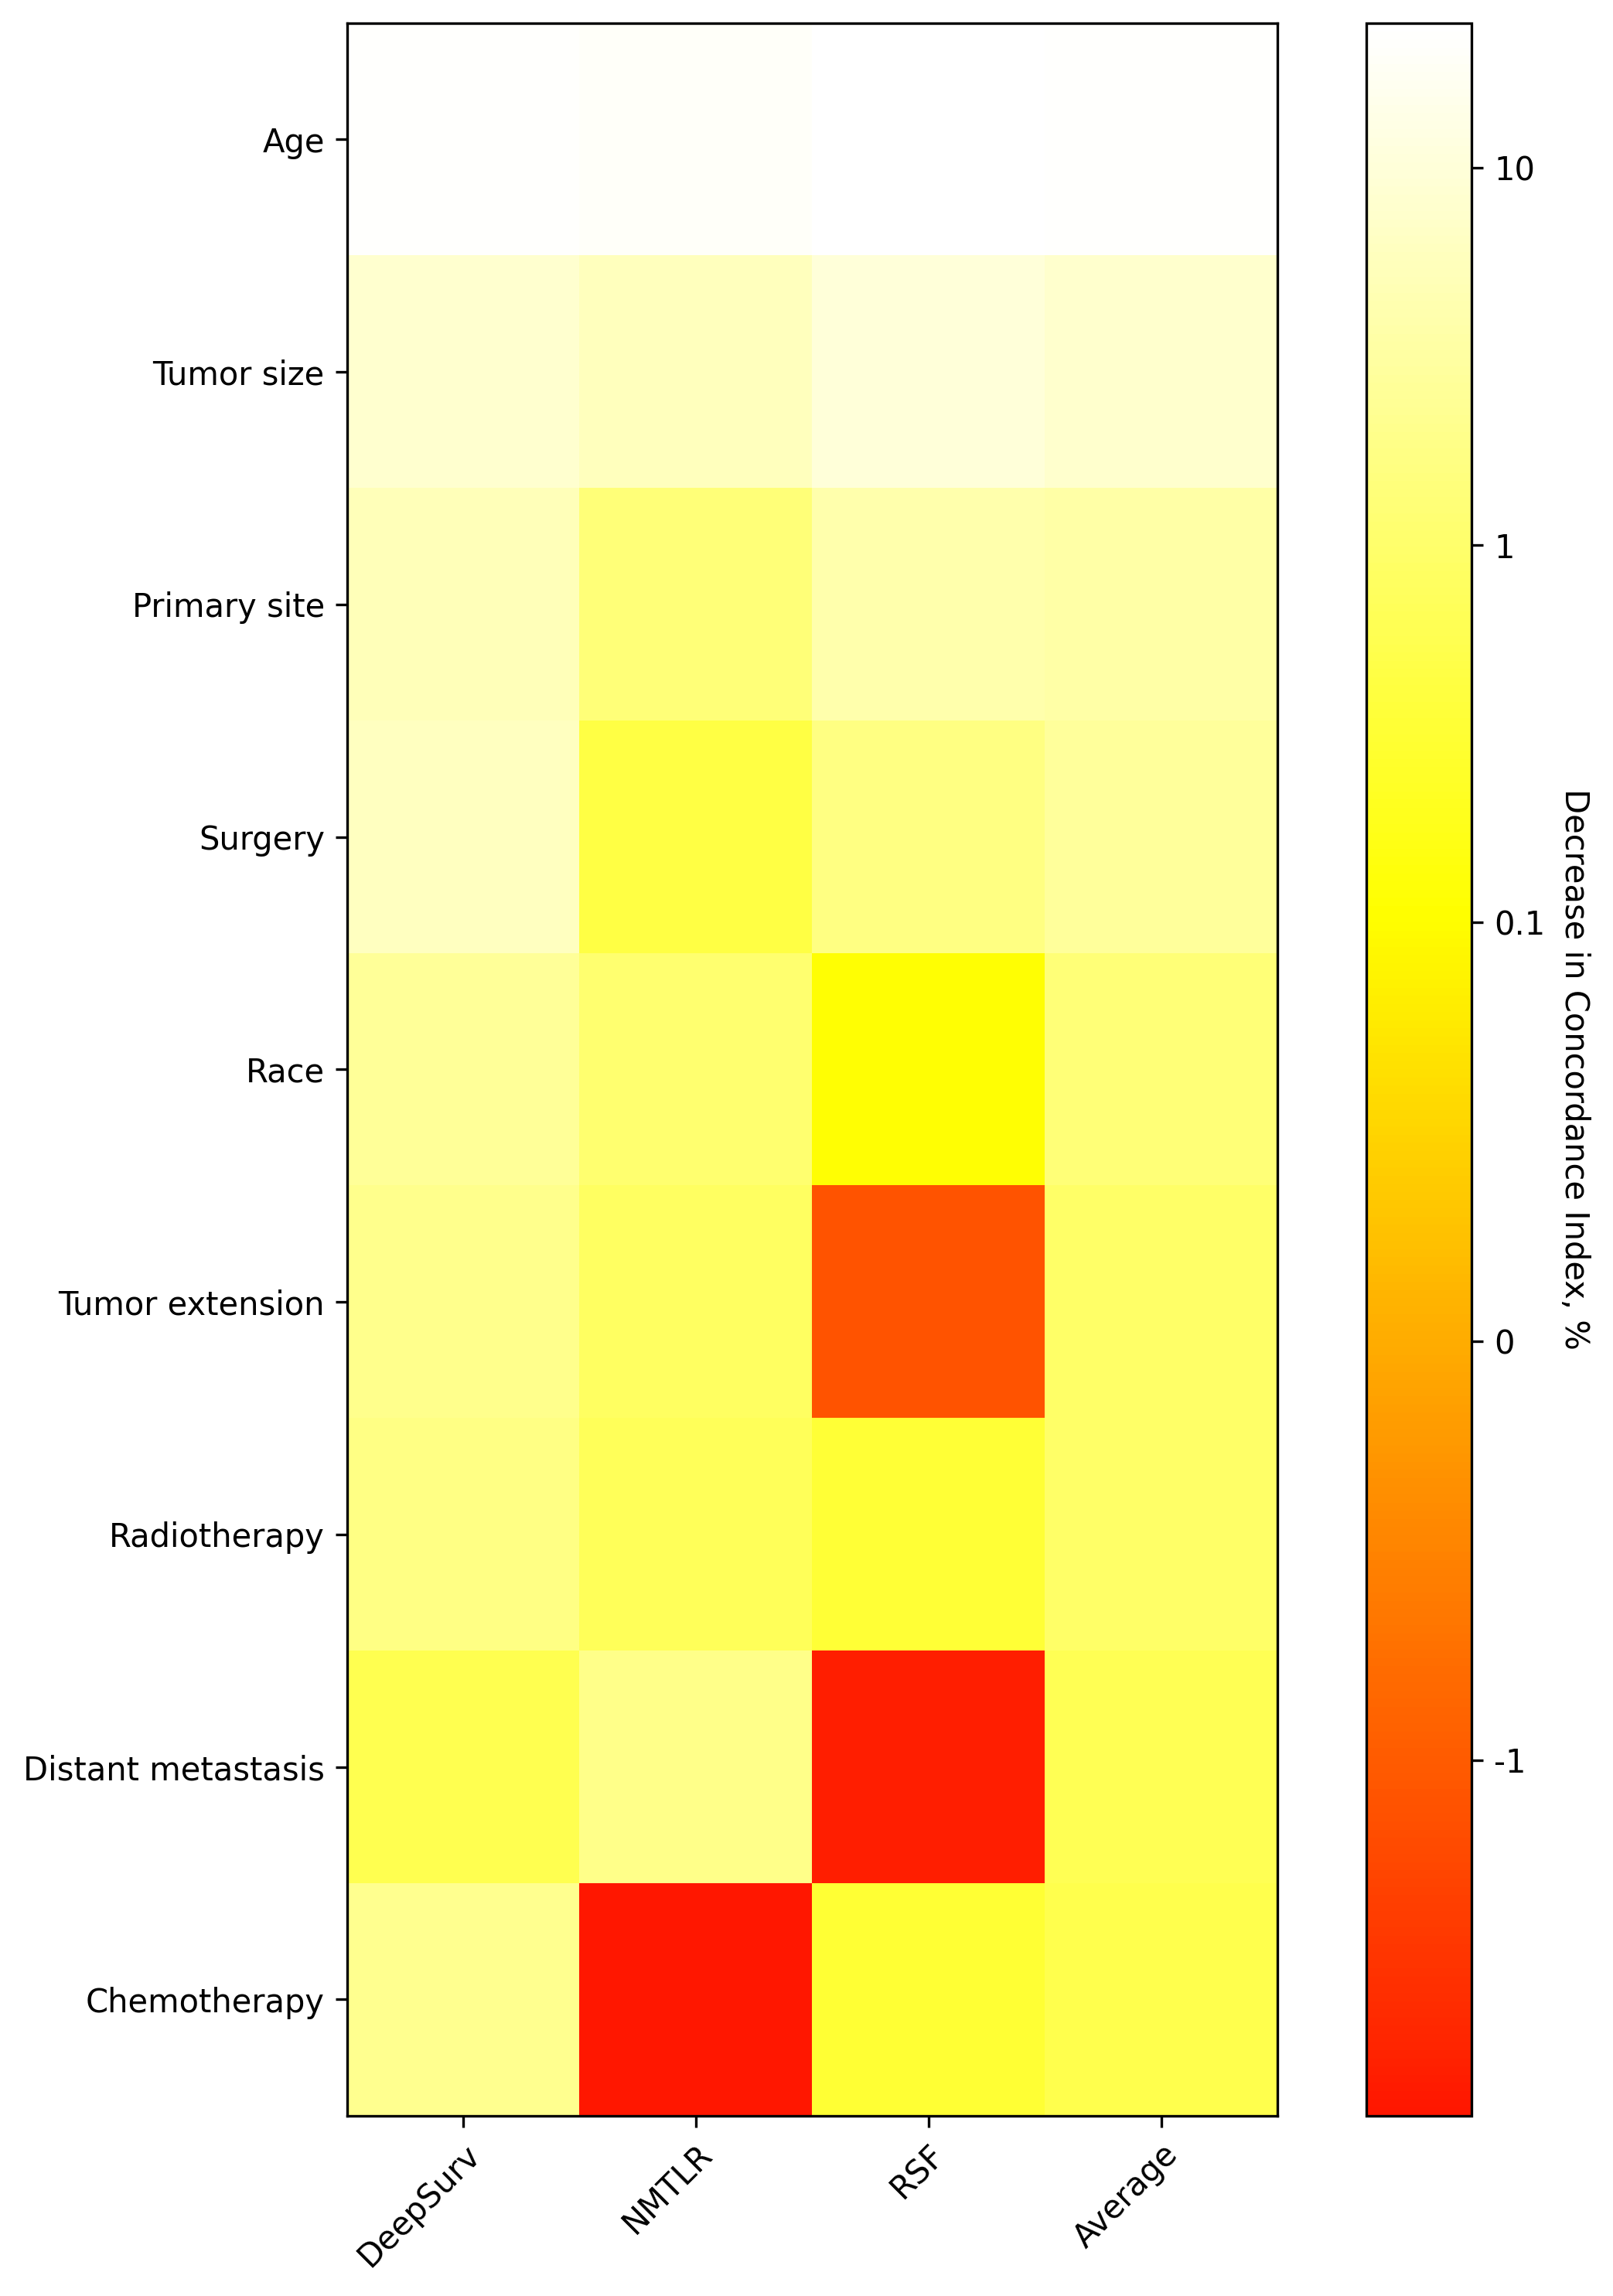

In [211]:
def plotFeatureImportance(a):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    mpl.rcParams['figure.dpi'] = 300
    # a = pd.read_csv(feature_filename)
    a = a.sort_values(by=['Average'], ascending=False)
    fig, ax = plt.subplots(figsize=(8, 10))

    def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
        new_cmap = colors.LinearSegmentedColormap.from_list(
            'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    im = ax.imshow(a[['DeepSurv', 'NMTLR', 'RSF', 'Average']],
                   cmap=truncate_colormap(cm.get_cmap("hot"), minval=0.4, maxval=1), norm=colors.SymLogNorm(1e-3))
    # im.set_clim(-5, -2)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Decrease in Concordance Index, %", rotation=-90, va="bottom")
    # cbar.ax.set_aspect(50)
    cbar.set_ticks([0.1,0.01,0.001,0,-0.001])
    cbar.set_ticklabels(['10',"1","0.1",0,'-1'])

    ax.set_yticks(np.arange(len(a)))
    ax.set_xticks(np.arange(len(a.columns)))
    ax.set_xticklabels(['DeepSurv', 'NMTLR', 'RSF', 'Average'])
    ax.set_yticklabels(a.index)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig("../Figures/variable.eps")
    plt.show()
plotFeatureImportance(imp_df)

### Save models

In [212]:
from pysurvival.utils import save_model
save_model(cph.model, os.path.join(save_path,'CoxPH.zip'))
save_model(deepsurv.model, os.path.join(save_path,'DeepSurv.zip'))
save_model(nmtlr.model, os.path.join(save_path,'NMTLR.zip'))
save_model(rsf.model, os.path.join(save_path,'RSF.zip'))

/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1383573925.py:2: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(cph.model, os.path.join(save_path,'CoxPH.zip'))
/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1383573925.py:3: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(deepsurv.model, os.path.join(save_path,'DeepSurv.zip'))
/var/folders/9y/04p_lrdx74x2xkyfbd8l_rkh0000gn/T/ipykernel_76151/1383573925.py:4: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(nmtlr.model, os.path.join(save_path,'NMTLR.zip'))
/Users/lizhaoyan/PycharmProjects/pysurvival/venv/lib/python3.8/site-packages/pysurvival/utils/__

Saving the model to disk as ../output/CoxPH.zip
Saving the model to disk as ../output/DeepSurv.zip
Saving the model to disk as ../output/NMTLR.zip
Saving the model to disk as ../output/RSF.zip
